In [1]:
import orca
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocess import Process, Manager, Queue, Array, RawArray, Value, Pool, cpu_count
import warnings
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import os; os.chdir('../')
from urbansim_templates import modelmanager as mm
from urbansim_templates import utils
from urbansim_templates.models import LargeMultinomialLogitStep
from urbansim.models.util import columns_in_formula
import warnings;warnings.simplefilter('ignore')
from choicemodels import MultinomialLogit
from choicemodels.tools import (MergedChoiceTable, monte_carlo_choices, 
        iterative_lottery_choices, parallel_lottery_choices, monte_carlo_choices,
                                parallel_lottery_choices_worker)

from scripts import datasources, models, variables


%matplotlib inline

Registering model step 'auto_ownership'
Registering model step 'TOD_choice'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM'


In [2]:
from functools import partial

### Load data

In [3]:
orca.run(['initialize_network_small', 'initialize_network_walk'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


In [4]:
walk_net_vars = pd.read_csv('./data/walk_net_vars.csv', index_col='osmid')
drive_net_vars = pd.read_csv('./data/drive_net_vars.csv', index_col='osmid')
orca.add_table('nodeswalk', walk_net_vars)
orca.add_table('nodessmall', drive_net_vars)

In [5]:
interaction_terms_tt = pd.read_csv(
    './data/WLCM_interaction_terms_tt.csv', index_col=[
        'zone_id_home', 'zone_id_work'])
interaction_terms_dist = pd.read_csv(
    './data/WLCM_interaction_terms_dist.csv', index_col=[
        'zone_id_home', 'zone_id_work'])
interaction_terms_cost = pd.read_csv(
    './data/WLCM_interaction_terms_cost.csv', index_col=[
        'zone_id_home', 'zone_id_work'])

In [6]:
interaction_terms = [interaction_terms_tt, interaction_terms_dist, interaction_terms_cost]

### Prepare data

In [7]:
m = mm.get_step('WLCM')

In [8]:
uniq_intx_idx_names = set([idx for intx in interaction_terms for idx in intx.index.names])

In [9]:
obs_extra_cols = [m.chooser_size] + list(uniq_intx_idx_names)

In [10]:
alts_extra_cols = [m.alt_capacity] + list(uniq_intx_idx_names)

In [11]:
observations = utils.get_data(
    tables = m.out_choosers, 
    fallback_tables = m.choosers, 
    filters = m.out_chooser_filters,
    model_expression = m.model_expression,
    extra_columns = obs_extra_cols)

In [12]:
alternatives = utils.get_data(
    tables = m.out_alternatives, 
    fallback_tables = m.alternatives, 
    filters = m.out_alt_filters,
    model_expression = m.model_expression,
    extra_columns = alts_extra_cols)

In [13]:
expr_cols = columns_in_formula(m.model_expression)

In [14]:
obs_cols = set(observations.columns) & set(expr_cols + utils.to_list(obs_extra_cols))
observations = observations[list(obs_cols)]

In [15]:
alt_cols = set(alternatives.columns) & set(expr_cols + utils.to_list(alts_extra_cols))
alternatives = alternatives[list(alt_cols)]

### Experiment with sample sizes and runtimes

In [15]:
def mct_callable(obs, alts, samp_size):
    return MergedChoiceTable(
        obs, alts, sample_size=samp_size,
        interaction_terms=interaction_terms)

def probs_callable(mct):
    return m.model.probabilities(mct)

In [16]:
choosers = observations.copy()
alts = alternatives.copy()
alt_capacity = m.alt_capacity
chooser_size = m.chooser_size
max_iter = m.max_iter

In [17]:
if alt_capacity is None:
    alt_capacity = '_capacity'
    alts.loc[:,alt_capacity] = 1

if chooser_size is None:
    chooser_size = '_size'
    choosers.loc[:,chooser_size] = 1

capacity, size = (alt_capacity, chooser_size)

len_choosers = len(choosers)
valid_choices = pd.Series()

In [18]:
mct_dict_alts_iters = {}
probs_dict_alts_iters = {}
choices_dict_alts_iters = {}
total_dict_alts_iters = {}
mct_dict_chooser_iters = {}
probs_dict_chooser_iters = {}
choices_dict_chooser_iters = {}
total_dict_chooser_iters = {}

In [19]:
# for n in [10, 100, 1000, 10000, 100000, 500000, 1e6, 2e6, len(alts)]:
for n in [
#         1, 5, 10, 
    15, 
#     20, 25, 30, 40
        ]:
    sttm = time.time()
    mct = mct_callable(choosers.sample(n), alts, len(alts))
    mct_endtm = time.time()
    mct_elapsed = mct_endtm - sttm
    mct_dict_chooser_iters[n] = mct_elapsed
    probs = probs_callable(mct)
    probs_endtm = time.time()
    probs_elapsed = probs_endtm - mct_endtm
    total_time = time.time() - sttm
    probs_dict_chooser_iters[n] = probs_elapsed
    choices = pd.DataFrame(monte_carlo_choices(probs))
    choices_elapsed = time.time() - probs_endtm
    choices_dict_chooser_iters[n] = choices_elapsed
    total_dict_chooser_iters[n] = total_time
    print(str(n) + ': {0} s'.format(np.round(total_time, 1)))

15: 154.5 s


In [20]:
capacity, size = (alt_capacity, chooser_size)
oid, aid = (mct.observation_id_col, mct.alternative_id_col)
c = choices.join(alts[capacity], on=aid).join(choosers[size], on=oid)

In [21]:
c = c.append(pd.DataFrame({'job_id': 710469, '_capacity': 1, '_size': 1}, index=[1234]))

In [22]:
c.loc[:,'_cumsize'] = c.groupby(aid)[size].cumsum()

In [52]:
c_valid = (c._cumsize <= c[capacity])

In [55]:
c_valid.loc[6276077] = False

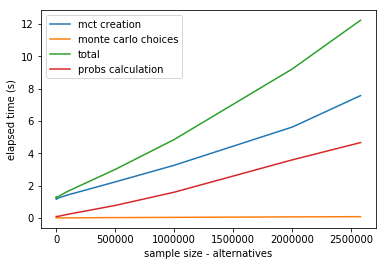

In [90]:
fig, ax = plt.subplots(sharey=True)
ax.plot(mct_dict.keys(), mct_dict.values(), label='mct creation')
ax.plot(choices_dict.keys(), choices_dict.values(), label='monte carlo choices')
ax.plot(total_dict.keys(), total_dict.values(), label='total')
ax.plot(probs_dict.keys(), probs_dict.values(), label='probs calculation')
ax.set_ylabel('elapsed time (s)')
ax.set_xlabel('sample size - alternatives')
ax.legend()

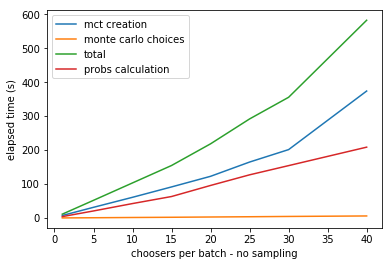

In [24]:
fig, ax = plt.subplots(sharey=True)
ax.plot(mct_dict_chooser_iters.keys(), mct_dict_chooser_iters.values(), label='mct creation')
ax.plot(choices_dict_chooser_iters.keys(), choices_dict_chooser_iters.values(), label='monte carlo choices')
ax.plot(total_dict_chooser_iters.keys(), total_dict_chooser_iters.values(), label='total')
ax.plot(probs_dict_chooser_iters.keys(), probs_dict_chooser_iters.values(), label='probs calculation')
ax.set_ylabel('elapsed time (s)')
ax.set_xlabel('choosers per batch - no sampling')
ax.legend()

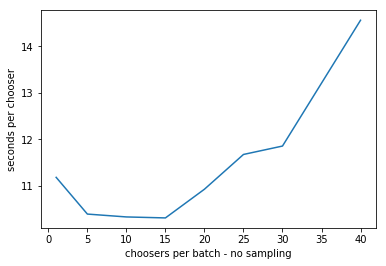

In [25]:
fig, ax = plt.subplots(sharey=True)
ax.plot(total_dict_chooser_iters.keys(), [(v/k) for k,v in total_dict_chooser_iters.items()])
ax.set_xlabel('choosers per batch - no sampling')
_ = ax.set_ylabel('seconds per chooser')

### Parallel processing

#### Dask

In [34]:
obs = dd.from_pandas(observations, chunksize=200000)

In [35]:
obs

Dask DataFrame Structure:
               hh_inc_under_25k hh_inc_75_to_200k zone_id_home no_higher_ed hh_inc_25_to_75k
npartitions=16                                                                              
0                         int64             int64      float64        int64            int64
455800                      ...               ...          ...          ...              ...
...                         ...               ...          ...          ...              ...
6919900                     ...               ...          ...          ...              ...
7060805                     ...               ...          ...          ...              ...
Dask Name: from_pandas, 16 tasks

In [90]:
def mct_callable(obs, alts):
    return MergedChoiceTable(
        obs, alts, sample_size=m.alt_sample_size,
        interaction_terms=interaction_terms)

def probs_callable(mct):
    return m.model.probabilities(mct)

In [39]:
res = obs.map_partitions(
    iterative_lottery_choices, alternatives=alternatives, mct_callable=mct_callable,
    probs_callable=probs_callable, alt_capacity=m.alt_capacity, chooser_size=m.chooser_size,
    meta=(None, int64)
)

In [41]:
with ProgressBar():
    parallel_choices = res.compute()

[                                        ] | 0% Completed | 49.3sIteration 1: 58243 of 60996 valid choices
[                                        ] | 0% Completed | 58.3sIteration 1: 180004 of 200000 valid choices
[                                        ] | 0% Completed |  1min  1.3sIteration 2: 60990 of 60996 valid choices
[                                        ] | 0% Completed |  1min  2.1sIteration 1: 176181 of 200000 valid choices
[                                        ] | 0% Completed |  1min  2.5sIteration 1: 183302 of 200000 valid choices
[                                        ] | 0% Completed |  1min  4.8sIteration 1: 187141 of 200000 valid choices
[                                        ] | 0% Completed |  1min  4.9sIteration 1: 175712 of 200000 valid choices
[                                        ] | 0% Completed |  1min  5.7sIteration 1: 180363 of 200000 valid choices
[                                        ] | 0% Completed |  1min  8.3sIteration 1: 188423 of 20

#### Multiprocess - Process

In [21]:
def mct_callable(obs, alts):
    return MergedChoiceTable(
        obs, alts, sample_size=m.alt_sample_size,
        interaction_terms=interaction_terms)

def probs_callable(mct):
    return m.model.probabilities(mct)

In [16]:
def parallel_lottery_choices(
        choosers, alternatives, alts_idx_name, choices_dict, chosen_alts,
        mct_callable, probs_callable, alt_capacity=None, chooser_size=None,
        max_iter=None, chooser_batch_size=None, proc_num=0, batch_size=0):

    st_choice_idx = proc_num * batch_size
    if alt_capacity is None:
        alt_capacity = '_capacity'
    if chooser_size is None:
        chooser_size = '_size'
        choosers.loc[:, chooser_size] = 1
    
    capacity, size = (alt_capacity, chooser_size)
    
    len_choosers = len(choosers)
    valid_choices = pd.Series()
    
    iter = 0
    sttm = time.time()
#     alternatives.drop(list(chosen_alts, inplace=True)
#     print('Took {0} seconds to update alts df for process {1}'.format(
#         round(time.time() - sttm, 1), str(proc_num)))
    proc_sttm = time.time()
    while (len(valid_choices) < len_choosers):
        chosen_alts_list = list(chosen_alts.get_obj())
        alternatives = alternatives[~alternatives.index.isin(chosen_alts_list)]
        sttm = time.time()
        iter += 1
        if max_iter is not None:
            if (iter > max_iter):
                break
        if alternatives['_capacity'].max() < choosers[size].min():
            print("{} choosers cannot be allocated.".format(len(choosers)))
            print("\nRemaining capacity on alternatives but not enough to accodomodate choosers' sizes")
            break
        mct = mct_callable(choosers.sample(frac=1), alternatives)
#         print('Got MCT on process {0} after {1} s'.format(
#             str(proc_num), round(time.time() - sttm, 1)))

        if len(mct.to_frame()) == 0:
            print("No valid alternatives for the remaining choosers")
            break
        sttm = time.time()
        probs = probs_callable(mct)
#         print('Got probs on process {0} after {1} s'.format(
#             str(proc_num), round(time.time() - sttm, 1)))
        choices = pd.DataFrame(monte_carlo_choices(probs))
    
        # join capacities and sizes
        oid, aid = (mct.observation_id_col, mct.alternative_id_col)
        sttm = time.time()
        c = choices.join(alternatives[capacity], on=aid).join(choosers[size], on=oid)
#         print('Took {0} seconds to join choices with alts and choosers for process {1}'.format(
#             round(time.time() - sttm, 1), str(proc_num)))

        # ***when size==1, _cumsize counts the cumulative number of times
        # each alternative appears
        sttm = time.time()
        c.loc[:,'_cumsize'] = c.groupby(aid)[size].cumsum()
#         print('Took {0} seconds to compute cumsum for process {1}'.format(
#             round(time.time() - sttm, 1), str(proc_num)))
    
        # save valid choices
        
        # ***thus c_valid creates a mask that retains just the choice of
        # the chooser to chose their alternative first, ***PROVIDED*** that
        # choice hasn't been made elsewhere as documented by the shared
        # chosen_alts list
        sttm = time.time()
        chosen_alts_list = list(chosen_alts.get_obj())
#         print('Took {0} seconds to convert ProxyList to list for process {1}'.format(
#             round(time.time() - sttm, 1), str(proc_num)))
        
        sttm = time.time()
        c_valid = (c._cumsize <= c[capacity]) & (~c.job_id.isin(chosen_alts_list))
        iter_valid_choices = c[aid].loc[c_valid]
#         print('Took {0} seconds to filter valid choices for process {1}'.format(
#             round(time.time() - sttm, 1), str(proc_num)))
        if len(iter_valid_choices) == 0:
            continue
        sttm = time.time()
#         for job_id in iter_valid_choices.values:
#             try:
#                 alts_dict.pop(job_id)
#             except KeyError:
#                 # this means the job was already chosen and popped from the
#                 # alts_dict bewteen the time the choice was made and time
#                 # this process chose it and tried to pop it
#                 c_valid = (c._cumsize <= c[capacity]) & (~c.job_id.isin(list(chosen_alts)))
#                 iter_valid_choices = c[aid].loc[c_valid]
#             except IndexError:
#                 print("No remaining alternatives!")
#         time.sleep(1)
#         c_valid = (c._cumsize <= c[capacity]) & (~c.job_id.isin(list(chosen_alts)))
#         iter_valid_choices = c[aid].loc[c_valid]

#         chosen_alts.extend(iter_valid_choices.values)
        num_valid_choices = len(iter_valid_choices.values)
        try:
            chosen_alts[st_choice_idx:st_choice_idx + num_valid_choices] = iter_valid_choices.values
            st_choice_idx += num_valid_choices
        except:
            print(st_choice_idx, num_valid_choices)
#         print('Took {0} seconds to add valid choices for process {1}'.format(
#             round(time.time() - sttm, 1), str(proc_num)))
        alternatives.drop(iter_valid_choices.values, inplace=True)

        iter_valid_choices.index.name = choosers.index.name
        iter_valid_choices.name = alternatives.index.name
        sttm = time.time()
        choices_dict.update(iter_valid_choices.to_dict())
#         print('Took {0} seconds to update choices dict for process {1}'.format(
#             round(time.time() - sttm, 1), str(proc_num)))
        
        sttm = time.time()
        valid_choices = pd.concat([valid_choices, iter_valid_choices])
#         print('Took {0} seconds to concat choices for process {1} with {2} choices and {3} choosers.'.format(
#             round(time.time() - sttm, 1), str(proc_num), len(valid_choices), len_choosers))
        
        # update choosers and alternatives
        # this works in parallel mode fine since there is no sharing
        # of choosers between processes
        sttm = time.time()
        choosers = choosers.drop(c.loc[c_valid].index.values)
#         print('Took {0} seconds to drop choosers for process {1}'.format(
#             round(time.time() - sttm, 1), str(proc_num)))
        print("{0} remaining choosers on process {1} after {2} iterations".format(
            len(choosers), str(proc_num), str(iter)))
        
#         placed_capacity = c.loc[c_valid].groupby(aid)._cumsize.max()
        
        # this should probably be done on the shared dict???
#         alternatives.loc[:, capacity] = alternatives[capacity].subtract(placed_capacity, fill_value=0)

#         full = alternatives.loc[alternatives[capacity] == 0]
#         alternatives = alternatives.drop(full.index)
        
        # print("{} remaining alternatives".format(len(alts)))
    print('Took {0} seconds and {1} iters for process {2} to complete.'.format(
        round(time.time() - proc_sttm, 1), str(iter), str(proc_num)))
    return
    

In [16]:
obs_samp = observations.sample(
    frac=1
#     100
)

alts = alternatives.sample(
#     200
    frac=1
)

batch_size = 200000
# batch_size = 5

obs_batches = [obs_samp.index.values[x:x + batch_size]
                        for x in range(0, len(obs_samp), batch_size)]

manager = Manager()
shared_choices_dict = manager.dict()
alts['_capacity'] = 1

# shared_chosen_alts = manager.list()
shared_chosen_alts = Array('i', len(obs_samp))
jobs = []

In [66]:
choices_made = Value('i', 0)
for b, batch in enumerate(obs_batches):
    obs = observations.ix[batch]
    proc = Process(
        target=parallel_lottery_choices,
        kwargs={
            'choosers': obs, 'alternatives': alts,
            'alts_idx_name': alternatives.index.name,
            'choices_dict': shared_choices_dict, 'chosen_alts': shared_chosen_alts,
            'mct_callable': mct_callable, 'probs_callable': probs_callable,
            'alt_capacity': '_capacity', 'chooser_size': m.chooser_size, 'proc_num': b,
            'batch_size': batch_size
        })
    proc.start()
    jobs.append(proc)

809 remaining choosers on process 15 after 1 iterations
19260 remaining choosers on process 0 after 1 iterations
19246 remaining choosers on process 3 after 1 iterations
101091 remaining choosers on process 1 after 1 iterations
121405 remaining choosers on process 4 after 1 iterations
121500 remaining choosers on process 2 after 1 iterations
146627 remaining choosers on process 5 after 1 iterations
154983 remaining choosers on process 7 after 1 iterations
155058 remaining choosers on process 12 after 1 iterations
166652 remaining choosers on process 11 after 1 iterations
171185 remaining choosers on process 10 after 1 iterations
170982 remaining choosers on process 13 after 1 iterations
171063 remaining choosers on process 6 after 1 iterations
179424 remaining choosers on process 8 after 1 iterations
198 remaining choosers on process 15 after 2 iterations
179746 remaining choosers on process 14 after 1 iterations
4188 remaining choosers on process 0 after 2 iterations
183115 remaining 

No valid alternatives for the remaining choosers
Took 115.2 seconds and 7 iters for process 9 to complete.
No valid alternatives for the remaining choosers
Took 114.7 seconds and 12 iters for process 12 to complete.
No valid alternatives for the remaining choosers
Took 117.1 seconds and 8 iters for process 8 to complete.
No valid alternatives for the remaining choosers
Took 115.7 seconds and 8 iters for process 13 to complete.


In [67]:
for j, job in tqdm(enumerate(jobs), total=len(jobs)):
    job.join()





  0%|          | 0/16 [00:00<?, ?it/s]



  6%|▋         | 1/16 [01:00<15:01, 60.13s/it]



 12%|█▎        | 2/16 [01:51<13:01, 55.82s/it]



 19%|█▉        | 3/16 [01:52<08:07, 37.53s/it]



 31%|███▏      | 5/16 [01:52<04:08, 22.56s/it]



 56%|█████▋    | 9/16 [01:54<01:29, 12.72s/it]



 88%|████████▊ | 14/16 [01:54<00:16,  8.21s/it]



100%|██████████| 16/16 [01:54<00:00,  7.19s/it]

In [68]:
%time choices_dict = shared_choices_dict._getvalue()

CPU times: user 1.45 s, sys: 203 ms, total: 1.66 s
Wall time: 14.3 s


#### Multiprocess -- Choicemodels Method

In [15]:
def mct_callable(obs, alts):
    return MergedChoiceTable(
        obs, alts, sample_size=m.alt_sample_size,
        interaction_terms=interaction_terms)

def probs_callable(mct):
    return m.model.probabilities(mct)

In [16]:
choices = parallel_lottery_choices(
    observations, alternatives, mct_callable, probs_callable, m.alt_capacity, m.chooser_size,
    chooser_batch_size=200000)

100%|██████████| 16/16 [01:48<00:00,  6.78s/it]


In [17]:
assert len(np.unique(list(choices.values()))) == len(alternatives) - 1

#### Multiprocess -- Pool

In [16]:
def parallel_lottery_choices_worker(choosers):
    sttm = time.time()
    global alt_capacity
    global alternatives
    global chooser_size
    global shared_choices_dict
    choices_dict = shared_choices_dict
    global shared_chosen_alts
    chosen_alts = shared_chosen_alts
    global mct_callable
    global probs_callable
    
    st_choice_idx = choosers['choice_idx'].values.min()
    proc_num = st_choice_idx / len(choosers)
    if alt_capacity is None:
        alt_capacity = '_capacity'
        alternatives.loc[:, alt_capacity] = 1
    if chooser_size is None:
        chooser_size = '_size'
        choosers[chooser_size] = 1

    capacity, size = (alt_capacity, chooser_size)

    len_choosers = len(choosers)
    valid_choices = pd.Series()

    iter = 0

    while (len(valid_choices) < len_choosers):
        chosen_alts_list = list(chosen_alts.get_obj())
        alternatives = alternatives[~alternatives.index.isin(chosen_alts_list)]
        iter += 1

        if alternatives['_capacity'].max() < choosers[size].min():
            print("{} choosers cannot be allocated.".format(len(choosers)))
            print("\nRemaining capacity on alternatives but "
                  "not enough to accodomodate choosers' sizes")
            break

        mct = mct_callable(choosers.sample(frac=1), alternatives)
        if len(mct.to_frame()) == 0:
            # print("No valid alternatives for the remaining choosers")
            break

        probs = probs_callable(mct)
        choices = pd.DataFrame(monte_carlo_choices(probs))

        # join capacities and sizes
        oid, aid = (mct.observation_id_col, mct.alternative_id_col)
        c = choices.join(
            alternatives[capacity], on=aid).join(
            choosers[size], on=oid)

        # when size==1, _cumsize counts the cumulative number of times
        # each alternative appears
        c.loc[:, '_cumsize'] = c.groupby(aid)[size].cumsum()

        # thus c_valid creates a mask that retains just the choice
        # of the chooser to chose their alternative first,
        # ***PROVIDED*** that choice hasn't been made elsewhere as
        # documented by the shared chosen_alts list
        chosen_alts_list = list(chosen_alts.get_obj())
        c_valid = (c._cumsize <= c[capacity]) & (
            ~c.job_id.isin(chosen_alts_list))
        iter_valid_choices = c[aid].loc[c_valid]
        if len(iter_valid_choices) == 0:
            continue

        num_valid_choices = len(iter_valid_choices.values)
        chosen_alts[
            st_choice_idx:st_choice_idx + num_valid_choices
        ] = iter_valid_choices.values
        st_choice_idx += num_valid_choices
        alternatives.drop(iter_valid_choices.values, inplace=True)

        iter_valid_choices.index.name = choosers.index.name
        iter_valid_choices.name = alternatives.index.name
        choices_dict.update(iter_valid_choices.to_dict())
        valid_choices = pd.concat([valid_choices, iter_valid_choices])

        choosers = choosers.drop(c.loc[c_valid].index.values)
    print('Finished process {0} after {1} seconds and {2} iterations'.format(
        str(proc_num), round(time.time() - sttm, 1), str(iter)))
    return

In [17]:
def mct_callable(obs, alts):
    return MergedChoiceTable(
        obs, alts, sample_size=m.alt_sample_size,
        interaction_terms=interaction_terms)

def probs_callable(mct):
    return m.model.probabilities(mct)

In [23]:
batch_size = 15
obs_samp = observations.sample(
    frac=1
#     100
)
obs_samp.reset_index(inplace=True)
obs_samp.index.name = 'choice_idx'
obs_samp.reset_index(inplace=True)
obs_samp.set_index('person_id', inplace=True)
obs_samp['_size'] = 1
obs_batches = [obs_samp[x:x + batch_size]
                        for x in range(0, len(obs_samp), batch_size)]

alts = alternatives.sample(
    frac=1
#     200
)
manager = Manager()
shared_choices_dict = manager.dict()
shared_chosen_alts = Array('i', len(obs_samp))

In [26]:
def initializer(
        _alternatives, _shared_choices_dict, _shared_chosen_alts, _mct_callable, _probs_callable,
        _alt_capacity, _chooser_size):
    
    global alt_capacity
    alt_capacity = _alt_capacity
    
    global chooser_size
    chooser_size = _chooser_size
    
    global alternatives
    alternatives = alternatives
    
    global shared_choices_dict
    shared_choices_dict = _shared_choices_dict
    
    global shared_chosen_alts
    shared_chosen_alts = _shared_chosen_alts
    
    
    global mct_callable
    mct_callable = _mct_callable
    
    global probs_callable
    probs_callable = _probs_callable

In [27]:
%%time
pool = Pool(20, initializer=initializer, initargs=(
    alts, shared_choices_dict, shared_chosen_alts, mct_callable, probs_callable, m.alt_capacity, m.chooser_size))

CPU times: user 196 ms, sys: 11.1 s, total: 11.3 s
Wall time: 11.7 s
Finished process 2000.0 after 28.1 seconds and 1 iterations
Finished process 1000.0 after 31.5 seconds and 1 iterations
Finished process 0.0 after 34.1 seconds and 1 iterations
Finished process 5000.0 after 24.5 seconds and 1 iterations
Finished process 1.0 after 21.9 seconds and 1 iterations
Finished process 2001.0 after 23.2 seconds and 1 iterations
Finished process 1001.0 after 22.8 seconds and 1 iterations
Finished process 4000.0 after 44.6 seconds and 2 iterations
Finished process 3000.0 after 48.7 seconds and 2 iterations
Finished process 7000.0 after 33.0 seconds and 1 iterations
Finished process 8000.0 after 29.9 seconds and 1 iterations
Finished process 5001.0 after 23.6 seconds and 1 iterations
Finished process 6000.0 after 50.5 seconds and 2 iterations
Finished process 12000.0 after 36.6 seconds and 1 iterations
Finished process 2002.0 after 27.3 seconds and 1 iterations
Finished process 2.0 after 28.0 seco

Finished process 9.0 after 31.6 seconds and 1 iterations
Finished process 19006.0 after 23.2 seconds and 1 iterations
Finished process 1008.0 after 24.9 seconds and 1 iterations
Finished process 4006.0 after 49.8 seconds and 2 iterations
Finished process 18004.0 after 48.2 seconds and 2 iterations
Finished process 9006.0 after 24.4 seconds and 1 iterations
Finished process 13004.0 after 49.6 seconds and 2 iterations
Finished process 11006.0 after 24.8 seconds and 1 iterations
Finished process 6007.0 after 25.9 seconds and 1 iterations
Finished process 10006.0 after 22.1 seconds and 1 iterations
Finished process 7008.0 after 20.8 seconds and 1 iterations
Finished process 8007.0 after 25.3 seconds and 1 iterations
Finished process 16007.0 after 21.1 seconds and 1 iterations
Finished process 15006.0 after 22.6 seconds and 1 iterations
Finished process 12008.0 after 21.8 seconds and 1 iterations
Finished process 5010.0 after 21.8 seconds and 1 iterations
Finished process 14005.0 after 22.6

Finished process 2013.0 after 45.3 seconds and 2 iterations
Finished process 8013.0 after 22.2 seconds and 1 iterations
Finished process 12014.0 after 23.9 seconds and 1 iterations
Finished process 14012.0 after 22.6 seconds and 1 iterations
Finished process 5016.0 after 33.8 seconds and 1 iterations
Finished process 1016.0 after 22.0 seconds and 1 iterations
Finished process 3013.0 after 23.1 seconds and 1 iterations
Finished process 13012.0 after 22.7 seconds and 1 iterations
Finished process 10012.0 after 25.8 seconds and 1 iterations
Finished process 15012.0 after 56.6 seconds and 2 iterations
Finished process 19014.0 after 23.4 seconds and 1 iterations
Finished process 11014.0 after 22.3 seconds and 1 iterations
Finished process 6015.0 after 19.8 seconds and 1 iterations
Finished process 16.0 after 25.0 seconds and 1 iterations
Finished process 16013.0 after 47.1 seconds and 2 iterations
Finished process 18011.0 after 22.6 seconds and 1 iterations
Finished process 4014.0 after 30.

Finished process 10018.0 after 22.6 seconds and 1 iterations
Finished process 15018.0 after 22.7 seconds and 1 iterations
Finished process 9018.0 after 22.0 seconds and 1 iterations
Finished process 18018.0 after 22.8 seconds and 1 iterations
Finished process 21.0 after 23.4 seconds and 1 iterations
Finished process 2020.0 after 24.6 seconds and 1 iterations
Finished process 17018.0 after 22.1 seconds and 1 iterations
Finished process 4021.0 after 24.9 seconds and 1 iterations
Finished process 8021.0 after 24.1 seconds and 1 iterations
Finished process 19019.0 after 48.1 seconds and 2 iterations
Finished process 6021.0 after 25.3 seconds and 1 iterations
Finished process 14020.0 after 22.9 seconds and 1 iterations
Finished process 1024.0 after 22.1 seconds and 1 iterations
Finished process 7023.0 after 25.1 seconds and 1 iterations
Finished process 3020.0 after 24.2 seconds and 1 iterations
Finished process 12022.0 after 24.2 seconds and 1 iterations
Finished process 11022.0 after 22.1

Finished process 5027.0 after 23.9 seconds and 1 iterations
Finished process 1031.0 after 23.6 seconds and 1 iterations
Finished process 3026.0 after 45.5 seconds and 2 iterations
Finished process 11029.0 after 21.8 seconds and 1 iterations
Finished process 10024.0 after 47.2 seconds and 2 iterations
Finished process 19026.0 after 27.5 seconds and 1 iterations
Finished process 16027.0 after 22.8 seconds and 1 iterations
Finished process 9024.0 after 20.5 seconds and 1 iterations
Finished process 8027.0 after 22.1 seconds and 1 iterations
Finished process 2028.0 after 24.4 seconds and 1 iterations
Finished process 15026.0 after 22.5 seconds and 1 iterations
Finished process 12029.0 after 29.2 seconds and 1 iterations
Finished process 28.0 after 24.0 seconds and 1 iterations
Finished process 17025.0 after 25.3 seconds and 1 iterations
Finished process 6028.0 after 20.7 seconds and 1 iterations
Finished process 18026.0 after 24.5 seconds and 1 iterations
Finished process 4028.0 after 22.7

Finished process 2033.0 after 20.8 seconds and 1 iterations
Finished process 15033.0 after 23.9 seconds and 1 iterations
Finished process 18032.0 after 23.2 seconds and 1 iterations
Finished process 14034.0 after 23.2 seconds and 1 iterations
Finished process 6035.0 after 25.2 seconds and 1 iterations
Finished process 17031.0 after 26.6 seconds and 1 iterations
Finished process 4034.0 after 22.5 seconds and 1 iterations
Finished process 1039.0 after 21.8 seconds and 1 iterations
Finished process 7035.0 after 29.1 seconds and 1 iterations
Finished process 3033.0 after 45.4 seconds and 2 iterations
Finished process 11037.0 after 24.0 seconds and 1 iterations
Finished process 19033.0 after 25.6 seconds and 1 iterations
Finished process 10030.0 after 23.0 seconds and 1 iterations
Finished process 5034.0 after 23.2 seconds and 1 iterations
Finished process 12037.0 after 24.2 seconds and 1 iterations
Finished process 36.0 after 22.8 seconds and 1 iterations
Finished process 16035.0 after 24.

Finished process 18039.0 after 22.9 seconds and 1 iterations
Finished process 19039.0 after 25.1 seconds and 1 iterations
Finished process 14040.0 after 23.1 seconds and 1 iterations
Finished process 17038.0 after 20.6 seconds and 1 iterations
Finished process 4041.0 after 21.9 seconds and 1 iterations
Finished process 1046.0 after 20.9 seconds and 1 iterations
Finished process 11044.0 after 21.7 seconds and 1 iterations
Finished process 15039.0 after 30.1 seconds and 1 iterations
Finished process 10037.0 after 22.6 seconds and 1 iterations
Finished process 5041.0 after 24.0 seconds and 1 iterations
Finished process 43.0 after 24.4 seconds and 1 iterations
Finished process 3039.0 after 23.5 seconds and 1 iterations
Finished process 9038.0 after 22.8 seconds and 1 iterations
Finished process 13038.0 after 26.1 seconds and 1 iterations
Finished process 2041.0 after 24.2 seconds and 1 iterations
Finished process 7041.0 after 24.1 seconds and 1 iterations
Finished process 8042.0 after 23.7

Finished process 10043.0 after 25.1 seconds and 1 iterations
Finished process 11051.0 after 22.6 seconds and 1 iterations
Finished process 18045.0 after 26.0 seconds and 1 iterations
Finished process 3046.0 after 21.2 seconds and 1 iterations
Finished process 5048.0 after 24.4 seconds and 1 iterations
Finished process 2048.0 after 22.4 seconds and 1 iterations
Finished process 50.0 after 22.7 seconds and 1 iterations
Finished process 8048.0 after 21.6 seconds and 1 iterations
Finished process 1054.0 after 22.6 seconds and 1 iterations
Finished process 12051.0 after 23.4 seconds and 1 iterations
Finished process 6050.0 after 24.8 seconds and 1 iterations
Finished process 13045.0 after 25.7 seconds and 1 iterations
Finished process 14047.0 after 22.8 seconds and 1 iterations
Finished process 9045.0 after 25.2 seconds and 1 iterations
Finished process 15046.0 after 26.9 seconds and 1 iterations
Finished process 19046.0 after 48.2 seconds and 2 iterations
Finished process 7048.0 after 24.3

Finished process 12058.0 after 23.2 seconds and 1 iterations
Finished process 15052.0 after 25.0 seconds and 1 iterations
Finished process 9052.0 after 21.0 seconds and 1 iterations
Finished process 17051.0 after 20.7 seconds and 1 iterations
Finished process 1061.0 after 25.3 seconds and 1 iterations
Finished process 4054.0 after 24.2 seconds and 1 iterations
Finished process 2056.0 after 23.3 seconds and 1 iterations
Finished process 19053.0 after 23.8 seconds and 1 iterations
Finished process 13051.0 after 22.5 seconds and 1 iterations
Finished process 10050.0 after 23.5 seconds and 1 iterations
Finished process 18051.0 after 23.7 seconds and 1 iterations
Finished process 56.0 after 23.8 seconds and 1 iterations
Finished process 16052.0 after 25.0 seconds and 1 iterations
Finished process 11059.0 after 23.5 seconds and 1 iterations
Finished process 14054.0 after 24.8 seconds and 1 iterations
Finished process 3054.0 after 24.0 seconds and 1 iterations
Finished process 6057.0 after 22

Finished process 12064.0 after 24.3 seconds and 1 iterations
Finished process 9059.0 after 24.5 seconds and 1 iterations
Finished process 17058.0 after 22.3 seconds and 1 iterations
Finished process 11066.0 after 23.2 seconds and 1 iterations
Finished process 13058.0 after 23.0 seconds and 1 iterations
Finished process 4061.0 after 23.0 seconds and 1 iterations
Finished process 18058.0 after 24.7 seconds and 1 iterations
Finished process 19059.0 after 50.2 seconds and 2 iterations
Finished process 63.0 after 24.0 seconds and 1 iterations
Finished process 16057.0 after 23.2 seconds and 1 iterations
Finished process 3060.0 after 23.1 seconds and 1 iterations
Finished process 7061.0 after 23.4 seconds and 1 iterations
Finished process 14061.0 after 24.4 seconds and 1 iterations
Finished process 10056.0 after 25.2 seconds and 1 iterations
Finished process 15060.0 after 22.7 seconds and 1 iterations
Finished process 6064.0 after 23.9 seconds and 1 iterations
Finished process 8062.0 after 22

Finished process 3067.0 after 22.3 seconds and 1 iterations
Finished process 7066.0 after 26.7 seconds and 1 iterations
Finished process 16064.0 after 24.4 seconds and 1 iterations
Finished process 13065.0 after 23.2 seconds and 1 iterations
Finished process 5069.0 after 24.5 seconds and 1 iterations
Finished process 70.0 after 23.2 seconds and 1 iterations
Finished process 4068.0 after 25.3 seconds and 1 iterations
Finished process 8069.0 after 25.5 seconds and 1 iterations
Finished process 14067.0 after 22.7 seconds and 1 iterations
Finished process 17064.0 after 23.8 seconds and 1 iterations
Finished process 18065.0 after 21.8 seconds and 1 iterations
Finished process 15067.0 after 23.8 seconds and 1 iterations
Finished process 6071.0 after 23.3 seconds and 1 iterations
Finished process 19066.0 after 25.7 seconds and 1 iterations
Finished process 10063.0 after 27.1 seconds and 1 iterations
Finished process 1076.0 after 21.2 seconds and 1 iterations
Finished process 12072.0 after 23.

Finished process 3074.0 after 24.4 seconds and 1 iterations
Finished process 18072.0 after 21.4 seconds and 1 iterations
Finished process 13072.0 after 24.1 seconds and 1 iterations
Finished process 5076.0 after 23.4 seconds and 1 iterations
Finished process 14074.0 after 21.4 seconds and 1 iterations
Finished process 6078.0 after 21.2 seconds and 1 iterations
Finished process 1083.0 after 24.3 seconds and 1 iterations
Finished process 9072.0 after 24.0 seconds and 1 iterations
Finished process 4075.0 after 22.5 seconds and 1 iterations
Finished process 8075.0 after 22.7 seconds and 1 iterations
Finished process 11081.0 after 22.6 seconds and 1 iterations
Finished process 10070.0 after 22.8 seconds and 1 iterations
Finished process 19073.0 after 21.7 seconds and 1 iterations
Finished process 17070.0 after 21.8 seconds and 1 iterations
Finished process 2077.0 after 22.5 seconds and 1 iterations
Finished process 12079.0 after 20.8 seconds and 1 iterations
Finished process 7070.0 after 31

Finished process 13079.0 after 22.6 seconds and 1 iterations
Finished process 14081.0 after 24.3 seconds and 1 iterations
Finished process 7075.0 after 25.1 seconds and 1 iterations
Finished process 6085.0 after 23.2 seconds and 1 iterations
Finished process 18079.0 after 20.9 seconds and 1 iterations
Finished process 5083.0 after 22.9 seconds and 1 iterations
Finished process 4081.0 after 23.7 seconds and 1 iterations
Finished process 1090.0 after 22.2 seconds and 1 iterations
Finished process 15081.0 after 22.2 seconds and 1 iterations
Finished process 19080.0 after 27.2 seconds and 1 iterations
Finished process 11088.0 after 25.6 seconds and 1 iterations
Finished process 8082.0 after 24.0 seconds and 1 iterations
Finished process 17077.0 after 23.8 seconds and 1 iterations
Finished process 2084.0 after 25.0 seconds and 1 iterations
Finished process 9078.0 after 25.2 seconds and 1 iterations
Finished process 12086.0 after 22.5 seconds and 1 iterations
Finished process 3082.0 after 21

Finished process 19085.0 after 48.4 seconds and 2 iterations
Finished process 16083.0 after 24.6 seconds and 1 iterations
Finished process 4088.0 after 22.6 seconds and 1 iterations
Finished process 5090.0 after 21.1 seconds and 1 iterations
Finished process 11095.0 after 24.3 seconds and 1 iterations
Finished process 18085.0 after 23.5 seconds and 1 iterations
Finished process 2091.0 after 22.7 seconds and 1 iterations
Finished process 1097.0 after 25.0 seconds and 1 iterations
Finished process 17084.0 after 24.3 seconds and 1 iterations
Finished process 15088.0 after 23.7 seconds and 1 iterations
Finished process 91.0 after 23.6 seconds and 1 iterations
Finished process 10084.0 after 24.7 seconds and 1 iterations
Finished process 3089.0 after 28.2 seconds and 1 iterations
Finished process 13087.0 after 23.6 seconds and 1 iterations
Finished process 12093.0 after 22.6 seconds and 1 iterations
Finished process 7082.0 after 27.9 seconds and 1 iterations
Finished process 8089.0 after 21.

Finished process 12099.0 after 24.9 seconds and 1 iterations
Finished process 16090.0 after 23.8 seconds and 1 iterations
Finished process 19092.0 after 21.7 seconds and 1 iterations
Finished process 6099.0 after 23.0 seconds and 1 iterations
Finished process 11102.0 after 21.3 seconds and 1 iterations
Finished process 4095.0 after 24.3 seconds and 1 iterations
Finished process 5097.0 after 24.6 seconds and 1 iterations
Finished process 17091.0 after 21.8 seconds and 1 iterations
Finished process 7088.0 after 30.7 seconds and 1 iterations
Finished process 18092.0 after 24.2 seconds and 1 iterations
Finished process 2097.0 after 24.1 seconds and 1 iterations
Finished process 15095.0 after 20.8 seconds and 1 iterations
Finished process 8096.0 after 23.2 seconds and 1 iterations
Finished process 1104.0 after 25.9 seconds and 1 iterations
Finished process 14095.0 after 23.9 seconds and 1 iterations
Finished process 3096.0 after 21.3 seconds and 1 iterations
Finished process 9092.0 after 24

Finished process 13100.0 after 26.2 seconds and 1 iterations
Finished process 9098.0 after 23.7 seconds and 1 iterations
Finished process 8102.0 after 26.4 seconds and 1 iterations
Finished process 7094.0 after 22.2 seconds and 1 iterations
Finished process 4102.0 after 22.0 seconds and 1 iterations
Finished process 6106.0 after 24.7 seconds and 1 iterations
Finished process 2104.0 after 23.3 seconds and 1 iterations
Finished process 17098.0 after 21.0 seconds and 1 iterations
Finished process 5104.0 after 20.4 seconds and 1 iterations
Finished process 18098.0 after 24.5 seconds and 1 iterations
Finished process 14101.0 after 20.9 seconds and 1 iterations
Finished process 10097.0 after 23.4 seconds and 1 iterations
Finished process 15102.0 after 27.6 seconds and 1 iterations
Finished process 1111.0 after 25.2 seconds and 1 iterations
Finished process 105.0 after 23.0 seconds and 1 iterations
Finished process 16098.0 after 23.5 seconds and 1 iterations
Finished process 8103.0 after 22.8

Finished process 7101.0 after 20.5 seconds and 1 iterations
Finished process 2111.0 after 22.0 seconds and 1 iterations
Finished process 14108.0 after 23.6 seconds and 1 iterations
Finished process 11116.0 after 25.2 seconds and 1 iterations
Finished process 18104.0 after 21.6 seconds and 1 iterations
Finished process 5111.0 after 26.5 seconds and 1 iterations
Finished process 3109.0 after 24.0 seconds and 1 iterations
Finished process 17104.0 after 25.1 seconds and 1 iterations
Finished process 4109.0 after 27.1 seconds and 1 iterations
Finished process 9106.0 after 19.7 seconds and 1 iterations
Finished process 1118.0 after 25.3 seconds and 1 iterations
Finished process 16105.0 after 24.7 seconds and 1 iterations
Finished process 112.0 after 24.5 seconds and 1 iterations
Finished process 13108.0 after 21.3 seconds and 1 iterations
Finished process 19104.0 after 24.1 seconds and 1 iterations
Finished process 8110.0 after 23.6 seconds and 1 iterations
Finished process 6112.0 after 25.6

Finished process 18110.0 after 23.2 seconds and 1 iterations
Finished process 14114.0 after 23.1 seconds and 1 iterations
Finished process 3116.0 after 22.8 seconds and 1 iterations
Finished process 17111.0 after 21.6 seconds and 1 iterations
Finished process 11123.0 after 25.0 seconds and 1 iterations
Finished process 12120.0 after 26.2 seconds and 1 iterations
Finished process 1125.0 after 22.8 seconds and 1 iterations
Finished process 13115.0 after 20.4 seconds and 1 iterations
Finished process 5118.0 after 24.3 seconds and 1 iterations
Finished process 15116.0 after 22.7 seconds and 1 iterations
Finished process 119.0 after 25.3 seconds and 1 iterations
Finished process 4116.0 after 26.6 seconds and 1 iterations
Finished process 9113.0 after 23.9 seconds and 1 iterations
Finished process 6119.0 after 23.9 seconds and 1 iterations
Finished process 7109.0 after 23.3 seconds and 1 iterations
Finished process 10110.0 after 21.2 seconds and 1 iterations
Finished process 8117.0 after 23.

Finished process 3123.0 after 23.6 seconds and 1 iterations
Finished process 9119.0 after 24.2 seconds and 1 iterations
Finished process 11130.0 after 22.4 seconds and 1 iterations
Finished process 10115.0 after 26.4 seconds and 1 iterations
Finished process 12127.0 after 26.9 seconds and 1 iterations
Finished process 13122.0 after 21.8 seconds and 1 iterations
Finished process 17118.0 after 22.0 seconds and 1 iterations
Finished process 15123.0 after 22.8 seconds and 1 iterations
Finished process 1132.0 after 24.1 seconds and 1 iterations
Finished process 5125.0 after 25.2 seconds and 1 iterations
Finished process 8124.0 after 25.3 seconds and 1 iterations
Finished process 18117.0 after 22.9 seconds and 1 iterations
Finished process 126.0 after 22.9 seconds and 1 iterations
Finished process 7116.0 after 23.7 seconds and 1 iterations
Finished process 14122.0 after 22.3 seconds and 1 iterations
Finished process 6126.0 after 23.2 seconds and 1 iterations
Finished process 16117.0 after 23

Finished process 12134.0 after 24.4 seconds and 1 iterations
Finished process 3129.0 after 23.8 seconds and 1 iterations
Finished process 4129.0 after 24.4 seconds and 1 iterations
Finished process 7122.0 after 26.3 seconds and 1 iterations
Finished process 9126.0 after 24.7 seconds and 1 iterations
Finished process 15130.0 after 26.0 seconds and 1 iterations
Finished process 17125.0 after 24.7 seconds and 1 iterations
Finished process 13129.0 after 22.5 seconds and 1 iterations
Finished process 133.0 after 22.4 seconds and 1 iterations
Finished process 1139.0 after 24.3 seconds and 1 iterations
Finished process 5132.0 after 22.5 seconds and 1 iterations
Finished process 8131.0 after 22.7 seconds and 1 iterations
Finished process 14128.0 after 24.3 seconds and 1 iterations
Finished process 18124.0 after 24.8 seconds and 1 iterations
Finished process 6133.0 after 23.5 seconds and 1 iterations
Finished process 10122.0 after 23.1 seconds and 1 iterations
Finished process 11138.0 after 24.

Finished process 17132.0 after 24.1 seconds and 1 iterations
Finished process 13135.0 after 24.2 seconds and 1 iterations
Finished process 3136.0 after 23.4 seconds and 1 iterations
Finished process 9133.0 after 23.3 seconds and 1 iterations
Finished process 4135.0 after 48.3 seconds and 2 iterations
Finished process 140.0 after 23.2 seconds and 1 iterations
Finished process 1146.0 after 22.5 seconds and 1 iterations
Finished process 8138.0 after 23.4 seconds and 1 iterations
Finished process 2139.0 after 23.3 seconds and 1 iterations
Finished process 14135.0 after 23.4 seconds and 1 iterations
Finished process 18131.0 after 25.6 seconds and 1 iterations
Finished process 5139.0 after 24.5 seconds and 1 iterations
Finished process 6140.0 after 20.9 seconds and 1 iterations
Finished process 10129.0 after 22.3 seconds and 1 iterations
Finished process 7129.0 after 24.6 seconds and 1 iterations
Finished process 11145.0 after 22.8 seconds and 1 iterations
Finished process 19128.0 after 22.8

Finished process 8145.0 after 23.3 seconds and 1 iterations
Finished process 15144.0 after 22.1 seconds and 1 iterations
Finished process 13142.0 after 22.7 seconds and 1 iterations
Finished process 9140.0 after 25.5 seconds and 1 iterations
Finished process 1153.0 after 23.6 seconds and 1 iterations
Finished process 4142.0 after 25.0 seconds and 1 iterations
Finished process 146.0 after 21.8 seconds and 1 iterations
Finished process 10135.0 after 27.6 seconds and 1 iterations
Finished process 12148.0 after 25.1 seconds and 1 iterations
Finished process 3143.0 after 21.6 seconds and 1 iterations
Finished process 14142.0 after 25.9 seconds and 1 iterations
Finished process 11152.0 after 22.9 seconds and 1 iterations
Finished process 18138.0 after 25.8 seconds and 1 iterations
Finished process 6147.0 after 25.9 seconds and 1 iterations
Finished process 2146.0 after 23.7 seconds and 1 iterations
Finished process 16136.0 after 23.1 seconds and 1 iterations
Finished process 17140.0 after 23

Finished process 3149.0 after 22.4 seconds and 1 iterations
Finished process 12155.0 after 21.2 seconds and 1 iterations
Finished process 13149.0 after 25.9 seconds and 1 iterations
Finished process 4148.0 after 24.1 seconds and 1 iterations
Finished process 19140.0 after 26.6 seconds and 1 iterations
Finished process 1160.0 after 25.4 seconds and 1 iterations
Finished process 153.0 after 25.1 seconds and 1 iterations
Finished process 9147.0 after 22.9 seconds and 1 iterations
Finished process 7142.0 after 27.0 seconds and 1 iterations
Finished process 10142.0 after 23.7 seconds and 1 iterations
Finished process 8153.0 after 21.0 seconds and 1 iterations
Finished process 18145.0 after 21.6 seconds and 1 iterations
Finished process 14149.0 after 24.0 seconds and 1 iterations
Finished process 5151.0 after 28.3 seconds and 1 iterations
Finished process 11159.0 after 22.9 seconds and 1 iterations
Finished process 16143.0 after 23.3 seconds and 1 iterations
Finished process 15152.0 after 23

Finished process 7149.0 after 22.8 seconds and 1 iterations
Finished process 1167.0 after 23.7 seconds and 1 iterations
Finished process 13156.0 after 25.3 seconds and 1 iterations
Finished process 9154.0 after 25.1 seconds and 1 iterations
Finished process 160.0 after 23.5 seconds and 1 iterations
Finished process 10149.0 after 23.0 seconds and 1 iterations
Finished process 12162.0 after 26.9 seconds and 1 iterations
Finished process 4155.0 after 23.6 seconds and 1 iterations
Finished process 19147.0 after 24.0 seconds and 1 iterations
Finished process 18152.0 after 22.0 seconds and 1 iterations
Finished process 8160.0 after 24.0 seconds and 1 iterations
Finished process 11166.0 after 23.0 seconds and 1 iterations
Finished process 6161.0 after 22.0 seconds and 1 iterations
Finished process 2158.0 after 22.1 seconds and 1 iterations
Finished process 16150.0 after 21.9 seconds and 1 iterations
Finished process 3156.0 after 45.9 seconds and 2 iterations
Finished process 14156.0 after 25.

Finished process 13163.0 after 21.9 seconds and 1 iterations
Finished process 11173.0 after 23.6 seconds and 1 iterations
Finished process 6167.0 after 47.3 seconds and 2 iterations
Finished process 7156.0 after 24.4 seconds and 1 iterations
Finished process 3163.0 after 24.1 seconds and 1 iterations
Finished process 18159.0 after 22.9 seconds and 1 iterations
Finished process 16156.0 after 24.0 seconds and 1 iterations
Finished process 2165.0 after 24.0 seconds and 1 iterations
Finished process 8167.0 after 24.2 seconds and 1 iterations
Finished process 19154.0 after 23.7 seconds and 1 iterations
Finished process 14162.0 after 21.7 seconds and 1 iterations
Finished process 4162.0 after 24.5 seconds and 1 iterations
Finished process 9161.0 after 24.1 seconds and 1 iterations
Finished process 17160.0 after 21.6 seconds and 1 iterations
Finished process 5162.0 after 50.0 seconds and 2 iterations
Finished process 12170.0 after 24.4 seconds and 1 iterations
Finished process 13164.0 after 2

Finished process 7163.0 after 23.4 seconds and 1 iterations
Finished process 4167.0 after 19.6 seconds and 1 iterations
Finished process 15169.0 after 21.0 seconds and 1 iterations
Finished process 19160.0 after 28.0 seconds and 1 iterations
Finished process 14167.0 after 44.5 seconds and 2 iterations
Finished process 18166.0 after 21.3 seconds and 1 iterations
Finished process 3170.0 after 22.5 seconds and 1 iterations
Finished process 8173.0 after 21.7 seconds and 1 iterations
Finished process 17167.0 after 23.9 seconds and 1 iterations
Finished process 9167.0 after 33.8 seconds and 1 iterations
Finished process 11181.0 after 20.9 seconds and 1 iterations
Finished process 13171.0 after 20.7 seconds and 1 iterations
Finished process 175.0 after 23.9 seconds and 1 iterations
Finished process 5168.0 after 28.3 seconds and 1 iterations
Finished process 12177.0 after 21.6 seconds and 1 iterations
Finished process 2173.0 after 21.5 seconds and 1 iterations
Finished process 16164.0 after 22

Finished process 8180.0 after 18.8 seconds and 1 iterations
Finished process 18172.0 after 21.0 seconds and 1 iterations
Finished process 9172.0 after 31.3 seconds and 1 iterations
Finished process 14174.0 after 22.6 seconds and 1 iterations
Finished process 11188.0 after 22.6 seconds and 1 iterations
Finished process 5172.0 after 26.6 seconds and 1 iterations
Finished process 182.0 after 19.7 seconds and 1 iterations
Finished process 17173.0 after 22.6 seconds and 1 iterations
Finished process 10171.0 after 20.9 seconds and 1 iterations
Finished process 13178.0 after 21.1 seconds and 1 iterations
Finished process 1189.0 after 20.0 seconds and 1 iterations
Finished process 7171.0 after 19.4 seconds and 1 iterations
Finished process 19166.0 after 27.2 seconds and 1 iterations
Finished process 6182.0 after 23.9 seconds and 1 iterations
Finished process 12184.0 after 21.5 seconds and 1 iterations
Finished process 4175.0 after 20.4 seconds and 1 iterations
Finished process 2180.0 after 20.

Finished process 17180.0 after 24.8 seconds and 1 iterations
Finished process 189.0 after 25.1 seconds and 1 iterations
Finished process 9177.0 after 24.4 seconds and 1 iterations
Finished process 4182.0 after 26.5 seconds and 1 iterations
Finished process 10177.0 after 50.9 seconds and 2 iterations
Finished process 19172.0 after 23.2 seconds and 1 iterations
Finished process 13185.0 after 21.3 seconds and 1 iterations
Finished process 1196.0 after 23.5 seconds and 1 iterations
Finished process 3185.0 after 23.5 seconds and 1 iterations
Finished process 15184.0 after 23.7 seconds and 1 iterations
Finished process 7177.0 after 47.8 seconds and 2 iterations
Finished process 8188.0 after 23.3 seconds and 1 iterations
Finished process 12191.0 after 23.0 seconds and 1 iterations
Finished process 6189.0 after 21.2 seconds and 1 iterations
Finished process 5178.0 after 25.0 seconds and 1 iterations
Finished process 18180.0 after 24.2 seconds and 1 iterations
Finished process 2186.0 after 24.9

Finished process 2192.0 after 24.1 seconds and 1 iterations
Finished process 6195.0 after 24.0 seconds and 1 iterations
Finished process 10184.0 after 20.4 seconds and 1 iterations
Finished process 14188.0 after 25.5 seconds and 1 iterations
Finished process 4189.0 after 23.1 seconds and 1 iterations
Finished process 17187.0 after 23.7 seconds and 1 iterations
Finished process 13192.0 after 21.0 seconds and 1 iterations
Finished process 9183.0 after 31.1 seconds and 1 iterations
Finished process 19179.0 after 22.8 seconds and 1 iterations
Finished process 1203.0 after 21.7 seconds and 1 iterations
Finished process 3192.0 after 23.0 seconds and 1 iterations
Finished process 12198.0 after 22.2 seconds and 1 iterations
Finished process 196.0 after 22.1 seconds and 1 iterations
Finished process 16184.0 after 23.4 seconds and 1 iterations
Finished process 7184.0 after 24.1 seconds and 1 iterations
Finished process 15191.0 after 21.7 seconds and 1 iterations
Finished process 8195.0 after 22.

Finished process 8201.0 after 26.2 seconds and 1 iterations
Finished process 12204.0 after 25.9 seconds and 1 iterations
Finished process 14195.0 after 22.8 seconds and 1 iterations
Finished process 2199.0 after 24.1 seconds and 1 iterations
Finished process 18193.0 after 21.0 seconds and 1 iterations
Finished process 10191.0 after 22.4 seconds and 1 iterations
Finished process 1210.0 after 22.4 seconds and 1 iterations
Finished process 19185.0 after 25.1 seconds and 1 iterations
Finished process 17194.0 after 24.6 seconds and 1 iterations
Finished process 3199.0 after 23.5 seconds and 1 iterations
Finished process 11210.0 after 22.9 seconds and 1 iterations
Finished process 9190.0 after 22.1 seconds and 1 iterations
Finished process 16191.0 after 25.1 seconds and 1 iterations
Finished process 7191.0 after 22.4 seconds and 1 iterations
Finished process 4196.0 after 24.2 seconds and 1 iterations
Finished process 15198.0 after 24.1 seconds and 1 iterations
Finished process 6203.0 after 2

Finished process 18199.0 after 45.9 seconds and 2 iterations
Finished process 5196.0 after 22.3 seconds and 1 iterations
Finished process 17201.0 after 23.7 seconds and 1 iterations
Finished process 7197.0 after 21.0 seconds and 1 iterations
Finished process 19191.0 after 32.9 seconds and 1 iterations
Finished process 12212.0 after 21.0 seconds and 1 iterations
Finished process 11217.0 after 21.0 seconds and 1 iterations
Finished process 13205.0 after 24.9 seconds and 1 iterations
Finished process 210.0 after 20.6 seconds and 1 iterations
Finished process 9196.0 after 30.5 seconds and 1 iterations
Finished process 14203.0 after 22.2 seconds and 1 iterations
Finished process 16198.0 after 21.8 seconds and 1 iterations
Finished process 15205.0 after 21.9 seconds and 1 iterations
Finished process 10198.0 after 21.0 seconds and 1 iterations
Finished process 4202.0 after 21.0 seconds and 1 iterations
Finished process 8209.0 after 21.6 seconds and 1 iterations
Finished process 6209.0 after 2

Finished process 17208.0 after 21.6 seconds and 1 iterations
Finished process 16205.0 after 22.6 seconds and 1 iterations
Finished process 12219.0 after 19.5 seconds and 1 iterations
Finished process 8216.0 after 21.7 seconds and 1 iterations
Finished process 13212.0 after 27.1 seconds and 1 iterations
Finished process 15212.0 after 25.7 seconds and 1 iterations
Finished process 9200.0 after 29.0 seconds and 1 iterations
Finished process 11224.0 after 24.1 seconds and 1 iterations
Finished process 6216.0 after 23.1 seconds and 1 iterations
Finished process 217.0 after 24.9 seconds and 1 iterations
Finished process 10205.0 after 21.5 seconds and 1 iterations
Finished process 3212.0 after 22.3 seconds and 1 iterations
Finished process 4209.0 after 23.6 seconds and 1 iterations
Finished process 14210.0 after 25.7 seconds and 1 iterations
Finished process 5204.0 after 22.2 seconds and 1 iterations
Finished process 1225.0 after 24.4 seconds and 1 iterations
Finished process 18206.0 after 23

Finished process 19201.0 after 28.0 seconds and 1 iterations
Finished process 9206.0 after 25.2 seconds and 1 iterations
Finished process 6223.0 after 22.0 seconds and 1 iterations
Finished process 224.0 after 23.1 seconds and 1 iterations
Finished process 13219.0 after 23.7 seconds and 1 iterations
Finished process 12226.0 after 22.7 seconds and 1 iterations
Finished process 15219.0 after 25.0 seconds and 1 iterations
Finished process 10212.0 after 23.6 seconds and 1 iterations
Finished process 11231.0 after 23.6 seconds and 1 iterations
Finished process 4216.0 after 23.2 seconds and 1 iterations
Finished process 8223.0 after 25.4 seconds and 1 iterations
Finished process 5211.0 after 23.7 seconds and 1 iterations
Finished process 17215.0 after 25.3 seconds and 1 iterations
Finished process 3219.0 after 23.2 seconds and 1 iterations
Finished process 7211.0 after 22.1 seconds and 1 iterations
Finished process 14216.0 after 20.8 seconds and 1 iterations
Finished process 1232.0 after 22.

Finished process 17221.0 after 23.8 seconds and 1 iterations
Finished process 14222.0 after 23.4 seconds and 1 iterations
Finished process 2227.0 after 21.9 seconds and 1 iterations
Finished process 7218.0 after 22.8 seconds and 1 iterations
Finished process 13226.0 after 23.6 seconds and 1 iterations
Finished process 6230.0 after 20.0 seconds and 1 iterations
Finished process 12233.0 after 23.8 seconds and 1 iterations
Finished process 9213.0 after 24.1 seconds and 1 iterations
Finished process 15226.0 after 22.9 seconds and 1 iterations
Finished process 18220.0 after 23.1 seconds and 1 iterations
Finished process 3226.0 after 23.7 seconds and 1 iterations
Finished process 231.0 after 23.6 seconds and 1 iterations
Finished process 11238.0 after 23.2 seconds and 1 iterations
Finished process 10219.0 after 23.7 seconds and 1 iterations
Finished process 1239.0 after 22.6 seconds and 1 iterations
Finished process 4223.0 after 23.8 seconds and 1 iterations
Finished process 8230.0 after 21.

Finished process 3232.0 after 24.8 seconds and 1 iterations
Finished process 237.0 after 29.5 seconds and 1 iterations
Finished process 1245.0 after 26.1 seconds and 1 iterations
Finished process 17228.0 after 21.1 seconds and 1 iterations
Finished process 2234.0 after 22.9 seconds and 1 iterations
Finished process 7225.0 after 23.4 seconds and 1 iterations
Finished process 6237.0 after 20.4 seconds and 1 iterations
Finished process 13233.0 after 24.9 seconds and 1 iterations
Finished process 11245.0 after 24.1 seconds and 1 iterations
Finished process 19214.0 after 23.6 seconds and 1 iterations
Finished process 4230.0 after 21.4 seconds and 1 iterations
Finished process 8237.0 after 24.7 seconds and 1 iterations
Finished process 14230.0 after 20.8 seconds and 1 iterations
Finished process 15233.0 after 21.1 seconds and 1 iterations
Finished process 18227.0 after 24.9 seconds and 1 iterations
Finished process 5224.0 after 23.5 seconds and 1 iterations
Finished process 9220.0 after 24.7

Finished process 16232.0 after 24.0 seconds and 1 iterations
Finished process 7232.0 after 24.6 seconds and 1 iterations
Finished process 6244.0 after 22.5 seconds and 1 iterations
Finished process 8243.0 after 26.6 seconds and 1 iterations
Finished process 12246.0 after 23.5 seconds and 1 iterations
Finished process 3239.0 after 23.8 seconds and 1 iterations
Finished process 2241.0 after 27.6 seconds and 1 iterations
Finished process 244.0 after 26.6 seconds and 1 iterations
Finished process 1252.0 after 24.3 seconds and 1 iterations
Finished process 14237.0 after 22.6 seconds and 1 iterations
Finished process 17235.0 after 23.2 seconds and 1 iterations
Finished process 13240.0 after 22.8 seconds and 1 iterations
Finished process 19221.0 after 21.1 seconds and 1 iterations
Finished process 4237.0 after 23.7 seconds and 1 iterations
Finished process 15240.0 after 22.4 seconds and 1 iterations
Finished process 18234.0 after 24.1 seconds and 1 iterations
Finished process 11251.0 after 24

Finished process 9233.0 after 22.6 seconds and 1 iterations
Finished process 5237.0 after 21.3 seconds and 1 iterations
Finished process 8250.0 after 22.4 seconds and 1 iterations
Finished process 16239.0 after 22.8 seconds and 1 iterations
Finished process 2248.0 after 24.3 seconds and 1 iterations
Finished process 251.0 after 24.5 seconds and 1 iterations
Finished process 10239.0 after 26.2 seconds and 1 iterations
Finished process 6251.0 after 25.7 seconds and 1 iterations
Finished process 1259.0 after 23.1 seconds and 1 iterations
Finished process 12253.0 after 24.6 seconds and 1 iterations
Finished process 13247.0 after 21.3 seconds and 1 iterations
Finished process 19228.0 after 24.0 seconds and 1 iterations
Finished process 17242.0 after 24.5 seconds and 1 iterations
Finished process 11258.0 after 24.2 seconds and 1 iterations
Finished process 7239.0 after 25.5 seconds and 1 iterations
Finished process 4244.0 after 26.1 seconds and 1 iterations
Finished process 15246.0 after 22.

Finished process 17248.0 after 20.9 seconds and 1 iterations
Finished process 8256.0 after 22.2 seconds and 1 iterations
Finished process 4250.0 after 21.8 seconds and 1 iterations
Finished process 5244.0 after 24.3 seconds and 1 iterations
Finished process 16246.0 after 24.4 seconds and 1 iterations
Finished process 18247.0 after 23.3 seconds and 1 iterations
Finished process 12260.0 after 24.3 seconds and 1 iterations
Finished process 6258.0 after 21.5 seconds and 1 iterations
Finished process 10246.0 after 24.7 seconds and 1 iterations
Finished process 13254.0 after 26.2 seconds and 1 iterations
Finished process 19235.0 after 21.8 seconds and 1 iterations
Finished process 1266.0 after 21.4 seconds and 1 iterations
Finished process 258.0 after 24.4 seconds and 1 iterations
Finished process 11265.0 after 23.5 seconds and 1 iterations
Finished process 3252.0 after 26.9 seconds and 1 iterations
Finished process 2255.0 after 25.8 seconds and 1 iterations
Finished process 15253.0 after 23

Finished process 7252.0 after 23.5 seconds and 1 iterations
Finished process 17255.0 after 24.3 seconds and 1 iterations
Finished process 14257.0 after 24.2 seconds and 1 iterations
Finished process 9247.0 after 25.1 seconds and 1 iterations
Finished process 2261.0 after 25.3 seconds and 1 iterations
Finished process 16253.0 after 19.5 seconds and 1 iterations
Finished process 10253.0 after 21.7 seconds and 1 iterations
Finished process 18253.0 after 24.8 seconds and 1 iterations
Finished process 12267.0 after 22.8 seconds and 1 iterations
Finished process 6265.0 after 23.2 seconds and 1 iterations
Finished process 1273.0 after 25.5 seconds and 1 iterations
Finished process 19242.0 after 26.3 seconds and 1 iterations
Finished process 5251.0 after 24.0 seconds and 1 iterations
Finished process 265.0 after 21.2 seconds and 1 iterations
Finished process 13261.0 after 23.1 seconds and 1 iterations
Finished process 11272.0 after 22.7 seconds and 1 iterations
Finished process 3259.0 after 21

Finished process 5257.0 after 25.2 seconds and 1 iterations
Finished process 8270.0 after 24.8 seconds and 1 iterations
Finished process 19248.0 after 24.9 seconds and 1 iterations
Finished process 4264.0 after 23.9 seconds and 1 iterations
Finished process 18260.0 after 22.1 seconds and 1 iterations
Finished process 2268.0 after 23.0 seconds and 1 iterations
Finished process 17262.0 after 26.4 seconds and 1 iterations
Finished process 14264.0 after 22.5 seconds and 1 iterations
Finished process 7259.0 after 23.0 seconds and 1 iterations
Finished process 10260.0 after 22.6 seconds and 1 iterations
Finished process 12274.0 after 24.7 seconds and 1 iterations
Finished process 9254.0 after 22.0 seconds and 1 iterations
Finished process 16260.0 after 26.0 seconds and 1 iterations
Finished process 1280.0 after 22.0 seconds and 1 iterations
Finished process 272.0 after 22.9 seconds and 1 iterations
Finished process 13268.0 after 23.3 seconds and 1 iterations
Finished process 3266.0 after 22.

Finished process 15272.0 after 22.3 seconds and 1 iterations
Finished process 278.0 after 22.9 seconds and 1 iterations
Finished process 6278.0 after 24.8 seconds and 1 iterations
Finished process 13274.0 after 24.3 seconds and 1 iterations
Finished process 11285.0 after 21.9 seconds and 1 iterations
Finished process 5264.0 after 24.8 seconds and 1 iterations
Finished process 9261.0 after 23.5 seconds and 1 iterations
Finished process 18267.0 after 23.9 seconds and 1 iterations
Finished process 17269.0 after 27.0 seconds and 1 iterations
Finished process 2275.0 after 23.6 seconds and 1 iterations
Finished process 7266.0 after 23.9 seconds and 1 iterations
Finished process 10266.0 after 23.5 seconds and 1 iterations
Finished process 12281.0 after 24.6 seconds and 1 iterations
Finished process 3273.0 after 22.5 seconds and 1 iterations
Finished process 1287.0 after 24.9 seconds and 1 iterations
Finished process 8278.0 after 21.9 seconds and 1 iterations
Finished process 14271.0 after 25.

Finished process 1293.0 after 23.0 seconds and 1 iterations
Finished process 15279.0 after 23.8 seconds and 1 iterations
Finished process 6285.0 after 26.0 seconds and 1 iterations
Finished process 16273.0 after 23.0 seconds and 1 iterations
Finished process 19262.0 after 22.5 seconds and 1 iterations
Finished process 285.0 after 24.0 seconds and 1 iterations
Finished process 11292.0 after 24.7 seconds and 1 iterations
Finished process 17276.0 after 23.8 seconds and 1 iterations
Finished process 18274.0 after 25.0 seconds and 1 iterations
Finished process 2282.0 after 24.3 seconds and 1 iterations
Finished process 9268.0 after 22.5 seconds and 1 iterations
Finished process 5271.0 after 23.5 seconds and 1 iterations
Finished process 4277.0 after 25.1 seconds and 1 iterations
Finished process 7273.0 after 23.6 seconds and 1 iterations
Finished process 14277.0 after 25.7 seconds and 1 iterations
Finished process 10273.0 after 22.3 seconds and 1 iterations
Finished process 3280.0 after 21.

Finished process 12294.0 after 21.1 seconds and 1 iterations
Finished process 8291.0 after 25.0 seconds and 1 iterations
Finished process 9275.0 after 23.1 seconds and 1 iterations
Finished process 16279.0 after 23.0 seconds and 1 iterations
Finished process 11299.0 after 21.6 seconds and 1 iterations
Finished process 14283.0 after 27.1 seconds and 1 iterations
Finished process 18281.0 after 22.8 seconds and 1 iterations
Finished process 19269.0 after 23.1 seconds and 1 iterations
Finished process 6292.0 after 22.9 seconds and 1 iterations
Finished process 13288.0 after 26.2 seconds and 1 iterations
Finished process 17283.0 after 24.3 seconds and 1 iterations
Finished process 2289.0 after 22.1 seconds and 1 iterations
Finished process 7279.0 after 49.2 seconds and 2 iterations
Finished process 4284.0 after 23.4 seconds and 1 iterations
Finished process 292.0 after 23.7 seconds and 1 iterations
Finished process 5278.0 after 23.6 seconds and 1 iterations
Finished process 3287.0 after 23.

Finished process 8298.0 after 20.4 seconds and 1 iterations
Finished process 1307.0 after 20.7 seconds and 1 iterations
Finished process 14290.0 after 20.6 seconds and 1 iterations
Finished process 19276.0 after 23.0 seconds and 1 iterations
Finished process 9282.0 after 22.0 seconds and 1 iterations
Finished process 2296.0 after 21.8 seconds and 1 iterations
Finished process 6299.0 after 23.7 seconds and 1 iterations
Finished process 12301.0 after 25.7 seconds and 1 iterations
Finished process 16286.0 after 22.8 seconds and 1 iterations
Finished process 15293.0 after 25.7 seconds and 1 iterations
Finished process 7286.0 after 23.8 seconds and 1 iterations
Finished process 18287.0 after 24.2 seconds and 1 iterations
Finished process 11306.0 after 24.0 seconds and 1 iterations
Finished process 4291.0 after 20.9 seconds and 1 iterations
Finished process 13295.0 after 24.8 seconds and 1 iterations
Finished process 17289.0 after 23.7 seconds and 1 iterations
Finished process 10287.0 after 

Finished process 4297.0 after 25.7 seconds and 1 iterations
Finished process 17295.0 after 23.5 seconds and 1 iterations
Finished process 5291.0 after 26.2 seconds and 1 iterations
Finished process 1314.0 after 23.1 seconds and 1 iterations
Finished process 15300.0 after 22.8 seconds and 1 iterations
Finished process 14297.0 after 24.0 seconds and 1 iterations
Finished process 2303.0 after 24.8 seconds and 1 iterations
Finished process 16293.0 after 20.7 seconds and 1 iterations
Finished process 6306.0 after 22.7 seconds and 1 iterations
Finished process 8305.0 after 23.7 seconds and 1 iterations
Finished process 12308.0 after 26.0 seconds and 1 iterations
Finished process 7293.0 after 25.5 seconds and 1 iterations
Finished process 9289.0 after 27.1 seconds and 1 iterations
Finished process 13302.0 after 26.2 seconds and 1 iterations
Finished process 11313.0 after 24.5 seconds and 1 iterations
Finished process 305.0 after 45.5 seconds and 2 iterations
Finished process 3300.0 after 25.7

Finished process 311.0 after 22.5 seconds and 1 iterations
Finished process 1321.0 after 22.0 seconds and 1 iterations
Finished process 10300.0 after 28.9 seconds and 1 iterations
Finished process 18300.0 after 24.4 seconds and 1 iterations
Finished process 13308.0 after 25.3 seconds and 1 iterations
Finished process 17302.0 after 24.0 seconds and 1 iterations
Finished process 5298.0 after 25.4 seconds and 1 iterations
Finished process 15307.0 after 25.1 seconds and 1 iterations
Finished process 11319.0 after 29.3 seconds and 1 iterations
Finished process 14304.0 after 24.3 seconds and 1 iterations
Finished process 16300.0 after 24.1 seconds and 1 iterations
Finished process 6313.0 after 23.6 seconds and 1 iterations
Finished process 3307.0 after 22.2 seconds and 1 iterations
Finished process 9296.0 after 24.9 seconds and 1 iterations
Finished process 8312.0 after 24.5 seconds and 1 iterations
Finished process 2310.0 after 24.4 seconds and 1 iterations
Finished process 7300.0 after 23.

Finished process 7306.0 after 23.3 seconds and 1 iterations
Finished process 1328.0 after 20.2 seconds and 1 iterations
Finished process 19297.0 after 26.1 seconds and 1 iterations
Finished process 15314.0 after 22.5 seconds and 1 iterations
Finished process 10307.0 after 26.6 seconds and 1 iterations
Finished process 318.0 after 23.0 seconds and 1 iterations
Finished process 5305.0 after 23.4 seconds and 1 iterations
Finished process 18307.0 after 22.7 seconds and 1 iterations
Finished process 17308.0 after 23.9 seconds and 1 iterations
Finished process 6320.0 after 22.1 seconds and 1 iterations
Finished process 4311.0 after 26.6 seconds and 1 iterations
Finished process 13315.0 after 25.8 seconds and 1 iterations
Finished process 8319.0 after 24.4 seconds and 1 iterations
Finished process 16307.0 after 24.1 seconds and 1 iterations
Finished process 12322.0 after 23.7 seconds and 1 iterations
Finished process 9303.0 after 24.5 seconds and 1 iterations
Finished process 11326.0 after 25

Finished process 19304.0 after 22.7 seconds and 1 iterations
Finished process 325.0 after 20.3 seconds and 1 iterations
Finished process 14317.0 after 24.2 seconds and 1 iterations
Finished process 11332.0 after 22.2 seconds and 1 iterations
Finished process 10314.0 after 22.3 seconds and 1 iterations
Finished process 3320.0 after 23.5 seconds and 1 iterations
Finished process 2323.0 after 24.2 seconds and 1 iterations
Finished process 17315.0 after 24.3 seconds and 1 iterations
Finished process 5312.0 after 25.6 seconds and 1 iterations
Finished process 15320.0 after 24.0 seconds and 1 iterations
Finished process 1335.0 after 26.5 seconds and 1 iterations
Finished process 8326.0 after 24.2 seconds and 1 iterations
Finished process 18314.0 after 24.4 seconds and 1 iterations
Finished process 4318.0 after 23.7 seconds and 1 iterations
Finished process 13322.0 after 26.9 seconds and 1 iterations
Finished process 6327.0 after 23.3 seconds and 1 iterations
Finished process 7314.0 after 23.

Finished process 9316.0 after 23.9 seconds and 1 iterations
Finished process 7320.0 after 25.9 seconds and 1 iterations
Finished process 6333.0 after 23.6 seconds and 1 iterations
Finished process 16320.0 after 26.2 seconds and 1 iterations
Finished process 11339.0 after 23.5 seconds and 1 iterations
Finished process 332.0 after 22.4 seconds and 1 iterations
Finished process 3327.0 after 23.1 seconds and 1 iterations
Finished process 12335.0 after 23.3 seconds and 1 iterations
Finished process 17322.0 after 20.8 seconds and 1 iterations
Finished process 19311.0 after 20.6 seconds and 1 iterations
Finished process 2330.0 after 23.3 seconds and 1 iterations
Finished process 18321.0 after 24.5 seconds and 1 iterations
Finished process 5319.0 after 25.5 seconds and 1 iterations
Finished process 10321.0 after 26.4 seconds and 1 iterations
Finished process 13329.0 after 23.5 seconds and 1 iterations
Finished process 1342.0 after 22.5 seconds and 1 iterations
Finished process 15327.0 after 24

Finished process 4331.0 after 24.5 seconds and 1 iterations
Finished process 9323.0 after 23.9 seconds and 1 iterations
Finished process 7327.0 after 23.7 seconds and 1 iterations
Finished process 15333.0 after 25.7 seconds and 1 iterations
Finished process 8339.0 after 24.5 seconds and 1 iterations
Finished process 339.0 after 23.4 seconds and 1 iterations
Finished process 16327.0 after 23.8 seconds and 1 iterations
Finished process 14331.0 after 22.6 seconds and 1 iterations
Finished process 17329.0 after 21.8 seconds and 1 iterations
Finished process 19318.0 after 24.4 seconds and 1 iterations
Finished process 11346.0 after 24.5 seconds and 1 iterations
Finished process 6340.0 after 24.7 seconds and 1 iterations
Finished process 10328.0 after 23.4 seconds and 1 iterations
Finished process 18328.0 after 21.0 seconds and 1 iterations
Finished process 3334.0 after 24.1 seconds and 1 iterations
Finished process 2337.0 after 25.2 seconds and 1 iterations
Finished process 12342.0 after 23

Finished process 2343.0 after 24.1 seconds and 1 iterations
Finished process 18334.0 after 26.4 seconds and 1 iterations
Finished process 4338.0 after 25.5 seconds and 1 iterations
Finished process 7334.0 after 22.6 seconds and 1 iterations
Finished process 9330.0 after 23.7 seconds and 1 iterations
Finished process 8346.0 after 21.8 seconds and 1 iterations
Finished process 6347.0 after 23.6 seconds and 1 iterations
Finished process 19325.0 after 25.1 seconds and 1 iterations
Finished process 5332.0 after 22.7 seconds and 1 iterations
Finished process 14338.0 after 23.4 seconds and 1 iterations
Finished process 15340.0 after 24.2 seconds and 1 iterations
Finished process 11353.0 after 21.9 seconds and 1 iterations
Finished process 10335.0 after 23.3 seconds and 1 iterations
Finished process 345.0 after 28.6 seconds and 1 iterations
Finished process 1356.0 after 21.4 seconds and 1 iterations
Finished process 16334.0 after 21.1 seconds and 1 iterations
Finished process 17336.0 after 23.

Finished process 10341.0 after 27.5 seconds and 1 iterations
Finished process 9336.0 after 29.9 seconds and 1 iterations
Finished process 3347.0 after 24.2 seconds and 1 iterations
Finished process 18341.0 after 24.4 seconds and 1 iterations
Finished process 7341.0 after 25.9 seconds and 1 iterations
Finished process 6354.0 after 24.3 seconds and 1 iterations
Finished process 12355.0 after 23.7 seconds and 1 iterations
Finished process 2350.0 after 24.0 seconds and 1 iterations
Finished process 4345.0 after 25.7 seconds and 1 iterations
Finished process 19332.0 after 23.7 seconds and 1 iterations
Finished process 5339.0 after 24.3 seconds and 1 iterations
Finished process 15347.0 after 25.0 seconds and 1 iterations
Finished process 8353.0 after 23.4 seconds and 1 iterations
Finished process 14345.0 after 22.6 seconds and 1 iterations
Finished process 16341.0 after 21.6 seconds and 1 iterations
Finished process 17343.0 after 24.3 seconds and 1 iterations
Finished process 11360.0 after 2

Finished process 16347.0 after 23.7 seconds and 1 iterations
Finished process 11366.0 after 23.3 seconds and 1 iterations
Finished process 358.0 after 24.9 seconds and 1 iterations
Finished process 1369.0 after 24.9 seconds and 1 iterations
Finished process 6361.0 after 23.1 seconds and 1 iterations
Finished process 7348.0 after 23.4 seconds and 1 iterations
Finished process 3354.0 after 23.1 seconds and 1 iterations
Finished process 5346.0 after 24.3 seconds and 1 iterations
Finished process 18347.0 after 25.6 seconds and 1 iterations
Finished process 9343.0 after 25.4 seconds and 1 iterations
Finished process 14352.0 after 22.4 seconds and 1 iterations
Finished process 8360.0 after 25.7 seconds and 1 iterations
Finished process 13357.0 after 22.5 seconds and 1 iterations
Finished process 2357.0 after 27.3 seconds and 1 iterations
Finished process 15354.0 after 23.1 seconds and 1 iterations
Finished process 10349.0 after 24.2 seconds and 1 iterations
Finished process 4352.0 after 23.5

Finished process 16354.0 after 24.6 seconds and 1 iterations
Finished process 15360.0 after 22.4 seconds and 1 iterations
Finished process 19345.0 after 24.0 seconds and 1 iterations
Finished process 17356.0 after 23.7 seconds and 1 iterations
Finished process 14359.0 after 20.7 seconds and 1 iterations
Finished process 11373.0 after 23.5 seconds and 1 iterations
Finished process 3361.0 after 24.7 seconds and 1 iterations
Finished process 5353.0 after 29.2 seconds and 1 iterations
Finished process 9350.0 after 25.3 seconds and 1 iterations
Finished process 13364.0 after 23.2 seconds and 1 iterations
Finished process 7355.0 after 22.2 seconds and 1 iterations
Finished process 18354.0 after 24.4 seconds and 1 iterations
Finished process 364.0 after 47.9 seconds and 2 iterations
Finished process 8367.0 after 22.4 seconds and 1 iterations
Finished process 2363.0 after 22.5 seconds and 1 iterations
Finished process 1377.0 after 19.6 seconds and 1 iterations
Finished process 6368.0 after 25.

Finished process 15367.0 after 25.4 seconds and 1 iterations
Finished process 19352.0 after 26.2 seconds and 1 iterations
Finished process 13371.0 after 21.1 seconds and 1 iterations
Finished process 12374.0 after 23.1 seconds and 1 iterations
Finished process 4365.0 after 25.6 seconds and 1 iterations
Finished process 7362.0 after 25.0 seconds and 1 iterations
Finished process 10362.0 after 24.1 seconds and 1 iterations
Finished process 14366.0 after 23.1 seconds and 1 iterations
Finished process 18361.0 after 22.2 seconds and 1 iterations
Finished process 9357.0 after 22.4 seconds and 1 iterations
Finished process 1384.0 after 24.7 seconds and 1 iterations
Finished process 6375.0 after 25.4 seconds and 1 iterations
Finished process 3368.0 after 23.2 seconds and 1 iterations
Finished process 17363.0 after 26.2 seconds and 1 iterations
Finished process 370.0 after 21.9 seconds and 1 iterations
Finished process 5360.0 after 23.3 seconds and 1 iterations
Finished process 11380.0 after 22

Finished process 8380.0 after 22.3 seconds and 1 iterations
Finished process 6381.0 after 28.3 seconds and 1 iterations
Finished process 15374.0 after 23.5 seconds and 1 iterations
Finished process 13378.0 after 24.9 seconds and 1 iterations
Finished process 3375.0 after 25.2 seconds and 1 iterations
Finished process 14373.0 after 25.1 seconds and 1 iterations
Finished process 4372.0 after 27.0 seconds and 1 iterations
Finished process 10369.0 after 23.7 seconds and 1 iterations
Finished process 1391.0 after 22.7 seconds and 1 iterations
Finished process 2377.0 after 23.1 seconds and 1 iterations
Finished process 9364.0 after 23.8 seconds and 1 iterations
Finished process 376.0 after 23.5 seconds and 1 iterations
Finished process 11387.0 after 24.5 seconds and 1 iterations
Finished process 12381.0 after 27.0 seconds and 1 iterations
Finished process 7369.0 after 25.1 seconds and 1 iterations
Finished process 17370.0 after 25.6 seconds and 1 iterations
Finished process 16368.0 after 25.

Finished process 15381.0 after 24.4 seconds and 1 iterations
Finished process 7375.0 after 24.4 seconds and 1 iterations
Finished process 8387.0 after 23.4 seconds and 1 iterations
Finished process 5372.0 after 25.4 seconds and 1 iterations
Finished process 6388.0 after 26.0 seconds and 1 iterations
Finished process 11394.0 after 22.9 seconds and 1 iterations
Finished process 14380.0 after 26.8 seconds and 1 iterations
Finished process 2384.0 after 24.2 seconds and 1 iterations
Finished process 13385.0 after 26.0 seconds and 1 iterations
Finished process 9371.0 after 22.7 seconds and 1 iterations
Finished process 4378.0 after 23.7 seconds and 1 iterations
Finished process 3382.0 after 23.0 seconds and 1 iterations
Finished process 10376.0 after 23.9 seconds and 1 iterations
Finished process 18374.0 after 23.2 seconds and 1 iterations
Finished process 383.0 after 21.6 seconds and 1 iterations
Finished process 16375.0 after 23.3 seconds and 1 iterations
Finished process 17377.0 after 23.

Finished process 17383.0 after 24.1 seconds and 1 iterations
Finished process 15388.0 after 22.7 seconds and 1 iterations
Finished process 7381.0 after 25.2 seconds and 1 iterations
Finished process 8394.0 after 22.1 seconds and 1 iterations
Finished process 1404.0 after 22.3 seconds and 1 iterations
Finished process 6395.0 after 24.8 seconds and 1 iterations
Finished process 11401.0 after 22.8 seconds and 1 iterations
Finished process 3389.0 after 22.4 seconds and 1 iterations
Finished process 2391.0 after 22.0 seconds and 1 iterations
Finished process 14387.0 after 24.5 seconds and 1 iterations
Finished process 5379.0 after 25.3 seconds and 1 iterations
Finished process 13392.0 after 23.5 seconds and 1 iterations
Finished process 9378.0 after 23.7 seconds and 1 iterations
Finished process 4385.0 after 24.0 seconds and 1 iterations
Finished process 389.0 after 49.1 seconds and 2 iterations
Finished process 19374.0 after 21.7 seconds and 1 iterations
Finished process 10383.0 after 21.6

Finished process 18387.0 after 20.5 seconds and 1 iterations
Finished process 15395.0 after 23.5 seconds and 1 iterations
Finished process 19380.0 after 24.2 seconds and 1 iterations
Finished process 12401.0 after 25.9 seconds and 1 iterations
Finished process 16388.0 after 26.7 seconds and 1 iterations
Finished process 6402.0 after 24.5 seconds and 1 iterations
Finished process 8401.0 after 23.7 seconds and 1 iterations
Finished process 1411.0 after 24.9 seconds and 1 iterations
Finished process 7388.0 after 24.4 seconds and 1 iterations
Finished process 3396.0 after 23.9 seconds and 1 iterations
Finished process 2398.0 after 21.8 seconds and 1 iterations
Finished process 11408.0 after 21.8 seconds and 1 iterations
Finished process 13398.0 after 24.5 seconds and 1 iterations
Finished process 4392.0 after 22.9 seconds and 1 iterations
Finished process 5386.0 after 23.6 seconds and 1 iterations
Finished process 10390.0 after 24.4 seconds and 1 iterations
Finished process 14394.0 after 2

Finished process 18394.0 after 22.3 seconds and 1 iterations
Finished process 10396.0 after 26.9 seconds and 1 iterations
Finished process 11414.0 after 22.4 seconds and 1 iterations
Finished process 4398.0 after 19.8 seconds and 1 iterations
Finished process 16395.0 after 23.0 seconds and 1 iterations
Finished process 19387.0 after 25.8 seconds and 1 iterations
Finished process 9391.0 after 24.5 seconds and 1 iterations
Finished process 7395.0 after 23.7 seconds and 1 iterations
Finished process 8408.0 after 23.9 seconds and 1 iterations
Finished process 2405.0 after 21.2 seconds and 1 iterations
Finished process 6409.0 after 24.1 seconds and 1 iterations
Finished process 1418.0 after 23.0 seconds and 1 iterations
Finished process 3403.0 after 24.7 seconds and 1 iterations
Finished process 17398.0 after 20.3 seconds and 1 iterations
Finished process 12408.0 after 24.3 seconds and 1 iterations
Finished process 5393.0 after 26.1 seconds and 1 iterations
Finished process 403.0 after 22.1

Finished process 14407.0 after 22.7 seconds and 1 iterations
Finished process 17404.0 after 22.6 seconds and 1 iterations
Finished process 11421.0 after 22.4 seconds and 1 iterations
Finished process 409.0 after 23.5 seconds and 1 iterations
Finished process 5399.0 after 21.9 seconds and 1 iterations
Finished process 15409.0 after 20.7 seconds and 1 iterations
Finished process 16402.0 after 19.5 seconds and 1 iterations
Finished process 19394.0 after 22.6 seconds and 1 iterations
Finished process 13410.0 after 20.9 seconds and 1 iterations
Finished process 10403.0 after 23.5 seconds and 1 iterations
Finished process 3410.0 after 19.7 seconds and 1 iterations
Finished process 7402.0 after 25.2 seconds and 1 iterations
Finished process 2412.0 after 22.2 seconds and 1 iterations
Finished process 9398.0 after 23.4 seconds and 1 iterations
Finished process 6416.0 after 22.7 seconds and 1 iterations
Finished process 1425.0 after 23.1 seconds and 1 iterations
Finished process 12415.0 after 22

Finished process 4412.0 after 22.7 seconds and 1 iterations
Finished process 18408.0 after 25.5 seconds and 1 iterations
Finished process 16409.0 after 22.5 seconds and 1 iterations
Finished process 12421.0 after 23.7 seconds and 1 iterations
Finished process 5406.0 after 24.4 seconds and 1 iterations
Finished process 13417.0 after 22.3 seconds and 1 iterations
Finished process 8420.0 after 24.4 seconds and 1 iterations
Finished process 3417.0 after 21.4 seconds and 1 iterations
Finished process 15416.0 after 24.7 seconds and 1 iterations
Finished process 14414.0 after 22.2 seconds and 1 iterations
Finished process 11428.0 after 24.9 seconds and 1 iterations
Finished process 416.0 after 23.9 seconds and 1 iterations
Finished process 10410.0 after 22.7 seconds and 1 iterations
Finished process 7409.0 after 22.5 seconds and 1 iterations
Finished process 1432.0 after 23.1 seconds and 1 iterations
Finished process 2419.0 after 25.8 seconds and 1 iterations
Finished process 6423.0 after 24.

Finished process 2425.0 after 25.6 seconds and 1 iterations
Finished process 1438.0 after 22.3 seconds and 1 iterations
Finished process 6429.0 after 24.9 seconds and 1 iterations
Finished process 17418.0 after 23.9 seconds and 1 iterations
Finished process 18415.0 after 22.5 seconds and 1 iterations
Finished process 4419.0 after 25.0 seconds and 1 iterations
Finished process 19407.0 after 21.0 seconds and 1 iterations
Finished process 13424.0 after 23.3 seconds and 1 iterations
Finished process 5413.0 after 21.2 seconds and 1 iterations
Finished process 12428.0 after 24.8 seconds and 1 iterations
Finished process 8427.0 after 21.5 seconds and 1 iterations
Finished process 15423.0 after 25.6 seconds and 1 iterations
Finished process 11435.0 after 25.2 seconds and 1 iterations
Finished process 14421.0 after 24.3 seconds and 1 iterations
Finished process 423.0 after 24.5 seconds and 1 iterations
Finished process 10417.0 after 23.0 seconds and 1 iterations
Finished process 9412.0 after 24

Finished process 16423.0 after 24.7 seconds and 1 iterations
Finished process 428.0 after 26.6 seconds and 1 iterations
Finished process 13431.0 after 24.3 seconds and 1 iterations
Finished process 1445.0 after 23.2 seconds and 1 iterations
Finished process 19414.0 after 26.6 seconds and 1 iterations
Finished process 4426.0 after 22.2 seconds and 1 iterations
Finished process 2432.0 after 26.7 seconds and 1 iterations
Finished process 5420.0 after 24.0 seconds and 1 iterations
Finished process 8434.0 after 22.4 seconds and 1 iterations
Finished process 12433.0 after 23.3 seconds and 1 iterations
Finished process 17425.0 after 24.4 seconds and 1 iterations
Finished process 15430.0 after 25.9 seconds and 1 iterations
Finished process 14428.0 after 25.6 seconds and 1 iterations
Finished process 6436.0 after 27.5 seconds and 1 iterations
Finished process 7423.0 after 22.8 seconds and 1 iterations
Finished process 10424.0 after 24.6 seconds and 1 iterations
Finished process 9419.0 after 23.

Finished process 11448.0 after 22.3 seconds and 1 iterations
Finished process 16430.0 after 23.0 seconds and 1 iterations
Finished process 13438.0 after 24.1 seconds and 1 iterations
Finished process 3437.0 after 25.2 seconds and 1 iterations
Finished process 4433.0 after 24.0 seconds and 1 iterations
Finished process 2439.0 after 24.4 seconds and 1 iterations
Finished process 435.0 after 24.6 seconds and 1 iterations
Finished process 8441.0 after 21.4 seconds and 1 iterations
Finished process 19421.0 after 23.3 seconds and 1 iterations
Finished process 1452.0 after 23.4 seconds and 1 iterations
Finished process 17432.0 after 25.2 seconds and 1 iterations
Finished process 6443.0 after 22.7 seconds and 1 iterations
Finished process 5427.0 after 24.3 seconds and 1 iterations
Finished process 9426.0 after 22.4 seconds and 1 iterations
Finished process 14435.0 after 22.8 seconds and 1 iterations
Finished process 15437.0 after 25.3 seconds and 1 iterations
Finished process 7430.0 after 22.9

Finished process 12445.0 after 23.7 seconds and 1 iterations
Finished process 5433.0 after 24.7 seconds and 1 iterations
Finished process 18435.0 after 23.7 seconds and 1 iterations
Finished process 14441.0 after 24.4 seconds and 1 iterations
Finished process 442.0 after 21.5 seconds and 1 iterations
Finished process 3444.0 after 22.6 seconds and 1 iterations
Finished process 2446.0 after 21.8 seconds and 1 iterations
Finished process 13445.0 after 19.5 seconds and 1 iterations
Finished process 16437.0 after 24.5 seconds and 1 iterations
Finished process 19428.0 after 21.7 seconds and 1 iterations
Finished process 17439.0 after 23.0 seconds and 1 iterations
Finished process 4440.0 after 25.3 seconds and 1 iterations
Finished process 11455.0 after 22.8 seconds and 1 iterations
Finished process 10438.0 after 24.1 seconds and 1 iterations
Finished process 6450.0 after 24.2 seconds and 1 iterations
Finished process 1459.0 after 25.6 seconds and 1 iterations
Finished process 12446.0 after 2

Finished process 12452.0 after 25.8 seconds and 1 iterations
Finished process 14448.0 after 23.1 seconds and 1 iterations
Finished process 1465.0 after 24.0 seconds and 1 iterations
Finished process 15450.0 after 24.5 seconds and 1 iterations
Finished process 5440.0 after 28.8 seconds and 1 iterations
Finished process 8454.0 after 24.2 seconds and 1 iterations
Finished process 2452.0 after 48.0 seconds and 2 iterations
Finished process 3450.0 after 26.1 seconds and 1 iterations
Finished process 17446.0 after 21.1 seconds and 1 iterations
Finished process 16444.0 after 24.7 seconds and 1 iterations
Finished process 13452.0 after 29.1 seconds and 1 iterations
Finished process 449.0 after 21.5 seconds and 1 iterations
Finished process 4447.0 after 21.8 seconds and 1 iterations
Finished process 18443.0 after 25.0 seconds and 1 iterations
Finished process 19435.0 after 22.2 seconds and 1 iterations
Finished process 11462.0 after 24.3 seconds and 1 iterations
Finished process 10445.0 after 2

Finished process 9446.0 after 25.2 seconds and 1 iterations
Finished process 5447.0 after 22.6 seconds and 1 iterations
Finished process 2458.0 after 23.7 seconds and 1 iterations
Finished process 1472.0 after 22.9 seconds and 1 iterations
Finished process 3457.0 after 23.5 seconds and 1 iterations
Finished process 14455.0 after 24.9 seconds and 1 iterations
Finished process 12459.0 after 23.4 seconds and 1 iterations
Finished process 8461.0 after 25.0 seconds and 1 iterations
Finished process 17453.0 after 24.5 seconds and 1 iterations
Finished process 13458.0 after 22.5 seconds and 1 iterations
Finished process 15457.0 after 24.5 seconds and 1 iterations
Finished process 456.0 after 22.6 seconds and 1 iterations
Finished process 16451.0 after 23.7 seconds and 1 iterations
Finished process 4453.0 after 48.2 seconds and 2 iterations
Finished process 19442.0 after 25.4 seconds and 1 iterations
Finished process 10452.0 after 24.0 seconds and 1 iterations
Finished process 6464.0 after 21.

Finished process 7457.0 after 22.0 seconds and 1 iterations
Finished process 3464.0 after 24.9 seconds and 1 iterations
Finished process 10458.0 after 23.5 seconds and 1 iterations
Finished process 18456.0 after 25.0 seconds and 1 iterations
Finished process 1479.0 after 23.6 seconds and 1 iterations
Finished process 17460.0 after 23.8 seconds and 1 iterations
Finished process 2465.0 after 24.1 seconds and 1 iterations
Finished process 5454.0 after 23.9 seconds and 1 iterations
Finished process 8468.0 after 25.1 seconds and 1 iterations
Finished process 12465.0 after 22.4 seconds and 1 iterations
Finished process 14462.0 after 25.7 seconds and 1 iterations
Finished process 9453.0 after 25.0 seconds and 1 iterations
Finished process 13465.0 after 24.2 seconds and 1 iterations
Finished process 19449.0 after 20.7 seconds and 1 iterations
Finished process 15464.0 after 24.1 seconds and 1 iterations
Finished process 16458.0 after 23.2 seconds and 1 iterations
Finished process 6471.0 after 2

Finished process 2471.0 after 22.7 seconds and 1 iterations
Finished process 3471.0 after 26.9 seconds and 1 iterations
Finished process 17467.0 after 26.5 seconds and 1 iterations
Finished process 8475.0 after 25.2 seconds and 1 iterations
Finished process 5461.0 after 21.2 seconds and 1 iterations
Finished process 11482.0 after 23.9 seconds and 1 iterations
Finished process 469.0 after 22.0 seconds and 1 iterations
Finished process 1486.0 after 21.6 seconds and 1 iterations
Finished process 18463.0 after 25.5 seconds and 1 iterations
Finished process 10464.0 after 51.5 seconds and 2 iterations
Finished process 14469.0 after 23.5 seconds and 1 iterations
Finished process 12471.0 after 24.3 seconds and 1 iterations
Finished process 6478.0 after 24.0 seconds and 1 iterations
Finished process 13472.0 after 26.0 seconds and 1 iterations
Finished process 9460.0 after 24.5 seconds and 1 iterations
Finished process 16465.0 after 23.5 seconds and 1 iterations
Finished process 15470.0 after 24

Finished process 3478.0 after 22.1 seconds and 1 iterations
Finished process 15476.0 after 21.9 seconds and 1 iterations
Finished process 7471.0 after 23.8 seconds and 1 iterations
Finished process 14476.0 after 22.1 seconds and 1 iterations
Finished process 2478.0 after 24.2 seconds and 1 iterations
Finished process 5468.0 after 23.0 seconds and 1 iterations
Finished process 8482.0 after 24.2 seconds and 1 iterations
Finished process 476.0 after 23.2 seconds and 1 iterations
Finished process 10471.0 after 23.9 seconds and 1 iterations
Finished process 19463.0 after 24.7 seconds and 1 iterations
Finished process 1493.0 after 21.6 seconds and 1 iterations
Finished process 11489.0 after 22.4 seconds and 1 iterations
Finished process 6485.0 after 23.0 seconds and 1 iterations
Finished process 16471.0 after 24.8 seconds and 1 iterations
Finished process 17474.0 after 24.5 seconds and 1 iterations
Finished process 18470.0 after 25.1 seconds and 1 iterations
Finished process 12478.0 after 24

Finished process 13485.0 after 23.3 seconds and 1 iterations
Finished process 9473.0 after 25.7 seconds and 1 iterations
Finished process 7478.0 after 24.5 seconds and 1 iterations
Finished process 15483.0 after 23.7 seconds and 1 iterations
Finished process 12484.0 after 25.2 seconds and 1 iterations
Finished process 2485.0 after 21.3 seconds and 1 iterations
Finished process 4480.0 after 25.8 seconds and 1 iterations
Finished process 3485.0 after 23.3 seconds and 1 iterations
Finished process 8489.0 after 23.4 seconds and 1 iterations
Finished process 5475.0 after 24.7 seconds and 1 iterations
Finished process 10478.0 after 24.0 seconds and 1 iterations
Finished process 16478.0 after 21.5 seconds and 1 iterations
Finished process 17481.0 after 22.2 seconds and 1 iterations
Finished process 1500.0 after 22.6 seconds and 1 iterations
Finished process 483.0 after 24.2 seconds and 1 iterations
Finished process 11496.0 after 22.8 seconds and 1 iterations
Finished process 6492.0 after 23.4

Finished process 6498.0 after 26.7 seconds and 1 iterations
Finished process 5481.0 after 26.3 seconds and 1 iterations
Finished process 16484.0 after 25.7 seconds and 1 iterations
Finished process 9480.0 after 24.2 seconds and 1 iterations
Finished process 2492.0 after 24.8 seconds and 1 iterations
Finished process 3492.0 after 24.2 seconds and 1 iterations
Finished process 15490.0 after 22.7 seconds and 1 iterations
Finished process 14489.0 after 22.3 seconds and 1 iterations
Finished process 4487.0 after 23.4 seconds and 1 iterations
Finished process 12490.0 after 24.2 seconds and 1 iterations
Finished process 17488.0 after 25.2 seconds and 1 iterations
Finished process 10485.0 after 23.5 seconds and 1 iterations
Finished process 490.0 after 24.9 seconds and 1 iterations
Finished process 1507.0 after 23.8 seconds and 1 iterations
Finished process 11503.0 after 23.7 seconds and 1 iterations
Finished process 7485.0 after 25.8 seconds and 1 iterations
Finished process 18484.0 after 23.

Finished process 5488.0 after 23.5 seconds and 1 iterations
Finished process 1513.0 after 24.8 seconds and 1 iterations
Finished process 7491.0 after 23.3 seconds and 1 iterations
Finished process 8502.0 after 26.3 seconds and 1 iterations
Finished process 6505.0 after 24.9 seconds and 1 iterations
Finished process 19483.0 after 24.9 seconds and 1 iterations
Finished process 16491.0 after 23.3 seconds and 1 iterations
Finished process 2499.0 after 23.3 seconds and 1 iterations
Finished process 3499.0 after 23.5 seconds and 1 iterations
Finished process 17495.0 after 20.1 seconds and 1 iterations
Finished process 15497.0 after 23.4 seconds and 1 iterations
Finished process 12496.0 after 21.6 seconds and 1 iterations
Finished process 4494.0 after 25.8 seconds and 1 iterations
Finished process 13500.0 after 22.7 seconds and 1 iterations
Finished process 10492.0 after 26.4 seconds and 1 iterations
Finished process 497.0 after 24.1 seconds and 1 iterations
Finished process 18491.0 after 23.

Finished process 3506.0 after 21.9 seconds and 1 iterations
Finished process 5495.0 after 27.0 seconds and 1 iterations
Finished process 2506.0 after 22.9 seconds and 1 iterations
Finished process 6512.0 after 23.7 seconds and 1 iterations
Finished process 19490.0 after 24.5 seconds and 1 iterations
Finished process 16498.0 after 23.7 seconds and 1 iterations
Finished process 8509.0 after 25.7 seconds and 1 iterations
Finished process 17501.0 after 21.8 seconds and 1 iterations
Finished process 12503.0 after 22.6 seconds and 1 iterations
Finished process 10498.0 after 21.3 seconds and 1 iterations
Finished process 504.0 after 21.5 seconds and 1 iterations
Finished process 7499.0 after 22.6 seconds and 1 iterations
Finished process 18498.0 after 22.5 seconds and 1 iterations
Finished process 4500.0 after 23.3 seconds and 1 iterations
Finished process 15503.0 after 48.4 seconds and 2 iterations
Finished process 13507.0 after 23.7 seconds and 1 iterations
Finished process 9495.0 after 23.

Finished process 5502.0 after 22.5 seconds and 1 iterations
Finished process 6519.0 after 25.1 seconds and 1 iterations
Finished process 1527.0 after 24.5 seconds and 1 iterations
Finished process 17508.0 after 23.9 seconds and 1 iterations
Finished process 16505.0 after 21.0 seconds and 1 iterations
Finished process 11523.0 after 24.7 seconds and 1 iterations
Finished process 14507.0 after 23.9 seconds and 1 iterations
Finished process 511.0 after 20.3 seconds and 1 iterations
Finished process 8516.0 after 25.0 seconds and 1 iterations
Finished process 19497.0 after 22.9 seconds and 1 iterations
Finished process 10505.0 after 25.6 seconds and 1 iterations
Finished process 18504.0 after 24.7 seconds and 1 iterations
Finished process 7505.0 after 24.4 seconds and 1 iterations
Finished process 4507.0 after 23.0 seconds and 1 iterations
Finished process 12510.0 after 25.3 seconds and 1 iterations
Finished process 2514.0 after 21.8 seconds and 1 iterations
Finished process 9502.0 after 20.

Finished process 1534.0 after 23.3 seconds and 1 iterations
Finished process 13519.0 after 27.1 seconds and 1 iterations
Finished process 11530.0 after 25.2 seconds and 1 iterations
Finished process 518.0 after 22.0 seconds and 1 iterations
Finished process 17514.0 after 25.1 seconds and 1 iterations
Finished process 8523.0 after 23.9 seconds and 1 iterations
Finished process 5509.0 after 25.8 seconds and 1 iterations
Finished process 10512.0 after 26.3 seconds and 1 iterations
Finished process 19504.0 after 22.9 seconds and 1 iterations
Finished process 15515.0 after 23.8 seconds and 1 iterations
Finished process 2521.0 after 23.3 seconds and 1 iterations
Finished process 3520.0 after 23.0 seconds and 1 iterations
Finished process 18511.0 after 24.1 seconds and 1 iterations
Finished process 12517.0 after 21.8 seconds and 1 iterations
Finished process 4514.0 after 22.6 seconds and 1 iterations
Finished process 7512.0 after 23.7 seconds and 1 iterations
Finished process 9509.0 after 24.

Finished process 4520.0 after 24.2 seconds and 1 iterations
Finished process 5515.0 after 26.4 seconds and 1 iterations
Finished process 6533.0 after 23.9 seconds and 1 iterations
Finished process 14519.0 after 28.1 seconds and 1 iterations
Finished process 16519.0 after 23.0 seconds and 1 iterations
Finished process 1541.0 after 23.8 seconds and 1 iterations
Finished process 13526.0 after 21.3 seconds and 1 iterations
Finished process 525.0 after 21.1 seconds and 1 iterations
Finished process 17521.0 after 22.7 seconds and 1 iterations
Finished process 10519.0 after 24.0 seconds and 1 iterations
Finished process 8530.0 after 20.1 seconds and 1 iterations
Finished process 15522.0 after 24.2 seconds and 1 iterations
Finished process 12524.0 after 22.2 seconds and 1 iterations
Finished process 9516.0 after 21.0 seconds and 1 iterations
Finished process 3527.0 after 21.8 seconds and 1 iterations
Finished process 11538.0 after 22.0 seconds and 1 iterations
Finished process 7519.0 after 24.

Finished process 4527.0 after 24.1 seconds and 1 iterations
Finished process 19517.0 after 24.3 seconds and 1 iterations
Finished process 7525.0 after 21.2 seconds and 1 iterations
Finished process 6540.0 after 20.6 seconds and 1 iterations
Finished process 18524.0 after 25.2 seconds and 1 iterations
Finished process 16526.0 after 23.1 seconds and 1 iterations
Finished process 17528.0 after 22.7 seconds and 1 iterations
Finished process 1548.0 after 25.0 seconds and 1 iterations
Finished process 14526.0 after 22.5 seconds and 1 iterations
Finished process 15529.0 after 24.1 seconds and 1 iterations
Finished process 532.0 after 23.1 seconds and 1 iterations
Finished process 2534.0 after 22.4 seconds and 1 iterations
Finished process 8537.0 after 22.4 seconds and 1 iterations
Finished process 9523.0 after 24.6 seconds and 1 iterations
Finished process 10526.0 after 20.8 seconds and 1 iterations
Finished process 5522.0 after 27.5 seconds and 1 iterations
Finished process 13533.0 after 24.

Finished process 12537.0 after 25.8 seconds and 1 iterations
Finished process 19524.0 after 23.9 seconds and 1 iterations
Finished process 5528.0 after 24.2 seconds and 1 iterations
Finished process 4534.0 after 22.1 seconds and 1 iterations
Finished process 13539.0 after 26.9 seconds and 1 iterations
Finished process 17535.0 after 24.2 seconds and 1 iterations
Finished process 11551.0 after 21.3 seconds and 1 iterations
Finished process 7532.0 after 23.6 seconds and 1 iterations
Finished process 6547.0 after 23.4 seconds and 1 iterations
Finished process 18531.0 after 21.2 seconds and 1 iterations
Finished process 1555.0 after 25.0 seconds and 1 iterations
Finished process 539.0 after 22.9 seconds and 1 iterations
Finished process 14533.0 after 22.0 seconds and 1 iterations
Finished process 9530.0 after 20.9 seconds and 1 iterations
Finished process 3541.0 after 22.1 seconds and 1 iterations
Finished process 10533.0 after 22.6 seconds and 1 iterations
Finished process 15536.0 after 23

Finished process 2547.0 after 24.3 seconds and 1 iterations
Finished process 16539.0 after 20.5 seconds and 1 iterations
Finished process 4541.0 after 22.2 seconds and 1 iterations
Finished process 12544.0 after 21.4 seconds and 1 iterations
Finished process 8550.0 after 23.3 seconds and 1 iterations
Finished process 17541.0 after 22.9 seconds and 1 iterations
Finished process 10539.0 after 27.3 seconds and 1 iterations
Finished process 19531.0 after 22.1 seconds and 1 iterations
Finished process 7539.0 after 23.5 seconds and 1 iterations
Finished process 6554.0 after 24.4 seconds and 1 iterations
Finished process 13546.0 after 24.7 seconds and 1 iterations
Finished process 18538.0 after 21.7 seconds and 1 iterations
Finished process 1562.0 after 24.4 seconds and 1 iterations
Finished process 9537.0 after 23.6 seconds and 1 iterations
Finished process 546.0 after 22.7 seconds and 1 iterations
Finished process 11559.0 after 23.0 seconds and 1 iterations
Finished process 14540.0 after 24

Finished process 12551.0 after 25.0 seconds and 1 iterations
Finished process 15549.0 after 23.5 seconds and 1 iterations
Finished process 10546.0 after 24.4 seconds and 1 iterations
Finished process 8557.0 after 26.1 seconds and 1 iterations
Finished process 17548.0 after 25.8 seconds and 1 iterations
Finished process 19538.0 after 24.3 seconds and 1 iterations
Finished process 5541.0 after 26.1 seconds and 1 iterations
Finished process 18545.0 after 21.9 seconds and 1 iterations
Finished process 16545.0 after 25.0 seconds and 1 iterations
Finished process 13553.0 after 25.0 seconds and 1 iterations
Finished process 6561.0 after 22.4 seconds and 1 iterations
Finished process 552.0 after 20.7 seconds and 1 iterations
Finished process 7546.0 after 22.6 seconds and 1 iterations
Finished process 1569.0 after 23.8 seconds and 1 iterations
Finished process 2555.0 after 23.4 seconds and 1 iterations
Finished process 14547.0 after 23.3 seconds and 1 iterations
Finished process 3555.0 after 21

Finished process 9549.0 after 22.1 seconds and 1 iterations
Finished process 17555.0 after 22.3 seconds and 1 iterations
Finished process 12558.0 after 23.2 seconds and 1 iterations
Finished process 559.0 after 22.2 seconds and 1 iterations
Finished process 3560.0 after 24.4 seconds and 1 iterations
Finished process 8564.0 after 22.8 seconds and 1 iterations
Finished process 13559.0 after 20.4 seconds and 1 iterations
Finished process 15556.0 after 25.8 seconds and 1 iterations
Finished process 18552.0 after 25.3 seconds and 1 iterations
Finished process 16552.0 after 22.6 seconds and 1 iterations
Finished process 5548.0 after 22.2 seconds and 1 iterations
Finished process 4553.0 after 21.2 seconds and 1 iterations
Finished process 2562.0 after 22.0 seconds and 1 iterations
Finished process 1576.0 after 22.4 seconds and 1 iterations
Finished process 6568.0 after 23.8 seconds and 1 iterations
Finished process 11573.0 after 22.0 seconds and 1 iterations
Finished process 14554.0 after 22.

Finished process 6574.0 after 22.3 seconds and 1 iterations
Finished process 8571.0 after 23.0 seconds and 1 iterations
Finished process 11579.0 after 24.1 seconds and 1 iterations
Finished process 17562.0 after 25.0 seconds and 1 iterations
Finished process 15563.0 after 26.3 seconds and 1 iterations
Finished process 16559.0 after 23.7 seconds and 1 iterations
Finished process 13566.0 after 24.7 seconds and 1 iterations
Finished process 9556.0 after 25.2 seconds and 1 iterations
Finished process 7559.0 after 24.0 seconds and 1 iterations
Finished process 12565.0 after 23.2 seconds and 1 iterations
Finished process 18559.0 after 20.7 seconds and 1 iterations
Finished process 4559.0 after 46.0 seconds and 2 iterations
Finished process 5555.0 after 21.4 seconds and 1 iterations
Finished process 566.0 after 27.0 seconds and 1 iterations
Finished process 2569.0 after 22.7 seconds and 1 iterations
Finished process 1583.0 after 23.8 seconds and 1 iterations
Finished process 3567.0 after 24.7

Finished process 3573.0 after 21.3 seconds and 1 iterations
Finished process 17569.0 after 23.1 seconds and 1 iterations
Finished process 19559.0 after 25.5 seconds and 1 iterations
Finished process 14567.0 after 22.9 seconds and 1 iterations
Finished process 4566.0 after 23.1 seconds and 1 iterations
Finished process 8578.0 after 22.9 seconds and 1 iterations
Finished process 10567.0 after 22.4 seconds and 1 iterations
Finished process 7566.0 after 22.7 seconds and 1 iterations
Finished process 15570.0 after 22.4 seconds and 1 iterations
Finished process 13573.0 after 21.0 seconds and 1 iterations
Finished process 11586.0 after 23.0 seconds and 1 iterations
Finished process 16566.0 after 26.2 seconds and 1 iterations
Finished process 9563.0 after 22.4 seconds and 1 iterations
Finished process 5562.0 after 23.5 seconds and 1 iterations
Finished process 573.0 after 22.8 seconds and 1 iterations
Finished process 6581.0 after 29.5 seconds and 1 iterations
Finished process 2576.0 after 24.

Finished process 3580.0 after 21.7 seconds and 1 iterations
Finished process 6587.0 after 23.9 seconds and 1 iterations
Finished process 2582.0 after 24.4 seconds and 1 iterations
Finished process 1596.0 after 21.4 seconds and 1 iterations
Finished process 15577.0 after 22.9 seconds and 1 iterations
Finished process 19566.0 after 23.3 seconds and 1 iterations
Finished process 8585.0 after 22.2 seconds and 1 iterations
Finished process 4573.0 after 21.8 seconds and 1 iterations
Finished process 13580.0 after 22.3 seconds and 1 iterations
Finished process 14574.0 after 21.9 seconds and 1 iterations
Finished process 7573.0 after 24.6 seconds and 1 iterations
Finished process 11593.0 after 24.8 seconds and 1 iterations
Finished process 9570.0 after 22.2 seconds and 1 iterations
Finished process 12579.0 after 22.9 seconds and 1 iterations
Finished process 16573.0 after 24.7 seconds and 1 iterations
Finished process 10574.0 after 22.2 seconds and 1 iterations
Finished process 5569.0 after 24

Finished process 3587.0 after 22.7 seconds and 1 iterations
Finished process 17581.0 after 48.3 seconds and 2 iterations
Finished process 2589.0 after 26.3 seconds and 1 iterations
Finished process 19573.0 after 21.5 seconds and 1 iterations
Finished process 6594.0 after 24.9 seconds and 1 iterations
Finished process 15584.0 after 24.8 seconds and 1 iterations
Finished process 8592.0 after 22.0 seconds and 1 iterations
Finished process 1603.0 after 23.2 seconds and 1 iterations
Finished process 13587.0 after 24.7 seconds and 1 iterations
Finished process 9577.0 after 23.4 seconds and 1 iterations
Finished process 16580.0 after 23.9 seconds and 1 iterations
Finished process 4580.0 after 23.9 seconds and 1 iterations
Finished process 11600.0 after 25.1 seconds and 1 iterations
Finished process 14581.0 after 23.5 seconds and 1 iterations
Finished process 10581.0 after 24.0 seconds and 1 iterations
Finished process 12586.0 after 22.0 seconds and 1 iterations
Finished process 7580.0 after 2

Finished process 10587.0 after 23.2 seconds and 1 iterations
Finished process 591.0 after 23.5 seconds and 1 iterations
Finished process 12592.0 after 24.7 seconds and 1 iterations
Finished process 18585.0 after 21.7 seconds and 1 iterations
Finished process 19580.0 after 23.8 seconds and 1 iterations
Finished process 3594.0 after 23.3 seconds and 1 iterations
Finished process 2596.0 after 23.7 seconds and 1 iterations
Finished process 6601.0 after 24.2 seconds and 1 iterations
Finished process 15591.0 after 22.7 seconds and 1 iterations
Finished process 9584.0 after 22.7 seconds and 1 iterations
Finished process 4587.0 after 24.3 seconds and 1 iterations
Finished process 16587.0 after 25.2 seconds and 1 iterations
Finished process 8599.0 after 23.0 seconds and 1 iterations
Finished process 13594.0 after 24.2 seconds and 1 iterations
Finished process 17588.0 after 22.9 seconds and 1 iterations
Finished process 1610.0 after 24.6 seconds and 1 iterations
Finished process 14588.0 after 25

Finished process 10594.0 after 25.2 seconds and 1 iterations
Finished process 14594.0 after 22.7 seconds and 1 iterations
Finished process 598.0 after 19.6 seconds and 1 iterations
Finished process 17593.0 after 24.7 seconds and 1 iterations
Finished process 12599.0 after 22.5 seconds and 1 iterations
Finished process 19587.0 after 24.9 seconds and 1 iterations
Finished process 4594.0 after 20.9 seconds and 1 iterations
Finished process 1617.0 after 22.7 seconds and 1 iterations
Finished process 15598.0 after 23.0 seconds and 1 iterations
Finished process 6608.0 after 25.1 seconds and 1 iterations
Finished process 18592.0 after 23.5 seconds and 1 iterations
Finished process 5589.0 after 26.0 seconds and 1 iterations
Finished process 16594.0 after 22.3 seconds and 1 iterations
Finished process 3601.0 after 21.6 seconds and 1 iterations
Finished process 13601.0 after 20.9 seconds and 1 iterations
Finished process 9591.0 after 22.9 seconds and 1 iterations
Finished process 2603.0 after 22

Finished process 2609.0 after 23.8 seconds and 1 iterations
Finished process 17600.0 after 24.5 seconds and 1 iterations
Finished process 11620.0 after 22.9 seconds and 1 iterations
Finished process 12606.0 after 22.6 seconds and 1 iterations
Finished process 1624.0 after 22.7 seconds and 1 iterations
Finished process 19594.0 after 25.7 seconds and 1 iterations
Finished process 4601.0 after 24.1 seconds and 1 iterations
Finished process 8612.0 after 26.0 seconds and 1 iterations
Finished process 18599.0 after 23.6 seconds and 1 iterations
Finished process 7600.0 after 24.3 seconds and 1 iterations
Finished process 14601.0 after 24.2 seconds and 1 iterations
Finished process 6615.0 after 21.6 seconds and 1 iterations
Finished process 5596.0 after 21.3 seconds and 1 iterations
Finished process 13608.0 after 24.3 seconds and 1 iterations
Finished process 10602.0 after 24.7 seconds and 1 iterations
Finished process 9598.0 after 24.2 seconds and 1 iterations
Finished process 3608.0 after 25

Finished process 17607.0 after 21.8 seconds and 1 iterations
Finished process 2616.0 after 24.6 seconds and 1 iterations
Finished process 16607.0 after 21.2 seconds and 1 iterations
Finished process 3614.0 after 23.7 seconds and 1 iterations
Finished process 5603.0 after 20.9 seconds and 1 iterations
Finished process 12613.0 after 23.8 seconds and 1 iterations
Finished process 18606.0 after 22.5 seconds and 1 iterations
Finished process 1631.0 after 24.8 seconds and 1 iterations
Finished process 15610.0 after 23.4 seconds and 1 iterations
Finished process 4607.0 after 23.4 seconds and 1 iterations
Finished process 11627.0 after 21.6 seconds and 1 iterations
Finished process 13615.0 after 25.3 seconds and 1 iterations
Finished process 612.0 after 23.4 seconds and 1 iterations
Finished process 7607.0 after 25.0 seconds and 1 iterations
Finished process 14607.0 after 23.8 seconds and 1 iterations
Finished process 6622.0 after 24.2 seconds and 1 iterations
Finished process 19602.0 after 22

Finished process 12620.0 after 21.8 seconds and 1 iterations
Finished process 2623.0 after 24.9 seconds and 1 iterations
Finished process 19608.0 after 22.0 seconds and 1 iterations
Finished process 7613.0 after 25.8 seconds and 1 iterations
Finished process 9611.0 after 24.1 seconds and 1 iterations
Finished process 6628.0 after 27.3 seconds and 1 iterations
Finished process 1638.0 after 20.3 seconds and 1 iterations
Finished process 15617.0 after 23.8 seconds and 1 iterations
Finished process 3621.0 after 23.6 seconds and 1 iterations
Finished process 5610.0 after 23.5 seconds and 1 iterations
Finished process 4614.0 after 22.4 seconds and 1 iterations
Finished process 18613.0 after 25.4 seconds and 1 iterations
Finished process 14614.0 after 22.0 seconds and 1 iterations
Finished process 619.0 after 23.8 seconds and 1 iterations
Finished process 11634.0 after 25.5 seconds and 1 iterations
Finished process 8627.0 after 22.4 seconds and 1 iterations
Finished process 10615.0 after 24.9

Finished process 10621.0 after 22.4 seconds and 1 iterations
Finished process 8633.0 after 28.6 seconds and 1 iterations
Finished process 15624.0 after 21.8 seconds and 1 iterations
Finished process 7620.0 after 22.2 seconds and 1 iterations
Finished process 17619.0 after 24.2 seconds and 1 iterations
Finished process 12627.0 after 20.8 seconds and 1 iterations
Finished process 19615.0 after 23.7 seconds and 1 iterations
Finished process 1645.0 after 27.3 seconds and 1 iterations
Finished process 6635.0 after 23.4 seconds and 1 iterations
Finished process 3628.0 after 23.2 seconds and 1 iterations
Finished process 13628.0 after 22.8 seconds and 1 iterations
Finished process 2630.0 after 22.8 seconds and 1 iterations
Finished process 5617.0 after 22.2 seconds and 1 iterations
Finished process 18619.0 after 22.6 seconds and 1 iterations
Finished process 14621.0 after 22.0 seconds and 1 iterations
Finished process 4621.0 after 23.5 seconds and 1 iterations
Finished process 626.0 after 23.

Finished process 4627.0 after 23.7 seconds and 1 iterations
Finished process 11647.0 after 24.4 seconds and 1 iterations
Finished process 9625.0 after 26.0 seconds and 1 iterations
Finished process 6642.0 after 22.3 seconds and 1 iterations
Finished process 2637.0 after 21.3 seconds and 1 iterations
Finished process 15631.0 after 22.3 seconds and 1 iterations
Finished process 10628.0 after 22.9 seconds and 1 iterations
Finished process 17626.0 after 25.3 seconds and 1 iterations
Finished process 1652.0 after 24.1 seconds and 1 iterations
Finished process 8640.0 after 24.5 seconds and 1 iterations
Finished process 3635.0 after 24.1 seconds and 1 iterations
Finished process 7627.0 after 24.8 seconds and 1 iterations
Finished process 12634.0 after 22.1 seconds and 1 iterations
Finished process 5624.0 after 24.7 seconds and 1 iterations
Finished process 18626.0 after 22.6 seconds and 1 iterations
Finished process 19622.0 after 26.9 seconds and 1 iterations
Finished process 4628.0 after 21.

Finished process 639.0 after 25.5 seconds and 1 iterations
Finished process 15638.0 after 23.0 seconds and 1 iterations
Finished process 14634.0 after 24.9 seconds and 1 iterations
Finished process 13641.0 after 24.0 seconds and 1 iterations
Finished process 8646.0 after 29.1 seconds and 1 iterations
Finished process 2644.0 after 21.7 seconds and 1 iterations
Finished process 4633.0 after 26.1 seconds and 1 iterations
Finished process 1659.0 after 20.9 seconds and 1 iterations
Finished process 5631.0 after 21.2 seconds and 1 iterations
Finished process 17633.0 after 25.0 seconds and 1 iterations
Finished process 18633.0 after 23.0 seconds and 1 iterations
Finished process 6649.0 after 25.9 seconds and 1 iterations
Finished process 16635.0 after 21.6 seconds and 1 iterations
Finished process 9632.0 after 26.4 seconds and 1 iterations
Finished process 12641.0 after 26.0 seconds and 1 iterations
Finished process 11655.0 after 22.6 seconds and 1 iterations
Finished process 10635.0 after 25

Finished process 12647.0 after 23.6 seconds and 1 iterations
Finished process 3648.0 after 23.0 seconds and 1 iterations
Finished process 19635.0 after 22.9 seconds and 1 iterations
Finished process 646.0 after 24.7 seconds and 1 iterations
Finished process 4640.0 after 23.7 seconds and 1 iterations
Finished process 14641.0 after 25.6 seconds and 1 iterations
Finished process 8653.0 after 23.2 seconds and 1 iterations
Finished process 5638.0 after 24.3 seconds and 1 iterations
Finished process 15645.0 after 22.4 seconds and 1 iterations
Finished process 13648.0 after 24.6 seconds and 1 iterations
Finished process 2651.0 after 24.8 seconds and 1 iterations
Finished process 1666.0 after 25.1 seconds and 1 iterations
Finished process 16642.0 after 24.3 seconds and 1 iterations
Finished process 9639.0 after 21.5 seconds and 1 iterations
Finished process 17640.0 after 22.7 seconds and 1 iterations
Finished process 6656.0 after 22.3 seconds and 1 iterations
Finished process 11662.0 after 24.

Finished process 6662.0 after 25.6 seconds and 1 iterations
Finished process 19642.0 after 22.9 seconds and 1 iterations
Finished process 652.0 after 48.0 seconds and 2 iterations
Finished process 2658.0 after 23.1 seconds and 1 iterations
Finished process 14648.0 after 23.6 seconds and 1 iterations
Finished process 3655.0 after 23.3 seconds and 1 iterations
Finished process 15652.0 after 22.7 seconds and 1 iterations
Finished process 11668.0 after 22.9 seconds and 1 iterations
Finished process 5645.0 after 25.2 seconds and 1 iterations
Finished process 13655.0 after 24.4 seconds and 1 iterations
Finished process 8659.0 after 49.4 seconds and 2 iterations
Finished process 9646.0 after 22.5 seconds and 1 iterations
Finished process 16649.0 after 22.8 seconds and 1 iterations
Finished process 4647.0 after 26.2 seconds and 1 iterations
Finished process 7647.0 after 23.6 seconds and 1 iterations
Finished process 1673.0 after 24.9 seconds and 1 iterations
Finished process 18646.0 after 44.2

Finished process 18652.0 after 23.9 seconds and 1 iterations
Finished process 1679.0 after 25.5 seconds and 1 iterations
Finished process 12661.0 after 21.4 seconds and 1 iterations
Finished process 15659.0 after 23.3 seconds and 1 iterations
Finished process 19649.0 after 24.4 seconds and 1 iterations
Finished process 10655.0 after 23.0 seconds and 1 iterations
Finished process 659.0 after 24.3 seconds and 1 iterations
Finished process 6669.0 after 22.6 seconds and 1 iterations
Finished process 14655.0 after 23.1 seconds and 1 iterations
Finished process 7654.0 after 22.7 seconds and 1 iterations
Finished process 3662.0 after 22.2 seconds and 1 iterations
Finished process 16656.0 after 20.8 seconds and 1 iterations
Finished process 9653.0 after 23.5 seconds and 1 iterations
Finished process 13662.0 after 24.3 seconds and 1 iterations
Finished process 2665.0 after 25.6 seconds and 1 iterations
Finished process 8666.0 after 24.8 seconds and 1 iterations
Finished process 5652.0 after 24.

Finished process 13668.0 after 23.9 seconds and 1 iterations
Finished process 666.0 after 26.0 seconds and 1 iterations
Finished process 4660.0 after 26.0 seconds and 1 iterations
Finished process 8672.0 after 26.2 seconds and 1 iterations
Finished process 10660.0 after 66.7 seconds and 3 iterations
Finished process 17660.0 after 26.6 seconds and 1 iterations
Finished process 16663.0 after 22.4 seconds and 1 iterations
Finished process 6676.0 after 22.6 seconds and 1 iterations
Finished process 15666.0 after 26.3 seconds and 1 iterations
Finished process 1686.0 after 22.7 seconds and 1 iterations
Finished process 2672.0 after 22.2 seconds and 1 iterations
Finished process 14662.0 after 22.2 seconds and 1 iterations
Finished process 7661.0 after 23.2 seconds and 1 iterations
Finished process 9660.0 after 22.5 seconds and 1 iterations
Finished process 19656.0 after 25.4 seconds and 1 iterations
Finished process 5659.0 after 23.7 seconds and 1 iterations
Finished process 13669.0 after 18.

Finished process 5665.0 after 22.8 seconds and 1 iterations
Finished process 17667.0 after 23.4 seconds and 1 iterations
Finished process 12674.0 after 24.9 seconds and 1 iterations
Finished process 6683.0 after 24.5 seconds and 1 iterations
Finished process 10667.0 after 24.0 seconds and 1 iterations
Finished process 15673.0 after 23.7 seconds and 1 iterations
Finished process 3675.0 after 25.3 seconds and 1 iterations
Finished process 1693.0 after 22.5 seconds and 1 iterations
Finished process 14668.0 after 23.6 seconds and 1 iterations
Finished process 7668.0 after 23.4 seconds and 1 iterations
Finished process 8679.0 after 22.5 seconds and 1 iterations
Finished process 2679.0 after 20.1 seconds and 1 iterations
Finished process 9667.0 after 23.2 seconds and 1 iterations
Finished process 16670.0 after 27.9 seconds and 1 iterations
Finished process 18667.0 after 26.3 seconds and 1 iterations
Finished process 11689.0 after 23.0 seconds and 1 iterations
Finished process 13676.0 after 2

Finished process 2685.0 after 23.9 seconds and 1 iterations
Finished process 19669.0 after 25.1 seconds and 1 iterations
Finished process 11695.0 after 23.3 seconds and 1 iterations
Finished process 1700.0 after 21.7 seconds and 1 iterations
Finished process 6690.0 after 21.3 seconds and 1 iterations
Finished process 15680.0 after 23.7 seconds and 1 iterations
Finished process 10674.0 after 23.0 seconds and 1 iterations
Finished process 12681.0 after 22.8 seconds and 1 iterations
Finished process 14675.0 after 22.0 seconds and 1 iterations
Finished process 5672.0 after 26.1 seconds and 1 iterations
Finished process 16677.0 after 24.8 seconds and 1 iterations
Finished process 3682.0 after 23.0 seconds and 1 iterations
Finished process 8686.0 after 23.4 seconds and 1 iterations
Finished process 680.0 after 45.6 seconds and 2 iterations
Finished process 18674.0 after 22.5 seconds and 1 iterations
Finished process 7675.0 after 24.4 seconds and 1 iterations
Finished process 1701.0 after 20.

Finished process 13689.0 after 21.8 seconds and 1 iterations
Finished process 686.0 after 21.8 seconds and 1 iterations
Finished process 4679.0 after 25.2 seconds and 1 iterations
Finished process 14682.0 after 23.1 seconds and 1 iterations
Finished process 11702.0 after 23.9 seconds and 1 iterations
Finished process 12688.0 after 23.9 seconds and 1 iterations
Finished process 7680.0 after 24.3 seconds and 1 iterations
Finished process 17681.0 after 24.8 seconds and 1 iterations
Finished process 3689.0 after 21.5 seconds and 1 iterations
Finished process 10681.0 after 26.8 seconds and 1 iterations
Finished process 16684.0 after 27.0 seconds and 1 iterations
Finished process 6697.0 after 28.5 seconds and 1 iterations
Finished process 9679.0 after 24.1 seconds and 1 iterations
Finished process 8693.0 after 20.9 seconds and 1 iterations
Finished process 15687.0 after 25.2 seconds and 1 iterations
Finished process 5679.0 after 23.4 seconds and 1 iterations
Finished process 18681.0 after 22

Finished process 6703.0 after 27.0 seconds and 1 iterations
Finished process 14688.0 after 22.5 seconds and 1 iterations
Finished process 693.0 after 21.7 seconds and 1 iterations
Finished process 19683.0 after 21.8 seconds and 1 iterations
Finished process 4686.0 after 23.7 seconds and 1 iterations
Finished process 8700.0 after 24.2 seconds and 1 iterations
Finished process 13696.0 after 24.3 seconds and 1 iterations
Finished process 12695.0 after 24.8 seconds and 1 iterations
Finished process 7687.0 after 23.9 seconds and 1 iterations
Finished process 11709.0 after 26.1 seconds and 1 iterations
Finished process 10688.0 after 22.2 seconds and 1 iterations
Finished process 16691.0 after 23.7 seconds and 1 iterations
Finished process 9685.0 after 24.4 seconds and 1 iterations
Finished process 18688.0 after 24.3 seconds and 1 iterations
Finished process 15694.0 after 22.6 seconds and 1 iterations
Finished process 3696.0 after 22.8 seconds and 1 iterations
Finished process 5686.0 after 25

Finished process 6710.0 after 21.9 seconds and 1 iterations
Finished process 18694.0 after 24.9 seconds and 1 iterations
Finished process 1721.0 after 24.2 seconds and 1 iterations
Finished process 700.0 after 22.4 seconds and 1 iterations
Finished process 17694.0 after 22.1 seconds and 1 iterations
Finished process 2706.0 after 23.2 seconds and 1 iterations
Finished process 19690.0 after 23.8 seconds and 1 iterations
Finished process 8707.0 after 21.8 seconds and 1 iterations
Finished process 10695.0 after 24.9 seconds and 1 iterations
Finished process 13703.0 after 24.6 seconds and 1 iterations
Finished process 15701.0 after 21.7 seconds and 1 iterations
Finished process 7694.0 after 21.9 seconds and 1 iterations
Finished process 3703.0 after 21.9 seconds and 1 iterations
Finished process 16698.0 after 24.0 seconds and 1 iterations
Finished process 12701.0 after 22.7 seconds and 1 iterations
Finished process 4693.0 after 22.2 seconds and 1 iterations
Finished process 14696.0 after 22

Finished process 4699.0 after 24.9 seconds and 1 iterations
Finished process 9698.0 after 22.4 seconds and 1 iterations
Finished process 18701.0 after 24.8 seconds and 1 iterations
Finished process 12707.0 after 22.1 seconds and 1 iterations
Finished process 707.0 after 21.6 seconds and 1 iterations
Finished process 17701.0 after 24.8 seconds and 1 iterations
Finished process 5699.0 after 22.7 seconds and 1 iterations
Finished process 19697.0 after 22.4 seconds and 1 iterations
Finished process 8714.0 after 23.4 seconds and 1 iterations
Finished process 10702.0 after 22.9 seconds and 1 iterations
Finished process 13710.0 after 24.0 seconds and 1 iterations
Finished process 6717.0 after 24.8 seconds and 1 iterations
Finished process 2713.0 after 24.4 seconds and 1 iterations
Finished process 1728.0 after 26.6 seconds and 1 iterations
Finished process 15708.0 after 24.0 seconds and 1 iterations
Finished process 3710.0 after 24.5 seconds and 1 iterations
Finished process 7701.0 after 24.6

Finished process 9705.0 after 23.8 seconds and 1 iterations
Finished process 712.0 after 45.0 seconds and 2 iterations
Finished process 12714.0 after 24.0 seconds and 1 iterations
Finished process 14709.0 after 26.0 seconds and 1 iterations
Finished process 4706.0 after 23.3 seconds and 1 iterations
Finished process 8721.0 after 23.1 seconds and 1 iterations
Finished process 7707.0 after 23.3 seconds and 1 iterations
Finished process 19704.0 after 23.8 seconds and 1 iterations
Finished process 18708.0 after 25.3 seconds and 1 iterations
Finished process 13717.0 after 24.2 seconds and 1 iterations
Finished process 10709.0 after 24.3 seconds and 1 iterations
Finished process 5706.0 after 27.3 seconds and 1 iterations
Finished process 1735.0 after 22.5 seconds and 1 iterations
Finished process 3717.0 after 22.9 seconds and 1 iterations
Finished process 2720.0 after 25.0 seconds and 1 iterations
Finished process 6724.0 after 25.7 seconds and 1 iterations
Finished process 16712.0 after 22.8

Finished process 14716.0 after 24.4 seconds and 1 iterations
Finished process 2726.0 after 24.4 seconds and 1 iterations
Finished process 17714.0 after 21.9 seconds and 1 iterations
Finished process 15721.0 after 25.0 seconds and 1 iterations
Finished process 12721.0 after 21.4 seconds and 1 iterations
Finished process 4713.0 after 24.8 seconds and 1 iterations
Finished process 7714.0 after 23.4 seconds and 1 iterations
Finished process 19711.0 after 24.1 seconds and 1 iterations
Finished process 9710.0 after 48.2 seconds and 2 iterations
Finished process 5713.0 after 24.2 seconds and 1 iterations
Finished process 8728.0 after 25.3 seconds and 1 iterations
Finished process 13724.0 after 23.5 seconds and 1 iterations
Finished process 10716.0 after 24.2 seconds and 1 iterations
Finished process 16719.0 after 23.0 seconds and 1 iterations
Finished process 1742.0 after 22.3 seconds and 1 iterations
Finished process 3724.0 after 22.7 seconds and 1 iterations
Finished process 11737.0 after 2

Finished process 18721.0 after 23.5 seconds and 1 iterations
Finished process 14723.0 after 22.3 seconds and 1 iterations
Finished process 6737.0 after 23.5 seconds and 1 iterations
Finished process 11743.0 after 23.9 seconds and 1 iterations
Finished process 17721.0 after 23.4 seconds and 1 iterations
Finished process 2733.0 after 22.6 seconds and 1 iterations
Finished process 9717.0 after 22.5 seconds and 1 iterations
Finished process 19718.0 after 22.5 seconds and 1 iterations
Finished process 4720.0 after 23.5 seconds and 1 iterations
Finished process 7721.0 after 24.7 seconds and 1 iterations
Finished process 15728.0 after 24.3 seconds and 1 iterations
Finished process 8734.0 after 22.1 seconds and 1 iterations
Finished process 5720.0 after 20.0 seconds and 1 iterations
Finished process 12728.0 after 26.5 seconds and 1 iterations
Finished process 16726.0 after 23.4 seconds and 1 iterations
Finished process 1749.0 after 23.8 seconds and 1 iterations
Finished process 10723.0 after 2

Finished process 10729.0 after 23.5 seconds and 1 iterations
Finished process 18728.0 after 22.6 seconds and 1 iterations
Finished process 13737.0 after 24.6 seconds and 1 iterations
Finished process 3737.0 after 22.6 seconds and 1 iterations
Finished process 11750.0 after 23.7 seconds and 1 iterations
Finished process 17728.0 after 23.6 seconds and 1 iterations
Finished process 2740.0 after 22.4 seconds and 1 iterations
Finished process 6744.0 after 24.2 seconds and 1 iterations
Finished process 16733.0 after 20.1 seconds and 1 iterations
Finished process 12735.0 after 22.2 seconds and 1 iterations
Finished process 5725.0 after 47.3 seconds and 2 iterations
Finished process 7728.0 after 24.2 seconds and 1 iterations
Finished process 734.0 after 23.3 seconds and 1 iterations
Finished process 15735.0 after 23.3 seconds and 1 iterations
Finished process 4727.0 after 25.2 seconds and 1 iterations
Finished process 9724.0 after 25.4 seconds and 1 iterations
Finished process 14731.0 after 22

Finished process 16740.0 after 22.9 seconds and 1 iterations
Finished process 18734.0 after 48.8 seconds and 2 iterations
Finished process 4733.0 after 26.0 seconds and 1 iterations
Finished process 7734.0 after 25.0 seconds and 1 iterations
Finished process 1762.0 after 23.9 seconds and 1 iterations
Finished process 19732.0 after 22.4 seconds and 1 iterations
Finished process 17735.0 after 24.4 seconds and 1 iterations
Finished process 11757.0 after 20.8 seconds and 1 iterations
Finished process 6751.0 after 26.4 seconds and 1 iterations
Finished process 15742.0 after 26.4 seconds and 1 iterations
Finished process 10737.0 after 20.2 seconds and 1 iterations
Finished process 12742.0 after 23.4 seconds and 1 iterations
Finished process 14738.0 after 25.0 seconds and 1 iterations
Finished process 741.0 after 24.1 seconds and 1 iterations
Finished process 2747.0 after 27.1 seconds and 1 iterations
Finished process 18735.0 after 21.6 seconds and 1 iterations
Finished process 5731.0 after 2

Finished process 7740.0 after 24.8 seconds and 1 iterations
Finished process 19738.0 after 24.1 seconds and 1 iterations
Finished process 18741.0 after 25.4 seconds and 1 iterations
Finished process 2753.0 after 25.0 seconds and 1 iterations
Finished process 11764.0 after 24.5 seconds and 1 iterations
Finished process 17742.0 after 22.6 seconds and 1 iterations
Finished process 6758.0 after 23.4 seconds and 1 iterations
Finished process 12749.0 after 23.0 seconds and 1 iterations
Finished process 10744.0 after 24.8 seconds and 1 iterations
Finished process 15749.0 after 24.4 seconds and 1 iterations
Finished process 748.0 after 22.8 seconds and 1 iterations
Finished process 5738.0 after 21.8 seconds and 1 iterations
Finished process 14745.0 after 23.9 seconds and 1 iterations
Finished process 8754.0 after 22.2 seconds and 1 iterations
Finished process 4741.0 after 22.8 seconds and 1 iterations
Finished process 7741.0 after 21.8 seconds and 1 iterations
Finished process 16747.0 after 23

Finished process 16752.0 after 20.3 seconds and 1 iterations
Finished process 11771.0 after 22.8 seconds and 1 iterations
Finished process 9742.0 after 23.2 seconds and 1 iterations
Finished process 3756.0 after 25.1 seconds and 1 iterations
Finished process 18748.0 after 24.4 seconds and 1 iterations
Finished process 19745.0 after 23.0 seconds and 1 iterations
Finished process 2760.0 after 24.3 seconds and 1 iterations
Finished process 13758.0 after 24.7 seconds and 1 iterations
Finished process 6765.0 after 22.8 seconds and 1 iterations
Finished process 15756.0 after 24.9 seconds and 1 iterations
Finished process 12756.0 after 22.2 seconds and 1 iterations
Finished process 17749.0 after 23.2 seconds and 1 iterations
Finished process 10751.0 after 24.0 seconds and 1 iterations
Finished process 5745.0 after 23.0 seconds and 1 iterations
Finished process 755.0 after 24.0 seconds and 1 iterations
Finished process 8761.0 after 22.6 seconds and 1 iterations
Finished process 14752.0 after 2

Finished process 9749.0 after 23.4 seconds and 1 iterations
Finished process 1783.0 after 24.2 seconds and 1 iterations
Finished process 8767.0 after 23.3 seconds and 1 iterations
Finished process 3763.0 after 22.7 seconds and 1 iterations
Finished process 14758.0 after 23.5 seconds and 1 iterations
Finished process 16758.0 after 23.1 seconds and 1 iterations
Finished process 18755.0 after 24.7 seconds and 1 iterations
Finished process 13765.0 after 20.3 seconds and 1 iterations
Finished process 7754.0 after 27.9 seconds and 1 iterations
Finished process 19752.0 after 22.4 seconds and 1 iterations
Finished process 12763.0 after 21.9 seconds and 1 iterations
Finished process 2767.0 after 21.9 seconds and 1 iterations
Finished process 15763.0 after 23.4 seconds and 1 iterations
Finished process 4755.0 after 22.7 seconds and 1 iterations
Finished process 5752.0 after 23.4 seconds and 1 iterations
Finished process 17756.0 after 23.3 seconds and 1 iterations
Finished process 6772.0 after 23

Finished process 10764.0 after 21.7 seconds and 1 iterations
Finished process 9756.0 after 24.5 seconds and 1 iterations
Finished process 768.0 after 23.7 seconds and 1 iterations
Finished process 6778.0 after 24.0 seconds and 1 iterations
Finished process 3770.0 after 21.9 seconds and 1 iterations
Finished process 1790.0 after 22.0 seconds and 1 iterations
Finished process 8774.0 after 21.7 seconds and 1 iterations
Finished process 12770.0 after 20.8 seconds and 1 iterations
Finished process 7761.0 after 25.7 seconds and 1 iterations
Finished process 13771.0 after 21.4 seconds and 1 iterations
Finished process 16765.0 after 22.7 seconds and 1 iterations
Finished process 2774.0 after 23.4 seconds and 1 iterations
Finished process 14765.0 after 25.3 seconds and 1 iterations
Finished process 15769.0 after 51.1 seconds and 2 iterations
Finished process 11786.0 after 21.2 seconds and 1 iterations
Finished process 17763.0 after 24.6 seconds and 1 iterations
Finished process 9757.0 after 20.

Finished process 9763.0 after 21.3 seconds and 1 iterations
Finished process 775.0 after 24.7 seconds and 1 iterations
Finished process 14771.0 after 22.9 seconds and 1 iterations
Finished process 4768.0 after 26.0 seconds and 1 iterations
Finished process 17769.0 after 23.0 seconds and 1 iterations
Finished process 5765.0 after 23.5 seconds and 1 iterations
Finished process 10771.0 after 23.9 seconds and 1 iterations
Finished process 6785.0 after 24.0 seconds and 1 iterations
Finished process 16772.0 after 20.9 seconds and 1 iterations
Finished process 3777.0 after 22.4 seconds and 1 iterations
Finished process 8781.0 after 21.8 seconds and 1 iterations
Finished process 12777.0 after 23.6 seconds and 1 iterations
Finished process 2781.0 after 25.8 seconds and 1 iterations
Finished process 13778.0 after 22.8 seconds and 1 iterations
Finished process 11793.0 after 21.6 seconds and 1 iterations
Finished process 15776.0 after 21.4 seconds and 1 iterations
Finished process 19766.0 after 22

Finished process 1803.0 after 22.9 seconds and 1 iterations
Finished process 7774.0 after 23.8 seconds and 1 iterations
Finished process 12783.0 after 22.9 seconds and 1 iterations
Finished process 18776.0 after 24.3 seconds and 1 iterations
Finished process 17776.0 after 23.9 seconds and 1 iterations
Finished process 10778.0 after 22.6 seconds and 1 iterations
Finished process 4775.0 after 23.4 seconds and 1 iterations
Finished process 19772.0 after 23.9 seconds and 1 iterations
Finished process 782.0 after 25.9 seconds and 1 iterations
Finished process 5772.0 after 22.1 seconds and 1 iterations
Finished process 9771.0 after 20.0 seconds and 1 iterations
Finished process 14778.0 after 24.0 seconds and 1 iterations
Finished process 6792.0 after 22.9 seconds and 1 iterations
Finished process 11800.0 after 24.2 seconds and 1 iterations
Finished process 16779.0 after 22.9 seconds and 1 iterations
Finished process 8788.0 after 24.4 seconds and 1 iterations
Finished process 3784.0 after 24.

Finished process 3790.0 after 20.1 seconds and 1 iterations
Finished process 2794.0 after 26.3 seconds and 1 iterations
Finished process 18783.0 after 23.0 seconds and 1 iterations
Finished process 12790.0 after 26.1 seconds and 1 iterations
Finished process 15789.0 after 23.1 seconds and 1 iterations
Finished process 4782.0 after 21.1 seconds and 1 iterations
Finished process 5779.0 after 22.2 seconds and 1 iterations
Finished process 789.0 after 24.6 seconds and 1 iterations
Finished process 17783.0 after 24.2 seconds and 1 iterations
Finished process 10785.0 after 25.4 seconds and 1 iterations
Finished process 1810.0 after 23.1 seconds and 1 iterations
Finished process 11807.0 after 21.9 seconds and 1 iterations
Finished process 9777.0 after 24.4 seconds and 1 iterations
Finished process 13792.0 after 21.1 seconds and 1 iterations
Finished process 6799.0 after 21.0 seconds and 1 iterations
Finished process 8795.0 after 25.3 seconds and 1 iterations
Finished process 19778.0 after 50.

Finished process 13798.0 after 23.2 seconds and 1 iterations
Finished process 4789.0 after 23.4 seconds and 1 iterations
Finished process 16792.0 after 22.5 seconds and 1 iterations
Finished process 14791.0 after 28.0 seconds and 1 iterations
Finished process 12797.0 after 20.7 seconds and 1 iterations
Finished process 3797.0 after 25.4 seconds and 1 iterations
Finished process 17790.0 after 23.0 seconds and 1 iterations
Finished process 7788.0 after 22.7 seconds and 1 iterations
Finished process 18790.0 after 22.0 seconds and 1 iterations
Finished process 10792.0 after 25.5 seconds and 1 iterations
Finished process 5786.0 after 22.8 seconds and 1 iterations
Finished process 19785.0 after 23.4 seconds and 1 iterations
Finished process 6806.0 after 21.6 seconds and 1 iterations
Finished process 1817.0 after 22.7 seconds and 1 iterations
Finished process 796.0 after 27.0 seconds and 1 iterations
Finished process 2802.0 after 21.9 seconds and 1 iterations
Finished process 9784.0 after 25.

Finished process 9790.0 after 20.7 seconds and 1 iterations
Finished process 4795.0 after 20.6 seconds and 1 iterations
Finished process 16799.0 after 22.9 seconds and 1 iterations
Finished process 8808.0 after 27.6 seconds and 1 iterations
Finished process 1823.0 after 23.6 seconds and 1 iterations
Finished process 7795.0 after 23.7 seconds and 1 iterations
Finished process 12804.0 after 25.3 seconds and 1 iterations
Finished process 3804.0 after 24.4 seconds and 1 iterations
Finished process 19792.0 after 23.7 seconds and 1 iterations
Finished process 18797.0 after 23.6 seconds and 1 iterations
Finished process 10799.0 after 23.3 seconds and 1 iterations
Finished process 17796.0 after 21.3 seconds and 1 iterations
Finished process 6813.0 after 24.5 seconds and 1 iterations
Finished process 15801.0 after 26.5 seconds and 1 iterations
Finished process 5793.0 after 23.6 seconds and 1 iterations
Finished process 2809.0 after 20.8 seconds and 1 iterations
Finished process 11821.0 after 24

Finished process 8815.0 after 23.9 seconds and 1 iterations
Finished process 16806.0 after 25.3 seconds and 1 iterations
Finished process 9797.0 after 26.1 seconds and 1 iterations
Finished process 7802.0 after 19.5 seconds and 1 iterations
Finished process 13812.0 after 24.0 seconds and 1 iterations
Finished process 19799.0 after 22.0 seconds and 1 iterations
Finished process 12811.0 after 22.1 seconds and 1 iterations
Finished process 11827.0 after 23.9 seconds and 1 iterations
Finished process 1830.0 after 24.2 seconds and 1 iterations
Finished process 17802.0 after 25.0 seconds and 1 iterations
Finished process 5800.0 after 22.7 seconds and 1 iterations
Finished process 3811.0 after 23.1 seconds and 1 iterations
Finished process 10806.0 after 20.5 seconds and 1 iterations
Finished process 18803.0 after 24.4 seconds and 1 iterations
Finished process 2816.0 after 23.5 seconds and 1 iterations
Finished process 6820.0 after 24.3 seconds and 1 iterations
Finished process 809.0 after 45.

Finished process 2822.0 after 24.2 seconds and 1 iterations
Finished process 7809.0 after 21.1 seconds and 1 iterations
Finished process 4809.0 after 21.9 seconds and 1 iterations
Finished process 14812.0 after 24.0 seconds and 1 iterations
Finished process 16813.0 after 25.4 seconds and 1 iterations
Finished process 8822.0 after 25.3 seconds and 1 iterations
Finished process 9804.0 after 25.4 seconds and 1 iterations
Finished process 19806.0 after 22.4 seconds and 1 iterations
Finished process 1837.0 after 22.1 seconds and 1 iterations
Finished process 13819.0 after 22.8 seconds and 1 iterations
Finished process 11834.0 after 23.2 seconds and 1 iterations
Finished process 3818.0 after 20.8 seconds and 1 iterations
Finished process 12818.0 after 25.0 seconds and 1 iterations
Finished process 18809.0 after 21.4 seconds and 1 iterations
Finished process 17809.0 after 22.9 seconds and 1 iterations
Finished process 5807.0 after 22.8 seconds and 1 iterations
Finished process 10813.0 after 2

Finished process 822.0 after 26.7 seconds and 1 iterations
Finished process 6833.0 after 22.2 seconds and 1 iterations
Finished process 7816.0 after 25.4 seconds and 1 iterations
Finished process 14819.0 after 23.3 seconds and 1 iterations
Finished process 4816.0 after 25.6 seconds and 1 iterations
Finished process 8829.0 after 20.5 seconds and 1 iterations
Finished process 16820.0 after 20.5 seconds and 1 iterations
Finished process 15821.0 after 23.8 seconds and 1 iterations
Finished process 2830.0 after 21.7 seconds and 1 iterations
Finished process 12825.0 after 21.2 seconds and 1 iterations
Finished process 19813.0 after 22.2 seconds and 1 iterations
Finished process 18816.0 after 22.2 seconds and 1 iterations
Finished process 17816.0 after 23.5 seconds and 1 iterations
Finished process 3825.0 after 25.3 seconds and 1 iterations
Finished process 13826.0 after 21.7 seconds and 1 iterations
Finished process 11841.0 after 23.6 seconds and 1 iterations
Finished process 1844.0 after 26

Finished process 9817.0 after 24.1 seconds and 1 iterations
Finished process 11847.0 after 23.2 seconds and 1 iterations
Finished process 8836.0 after 24.4 seconds and 1 iterations
Finished process 5819.0 after 25.5 seconds and 1 iterations
Finished process 15828.0 after 20.7 seconds and 1 iterations
Finished process 6840.0 after 23.7 seconds and 1 iterations
Finished process 1850.0 after 24.5 seconds and 1 iterations
Finished process 4823.0 after 22.9 seconds and 1 iterations
Finished process 17823.0 after 21.4 seconds and 1 iterations
Finished process 2837.0 after 23.1 seconds and 1 iterations
Finished process 7823.0 after 24.2 seconds and 1 iterations
Finished process 19820.0 after 21.1 seconds and 1 iterations
Finished process 16826.0 after 23.1 seconds and 1 iterations
Finished process 12832.0 after 24.8 seconds and 1 iterations
Finished process 10826.0 after 22.3 seconds and 1 iterations
Finished process 13833.0 after 21.6 seconds and 1 iterations
Finished process 9818.0 after 21

Finished process 10832.0 after 24.7 seconds and 1 iterations
Finished process 15835.0 after 24.1 seconds and 1 iterations
Finished process 1857.0 after 20.7 seconds and 1 iterations
Finished process 8843.0 after 23.4 seconds and 1 iterations
Finished process 6847.0 after 28.3 seconds and 1 iterations
Finished process 14833.0 after 23.2 seconds and 1 iterations
Finished process 3838.0 after 25.4 seconds and 1 iterations
Finished process 4830.0 after 21.7 seconds and 1 iterations
Finished process 16833.0 after 20.5 seconds and 1 iterations
Finished process 18829.0 after 24.6 seconds and 1 iterations
Finished process 11854.0 after 23.7 seconds and 1 iterations
Finished process 835.0 after 21.4 seconds and 1 iterations
Finished process 5826.0 after 23.2 seconds and 1 iterations
Finished process 7830.0 after 23.8 seconds and 1 iterations
Finished process 12839.0 after 23.5 seconds and 1 iterations
Finished process 9824.0 after 22.5 seconds and 1 iterations
Finished process 19827.0 after 24.

Finished process 13846.0 after 20.5 seconds and 1 iterations
Finished process 10839.0 after 22.4 seconds and 1 iterations
Finished process 15842.0 after 22.7 seconds and 1 iterations
Finished process 9830.0 after 22.9 seconds and 1 iterations
Finished process 17837.0 after 24.3 seconds and 1 iterations
Finished process 8850.0 after 23.0 seconds and 1 iterations
Finished process 14840.0 after 24.6 seconds and 1 iterations
Finished process 19833.0 after 25.1 seconds and 1 iterations
Finished process 16840.0 after 21.8 seconds and 1 iterations
Finished process 6854.0 after 22.7 seconds and 1 iterations
Finished process 18836.0 after 22.2 seconds and 1 iterations
Finished process 4837.0 after 23.4 seconds and 1 iterations
Finished process 7837.0 after 24.8 seconds and 1 iterations
Finished process 12846.0 after 25.1 seconds and 1 iterations
Finished process 11861.0 after 23.7 seconds and 1 iterations
Finished process 5833.0 after 24.2 seconds and 1 iterations
Finished process 10840.0 after

Finished process 1870.0 after 24.1 seconds and 1 iterations
Finished process 5839.0 after 19.0 seconds and 1 iterations
Finished process 2857.0 after 23.4 seconds and 1 iterations
Finished process 19840.0 after 21.8 seconds and 1 iterations
Finished process 12852.0 after 26.2 seconds and 1 iterations
Finished process 14847.0 after 22.4 seconds and 1 iterations
Finished process 15849.0 after 25.5 seconds and 1 iterations
Finished process 8857.0 after 24.3 seconds and 1 iterations
Finished process 16846.0 after 49.2 seconds and 2 iterations
Finished process 848.0 after 23.9 seconds and 1 iterations
Finished process 3850.0 after 23.8 seconds and 1 iterations
Finished process 6861.0 after 23.6 seconds and 1 iterations
Finished process 11868.0 after 20.9 seconds and 1 iterations
Finished process 4844.0 after 25.5 seconds and 1 iterations
Finished process 10847.0 after 22.8 seconds and 1 iterations
Finished process 2858.0 after 21.2 seconds and 1 iterations
Finished process 18843.0 after 24.

Finished process 17850.0 after 23.1 seconds and 1 iterations
Finished process 2864.0 after 23.4 seconds and 1 iterations
Finished process 9844.0 after 24.1 seconds and 1 iterations
Finished process 14854.0 after 22.1 seconds and 1 iterations
Finished process 15856.0 after 23.2 seconds and 1 iterations
Finished process 1877.0 after 23.3 seconds and 1 iterations
Finished process 3857.0 after 22.4 seconds and 1 iterations
Finished process 13860.0 after 27.9 seconds and 1 iterations
Finished process 6868.0 after 22.0 seconds and 1 iterations
Finished process 19847.0 after 22.2 seconds and 1 iterations
Finished process 5846.0 after 21.7 seconds and 1 iterations
Finished process 16852.0 after 23.7 seconds and 1 iterations
Finished process 12859.0 after 24.8 seconds and 1 iterations
Finished process 4851.0 after 22.4 seconds and 1 iterations
Finished process 855.0 after 21.0 seconds and 1 iterations
Finished process 11875.0 after 24.8 seconds and 1 iterations
Finished process 7851.0 after 21.

Finished process 8871.0 after 25.2 seconds and 1 iterations
Finished process 10860.0 after 21.7 seconds and 1 iterations
Finished process 7857.0 after 23.3 seconds and 1 iterations
Finished process 17857.0 after 23.0 seconds and 1 iterations
Finished process 9851.0 after 21.1 seconds and 1 iterations
Finished process 14861.0 after 24.6 seconds and 1 iterations
Finished process 6875.0 after 21.7 seconds and 1 iterations
Finished process 15863.0 after 28.0 seconds and 1 iterations
Finished process 2871.0 after 24.4 seconds and 1 iterations
Finished process 16859.0 after 21.4 seconds and 1 iterations
Finished process 1884.0 after 20.9 seconds and 1 iterations
Finished process 13867.0 after 24.1 seconds and 1 iterations
Finished process 5853.0 after 21.5 seconds and 1 iterations
Finished process 19854.0 after 23.0 seconds and 1 iterations
Finished process 3864.0 after 24.3 seconds and 1 iterations
Finished process 12865.0 after 22.5 seconds and 1 iterations
Finished process 862.0 after 26.

Finished process 10867.0 after 24.0 seconds and 1 iterations
Finished process 18862.0 after 25.6 seconds and 1 iterations
Finished process 8878.0 after 24.4 seconds and 1 iterations
Finished process 16866.0 after 23.9 seconds and 1 iterations
Finished process 11888.0 after 24.4 seconds and 1 iterations
Finished process 3870.0 after 26.1 seconds and 1 iterations
Finished process 14868.0 after 24.4 seconds and 1 iterations
Finished process 7864.0 after 24.3 seconds and 1 iterations
Finished process 9858.0 after 25.3 seconds and 1 iterations
Finished process 6882.0 after 22.3 seconds and 1 iterations
Finished process 1891.0 after 23.0 seconds and 1 iterations
Finished process 2878.0 after 20.0 seconds and 1 iterations
Finished process 5860.0 after 22.2 seconds and 1 iterations
Finished process 13874.0 after 23.6 seconds and 1 iterations
Finished process 15870.0 after 26.4 seconds and 1 iterations
Finished process 12872.0 after 22.8 seconds and 1 iterations
Finished process 869.0 after 19.

Finished process 17870.0 after 23.5 seconds and 1 iterations
Finished process 8885.0 after 24.7 seconds and 1 iterations
Finished process 19867.0 after 23.1 seconds and 1 iterations
Finished process 16873.0 after 25.1 seconds and 1 iterations
Finished process 10874.0 after 20.7 seconds and 1 iterations
Finished process 4870.0 after 23.0 seconds and 1 iterations
Finished process 9865.0 after 26.0 seconds and 1 iterations
Finished process 14875.0 after 24.4 seconds and 1 iterations
Finished process 2885.0 after 21.9 seconds and 1 iterations
Finished process 11895.0 after 23.1 seconds and 1 iterations
Finished process 3877.0 after 25.1 seconds and 1 iterations
Finished process 13881.0 after 21.2 seconds and 1 iterations
Finished process 5867.0 after 21.9 seconds and 1 iterations
Finished process 6889.0 after 22.9 seconds and 1 iterations
Finished process 7871.0 after 24.8 seconds and 1 iterations
Finished process 12879.0 after 22.8 seconds and 1 iterations
Finished process 1898.0 after 25

Finished process 7876.0 after 51.8 seconds and 2 iterations
Finished process 16880.0 after 27.0 seconds and 1 iterations
Finished process 15882.0 after 23.7 seconds and 1 iterations
Finished process 10881.0 after 24.9 seconds and 1 iterations
Finished process 19874.0 after 22.7 seconds and 1 iterations
Finished process 11902.0 after 26.0 seconds and 1 iterations
Finished process 4877.0 after 22.4 seconds and 1 iterations
Finished process 8892.0 after 23.7 seconds and 1 iterations
Finished process 17877.0 after 23.0 seconds and 1 iterations
Finished process 3884.0 after 24.0 seconds and 1 iterations
Finished process 14882.0 after 27.8 seconds and 1 iterations
Finished process 13888.0 after 23.8 seconds and 1 iterations
Finished process 2892.0 after 25.3 seconds and 1 iterations
Finished process 9872.0 after 20.2 seconds and 1 iterations
Finished process 12886.0 after 24.1 seconds and 1 iterations
Finished process 18877.0 after 24.5 seconds and 1 iterations
Finished process 1905.0 after 

Finished process 16887.0 after 23.7 seconds and 1 iterations
Finished process 10888.0 after 23.3 seconds and 1 iterations
Finished process 15889.0 after 22.7 seconds and 1 iterations
Finished process 7883.0 after 22.9 seconds and 1 iterations
Finished process 888.0 after 23.8 seconds and 1 iterations
Finished process 13895.0 after 20.7 seconds and 1 iterations
Finished process 5880.0 after 23.1 seconds and 1 iterations
Finished process 17884.0 after 23.8 seconds and 1 iterations
Finished process 19881.0 after 24.4 seconds and 1 iterations
Finished process 6902.0 after 23.1 seconds and 1 iterations
Finished process 4884.0 after 23.9 seconds and 1 iterations
Finished process 8899.0 after 23.3 seconds and 1 iterations
Finished process 12892.0 after 22.9 seconds and 1 iterations
Finished process 9879.0 after 22.0 seconds and 1 iterations
Finished process 11909.0 after 22.0 seconds and 1 iterations
Finished process 3891.0 after 24.1 seconds and 1 iterations
Finished process 2899.0 after 23.

Finished process 3897.0 after 26.4 seconds and 1 iterations
Finished process 13902.0 after 23.3 seconds and 1 iterations
Finished process 16893.0 after 49.3 seconds and 2 iterations
Finished process 15895.0 after 24.9 seconds and 1 iterations
Finished process 895.0 after 26.3 seconds and 1 iterations
Finished process 17891.0 after 22.1 seconds and 1 iterations
Finished process 4891.0 after 21.4 seconds and 1 iterations
Finished process 5887.0 after 23.4 seconds and 1 iterations
Finished process 1918.0 after 22.1 seconds and 1 iterations
Finished process 11916.0 after 24.9 seconds and 1 iterations
Finished process 7890.0 after 24.2 seconds and 1 iterations
Finished process 8906.0 after 23.5 seconds and 1 iterations
Finished process 6909.0 after 22.5 seconds and 1 iterations
Finished process 12899.0 after 22.7 seconds and 1 iterations
Finished process 10895.0 after 20.2 seconds and 1 iterations
Finished process 19888.0 after 22.4 seconds and 1 iterations
Finished process 18891.0 after 20

Finished process 9892.0 after 24.7 seconds and 1 iterations
Finished process 14902.0 after 24.9 seconds and 1 iterations
Finished process 15901.0 after 47.7 seconds and 2 iterations
Finished process 2912.0 after 23.6 seconds and 1 iterations
Finished process 13909.0 after 24.0 seconds and 1 iterations
Finished process 17898.0 after 26.0 seconds and 1 iterations
Finished process 4898.0 after 23.9 seconds and 1 iterations
Finished process 902.0 after 24.0 seconds and 1 iterations
Finished process 7897.0 after 22.1 seconds and 1 iterations
Finished process 16899.0 after 25.2 seconds and 1 iterations
Finished process 19895.0 after 21.3 seconds and 1 iterations
Finished process 1925.0 after 21.1 seconds and 1 iterations
Finished process 6916.0 after 25.0 seconds and 1 iterations
Finished process 11923.0 after 24.3 seconds and 1 iterations
Finished process 5894.0 after 25.1 seconds and 1 iterations
Finished process 18898.0 after 23.7 seconds and 1 iterations
Finished process 12906.0 after 22

Finished process 13916.0 after 19.8 seconds and 1 iterations
Finished process 2919.0 after 20.8 seconds and 1 iterations
Finished process 3911.0 after 24.8 seconds and 1 iterations
Finished process 9898.0 after 23.3 seconds and 1 iterations
Finished process 909.0 after 24.3 seconds and 1 iterations
Finished process 17905.0 after 23.6 seconds and 1 iterations
Finished process 7904.0 after 26.2 seconds and 1 iterations
Finished process 14909.0 after 22.4 seconds and 1 iterations
Finished process 16906.0 after 24.5 seconds and 1 iterations
Finished process 4904.0 after 24.0 seconds and 1 iterations
Finished process 15907.0 after 22.4 seconds and 1 iterations
Finished process 11930.0 after 21.2 seconds and 1 iterations
Finished process 18905.0 after 22.5 seconds and 1 iterations
Finished process 1932.0 after 23.4 seconds and 1 iterations
Finished process 6923.0 after 24.3 seconds and 1 iterations
Finished process 12913.0 after 24.1 seconds and 1 iterations
Finished process 19902.0 after 23

Finished process 13923.0 after 22.0 seconds and 1 iterations
Finished process 19908.0 after 23.6 seconds and 1 iterations
Finished process 8926.0 after 22.0 seconds and 1 iterations
Finished process 2926.0 after 21.4 seconds and 1 iterations
Finished process 3918.0 after 24.9 seconds and 1 iterations
Finished process 17912.0 after 22.8 seconds and 1 iterations
Finished process 10915.0 after 24.6 seconds and 1 iterations
Finished process 5907.0 after 24.6 seconds and 1 iterations
Finished process 14916.0 after 21.2 seconds and 1 iterations
Finished process 16913.0 after 21.4 seconds and 1 iterations
Finished process 916.0 after 23.1 seconds and 1 iterations
Finished process 1939.0 after 23.4 seconds and 1 iterations
Finished process 9905.0 after 23.0 seconds and 1 iterations
Finished process 18912.0 after 24.2 seconds and 1 iterations
Finished process 7911.0 after 24.2 seconds and 1 iterations
Finished process 6930.0 after 23.3 seconds and 1 iterations
Finished process 4911.0 after 24.8

Finished process 15920.0 after 23.4 seconds and 1 iterations
Finished process 18918.0 after 20.6 seconds and 1 iterations
Finished process 19915.0 after 23.1 seconds and 1 iterations
Finished process 17919.0 after 24.3 seconds and 1 iterations
Finished process 13929.0 after 22.9 seconds and 1 iterations
Finished process 3925.0 after 24.9 seconds and 1 iterations
Finished process 10922.0 after 22.7 seconds and 1 iterations
Finished process 8933.0 after 21.9 seconds and 1 iterations
Finished process 2933.0 after 23.4 seconds and 1 iterations
Finished process 16920.0 after 22.8 seconds and 1 iterations
Finished process 5914.0 after 21.8 seconds and 1 iterations
Finished process 6937.0 after 21.7 seconds and 1 iterations
Finished process 14923.0 after 23.4 seconds and 1 iterations
Finished process 923.0 after 24.3 seconds and 1 iterations
Finished process 9912.0 after 24.4 seconds and 1 iterations
Finished process 7918.0 after 22.9 seconds and 1 iterations
Finished process 11944.0 after 22

Finished process 7924.0 after 26.0 seconds and 1 iterations
Finished process 15927.0 after 23.0 seconds and 1 iterations
Finished process 11950.0 after 22.7 seconds and 1 iterations
Finished process 13936.0 after 23.7 seconds and 1 iterations
Finished process 1952.0 after 23.6 seconds and 1 iterations
Finished process 19922.0 after 21.5 seconds and 1 iterations
Finished process 10929.0 after 20.2 seconds and 1 iterations
Finished process 8940.0 after 23.0 seconds and 1 iterations
Finished process 3932.0 after 23.2 seconds and 1 iterations
Finished process 18925.0 after 27.0 seconds and 1 iterations
Finished process 2940.0 after 22.9 seconds and 1 iterations
Finished process 16927.0 after 22.4 seconds and 1 iterations
Finished process 5921.0 after 22.4 seconds and 1 iterations
Finished process 17926.0 after 23.6 seconds and 1 iterations
Finished process 4925.0 after 23.1 seconds and 1 iterations
Finished process 6944.0 after 23.5 seconds and 1 iterations
Finished process 12933.0 after 2

Finished process 4931.0 after 25.1 seconds and 1 iterations
Finished process 6950.0 after 24.0 seconds and 1 iterations
Finished process 7931.0 after 22.4 seconds and 1 iterations
Finished process 3939.0 after 20.3 seconds and 1 iterations
Finished process 19929.0 after 24.4 seconds and 1 iterations
Finished process 15934.0 after 21.1 seconds and 1 iterations
Finished process 1959.0 after 22.6 seconds and 1 iterations
Finished process 10936.0 after 22.9 seconds and 1 iterations
Finished process 11957.0 after 25.7 seconds and 1 iterations
Finished process 13943.0 after 23.5 seconds and 1 iterations
Finished process 8947.0 after 24.8 seconds and 1 iterations
Finished process 934.0 after 23.3 seconds and 1 iterations
Finished process 14937.0 after 23.3 seconds and 1 iterations
Finished process 18932.0 after 23.8 seconds and 1 iterations
Finished process 17933.0 after 21.9 seconds and 1 iterations
Finished process 2947.0 after 24.3 seconds and 1 iterations
Finished process 5928.0 after 25.

Finished process 9932.0 after 20.8 seconds and 1 iterations
Finished process 12946.0 after 25.0 seconds and 1 iterations
Finished process 6957.0 after 23.8 seconds and 1 iterations
Finished process 3946.0 after 23.2 seconds and 1 iterations
Finished process 5934.0 after 24.6 seconds and 1 iterations
Finished process 13950.0 after 21.8 seconds and 1 iterations
Finished process 19936.0 after 22.1 seconds and 1 iterations
Finished process 4938.0 after 23.5 seconds and 1 iterations
Finished process 1966.0 after 24.1 seconds and 1 iterations
Finished process 7938.0 after 22.9 seconds and 1 iterations
Finished process 941.0 after 24.2 seconds and 1 iterations
Finished process 11964.0 after 22.8 seconds and 1 iterations
Finished process 14944.0 after 20.4 seconds and 1 iterations
Finished process 10943.0 after 23.4 seconds and 1 iterations
Finished process 16941.0 after 23.0 seconds and 1 iterations
Finished process 17939.0 after 22.4 seconds and 1 iterations
Finished process 2954.0 after 22.

Finished process 10949.0 after 24.7 seconds and 1 iterations
Finished process 19943.0 after 23.7 seconds and 1 iterations
Finished process 12953.0 after 24.3 seconds and 1 iterations
Finished process 11970.0 after 22.9 seconds and 1 iterations
Finished process 5941.0 after 24.2 seconds and 1 iterations
Finished process 2960.0 after 22.8 seconds and 1 iterations
Finished process 17945.0 after 24.3 seconds and 1 iterations
Finished process 8960.0 after 23.4 seconds and 1 iterations
Finished process 6964.0 after 24.6 seconds and 1 iterations
Finished process 4945.0 after 22.9 seconds and 1 iterations
Finished process 3953.0 after 23.8 seconds and 1 iterations
Finished process 13957.0 after 23.8 seconds and 1 iterations
Finished process 9940.0 after 21.7 seconds and 1 iterations
Finished process 7945.0 after 22.1 seconds and 1 iterations
Finished process 948.0 after 23.4 seconds and 1 iterations
Finished process 18946.0 after 21.1 seconds and 1 iterations
Finished process 14951.0 after 24.

Finished process 19950.0 after 21.3 seconds and 1 iterations
Finished process 10955.0 after 21.2 seconds and 1 iterations
Finished process 15954.0 after 24.4 seconds and 1 iterations
Finished process 11977.0 after 22.9 seconds and 1 iterations
Finished process 17952.0 after 21.4 seconds and 1 iterations
Finished process 1979.0 after 23.2 seconds and 1 iterations
Finished process 5948.0 after 23.5 seconds and 1 iterations
Finished process 12960.0 after 25.1 seconds and 1 iterations
Finished process 2967.0 after 23.6 seconds and 1 iterations
Finished process 6971.0 after 22.2 seconds and 1 iterations
Finished process 3960.0 after 20.8 seconds and 1 iterations
Finished process 8967.0 after 24.3 seconds and 1 iterations
Finished process 16955.0 after 23.5 seconds and 1 iterations
Finished process 4952.0 after 25.2 seconds and 1 iterations
Finished process 13964.0 after 27.1 seconds and 1 iterations
Finished process 7952.0 after 26.0 seconds and 1 iterations
Finished process 955.0 after 26.

Finished process 19957.0 after 25.3 seconds and 1 iterations
Finished process 18958.0 after 22.6 seconds and 1 iterations
Finished process 14964.0 after 21.7 seconds and 1 iterations
Finished process 17959.0 after 21.7 seconds and 1 iterations
Finished process 15961.0 after 21.2 seconds and 1 iterations
Finished process 961.0 after 24.5 seconds and 1 iterations
Finished process 1986.0 after 23.0 seconds and 1 iterations
Finished process 9953.0 after 26.1 seconds and 1 iterations
Finished process 7958.0 after 24.4 seconds and 1 iterations
Finished process 10962.0 after 22.3 seconds and 1 iterations
Finished process 12967.0 after 19.9 seconds and 1 iterations
Finished process 4959.0 after 20.6 seconds and 1 iterations
Finished process 2974.0 after 25.6 seconds and 1 iterations
Finished process 6978.0 after 22.4 seconds and 1 iterations
Finished process 5955.0 after 19.0 seconds and 1 iterations
Finished process 3967.0 after 25.4 seconds and 1 iterations
Finished process 13971.0 after 21.

Finished process 1992.0 after 22.5 seconds and 1 iterations
Finished process 6984.0 after 25.2 seconds and 1 iterations
Finished process 5961.0 after 21.4 seconds and 1 iterations
Finished process 19964.0 after 23.3 seconds and 1 iterations
Finished process 968.0 after 22.5 seconds and 1 iterations
Finished process 7965.0 after 24.1 seconds and 1 iterations
Finished process 18965.0 after 25.4 seconds and 1 iterations
Finished process 14971.0 after 24.7 seconds and 1 iterations
Finished process 12974.0 after 20.5 seconds and 1 iterations
Finished process 8980.0 after 23.2 seconds and 1 iterations
Finished process 15968.0 after 23.5 seconds and 1 iterations
Finished process 2981.0 after 23.1 seconds and 1 iterations
Finished process 10969.0 after 24.0 seconds and 1 iterations
Finished process 4966.0 after 25.2 seconds and 1 iterations
Finished process 16969.0 after 24.4 seconds and 1 iterations
Finished process 17966.0 after 25.2 seconds and 1 iterations
Finished process 3974.0 after 25.

Finished process 17972.0 after 25.1 seconds and 1 iterations
Finished process 13984.0 after 24.5 seconds and 1 iterations
Finished process 11998.0 after 25.3 seconds and 1 iterations
Finished process 975.0 after 23.3 seconds and 1 iterations
Finished process 1999.0 after 23.8 seconds and 1 iterations
Finished process 5968.0 after 23.8 seconds and 1 iterations
Finished process 3980.0 after 25.2 seconds and 1 iterations
Finished process 19971.0 after 25.2 seconds and 1 iterations
Finished process 7972.0 after 23.9 seconds and 1 iterations
Finished process 2987.0 after 27.6 seconds and 1 iterations
Finished process 18972.0 after 23.6 seconds and 1 iterations
Finished process 14978.0 after 23.8 seconds and 1 iterations
Finished process 6992.0 after 22.7 seconds and 1 iterations
Finished process 16976.0 after 23.1 seconds and 1 iterations
Finished process 12981.0 after 26.5 seconds and 1 iterations
Finished process 8987.0 after 21.8 seconds and 1 iterations
Finished process 15975.0 after 24

Finished process 12987.0 after 24.8 seconds and 1 iterations
Finished process 17979.0 after 21.8 seconds and 1 iterations
Finished process 7979.0 after 26.2 seconds and 1 iterations
Finished process 4979.0 after 24.6 seconds and 1 iterations
Finished process 19978.0 after 19.7 seconds and 1 iterations
Finished process 2994.0 after 23.3 seconds and 1 iterations
Finished process 13991.0 after 25.3 seconds and 1 iterations
Finished process 981.0 after 47.3 seconds and 2 iterations
Finished process 3987.0 after 22.3 seconds and 1 iterations
Finished process 18978.0 after 24.1 seconds and 1 iterations
Finished process 21005.0 after 22.6 seconds and 1 iterations
Finished process 20006.0 after 22.7 seconds and 1 iterations
Finished process 14985.0 after 24.9 seconds and 1 iterations
Finished process 5975.0 after 25.7 seconds and 1 iterations
Finished process 6999.0 after 19.8 seconds and 1 iterations
Finished process 8994.0 after 23.5 seconds and 1 iterations
Finished process 15982.0 after 23

Finished process 15988.0 after 22.0 seconds and 1 iterations
Finished process 9979.0 after 22.7 seconds and 1 iterations
Finished process 24000.0 after 24.1 seconds and 1 iterations
Finished process 12994.0 after 24.0 seconds and 1 iterations
Finished process 17986.0 after 25.3 seconds and 1 iterations
Finished process 7985.0 after 20.6 seconds and 1 iterations
Finished process 19985.0 after 21.1 seconds and 1 iterations
Finished process 4986.0 after 21.8 seconds and 1 iterations
Finished process 988.0 after 23.3 seconds and 1 iterations
Finished process 3994.0 after 25.8 seconds and 1 iterations
Finished process 5982.0 after 23.5 seconds and 1 iterations
Finished process 20013.0 after 25.0 seconds and 1 iterations
Finished process 23001.0 after 23.6 seconds and 1 iterations
Finished process 13998.0 after 26.3 seconds and 1 iterations
Finished process 16990.0 after 21.3 seconds and 1 iterations
Finished process 10990.0 after 23.1 seconds and 1 iterations
Finished process 14992.0 after 

Finished process 27000.0 after 26.2 seconds and 1 iterations
Finished process 25004.0 after 25.8 seconds and 1 iterations
Finished process 21019.0 after 21.0 seconds and 1 iterations
Finished process 26001.0 after 22.9 seconds and 1 iterations
Finished process 4993.0 after 23.4 seconds and 1 iterations
Finished process 14998.0 after 23.7 seconds and 1 iterations
Finished process 7992.0 after 21.8 seconds and 1 iterations
Finished process 995.0 after 21.1 seconds and 1 iterations
Finished process 20020.0 after 22.3 seconds and 1 iterations
Finished process 9986.0 after 23.6 seconds and 1 iterations
Finished process 18991.0 after 21.4 seconds and 1 iterations
Finished process 19992.0 after 26.7 seconds and 1 iterations
Finished process 24007.0 after 24.0 seconds and 1 iterations
Finished process 15995.0 after 25.2 seconds and 1 iterations
Finished process 5989.0 after 22.8 seconds and 1 iterations
Finished process 10997.0 after 20.9 seconds and 1 iterations
Finished process 16997.0 after

Finished process 32001.0 after 25.0 seconds and 1 iterations
Finished process 30003.0 after 18.6 seconds and 1 iterations
Finished process 22019.0 after 26.0 seconds and 1 iterations
Finished process 33000.0 after 26.3 seconds and 1 iterations
Finished process 20027.0 after 22.2 seconds and 1 iterations
Finished process 9993.0 after 25.2 seconds and 1 iterations
Finished process 27007.0 after 25.0 seconds and 1 iterations
Finished process 25011.0 after 21.4 seconds and 1 iterations
Finished process 18998.0 after 24.5 seconds and 1 iterations
Finished process 26008.0 after 25.8 seconds and 1 iterations
Finished process 21026.0 after 25.2 seconds and 1 iterations
Finished process 34000.0 after 25.9 seconds and 1 iterations
Finished process 7998.0 after 25.0 seconds and 1 iterations
Finished process 24014.0 after 25.3 seconds and 1 iterations
Finished process 28005.0 after 25.9 seconds and 1 iterations
Finished process 19999.0 after 25.8 seconds and 1 iterations
Finished process 31002.0 a

Finished process 38002.0 after 24.1 seconds and 1 iterations
Finished process 23021.0 after 25.0 seconds and 1 iterations
Finished process 35005.0 after 25.1 seconds and 1 iterations
Finished process 32008.0 after 24.9 seconds and 1 iterations
Finished process 30010.0 after 25.3 seconds and 1 iterations
Finished process 37004.0 after 26.4 seconds and 1 iterations
Finished process 26015.0 after 25.9 seconds and 1 iterations
Finished process 20034.0 after 21.9 seconds and 1 iterations
Finished process 25018.0 after 24.2 seconds and 1 iterations
Finished process 33007.0 after 25.2 seconds and 1 iterations
Finished process 39000.0 after 22.7 seconds and 1 iterations
Finished process 34007.0 after 22.3 seconds and 1 iterations
Finished process 22026.0 after 24.0 seconds and 1 iterations
Finished process 31008.0 after 24.1 seconds and 1 iterations
Finished process 36005.0 after 25.7 seconds and 1 iterations
Finished process 28012.0 after 23.6 seconds and 1 iterations
Finished process 21033.0

Finished process 25024.0 after 24.9 seconds and 1 iterations
Finished process 28018.0 after 23.4 seconds and 1 iterations
Finished process 32015.0 after 22.9 seconds and 1 iterations
Finished process 29017.0 after 24.5 seconds and 1 iterations
Finished process 24027.0 after 24.7 seconds and 1 iterations
Finished process 38009.0 after 25.2 seconds and 1 iterations
Finished process 30017.0 after 23.6 seconds and 1 iterations
Finished process 37010.0 after 22.4 seconds and 1 iterations
Finished process 26022.0 after 24.6 seconds and 1 iterations
Finished process 36012.0 after 20.9 seconds and 1 iterations
Finished process 33014.0 after 20.8 seconds and 1 iterations
Finished process 39007.0 after 25.3 seconds and 1 iterations
Finished process 35012.0 after 26.3 seconds and 1 iterations
Finished process 31014.0 after 21.1 seconds and 1 iterations
Finished process 34014.0 after 21.5 seconds and 1 iterations
Finished process 21040.0 after 24.4 seconds and 1 iterations
Finished process 20041.0

Finished process 32022.0 after 21.8 seconds and 1 iterations
Finished process 35018.0 after 26.8 seconds and 1 iterations
Finished process 23035.0 after 22.2 seconds and 1 iterations
Finished process 22039.0 after 23.8 seconds and 1 iterations
Finished process 29024.0 after 24.5 seconds and 1 iterations
Finished process 34020.0 after 24.7 seconds and 1 iterations
Finished process 26029.0 after 23.3 seconds and 1 iterations
Finished process 39014.0 after 21.9 seconds and 1 iterations
Finished process 24034.0 after 19.9 seconds and 1 iterations
Finished process 28025.0 after 26.0 seconds and 1 iterations
Finished process 38016.0 after 22.0 seconds and 1 iterations
Finished process 36019.0 after 24.4 seconds and 1 iterations
Finished process 31021.0 after 20.9 seconds and 1 iterations
Finished process 30024.0 after 26.2 seconds and 1 iterations
Finished process 20048.0 after 22.3 seconds and 1 iterations
Finished process 25032.0 after 22.9 seconds and 1 iterations
Finished process 21047.0

Finished process 23042.0 after 21.3 seconds and 1 iterations
Finished process 20054.0 after 23.7 seconds and 1 iterations
Finished process 38023.0 after 20.9 seconds and 1 iterations
Finished process 35025.0 after 23.9 seconds and 1 iterations
Finished process 32029.0 after 23.9 seconds and 1 iterations
Finished process 37022.0 after 25.8 seconds and 1 iterations
Finished process 22046.0 after 25.7 seconds and 1 iterations
Finished process 27033.0 after 23.2 seconds and 1 iterations
Finished process 29031.0 after 23.7 seconds and 1 iterations
Finished process 39021.0 after 25.5 seconds and 1 iterations
Finished process 26035.0 after 46.9 seconds and 2 iterations
Finished process 31027.0 after 20.7 seconds and 1 iterations
Finished process 28032.0 after 22.1 seconds and 1 iterations
Finished process 36026.0 after 19.6 seconds and 1 iterations
Finished process 34027.0 after 23.7 seconds and 1 iterations
Finished process 24041.0 after 23.5 seconds and 1 iterations
Finished process 30031.0

Finished process 24047.0 after 22.0 seconds and 1 iterations
Finished process 38030.0 after 23.5 seconds and 1 iterations
Finished process 21060.0 after 24.2 seconds and 1 iterations
Finished process 39028.0 after 22.0 seconds and 1 iterations
Finished process 23049.0 after 23.1 seconds and 1 iterations
Finished process 30037.0 after 25.7 seconds and 1 iterations
Finished process 35032.0 after 23.7 seconds and 1 iterations
Finished process 20061.0 after 24.4 seconds and 1 iterations
Finished process 28039.0 after 21.4 seconds and 1 iterations
Finished process 33034.0 after 23.1 seconds and 1 iterations
Finished process 27040.0 after 24.5 seconds and 1 iterations
Finished process 29038.0 after 22.2 seconds and 1 iterations
Finished process 31034.0 after 24.1 seconds and 1 iterations
Finished process 22053.0 after 22.7 seconds and 1 iterations
Finished process 37029.0 after 21.8 seconds and 1 iterations
Finished process 32036.0 after 22.4 seconds and 1 iterations
Finished process 26042.0

Finished process 34040.0 after 22.2 seconds and 1 iterations
Finished process 24054.0 after 26.1 seconds and 1 iterations
Finished process 25052.0 after 26.5 seconds and 1 iterations
Finished process 22059.0 after 25.4 seconds and 1 iterations
Finished process 26048.0 after 25.7 seconds and 1 iterations
Finished process 21066.0 after 49.0 seconds and 2 iterations
Finished process 30044.0 after 23.6 seconds and 1 iterations
Finished process 35038.0 after 23.9 seconds and 1 iterations
Finished process 23056.0 after 22.5 seconds and 1 iterations
Finished process 28046.0 after 26.0 seconds and 1 iterations
Finished process 36039.0 after 25.1 seconds and 1 iterations
Finished process 39035.0 after 25.4 seconds and 1 iterations
Finished process 20068.0 after 25.4 seconds and 1 iterations
Finished process 27047.0 after 21.8 seconds and 1 iterations
Finished process 29045.0 after 23.4 seconds and 1 iterations
Finished process 31041.0 after 24.4 seconds and 1 iterations
Finished process 38038.0

Finished process 29051.0 after 22.1 seconds and 1 iterations
Finished process 31047.0 after 22.1 seconds and 1 iterations
Finished process 36045.0 after 24.3 seconds and 1 iterations
Finished process 34046.0 after 24.5 seconds and 1 iterations
Finished process 24061.0 after 23.6 seconds and 1 iterations
Finished process 30051.0 after 21.5 seconds and 1 iterations
Finished process 26054.0 after 21.8 seconds and 1 iterations
Finished process 27054.0 after 22.6 seconds and 1 iterations
Finished process 37043.0 after 21.3 seconds and 1 iterations
Finished process 20075.0 after 23.0 seconds and 1 iterations
Finished process 35045.0 after 26.3 seconds and 1 iterations
Finished process 25059.0 after 25.8 seconds and 1 iterations
Finished process 38045.0 after 23.8 seconds and 1 iterations
Finished process 22066.0 after 25.5 seconds and 1 iterations
Finished process 32050.0 after 23.8 seconds and 1 iterations
Finished process 21073.0 after 25.2 seconds and 1 iterations
Finished process 39042.0

Finished process 39048.0 after 24.2 seconds and 1 iterations
Finished process 34053.0 after 23.1 seconds and 1 iterations
Finished process 21079.0 after 23.7 seconds and 1 iterations
Finished process 33054.0 after 24.9 seconds and 1 iterations
Finished process 23069.0 after 24.5 seconds and 1 iterations
Finished process 24068.0 after 22.9 seconds and 1 iterations
Finished process 20082.0 after 21.9 seconds and 1 iterations
Finished process 27061.0 after 23.5 seconds and 1 iterations
Finished process 35050.0 after 52.9 seconds and 2 iterations
Finished process 30058.0 after 21.2 seconds and 1 iterations
Finished process 26061.0 after 20.6 seconds and 1 iterations
Finished process 38052.0 after 22.1 seconds and 1 iterations
Finished process 22073.0 after 22.2 seconds and 1 iterations
Finished process 31055.0 after 19.3 seconds and 1 iterations
Finished process 25066.0 after 26.5 seconds and 1 iterations
Finished process 37050.0 after 23.8 seconds and 1 iterations
Finished process 29059.0

Finished process 22079.0 after 21.6 seconds and 1 iterations
Finished process 39055.0 after 20.0 seconds and 1 iterations
Finished process 21086.0 after 23.1 seconds and 1 iterations
Finished process 31061.0 after 23.9 seconds and 1 iterations
Finished process 20089.0 after 22.7 seconds and 1 iterations
Finished process 23076.0 after 21.9 seconds and 1 iterations
Finished process 24075.0 after 24.5 seconds and 1 iterations
Finished process 35057.0 after 20.3 seconds and 1 iterations
Finished process 28065.0 after 23.2 seconds and 1 iterations
Finished process 27068.0 after 22.8 seconds and 1 iterations
Finished process 32062.0 after 22.3 seconds and 1 iterations
Finished process 34060.0 after 21.3 seconds and 1 iterations
Finished process 30065.0 after 25.1 seconds and 1 iterations
Finished process 26068.0 after 25.3 seconds and 1 iterations
Finished process 33060.0 after 24.2 seconds and 1 iterations
Finished process 36060.0 after 21.2 seconds and 1 iterations
Finished process 25073.0

Finished process 25079.0 after 22.9 seconds and 1 iterations
Finished process 37063.0 after 24.7 seconds and 1 iterations
Finished process 30071.0 after 23.8 seconds and 1 iterations
Finished process 29072.0 after 24.1 seconds and 1 iterations
Finished process 36066.0 after 24.0 seconds and 1 iterations
Finished process 35064.0 after 21.5 seconds and 1 iterations
Finished process 38065.0 after 24.9 seconds and 1 iterations
Finished process 26074.0 after 22.4 seconds and 1 iterations
Finished process 39062.0 after 25.1 seconds and 1 iterations
Finished process 20096.0 after 22.7 seconds and 1 iterations
Finished process 21093.0 after 23.3 seconds and 1 iterations
Finished process 23083.0 after 24.4 seconds and 1 iterations
Finished process 33067.0 after 24.4 seconds and 1 iterations
Finished process 34067.0 after 22.6 seconds and 1 iterations
Finished process 27075.0 after 22.7 seconds and 1 iterations
Finished process 24082.0 after 25.7 seconds and 1 iterations
Finished process 28072.0

Finished process 21099.0 after 25.5 seconds and 1 iterations
Finished process 29079.0 after 23.2 seconds and 1 iterations
Finished process 32075.0 after 24.4 seconds and 1 iterations
Finished process 25086.0 after 23.8 seconds and 1 iterations
Finished process 31075.0 after 23.5 seconds and 1 iterations
Finished process 38072.0 after 20.1 seconds and 1 iterations
Finished process 22093.0 after 21.8 seconds and 1 iterations
Finished process 39069.0 after 24.2 seconds and 1 iterations
Finished process 34074.0 after 19.0 seconds and 1 iterations
Finished process 37070.0 after 22.2 seconds and 1 iterations
Finished process 36073.0 after 22.2 seconds and 1 iterations
Finished process 30078.0 after 25.2 seconds and 1 iterations
Finished process 35070.0 after 48.6 seconds and 2 iterations
Finished process 23090.0 after 26.4 seconds and 1 iterations
Finished process 26081.0 after 24.4 seconds and 1 iterations
Finished process 24089.0 after 25.4 seconds and 1 iterations
Finished process 20103.0

Finished process 35076.0 after 24.4 seconds and 1 iterations
Finished process 20109.0 after 24.0 seconds and 1 iterations
Finished process 27088.0 after 25.8 seconds and 1 iterations
Finished process 29086.0 after 22.7 seconds and 1 iterations
Finished process 31082.0 after 23.2 seconds and 1 iterations
Finished process 28085.0 after 23.6 seconds and 1 iterations
Finished process 33080.0 after 25.6 seconds and 1 iterations
Finished process 32082.0 after 23.5 seconds and 1 iterations
Finished process 39076.0 after 25.2 seconds and 1 iterations
Finished process 34081.0 after 25.9 seconds and 1 iterations
Finished process 25093.0 after 24.2 seconds and 1 iterations
Finished process 21106.0 after 23.9 seconds and 1 iterations
Finished process 26088.0 after 25.2 seconds and 1 iterations
Finished process 38079.0 after 23.0 seconds and 1 iterations
Finished process 23097.0 after 21.0 seconds and 1 iterations
Finished process 37077.0 after 22.2 seconds and 1 iterations
Finished process 36080.0

Finished process 20116.0 after 21.3 seconds and 1 iterations
Finished process 28091.0 after 25.1 seconds and 1 iterations
Finished process 24102.0 after 22.5 seconds and 1 iterations
Finished process 22106.0 after 23.3 seconds and 1 iterations
Finished process 37083.0 after 23.3 seconds and 1 iterations
Finished process 39083.0 after 23.5 seconds and 1 iterations
Finished process 34087.0 after 22.7 seconds and 1 iterations
Finished process 31089.0 after 27.1 seconds and 1 iterations
Finished process 32089.0 after 23.7 seconds and 1 iterations
Finished process 25100.0 after 21.1 seconds and 1 iterations
Finished process 33087.0 after 23.6 seconds and 1 iterations
Finished process 29093.0 after 23.5 seconds and 1 iterations
Finished process 26095.0 after 26.3 seconds and 1 iterations
Finished process 30092.0 after 25.0 seconds and 1 iterations
Finished process 38086.0 after 23.1 seconds and 1 iterations
Finished process 21113.0 after 23.5 seconds and 1 iterations
Finished process 20117.0

Finished process 22113.0 after 20.6 seconds and 1 iterations
Finished process 37090.0 after 20.6 seconds and 1 iterations
Finished process 28098.0 after 25.4 seconds and 1 iterations
Finished process 24109.0 after 26.2 seconds and 1 iterations
Finished process 21119.0 after 21.1 seconds and 1 iterations
Finished process 29100.0 after 22.0 seconds and 1 iterations
Finished process 39089.0 after 49.2 seconds and 2 iterations
Finished process 32096.0 after 21.2 seconds and 1 iterations
Finished process 31096.0 after 22.2 seconds and 1 iterations
Finished process 36093.0 after 20.5 seconds and 1 iterations
Finished process 33094.0 after 23.2 seconds and 1 iterations
Finished process 30097.0 after 48.8 seconds and 2 iterations
Finished process 23111.0 after 23.8 seconds and 1 iterations
Finished process 26102.0 after 25.3 seconds and 1 iterations
Finished process 34094.0 after 26.0 seconds and 1 iterations
Finished process 25107.0 after 27.2 seconds and 1 iterations
Finished process 35090.0

Finished process 27108.0 after 21.1 seconds and 1 iterations
Finished process 39095.0 after 22.6 seconds and 1 iterations
Finished process 35096.0 after 25.9 seconds and 1 iterations
Finished process 34100.0 after 26.5 seconds and 1 iterations
Finished process 29106.0 after 25.4 seconds and 1 iterations
Finished process 31103.0 after 21.8 seconds and 1 iterations
Finished process 24116.0 after 25.2 seconds and 1 iterations
Finished process 20130.0 after 28.3 seconds and 1 iterations
Finished process 32102.0 after 24.1 seconds and 1 iterations
Finished process 26109.0 after 20.1 seconds and 1 iterations
Finished process 36100.0 after 22.7 seconds and 1 iterations
Finished process 33101.0 after 23.2 seconds and 1 iterations
Finished process 23118.0 after 20.9 seconds and 1 iterations
Finished process 30104.0 after 26.0 seconds and 1 iterations
Finished process 22121.0 after 26.5 seconds and 1 iterations
Finished process 25114.0 after 20.9 seconds and 1 iterations
Finished process 28106.0

Finished process 21133.0 after 20.5 seconds and 1 iterations
Finished process 39102.0 after 24.4 seconds and 1 iterations
Finished process 37103.0 after 23.9 seconds and 1 iterations
Finished process 27115.0 after 24.9 seconds and 1 iterations
Finished process 38104.0 after 24.7 seconds and 1 iterations
Finished process 29113.0 after 23.9 seconds and 1 iterations
Finished process 22127.0 after 25.6 seconds and 1 iterations
Finished process 31110.0 after 21.3 seconds and 1 iterations
Finished process 30111.0 after 22.5 seconds and 1 iterations
Finished process 36107.0 after 22.1 seconds and 1 iterations
Finished process 34107.0 after 21.0 seconds and 1 iterations
Finished process 20137.0 after 23.9 seconds and 1 iterations
Finished process 23125.0 after 21.2 seconds and 1 iterations
Finished process 28112.0 after 21.7 seconds and 1 iterations
Finished process 32109.0 after 26.3 seconds and 1 iterations
Finished process 24123.0 after 25.7 seconds and 1 iterations
Finished process 25121.0

Finished process 30118.0 after 22.1 seconds and 1 iterations
Finished process 25127.0 after 25.7 seconds and 1 iterations
Finished process 34113.0 after 24.1 seconds and 1 iterations
Finished process 33114.0 after 23.0 seconds and 1 iterations
Finished process 39109.0 after 21.0 seconds and 1 iterations
Finished process 29120.0 after 22.3 seconds and 1 iterations
Finished process 31117.0 after 23.1 seconds and 1 iterations
Finished process 21140.0 after 22.5 seconds and 1 iterations
Finished process 37109.0 after 24.0 seconds and 1 iterations
Finished process 38111.0 after 22.1 seconds and 1 iterations
Finished process 36114.0 after 23.9 seconds and 1 iterations
Finished process 32116.0 after 23.2 seconds and 1 iterations
Finished process 23132.0 after 20.7 seconds and 1 iterations
Finished process 27122.0 after 24.6 seconds and 1 iterations
Finished process 28119.0 after 24.4 seconds and 1 iterations
Finished process 22134.0 after 23.3 seconds and 1 iterations
Finished process 20144.0

Finished process 34120.0 after 24.3 seconds and 1 iterations
Finished process 24136.0 after 23.8 seconds and 1 iterations
Finished process 28125.0 after 26.7 seconds and 1 iterations
Finished process 20150.0 after 22.0 seconds and 1 iterations
Finished process 21147.0 after 23.7 seconds and 1 iterations
Finished process 30125.0 after 22.1 seconds and 1 iterations
Finished process 33121.0 after 20.3 seconds and 1 iterations
Finished process 25134.0 after 26.6 seconds and 1 iterations
Finished process 37116.0 after 21.5 seconds and 1 iterations
Finished process 23139.0 after 22.9 seconds and 1 iterations
Finished process 35117.0 after 23.8 seconds and 1 iterations
Finished process 29127.0 after 23.4 seconds and 1 iterations
Finished process 31124.0 after 24.5 seconds and 1 iterations
Finished process 39116.0 after 23.1 seconds and 1 iterations
Finished process 38117.0 after 25.9 seconds and 1 iterations
Finished process 32123.0 after 24.2 seconds and 1 iterations
Finished process 36121.0

Finished process 38123.0 after 23.8 seconds and 1 iterations
Finished process 27135.0 after 24.3 seconds and 1 iterations
Finished process 35123.0 after 24.3 seconds and 1 iterations
Finished process 22147.0 after 23.3 seconds and 1 iterations
Finished process 26134.0 after 23.4 seconds and 1 iterations
Finished process 30132.0 after 22.9 seconds and 1 iterations
Finished process 20157.0 after 25.9 seconds and 1 iterations
Finished process 28132.0 after 23.6 seconds and 1 iterations
Finished process 33128.0 after 22.6 seconds and 1 iterations
Finished process 21154.0 after 23.3 seconds and 1 iterations
Finished process 25141.0 after 22.7 seconds and 1 iterations
Finished process 23145.0 after 24.4 seconds and 1 iterations
Finished process 31131.0 after 22.6 seconds and 1 iterations
Finished process 37123.0 after 24.6 seconds and 1 iterations
Finished process 34128.0 after 26.3 seconds and 1 iterations
Finished process 32130.0 after 24.8 seconds and 1 iterations
Finished process 39123.0

Finished process 39129.0 after 23.4 seconds and 1 iterations
Finished process 36134.0 after 19.5 seconds and 1 iterations
Finished process 32136.0 after 24.6 seconds and 1 iterations
Finished process 30139.0 after 23.7 seconds and 1 iterations
Finished process 24150.0 after 23.3 seconds and 1 iterations
Finished process 22154.0 after 22.2 seconds and 1 iterations
Finished process 27142.0 after 19.6 seconds and 1 iterations
Finished process 38130.0 after 24.9 seconds and 1 iterations
Finished process 35130.0 after 23.6 seconds and 1 iterations
Finished process 26141.0 after 24.7 seconds and 1 iterations
Finished process 20164.0 after 24.8 seconds and 1 iterations
Finished process 23152.0 after 23.7 seconds and 1 iterations
Finished process 21161.0 after 24.9 seconds and 1 iterations
Finished process 29139.0 after 24.7 seconds and 1 iterations
Finished process 28139.0 after 25.6 seconds and 1 iterations
Finished process 31138.0 after 21.3 seconds and 1 iterations
Finished process 33135.0

Finished process 23158.0 after 24.3 seconds and 1 iterations
Finished process 36141.0 after 21.0 seconds and 1 iterations
Finished process 28144.0 after 23.9 seconds and 1 iterations
Finished process 33140.0 after 22.4 seconds and 1 iterations
Finished process 32143.0 after 22.7 seconds and 1 iterations
Finished process 27149.0 after 24.2 seconds and 1 iterations
Finished process 39136.0 after 24.8 seconds and 1 iterations
Finished process 26148.0 after 24.2 seconds and 1 iterations
Finished process 30146.0 after 23.0 seconds and 1 iterations
Finished process 35137.0 after 21.3 seconds and 1 iterations
Finished process 24157.0 after 23.0 seconds and 1 iterations
Finished process 22161.0 after 23.5 seconds and 1 iterations
Finished process 31145.0 after 21.6 seconds and 1 iterations
Finished process 38137.0 after 23.3 seconds and 1 iterations
Finished process 20171.0 after 23.1 seconds and 1 iterations
Finished process 37137.0 after 24.1 seconds and 1 iterations
Finished process 21168.0

Finished process 37143.0 after 23.6 seconds and 1 iterations
Finished process 20177.0 after 23.3 seconds and 1 iterations
Finished process 32150.0 after 25.7 seconds and 1 iterations
Finished process 23165.0 after 23.4 seconds and 1 iterations
Finished process 36148.0 after 26.7 seconds and 1 iterations
Finished process 21174.0 after 24.7 seconds and 1 iterations
Finished process 33147.0 after 24.3 seconds and 1 iterations
Finished process 28151.0 after 21.4 seconds and 1 iterations
Finished process 27156.0 after 22.0 seconds and 1 iterations
Finished process 30152.0 after 24.8 seconds and 1 iterations
Finished process 39143.0 after 23.5 seconds and 1 iterations
Finished process 26155.0 after 22.8 seconds and 1 iterations
Finished process 25161.0 after 23.4 seconds and 1 iterations
Finished process 31152.0 after 23.2 seconds and 1 iterations
Finished process 35144.0 after 22.5 seconds and 1 iterations
Finished process 24164.0 after 21.9 seconds and 1 iterations
Finished process 34149.0

Finished process 27162.0 after 27.2 seconds and 1 iterations
Finished process 22174.0 after 22.5 seconds and 1 iterations
Finished process 34154.0 after 23.7 seconds and 1 iterations
Finished process 23172.0 after 21.6 seconds and 1 iterations
Finished process 32157.0 after 23.2 seconds and 1 iterations
Finished process 20184.0 after 23.3 seconds and 1 iterations
Finished process 33154.0 after 23.1 seconds and 1 iterations
Finished process 21181.0 after 21.3 seconds and 1 iterations
Finished process 25168.0 after 21.1 seconds and 1 iterations
Finished process 36155.0 after 24.8 seconds and 1 iterations
Finished process 29160.0 after 22.0 seconds and 1 iterations
Finished process 28158.0 after 24.4 seconds and 1 iterations
Finished process 24171.0 after 23.1 seconds and 1 iterations
Finished process 31159.0 after 22.9 seconds and 1 iterations
Finished process 37150.0 after 25.3 seconds and 1 iterations
Finished process 38151.0 after 21.1 seconds and 1 iterations
Finished process 26162.0

Finished process 37156.0 after 24.1 seconds and 1 iterations
Finished process 29166.0 after 24.3 seconds and 1 iterations
Finished process 34161.0 after 24.8 seconds and 1 iterations
Finished process 26168.0 after 24.6 seconds and 1 iterations
Finished process 23179.0 after 22.0 seconds and 1 iterations
Finished process 30165.0 after 23.3 seconds and 1 iterations
Finished process 32164.0 after 24.4 seconds and 1 iterations
Finished process 39155.0 after 20.6 seconds and 1 iterations
Finished process 25175.0 after 23.3 seconds and 1 iterations
Finished process 27169.0 after 27.4 seconds and 1 iterations
Finished process 20191.0 after 22.1 seconds and 1 iterations
Finished process 22181.0 after 25.1 seconds and 1 iterations
Finished process 28165.0 after 22.0 seconds and 1 iterations
Finished process 21188.0 after 22.5 seconds and 1 iterations
Finished process 36162.0 after 22.1 seconds and 1 iterations
Finished process 33161.0 after 24.2 seconds and 1 iterations
Finished process 35158.0

Finished process 32171.0 after 24.6 seconds and 1 iterations
Finished process 23186.0 after 22.9 seconds and 1 iterations
Finished process 31172.0 after 23.0 seconds and 1 iterations
Finished process 24184.0 after 19.8 seconds and 1 iterations
Finished process 33167.0 after 24.3 seconds and 1 iterations
Finished process 35164.0 after 22.7 seconds and 1 iterations
Finished process 34168.0 after 22.3 seconds and 1 iterations
Finished process 37163.0 after 24.8 seconds and 1 iterations
Finished process 20198.0 after 21.7 seconds and 1 iterations
Finished process 38163.0 after 26.1 seconds and 1 iterations
Finished process 39162.0 after 24.7 seconds and 1 iterations
Finished process 25182.0 after 24.1 seconds and 1 iterations
Finished process 22188.0 after 20.0 seconds and 1 iterations
Finished process 36169.0 after 23.1 seconds and 1 iterations
Finished process 27176.0 after 25.3 seconds and 1 iterations
Finished process 28171.0 after 25.4 seconds and 1 iterations
Finished process 21195.0

Finished process 27182.0 after 24.7 seconds and 1 iterations
Finished process 30178.0 after 22.5 seconds and 1 iterations
Finished process 22194.0 after 24.4 seconds and 1 iterations
Finished process 28177.0 after 25.3 seconds and 1 iterations
Finished process 31179.0 after 21.6 seconds and 1 iterations
Finished process 23193.0 after 21.6 seconds and 1 iterations
Finished process 26182.0 after 23.6 seconds and 1 iterations
Finished process 24191.0 after 22.2 seconds and 1 iterations
Finished process 39169.0 after 24.3 seconds and 1 iterations
Finished process 32178.0 after 21.9 seconds and 1 iterations
Finished process 20205.0 after 20.3 seconds and 1 iterations
Finished process 36176.0 after 23.9 seconds and 1 iterations
Finished process 38170.0 after 20.8 seconds and 1 iterations
Finished process 34175.0 after 24.8 seconds and 1 iterations
Finished process 25189.0 after 24.2 seconds and 1 iterations
Finished process 33174.0 after 23.6 seconds and 1 iterations
Finished process 37170.0

Finished process 27189.0 after 22.1 seconds and 1 iterations
Finished process 28184.0 after 20.2 seconds and 1 iterations
Finished process 35177.0 after 20.8 seconds and 1 iterations
Finished process 33179.0 after 22.4 seconds and 1 iterations
Finished process 29187.0 after 21.6 seconds and 1 iterations
Finished process 26189.0 after 21.5 seconds and 1 iterations
Finished process 22201.0 after 24.1 seconds and 1 iterations
Finished process 31186.0 after 23.4 seconds and 1 iterations
Finished process 23200.0 after 21.8 seconds and 1 iterations
Finished process 34181.0 after 21.3 seconds and 1 iterations
Finished process 20212.0 after 21.3 seconds and 1 iterations
Finished process 39176.0 after 23.0 seconds and 1 iterations
Finished process 21209.0 after 25.5 seconds and 1 iterations
Finished process 38176.0 after 26.3 seconds and 1 iterations
Finished process 30186.0 after 20.0 seconds and 1 iterations
Finished process 36183.0 after 24.6 seconds and 1 iterations
Finished process 24198.0

Finished process 31193.0 after 21.5 seconds and 1 iterations
Finished process 29194.0 after 22.7 seconds and 1 iterations
Finished process 30192.0 after 24.0 seconds and 1 iterations
Finished process 25202.0 after 24.8 seconds and 1 iterations
Finished process 22208.0 after 21.6 seconds and 1 iterations
Finished process 37182.0 after 24.9 seconds and 1 iterations
Finished process 35184.0 after 23.0 seconds and 1 iterations
Finished process 28191.0 after 24.4 seconds and 1 iterations
Finished process 33185.0 after 46.4 seconds and 2 iterations
Finished process 34188.0 after 22.1 seconds and 1 iterations
Finished process 26195.0 after 26.1 seconds and 1 iterations
Finished process 23207.0 after 21.7 seconds and 1 iterations
Finished process 20219.0 after 21.6 seconds and 1 iterations
Finished process 21216.0 after 22.1 seconds and 1 iterations
Finished process 39183.0 after 22.9 seconds and 1 iterations
Finished process 27197.0 after 20.7 seconds and 1 iterations
Finished process 36190.0

Finished process 21222.0 after 23.2 seconds and 1 iterations
Finished process 24211.0 after 22.6 seconds and 1 iterations
Finished process 25209.0 after 23.9 seconds and 1 iterations
Finished process 32198.0 after 22.2 seconds and 1 iterations
Finished process 36196.0 after 23.7 seconds and 1 iterations
Finished process 33192.0 after 22.8 seconds and 1 iterations
Finished process 30199.0 after 19.2 seconds and 1 iterations
Finished process 38189.0 after 23.8 seconds and 1 iterations
Finished process 34195.0 after 22.6 seconds and 1 iterations
Finished process 31200.0 after 25.1 seconds and 1 iterations
Finished process 27203.0 after 26.5 seconds and 1 iterations
Finished process 22215.0 after 20.9 seconds and 1 iterations
Finished process 28198.0 after 24.0 seconds and 1 iterations
Finished process 26202.0 after 22.7 seconds and 1 iterations
Finished process 35191.0 after 24.3 seconds and 1 iterations
Finished process 23214.0 after 23.2 seconds and 1 iterations
Finished process 37189.0

Finished process 26208.0 after 25.6 seconds and 1 iterations
Finished process 30206.0 after 23.6 seconds and 1 iterations
Finished process 23219.0 after 23.5 seconds and 1 iterations
Finished process 35197.0 after 25.1 seconds and 1 iterations
Finished process 21229.0 after 24.0 seconds and 1 iterations
Finished process 22222.0 after 21.9 seconds and 1 iterations
Finished process 24218.0 after 22.2 seconds and 1 iterations
Finished process 34202.0 after 20.3 seconds and 1 iterations
Finished process 32205.0 after 24.8 seconds and 1 iterations
Finished process 33199.0 after 23.6 seconds and 1 iterations
Finished process 38196.0 after 21.1 seconds and 1 iterations
Finished process 31207.0 after 22.7 seconds and 1 iterations
Finished process 36203.0 after 26.3 seconds and 1 iterations
Finished process 28205.0 after 22.1 seconds and 1 iterations
Finished process 27210.0 after 24.6 seconds and 1 iterations
Finished process 39197.0 after 22.8 seconds and 1 iterations
Finished process 20233.0

Finished process 37202.0 after 22.9 seconds and 1 iterations
Finished process 39203.0 after 25.1 seconds and 1 iterations
Finished process 25222.0 after 21.6 seconds and 1 iterations
Finished process 23226.0 after 25.6 seconds and 1 iterations
Finished process 30212.0 after 24.4 seconds and 1 iterations
Finished process 34209.0 after 21.5 seconds and 1 iterations
Finished process 22229.0 after 22.3 seconds and 1 iterations
Finished process 21236.0 after 23.6 seconds and 1 iterations
Finished process 31213.0 after 22.9 seconds and 1 iterations
Finished process 35204.0 after 24.8 seconds and 1 iterations
Finished process 32212.0 after 23.2 seconds and 1 iterations
Finished process 24225.0 after 24.6 seconds and 1 iterations
Finished process 36209.0 after 23.6 seconds and 1 iterations
Finished process 33206.0 after 22.4 seconds and 1 iterations
Finished process 27217.0 after 23.4 seconds and 1 iterations
Finished process 20240.0 after 23.5 seconds and 1 iterations
Finished process 28212.0

Finished process 28218.0 after 24.7 seconds and 1 iterations
Finished process 26222.0 after 23.5 seconds and 1 iterations
Finished process 33212.0 after 23.5 seconds and 1 iterations
Finished process 29221.0 after 22.9 seconds and 1 iterations
Finished process 30219.0 after 22.0 seconds and 1 iterations
Finished process 20246.0 after 21.7 seconds and 1 iterations
Finished process 34216.0 after 23.2 seconds and 1 iterations
Finished process 37209.0 after 22.6 seconds and 1 iterations
Finished process 25229.0 after 24.2 seconds and 1 iterations
Finished process 22236.0 after 21.5 seconds and 1 iterations
Finished process 38209.0 after 26.6 seconds and 1 iterations
Finished process 23233.0 after 22.5 seconds and 1 iterations
Finished process 35211.0 after 22.8 seconds and 1 iterations
Finished process 31220.0 after 24.7 seconds and 1 iterations
Finished process 21243.0 after 23.8 seconds and 1 iterations
Finished process 39211.0 after 23.9 seconds and 1 iterations
Finished process 36216.0

Finished process 35217.0 after 23.0 seconds and 1 iterations
Finished process 21249.0 after 24.7 seconds and 1 iterations
Finished process 32225.0 after 24.1 seconds and 1 iterations
Finished process 28225.0 after 25.4 seconds and 1 iterations
Finished process 29228.0 after 20.6 seconds and 1 iterations
Finished process 24238.0 after 21.9 seconds and 1 iterations
Finished process 27230.0 after 22.7 seconds and 1 iterations
Finished process 26229.0 after 22.9 seconds and 1 iterations
Finished process 20253.0 after 23.1 seconds and 1 iterations
Finished process 30226.0 after 22.6 seconds and 1 iterations
Finished process 34223.0 after 23.9 seconds and 1 iterations
Finished process 22243.0 after 21.2 seconds and 1 iterations
Finished process 31227.0 after 23.7 seconds and 1 iterations
Finished process 23240.0 after 24.3 seconds and 1 iterations
Finished process 33219.0 after 24.2 seconds and 1 iterations
Finished process 25236.0 after 24.4 seconds and 1 iterations
Finished process 39218.0

Finished process 32232.0 after 21.5 seconds and 1 iterations
Finished process 23246.0 after 25.8 seconds and 1 iterations
Finished process 24245.0 after 23.9 seconds and 1 iterations
Finished process 38222.0 after 23.9 seconds and 1 iterations
Finished process 39224.0 after 25.6 seconds and 1 iterations
Finished process 25242.0 after 26.0 seconds and 1 iterations
Finished process 28231.0 after 27.9 seconds and 1 iterations
Finished process 35224.0 after 24.6 seconds and 1 iterations
Finished process 27237.0 after 22.0 seconds and 1 iterations
Finished process 21256.0 after 23.8 seconds and 1 iterations
Finished process 34230.0 after 22.2 seconds and 1 iterations
Finished process 29235.0 after 22.5 seconds and 1 iterations
Finished process 33226.0 after 22.7 seconds and 1 iterations
Finished process 26236.0 after 21.1 seconds and 1 iterations
Finished process 20260.0 after 24.1 seconds and 1 iterations
Finished process 36230.0 after 22.8 seconds and 1 iterations
Finished process 31234.0

Finished process 36236.0 after 25.7 seconds and 1 iterations
Finished process 33232.0 after 25.7 seconds and 1 iterations
Finished process 28238.0 after 21.9 seconds and 1 iterations
Finished process 21263.0 after 21.9 seconds and 1 iterations
Finished process 20266.0 after 26.2 seconds and 1 iterations
Finished process 30239.0 after 22.9 seconds and 1 iterations
Finished process 24252.0 after 23.9 seconds and 1 iterations
Finished process 37229.0 after 26.4 seconds and 1 iterations
Finished process 39231.0 after 24.7 seconds and 1 iterations
Finished process 23253.0 after 24.9 seconds and 1 iterations
Finished process 25249.0 after 23.9 seconds and 1 iterations
Finished process 32239.0 after 24.8 seconds and 1 iterations
Finished process 34236.0 after 21.2 seconds and 1 iterations
Finished process 38229.0 after 22.9 seconds and 1 iterations
Finished process 27244.0 after 25.4 seconds and 1 iterations
Finished process 29242.0 after 25.9 seconds and 1 iterations
Finished process 31241.0

Finished process 24259.0 after 22.6 seconds and 1 iterations
Finished process 21270.0 after 21.6 seconds and 1 iterations
Finished process 26249.0 after 24.1 seconds and 1 iterations
Finished process 36243.0 after 24.3 seconds and 1 iterations
Finished process 20273.0 after 24.9 seconds and 1 iterations
Finished process 35238.0 after 23.0 seconds and 1 iterations
Finished process 31247.0 after 23.6 seconds and 1 iterations
Finished process 30246.0 after 22.3 seconds and 1 iterations
Finished process 27250.0 after 25.3 seconds and 1 iterations
Finished process 37236.0 after 21.2 seconds and 1 iterations
Finished process 29248.0 after 23.9 seconds and 1 iterations
Finished process 33239.0 after 22.5 seconds and 1 iterations
Finished process 28245.0 after 23.3 seconds and 1 iterations
Finished process 34243.0 after 21.6 seconds and 1 iterations
Finished process 25256.0 after 23.9 seconds and 1 iterations
Finished process 32246.0 after 24.0 seconds and 1 iterations
Finished process 23260.0

Finished process 23266.0 after 24.7 seconds and 1 iterations
Finished process 32252.0 after 23.7 seconds and 1 iterations
Finished process 24266.0 after 25.7 seconds and 1 iterations
Finished process 38242.0 after 24.7 seconds and 1 iterations
Finished process 39244.0 after 22.9 seconds and 1 iterations
Finished process 36250.0 after 24.0 seconds and 1 iterations
Finished process 21277.0 after 21.8 seconds and 1 iterations
Finished process 37243.0 after 23.0 seconds and 1 iterations
Finished process 35245.0 after 24.2 seconds and 1 iterations
Finished process 26256.0 after 24.0 seconds and 1 iterations
Finished process 28252.0 after 23.2 seconds and 1 iterations
Finished process 29255.0 after 23.3 seconds and 1 iterations
Finished process 34250.0 after 25.0 seconds and 1 iterations
Finished process 31253.0 after 23.5 seconds and 1 iterations
Finished process 20280.0 after 25.6 seconds and 1 iterations
Finished process 27257.0 after 24.4 seconds and 1 iterations
Finished process 30253.0

Finished process 35251.0 after 25.5 seconds and 1 iterations
Finished process 36257.0 after 21.3 seconds and 1 iterations
Finished process 23273.0 after 21.0 seconds and 1 iterations
Finished process 34256.0 after 22.1 seconds and 1 iterations
Finished process 27263.0 after 26.5 seconds and 1 iterations
Finished process 25269.0 after 24.6 seconds and 1 iterations
Finished process 37250.0 after 22.6 seconds and 1 iterations
Finished process 32259.0 after 22.3 seconds and 1 iterations
Finished process 24273.0 after 20.8 seconds and 1 iterations
Finished process 22277.0 after 25.1 seconds and 1 iterations
Finished process 38249.0 after 23.6 seconds and 1 iterations
Finished process 26263.0 after 21.1 seconds and 1 iterations
Finished process 28259.0 after 21.0 seconds and 1 iterations
Finished process 33253.0 after 25.6 seconds and 1 iterations
Finished process 31260.0 after 20.9 seconds and 1 iterations
Finished process 39251.0 after 24.7 seconds and 1 iterations
Finished process 21284.0

Finished process 31266.0 after 21.0 seconds and 1 iterations
Finished process 33259.0 after 22.6 seconds and 1 iterations
Finished process 25276.0 after 23.2 seconds and 1 iterations
Finished process 35258.0 after 23.9 seconds and 1 iterations
Finished process 21290.0 after 22.8 seconds and 1 iterations
Finished process 34263.0 after 24.0 seconds and 1 iterations
Finished process 30266.0 after 22.0 seconds and 1 iterations
Finished process 23280.0 after 24.0 seconds and 1 iterations
Finished process 37257.0 after 22.4 seconds and 1 iterations
Finished process 24280.0 after 23.3 seconds and 1 iterations
Finished process 20293.0 after 25.7 seconds and 1 iterations
Finished process 27270.0 after 23.6 seconds and 1 iterations
Finished process 36264.0 after 25.0 seconds and 1 iterations
Finished process 32266.0 after 23.8 seconds and 1 iterations
Finished process 22284.0 after 23.4 seconds and 1 iterations
Finished process 38256.0 after 22.0 seconds and 1 iterations
Finished process 26270.0

Finished process 31273.0 after 24.8 seconds and 1 iterations
Finished process 25283.0 after 22.3 seconds and 1 iterations
Finished process 29275.0 after 24.4 seconds and 1 iterations
Finished process 26276.0 after 21.5 seconds and 1 iterations
Finished process 28272.0 after 22.1 seconds and 1 iterations
Finished process 39264.0 after 23.1 seconds and 1 iterations
Finished process 35265.0 after 22.4 seconds and 1 iterations
Finished process 30273.0 after 23.1 seconds and 1 iterations
Finished process 20300.0 after 23.0 seconds and 1 iterations
Finished process 33266.0 after 22.2 seconds and 1 iterations
Finished process 23287.0 after 24.8 seconds and 1 iterations
Finished process 22290.0 after 24.8 seconds and 1 iterations
Finished process 21297.0 after 24.3 seconds and 1 iterations
Finished process 24287.0 after 23.2 seconds and 1 iterations
Finished process 38262.0 after 23.9 seconds and 1 iterations
Finished process 36271.0 after 21.5 seconds and 1 iterations
Finished process 37264.0

Finished process 22296.0 after 22.4 seconds and 1 iterations
Finished process 24293.0 after 22.6 seconds and 1 iterations
Finished process 34277.0 after 21.4 seconds and 1 iterations
Finished process 32279.0 after 22.5 seconds and 1 iterations
Finished process 37270.0 after 25.0 seconds and 1 iterations
Finished process 20307.0 after 22.5 seconds and 1 iterations
Finished process 29282.0 after 25.6 seconds and 1 iterations
Finished process 31280.0 after 22.5 seconds and 1 iterations
Finished process 39271.0 after 22.1 seconds and 1 iterations
Finished process 30280.0 after 23.4 seconds and 1 iterations
Finished process 28279.0 after 23.4 seconds and 1 iterations
Finished process 26283.0 after 23.1 seconds and 1 iterations
Finished process 35272.0 after 24.4 seconds and 1 iterations
Finished process 36278.0 after 22.9 seconds and 1 iterations
Finished process 33273.0 after 20.7 seconds and 1 iterations
Finished process 25290.0 after 26.7 seconds and 1 iterations
Finished process 38269.0

Finished process 28285.0 after 24.0 seconds and 1 iterations
Finished process 33279.0 after 26.7 seconds and 1 iterations
Finished process 34284.0 after 23.1 seconds and 1 iterations
Finished process 27290.0 after 21.7 seconds and 1 iterations
Finished process 37277.0 after 23.4 seconds and 1 iterations
Finished process 24300.0 after 25.0 seconds and 1 iterations
Finished process 20314.0 after 22.1 seconds and 1 iterations
Finished process 31285.0 after 45.7 seconds and 2 iterations
Finished process 22303.0 after 26.3 seconds and 1 iterations
Finished process 35279.0 after 21.1 seconds and 1 iterations
Finished process 29289.0 after 23.2 seconds and 1 iterations
Finished process 32286.0 after 26.0 seconds and 1 iterations
Finished process 30287.0 after 22.6 seconds and 1 iterations
Finished process 25297.0 after 21.4 seconds and 1 iterations
Finished process 39278.0 after 21.0 seconds and 1 iterations
Finished process 36285.0 after 20.8 seconds and 1 iterations
Finished process 38276.0

Finished process 21317.0 after 22.7 seconds and 1 iterations
Finished process 29295.0 after 22.8 seconds and 1 iterations
Finished process 28292.0 after 24.1 seconds and 1 iterations
Finished process 23307.0 after 21.8 seconds and 1 iterations
Finished process 32293.0 after 23.1 seconds and 1 iterations
Finished process 33286.0 after 24.0 seconds and 1 iterations
Finished process 38282.0 after 22.5 seconds and 1 iterations
Finished process 34291.0 after 25.0 seconds and 1 iterations
Finished process 37284.0 after 23.6 seconds and 1 iterations
Finished process 27297.0 after 24.5 seconds and 1 iterations
Finished process 26296.0 after 23.3 seconds and 1 iterations
Finished process 24307.0 after 24.1 seconds and 1 iterations
Finished process 39285.0 after 24.9 seconds and 1 iterations
Finished process 25304.0 after 21.8 seconds and 1 iterations
Finished process 31292.0 after 24.7 seconds and 1 iterations
Finished process 30294.0 after 24.3 seconds and 1 iterations
Finished process 20321.0

Finished process 31298.0 after 22.5 seconds and 1 iterations
Finished process 36298.0 after 22.3 seconds and 1 iterations
Finished process 29302.0 after 22.7 seconds and 1 iterations
Finished process 35292.0 after 22.4 seconds and 1 iterations
Finished process 34298.0 after 22.7 seconds and 1 iterations
Finished process 28299.0 after 22.7 seconds and 1 iterations
Finished process 23314.0 after 23.8 seconds and 1 iterations
Finished process 33293.0 after 21.8 seconds and 1 iterations
Finished process 37291.0 after 23.6 seconds and 1 iterations
Finished process 21324.0 after 30.1 seconds and 1 iterations
Finished process 27304.0 after 22.5 seconds and 1 iterations
Finished process 24314.0 after 23.1 seconds and 1 iterations
Finished process 32300.0 after 23.7 seconds and 1 iterations
Finished process 25311.0 after 24.1 seconds and 1 iterations
Finished process 38289.0 after 27.3 seconds and 1 iterations
Finished process 20328.0 after 23.4 seconds and 1 iterations
Finished process 26302.0

Finished process 20334.0 after 26.0 seconds and 1 iterations
Finished process 23320.0 after 25.3 seconds and 1 iterations
Finished process 22323.0 after 25.1 seconds and 1 iterations
Finished process 29309.0 after 22.7 seconds and 1 iterations
Finished process 39298.0 after 22.7 seconds and 1 iterations
Finished process 26308.0 after 25.6 seconds and 1 iterations
Finished process 31305.0 after 22.1 seconds and 1 iterations
Finished process 35299.0 after 20.2 seconds and 1 iterations
Finished process 34305.0 after 24.3 seconds and 1 iterations
Finished process 36305.0 after 24.7 seconds and 1 iterations
Finished process 27311.0 after 23.8 seconds and 1 iterations
Finished process 28306.0 after 23.8 seconds and 1 iterations
Finished process 32307.0 after 23.2 seconds and 1 iterations
Finished process 25318.0 after 22.7 seconds and 1 iterations
Finished process 37298.0 after 24.6 seconds and 1 iterations
Finished process 33300.0 after 25.3 seconds and 1 iterations
Finished process 38296.0

Finished process 28312.0 after 22.9 seconds and 1 iterations
Finished process 21337.0 after 25.1 seconds and 1 iterations
Finished process 24327.0 after 23.4 seconds and 1 iterations
Finished process 23327.0 after 23.7 seconds and 1 iterations
Finished process 25324.0 after 25.1 seconds and 1 iterations
Finished process 29316.0 after 24.5 seconds and 1 iterations
Finished process 20341.0 after 22.8 seconds and 1 iterations
Finished process 31312.0 after 21.7 seconds and 1 iterations
Finished process 34312.0 after 21.4 seconds and 1 iterations
Finished process 39305.0 after 26.7 seconds and 1 iterations
Finished process 22330.0 after 22.8 seconds and 1 iterations
Finished process 35306.0 after 20.5 seconds and 1 iterations
Finished process 30313.0 after 25.9 seconds and 1 iterations
Finished process 26315.0 after 25.0 seconds and 1 iterations
Finished process 27318.0 after 22.0 seconds and 1 iterations
Finished process 32314.0 after 21.5 seconds and 1 iterations
Finished process 37305.0

Finished process 20348.0 after 22.8 seconds and 1 iterations
Finished process 38309.0 after 25.1 seconds and 1 iterations
Finished process 33313.0 after 21.3 seconds and 1 iterations
Finished process 35313.0 after 23.5 seconds and 1 iterations
Finished process 34319.0 after 22.3 seconds and 1 iterations
Finished process 37311.0 after 23.4 seconds and 1 iterations
Finished process 21344.0 after 22.0 seconds and 1 iterations
Finished process 28319.0 after 22.3 seconds and 1 iterations
Finished process 23334.0 after 25.9 seconds and 1 iterations
Finished process 26321.0 after 44.4 seconds and 2 iterations
Finished process 22337.0 after 23.0 seconds and 1 iterations
Finished process 31319.0 after 24.5 seconds and 1 iterations
Finished process 29323.0 after 22.4 seconds and 1 iterations
Finished process 25331.0 after 23.3 seconds and 1 iterations
Finished process 27325.0 after 22.4 seconds and 1 iterations
Finished process 30320.0 after 23.2 seconds and 1 iterations
Finished process 24334.0

Finished process 31325.0 after 22.1 seconds and 1 iterations
Finished process 22343.0 after 23.3 seconds and 1 iterations
Finished process 25337.0 after 23.6 seconds and 1 iterations
Finished process 39318.0 after 23.6 seconds and 1 iterations
Finished process 32327.0 after 25.5 seconds and 1 iterations
Finished process 33320.0 after 21.1 seconds and 1 iterations
Finished process 38316.0 after 23.0 seconds and 1 iterations
Finished process 21351.0 after 24.6 seconds and 1 iterations
Finished process 37318.0 after 21.4 seconds and 1 iterations
Finished process 23341.0 after 27.5 seconds and 1 iterations
Finished process 24341.0 after 24.4 seconds and 1 iterations
Finished process 34326.0 after 26.4 seconds and 1 iterations
Finished process 30327.0 after 21.5 seconds and 1 iterations
Finished process 20355.0 after 24.4 seconds and 1 iterations
Finished process 26328.0 after 24.0 seconds and 1 iterations
Finished process 29330.0 after 22.9 seconds and 1 iterations
Finished process 35320.0

Finished process 26334.0 after 20.6 seconds and 1 iterations
Finished process 25344.0 after 22.3 seconds and 1 iterations
Finished process 27338.0 after 21.6 seconds and 1 iterations
Finished process 33327.0 after 22.0 seconds and 1 iterations
Finished process 22350.0 after 24.6 seconds and 1 iterations
Finished process 28331.0 after 23.3 seconds and 1 iterations
Finished process 34333.0 after 21.5 seconds and 1 iterations
Finished process 31331.0 after 23.6 seconds and 1 iterations
Finished process 32334.0 after 23.0 seconds and 1 iterations
Finished process 39325.0 after 25.5 seconds and 1 iterations
Finished process 38323.0 after 21.5 seconds and 1 iterations
Finished process 37325.0 after 22.7 seconds and 1 iterations
Finished process 23348.0 after 25.6 seconds and 1 iterations
Finished process 21358.0 after 23.9 seconds and 1 iterations
Finished process 36332.0 after 25.1 seconds and 1 iterations
Finished process 20362.0 after 22.8 seconds and 1 iterations
Finished process 29337.0

Finished process 21364.0 after 23.6 seconds and 1 iterations
Finished process 23354.0 after 24.7 seconds and 1 iterations
Finished process 35333.0 after 24.6 seconds and 1 iterations
Finished process 24354.0 after 25.6 seconds and 1 iterations
Finished process 28338.0 after 23.8 seconds and 1 iterations
Finished process 26341.0 after 27.6 seconds and 1 iterations
Finished process 30340.0 after 24.5 seconds and 1 iterations
Finished process 33334.0 after 22.5 seconds and 1 iterations
Finished process 34340.0 after 23.8 seconds and 1 iterations
Finished process 22357.0 after 25.1 seconds and 1 iterations
Finished process 36339.0 after 22.5 seconds and 1 iterations
Finished process 27345.0 after 25.4 seconds and 1 iterations
Finished process 31338.0 after 22.8 seconds and 1 iterations
Finished process 32341.0 after 25.1 seconds and 1 iterations
Finished process 37332.0 after 25.6 seconds and 1 iterations
Finished process 20369.0 after 23.3 seconds and 1 iterations
Finished process 39332.0

Finished process 20375.0 after 23.6 seconds and 1 iterations
Finished process 38336.0 after 25.8 seconds and 1 iterations
Finished process 29349.0 after 22.8 seconds and 1 iterations
Finished process 21371.0 after 24.2 seconds and 1 iterations
Finished process 35340.0 after 21.6 seconds and 1 iterations
Finished process 25358.0 after 24.2 seconds and 1 iterations
Finished process 24361.0 after 22.9 seconds and 1 iterations
Finished process 30347.0 after 21.5 seconds and 1 iterations
Finished process 32347.0 after 22.5 seconds and 1 iterations
Finished process 26348.0 after 24.0 seconds and 1 iterations
Finished process 34347.0 after 23.2 seconds and 1 iterations
Finished process 28345.0 after 23.6 seconds and 1 iterations
Finished process 33341.0 after 24.5 seconds and 1 iterations
Finished process 31345.0 after 20.3 seconds and 1 iterations
Finished process 37339.0 after 25.6 seconds and 1 iterations
Finished process 22364.0 after 24.4 seconds and 1 iterations
Finished process 39339.0

Finished process 33347.0 after 23.6 seconds and 1 iterations
Finished process 37345.0 after 23.5 seconds and 1 iterations
Finished process 27358.0 after 23.5 seconds and 1 iterations
Finished process 20382.0 after 21.8 seconds and 1 iterations
Finished process 38343.0 after 22.8 seconds and 1 iterations
Finished process 25365.0 after 22.0 seconds and 1 iterations
Finished process 23367.0 after 21.8 seconds and 1 iterations
Finished process 35347.0 after 23.3 seconds and 1 iterations
Finished process 29356.0 after 24.4 seconds and 1 iterations
Finished process 21378.0 after 23.7 seconds and 1 iterations
Finished process 34354.0 after 21.0 seconds and 1 iterations
Finished process 30354.0 after 23.1 seconds and 1 iterations
Finished process 26355.0 after 22.4 seconds and 1 iterations
Finished process 32354.0 after 20.4 seconds and 1 iterations
Finished process 28352.0 after 23.3 seconds and 1 iterations
Finished process 22371.0 after 23.8 seconds and 1 iterations
Finished process 24368.0

Finished process 31358.0 after 23.1 seconds and 1 iterations
Finished process 24374.0 after 21.4 seconds and 1 iterations
Finished process 22377.0 after 26.2 seconds and 1 iterations
Finished process 27365.0 after 24.6 seconds and 1 iterations
Finished process 37352.0 after 23.6 seconds and 1 iterations
Finished process 36358.0 after 23.7 seconds and 1 iterations
Finished process 39352.0 after 24.6 seconds and 1 iterations
Finished process 23374.0 after 22.4 seconds and 1 iterations
Finished process 33354.0 after 26.5 seconds and 1 iterations
Finished process 20389.0 after 24.9 seconds and 1 iterations
Finished process 26362.0 after 23.1 seconds and 1 iterations
Finished process 38350.0 after 21.8 seconds and 1 iterations
Finished process 32361.0 after 21.6 seconds and 1 iterations
Finished process 35354.0 after 24.0 seconds and 1 iterations
Finished process 25372.0 after 22.9 seconds and 1 iterations
Finished process 34361.0 after 22.6 seconds and 1 iterations
Finished process 30361.0

Finished process 28365.0 after 24.3 seconds and 1 iterations
Finished process 22384.0 after 21.9 seconds and 1 iterations
Finished process 27372.0 after 21.7 seconds and 1 iterations
Finished process 29367.0 after 25.6 seconds and 1 iterations
Finished process 32368.0 after 22.1 seconds and 1 iterations
Finished process 37359.0 after 23.1 seconds and 1 iterations
Finished process 36365.0 after 23.6 seconds and 1 iterations
Finished process 31364.0 after 23.5 seconds and 1 iterations
Finished process 21392.0 after 21.5 seconds and 1 iterations
Finished process 20396.0 after 23.9 seconds and 1 iterations
Finished process 35361.0 after 24.3 seconds and 1 iterations
Finished process 34367.0 after 24.5 seconds and 1 iterations
Finished process 26369.0 after 22.8 seconds and 1 iterations
Finished process 23381.0 after 22.8 seconds and 1 iterations
Finished process 39359.0 after 25.7 seconds and 1 iterations
Finished process 38357.0 after 23.2 seconds and 1 iterations
Finished process 24382.0

Finished process 26374.0 after 48.4 seconds and 2 iterations
Finished process 28372.0 after 23.2 seconds and 1 iterations
Finished process 27379.0 after 20.7 seconds and 1 iterations
Finished process 23387.0 after 22.7 seconds and 1 iterations
Finished process 32375.0 after 20.2 seconds and 1 iterations
Finished process 31371.0 after 21.3 seconds and 1 iterations
Finished process 29374.0 after 20.6 seconds and 1 iterations
Finished process 33367.0 after 23.5 seconds and 1 iterations
Finished process 22391.0 after 25.3 seconds and 1 iterations
Finished process 37366.0 after 22.0 seconds and 1 iterations
Finished process 30374.0 after 25.3 seconds and 1 iterations
Finished process 34374.0 after 21.5 seconds and 1 iterations
Finished process 36372.0 after 21.7 seconds and 1 iterations
Finished process 20403.0 after 23.7 seconds and 1 iterations
Finished process 39366.0 after 24.7 seconds and 1 iterations
Finished process 21399.0 after 21.4 seconds and 1 iterations
Finished process 24389.0

Finished process 24395.0 after 24.0 seconds and 1 iterations
Finished process 35373.0 after 22.1 seconds and 1 iterations
Finished process 30380.0 after 23.0 seconds and 1 iterations
Finished process 25392.0 after 23.1 seconds and 1 iterations
Finished process 28379.0 after 22.7 seconds and 1 iterations
Finished process 23394.0 after 24.6 seconds and 1 iterations
Finished process 31378.0 after 21.1 seconds and 1 iterations
Finished process 27386.0 after 24.1 seconds and 1 iterations
Finished process 39373.0 after 20.2 seconds and 1 iterations
Finished process 38370.0 after 25.5 seconds and 1 iterations
Finished process 32382.0 after 21.8 seconds and 1 iterations
Finished process 36379.0 after 23.4 seconds and 1 iterations
Finished process 20410.0 after 23.9 seconds and 1 iterations
Finished process 33374.0 after 22.9 seconds and 1 iterations
Finished process 34381.0 after 23.0 seconds and 1 iterations
Finished process 21406.0 after 22.5 seconds and 1 iterations
Finished process 29381.0

Finished process 21412.0 after 23.3 seconds and 1 iterations
Finished process 34387.0 after 21.6 seconds and 1 iterations
Finished process 33380.0 after 21.5 seconds and 1 iterations
Finished process 24402.0 after 22.8 seconds and 1 iterations
Finished process 38377.0 after 22.7 seconds and 1 iterations
Finished process 37379.0 after 24.5 seconds and 1 iterations
Finished process 30387.0 after 21.1 seconds and 1 iterations
Finished process 35380.0 after 22.6 seconds and 1 iterations
Finished process 39379.0 after 44.8 seconds and 2 iterations
Finished process 27393.0 after 24.5 seconds and 1 iterations
Finished process 31385.0 after 26.1 seconds and 1 iterations
Finished process 22404.0 after 24.9 seconds and 1 iterations
Finished process 20417.0 after 20.5 seconds and 1 iterations
Finished process 29388.0 after 22.2 seconds and 1 iterations
Finished process 36386.0 after 22.9 seconds and 1 iterations
Finished process 23401.0 after 20.0 seconds and 1 iterations
Finished process 28387.0

Finished process 27399.0 after 26.8 seconds and 1 iterations
Finished process 25406.0 after 20.9 seconds and 1 iterations
Finished process 21419.0 after 22.9 seconds and 1 iterations
Finished process 26395.0 after 26.4 seconds and 1 iterations
Finished process 33387.0 after 24.6 seconds and 1 iterations
Finished process 34394.0 after 24.8 seconds and 1 iterations
Finished process 32394.0 after 21.5 seconds and 1 iterations
Finished process 28393.0 after 26.6 seconds and 1 iterations
Finished process 31392.0 after 22.7 seconds and 1 iterations
Finished process 35387.0 after 26.1 seconds and 1 iterations
Finished process 30394.0 after 22.6 seconds and 1 iterations
Finished process 36393.0 after 22.5 seconds and 1 iterations
Finished process 24409.0 after 23.5 seconds and 1 iterations
Finished process 39386.0 after 23.2 seconds and 1 iterations
Finished process 23408.0 after 21.6 seconds and 1 iterations
Finished process 20424.0 after 25.5 seconds and 1 iterations
Finished process 22411.0

Finished process 38390.0 after 23.9 seconds and 1 iterations
Finished process 37392.0 after 22.8 seconds and 1 iterations
Finished process 25413.0 after 22.8 seconds and 1 iterations
Finished process 26401.0 after 25.3 seconds and 1 iterations
Finished process 34401.0 after 22.9 seconds and 1 iterations
Finished process 21426.0 after 25.8 seconds and 1 iterations
Finished process 33394.0 after 24.5 seconds and 1 iterations
Finished process 36400.0 after 22.8 seconds and 1 iterations
Finished process 39393.0 after 25.0 seconds and 1 iterations
Finished process 30401.0 after 22.9 seconds and 1 iterations
Finished process 29400.0 after 48.6 seconds and 2 iterations
Finished process 32400.0 after 21.7 seconds and 1 iterations
Finished process 20431.0 after 23.7 seconds and 1 iterations
Finished process 23415.0 after 24.4 seconds and 1 iterations
Finished process 31399.0 after 24.4 seconds and 1 iterations
Finished process 28400.0 after 24.4 seconds and 1 iterations
Finished process 24416.0

Finished process 23421.0 after 23.1 seconds and 1 iterations
Finished process 37399.0 after 20.1 seconds and 1 iterations
Finished process 22424.0 after 23.4 seconds and 1 iterations
Finished process 24422.0 after 23.4 seconds and 1 iterations
Finished process 25420.0 after 23.4 seconds and 1 iterations
Finished process 35400.0 after 23.9 seconds and 1 iterations
Finished process 38397.0 after 23.4 seconds and 1 iterations
Finished process 26408.0 after 24.3 seconds and 1 iterations
Finished process 27413.0 after 24.1 seconds and 1 iterations
Finished process 39400.0 after 22.5 seconds and 1 iterations
Finished process 33401.0 after 22.2 seconds and 1 iterations
Finished process 29407.0 after 21.5 seconds and 1 iterations
Finished process 21433.0 after 23.7 seconds and 1 iterations
Finished process 32407.0 after 22.0 seconds and 1 iterations
Finished process 30408.0 after 22.5 seconds and 1 iterations
Finished process 36407.0 after 24.1 seconds and 1 iterations
Finished process 31406.0

Finished process 34415.0 after 20.5 seconds and 1 iterations
Finished process 24429.0 after 23.7 seconds and 1 iterations
Finished process 20444.0 after 23.2 seconds and 1 iterations
Finished process 32413.0 after 23.6 seconds and 1 iterations
Finished process 28412.0 after 25.3 seconds and 1 iterations
Finished process 25427.0 after 22.6 seconds and 1 iterations
Finished process 23428.0 after 21.3 seconds and 1 iterations
Finished process 29413.0 after 23.9 seconds and 1 iterations
Finished process 26415.0 after 21.8 seconds and 1 iterations
Finished process 27420.0 after 23.0 seconds and 1 iterations
Finished process 37406.0 after 25.3 seconds and 1 iterations
Finished process 35407.0 after 26.7 seconds and 1 iterations
Finished process 39407.0 after 21.2 seconds and 1 iterations
Finished process 33408.0 after 21.9 seconds and 1 iterations
Finished process 31413.0 after 23.8 seconds and 1 iterations
Finished process 38404.0 after 23.8 seconds and 1 iterations
Finished process 22431.0

Finished process 33414.0 after 23.9 seconds and 1 iterations
Finished process 34421.0 after 25.6 seconds and 1 iterations
Finished process 27427.0 after 21.2 seconds and 1 iterations
Finished process 36420.0 after 21.2 seconds and 1 iterations
Finished process 24436.0 after 23.2 seconds and 1 iterations
Finished process 28418.0 after 45.3 seconds and 2 iterations
Finished process 20451.0 after 24.7 seconds and 1 iterations
Finished process 37413.0 after 21.7 seconds and 1 iterations
Finished process 21447.0 after 21.7 seconds and 1 iterations
Finished process 29419.0 after 22.7 seconds and 1 iterations
Finished process 32420.0 after 23.7 seconds and 1 iterations
Finished process 25434.0 after 22.7 seconds and 1 iterations
Finished process 26422.0 after 24.2 seconds and 1 iterations
Finished process 38411.0 after 24.8 seconds and 1 iterations
Finished process 23435.0 after 26.3 seconds and 1 iterations
Finished process 39414.0 after 22.5 seconds and 1 iterations
Finished process 30422.0

Finished process 38417.0 after 22.7 seconds and 1 iterations
Finished process 31426.0 after 21.5 seconds and 1 iterations
Finished process 30428.0 after 26.0 seconds and 1 iterations
Finished process 33421.0 after 22.3 seconds and 1 iterations
Finished process 36427.0 after 22.3 seconds and 1 iterations
Finished process 35420.0 after 23.8 seconds and 1 iterations
Finished process 27434.0 after 22.6 seconds and 1 iterations
Finished process 34428.0 after 22.5 seconds and 1 iterations
Finished process 24443.0 after 22.9 seconds and 1 iterations
Finished process 29426.0 after 22.9 seconds and 1 iterations
Finished process 25441.0 after 20.8 seconds and 1 iterations
Finished process 26429.0 after 23.6 seconds and 1 iterations
Finished process 28425.0 after 23.7 seconds and 1 iterations
Finished process 39420.0 after 44.7 seconds and 2 iterations
Finished process 22445.0 after 23.7 seconds and 1 iterations
Finished process 37420.0 after 23.4 seconds and 1 iterations
Finished process 20458.0

Finished process 37426.0 after 23.2 seconds and 1 iterations
Finished process 31433.0 after 23.5 seconds and 1 iterations
Finished process 28431.0 after 23.7 seconds and 1 iterations
Finished process 22451.0 after 21.2 seconds and 1 iterations
Finished process 36433.0 after 46.5 seconds and 2 iterations
Finished process 34435.0 after 21.5 seconds and 1 iterations
Finished process 30435.0 after 24.8 seconds and 1 iterations
Finished process 32433.0 after 22.7 seconds and 1 iterations
Finished process 35427.0 after 23.6 seconds and 1 iterations
Finished process 23448.0 after 21.9 seconds and 1 iterations
Finished process 33428.0 after 24.5 seconds and 1 iterations
Finished process 24450.0 after 21.6 seconds and 1 iterations
Finished process 29433.0 after 22.6 seconds and 1 iterations
Finished process 39427.0 after 21.6 seconds and 1 iterations
Finished process 27441.0 after 24.4 seconds and 1 iterations
Finished process 20465.0 after 21.9 seconds and 1 iterations
Finished process 38425.0

Finished process 27447.0 after 22.5 seconds and 1 iterations
Finished process 20471.0 after 23.6 seconds and 1 iterations
Finished process 25454.0 after 22.5 seconds and 1 iterations
Finished process 21467.0 after 24.3 seconds and 1 iterations
Finished process 39433.0 after 24.0 seconds and 1 iterations
Finished process 38431.0 after 21.7 seconds and 1 iterations
Finished process 36440.0 after 22.2 seconds and 1 iterations
Finished process 22458.0 after 21.5 seconds and 1 iterations
Finished process 23455.0 after 22.8 seconds and 1 iterations
Finished process 28438.0 after 23.0 seconds and 1 iterations
Finished process 32440.0 after 23.3 seconds and 1 iterations
Finished process 26442.0 after 26.0 seconds and 1 iterations
Finished process 35434.0 after 22.0 seconds and 1 iterations
Finished process 33435.0 after 22.4 seconds and 1 iterations
Finished process 34442.0 after 20.3 seconds and 1 iterations
Finished process 30442.0 after 24.1 seconds and 1 iterations
Finished process 24457.0

Finished process 30448.0 after 20.7 seconds and 1 iterations
Finished process 24463.0 after 22.8 seconds and 1 iterations
Finished process 37440.0 after 24.3 seconds and 1 iterations
Finished process 20478.0 after 21.3 seconds and 1 iterations
Finished process 28445.0 after 21.9 seconds and 1 iterations
Finished process 29446.0 after 23.7 seconds and 1 iterations
Finished process 26449.0 after 23.7 seconds and 1 iterations
Finished process 39440.0 after 24.0 seconds and 1 iterations
Finished process 27454.0 after 23.5 seconds and 1 iterations
Finished process 25461.0 after 24.7 seconds and 1 iterations
Finished process 21474.0 after 27.9 seconds and 1 iterations
Finished process 22465.0 after 24.0 seconds and 1 iterations
Finished process 35441.0 after 19.9 seconds and 1 iterations
Finished process 38438.0 after 27.7 seconds and 1 iterations
Finished process 36447.0 after 24.9 seconds and 1 iterations
Finished process 23462.0 after 23.5 seconds and 1 iterations
Finished process 32447.0

Finished process 34455.0 after 23.8 seconds and 1 iterations
Finished process 31453.0 after 21.8 seconds and 1 iterations
Finished process 20485.0 after 23.1 seconds and 1 iterations
Finished process 37447.0 after 20.4 seconds and 1 iterations
Finished process 30455.0 after 24.9 seconds and 1 iterations
Finished process 33448.0 after 24.8 seconds and 1 iterations
Finished process 36454.0 after 23.0 seconds and 1 iterations
Finished process 24470.0 after 24.4 seconds and 1 iterations
Finished process 22472.0 after 24.6 seconds and 1 iterations
Finished process 35448.0 after 23.6 seconds and 1 iterations
Finished process 38445.0 after 22.7 seconds and 1 iterations
Finished process 39446.0 after 22.5 seconds and 1 iterations
Finished process 27461.0 after 22.2 seconds and 1 iterations
Finished process 26455.0 after 22.4 seconds and 1 iterations
Finished process 29453.0 after 23.9 seconds and 1 iterations
Finished process 23469.0 after 21.6 seconds and 1 iterations
Finished process 25468.0

Finished process 20492.0 after 23.0 seconds and 1 iterations
Finished process 21487.0 after 21.9 seconds and 1 iterations
Finished process 23475.0 after 26.0 seconds and 1 iterations
Finished process 29459.0 after 23.0 seconds and 1 iterations
Finished process 30462.0 after 21.3 seconds and 1 iterations
Finished process 28458.0 after 23.9 seconds and 1 iterations
Finished process 32459.0 after 23.2 seconds and 1 iterations
Finished process 35455.0 after 25.3 seconds and 1 iterations
Finished process 36461.0 after 27.8 seconds and 1 iterations
Finished process 22479.0 after 22.6 seconds and 1 iterations
Finished process 33455.0 after 25.8 seconds and 1 iterations
Finished process 27468.0 after 21.3 seconds and 1 iterations
Finished process 26462.0 after 22.1 seconds and 1 iterations
Finished process 39453.0 after 21.4 seconds and 1 iterations
Finished process 37454.0 after 24.3 seconds and 1 iterations
Finished process 25475.0 after 22.3 seconds and 1 iterations
Finished process 38452.0

Finished process 37460.0 after 23.8 seconds and 1 iterations
Finished process 28465.0 after 24.2 seconds and 1 iterations
Finished process 34469.0 after 21.8 seconds and 1 iterations
Finished process 31465.0 after 22.3 seconds and 1 iterations
Finished process 32466.0 after 24.1 seconds and 1 iterations
Finished process 29466.0 after 22.1 seconds and 1 iterations
Finished process 35462.0 after 22.8 seconds and 1 iterations
Finished process 21494.0 after 24.5 seconds and 1 iterations
Finished process 22486.0 after 22.5 seconds and 1 iterations
Finished process 23482.0 after 26.6 seconds and 1 iterations
Finished process 25482.0 after 22.7 seconds and 1 iterations
Finished process 20499.0 after 23.3 seconds and 1 iterations
Finished process 24483.0 after 21.5 seconds and 1 iterations
Finished process 33462.0 after 23.8 seconds and 1 iterations
Finished process 27475.0 after 22.2 seconds and 1 iterations
Finished process 39460.0 after 24.2 seconds and 1 iterations
Finished process 26469.0

Finished process 38465.0 after 22.4 seconds and 1 iterations
Finished process 39466.0 after 24.0 seconds and 1 iterations
Finished process 34476.0 after 22.2 seconds and 1 iterations
Finished process 32473.0 after 21.7 seconds and 1 iterations
Finished process 28472.0 after 25.7 seconds and 1 iterations
Finished process 37467.0 after 23.2 seconds and 1 iterations
Finished process 29473.0 after 20.6 seconds and 1 iterations
Finished process 22493.0 after 24.1 seconds and 1 iterations
Finished process 21501.0 after 23.1 seconds and 1 iterations
Finished process 31472.0 after 25.3 seconds and 1 iterations
Finished process 24490.0 after 22.5 seconds and 1 iterations
Finished process 30476.0 after 22.7 seconds and 1 iterations
Finished process 35468.0 after 22.4 seconds and 1 iterations
Finished process 27482.0 after 21.7 seconds and 1 iterations
Finished process 36473.0 after 24.4 seconds and 1 iterations
Finished process 25489.0 after 23.0 seconds and 1 iterations
Finished process 23489.0

Finished process 33475.0 after 24.6 seconds and 1 iterations
Finished process 23495.0 after 21.5 seconds and 1 iterations
Finished process 26482.0 after 24.2 seconds and 1 iterations
Finished process 28479.0 after 21.1 seconds and 1 iterations
Finished process 32480.0 after 23.1 seconds and 1 iterations
Finished process 29480.0 after 22.2 seconds and 1 iterations
Finished process 38472.0 after 23.5 seconds and 1 iterations
Finished process 39473.0 after 24.4 seconds and 1 iterations
Finished process 22500.0 after 25.4 seconds and 1 iterations
Finished process 31479.0 after 24.7 seconds and 1 iterations
Finished process 37474.0 after 25.3 seconds and 1 iterations
Finished process 35475.0 after 22.9 seconds and 1 iterations
Finished process 36480.0 after 18.9 seconds and 1 iterations
Finished process 27488.0 after 23.9 seconds and 1 iterations
Finished process 24496.0 after 24.7 seconds and 1 iterations
Finished process 21508.0 after 26.9 seconds and 1 iterations
Finished process 25496.0

Finished process 30489.0 after 26.1 seconds and 1 iterations
Finished process 24502.0 after 25.0 seconds and 1 iterations
Finished process 22506.0 after 24.0 seconds and 1 iterations
Finished process 32487.0 after 21.7 seconds and 1 iterations
Finished process 28486.0 after 24.1 seconds and 1 iterations
Finished process 36487.0 after 21.6 seconds and 1 iterations
Finished process 20519.0 after 24.9 seconds and 1 iterations
Finished process 29486.0 after 23.7 seconds and 1 iterations
Finished process 23502.0 after 21.6 seconds and 1 iterations
Finished process 26489.0 after 20.3 seconds and 1 iterations
Finished process 39480.0 after 24.9 seconds and 1 iterations
Finished process 38479.0 after 24.2 seconds and 1 iterations
Finished process 35481.0 after 23.9 seconds and 1 iterations
Finished process 31486.0 after 24.6 seconds and 1 iterations
Finished process 37481.0 after 23.5 seconds and 1 iterations
Finished process 27495.0 after 23.8 seconds and 1 iterations
Finished process 21515.0

Finished process 34496.0 after 23.1 seconds and 1 iterations
Finished process 25509.0 after 22.7 seconds and 1 iterations
Finished process 28493.0 after 21.3 seconds and 1 iterations
Finished process 24509.0 after 24.7 seconds and 1 iterations
Finished process 33489.0 after 21.7 seconds and 1 iterations
Finished process 27501.0 after 24.2 seconds and 1 iterations
Finished process 21521.0 after 25.0 seconds and 1 iterations
Finished process 32494.0 after 25.3 seconds and 1 iterations
Finished process 30496.0 after 22.7 seconds and 1 iterations
Finished process 36494.0 after 20.7 seconds and 1 iterations
Finished process 29493.0 after 22.5 seconds and 1 iterations
Finished process 35488.0 after 21.8 seconds and 1 iterations
Finished process 38486.0 after 22.7 seconds and 1 iterations
Finished process 39487.0 after 23.5 seconds and 1 iterations
Finished process 22513.0 after 24.5 seconds and 1 iterations
Finished process 20526.0 after 23.8 seconds and 1 iterations
Finished process 23509.0

Finished process 26502.0 after 22.0 seconds and 1 iterations
Finished process 34503.0 after 21.5 seconds and 1 iterations
Finished process 31499.0 after 25.3 seconds and 1 iterations
Finished process 30502.0 after 26.9 seconds and 1 iterations
Finished process 37494.0 after 21.9 seconds and 1 iterations
Finished process 25515.0 after 21.2 seconds and 1 iterations
Finished process 35494.0 after 30.6 seconds and 1 iterations
Finished process 24516.0 after 21.4 seconds and 1 iterations
Finished process 33496.0 after 23.0 seconds and 1 iterations
Finished process 29500.0 after 19.7 seconds and 1 iterations
Finished process 27508.0 after 21.7 seconds and 1 iterations
Finished process 36501.0 after 23.9 seconds and 1 iterations
Finished process 20533.0 after 22.3 seconds and 1 iterations
Finished process 28500.0 after 22.0 seconds and 1 iterations
Finished process 38493.0 after 21.5 seconds and 1 iterations
Finished process 23516.0 after 22.5 seconds and 1 iterations
Finished process 39494.0

Finished process 25522.0 after 23.5 seconds and 1 iterations
Finished process 33503.0 after 22.3 seconds and 1 iterations
Finished process 31506.0 after 22.3 seconds and 1 iterations
Finished process 21535.0 after 22.5 seconds and 1 iterations
Finished process 32506.0 after 21.9 seconds and 1 iterations
Finished process 36508.0 after 22.4 seconds and 1 iterations
Finished process 22526.0 after 23.8 seconds and 1 iterations
Finished process 30509.0 after 23.1 seconds and 1 iterations
Finished process 34509.0 after 24.4 seconds and 1 iterations
Finished process 24523.0 after 24.5 seconds and 1 iterations
Finished process 35501.0 after 24.8 seconds and 1 iterations
Finished process 23523.0 after 22.9 seconds and 1 iterations
Finished process 39501.0 after 19.8 seconds and 1 iterations
Finished process 28507.0 after 23.6 seconds and 1 iterations
Finished process 20540.0 after 22.4 seconds and 1 iterations
Finished process 27515.0 after 25.3 seconds and 1 iterations
Finished process 29505.0

Finished process 26516.0 after 24.7 seconds and 1 iterations
Finished process 38506.0 after 22.1 seconds and 1 iterations
Finished process 25529.0 after 25.1 seconds and 1 iterations
Finished process 37508.0 after 24.5 seconds and 1 iterations
Finished process 36515.0 after 25.8 seconds and 1 iterations
Finished process 24529.0 after 22.6 seconds and 1 iterations
Finished process 21542.0 after 25.3 seconds and 1 iterations
Finished process 28513.0 after 24.2 seconds and 1 iterations
Finished process 31513.0 after 26.6 seconds and 1 iterations
Finished process 34516.0 after 24.0 seconds and 1 iterations
Finished process 30516.0 after 22.4 seconds and 1 iterations
Finished process 22533.0 after 24.7 seconds and 1 iterations
Finished process 23530.0 after 24.2 seconds and 1 iterations
Finished process 33510.0 after 23.9 seconds and 1 iterations
Finished process 32513.0 after 24.6 seconds and 1 iterations
Finished process 35508.0 after 23.7 seconds and 1 iterations
Finished process 39508.0

Finished process 37515.0 after 23.2 seconds and 1 iterations
Finished process 38513.0 after 23.9 seconds and 1 iterations
Finished process 27528.0 after 25.1 seconds and 1 iterations
Finished process 26522.0 after 21.5 seconds and 1 iterations
Finished process 36522.0 after 22.9 seconds and 1 iterations
Finished process 21549.0 after 25.1 seconds and 1 iterations
Finished process 25536.0 after 21.9 seconds and 1 iterations
Finished process 31520.0 after 20.6 seconds and 1 iterations
Finished process 22540.0 after 22.8 seconds and 1 iterations
Finished process 32520.0 after 23.1 seconds and 1 iterations
Finished process 24536.0 after 22.9 seconds and 1 iterations
Finished process 39515.0 after 23.4 seconds and 1 iterations
Finished process 34523.0 after 23.5 seconds and 1 iterations
Finished process 28520.0 after 20.3 seconds and 1 iterations
Finished process 29518.0 after 23.2 seconds and 1 iterations
Finished process 23537.0 after 23.4 seconds and 1 iterations
Finished process 33516.0

Finished process 35520.0 after 24.0 seconds and 1 iterations
Finished process 39521.0 after 20.6 seconds and 1 iterations
Finished process 34529.0 after 25.1 seconds and 1 iterations
Finished process 23543.0 after 24.4 seconds and 1 iterations
Finished process 37522.0 after 25.9 seconds and 1 iterations
Finished process 29524.0 after 24.9 seconds and 1 iterations
Finished process 36529.0 after 22.5 seconds and 1 iterations
Finished process 20560.0 after 22.5 seconds and 1 iterations
Finished process 21556.0 after 26.0 seconds and 1 iterations
Finished process 31527.0 after 20.9 seconds and 1 iterations
Finished process 27535.0 after 20.2 seconds and 1 iterations
Finished process 25543.0 after 21.3 seconds and 1 iterations
Finished process 22547.0 after 21.6 seconds and 1 iterations
Finished process 32527.0 after 25.0 seconds and 1 iterations
Finished process 33523.0 after 23.8 seconds and 1 iterations
Finished process 35521.0 after 20.2 seconds and 1 iterations
Finished process 30530.0

Finished process 39528.0 after 21.5 seconds and 1 iterations
Finished process 33529.0 after 22.3 seconds and 1 iterations
Finished process 32533.0 after 27.1 seconds and 1 iterations
Finished process 21563.0 after 22.4 seconds and 1 iterations
Finished process 34536.0 after 23.2 seconds and 1 iterations
Finished process 27542.0 after 24.6 seconds and 1 iterations
Finished process 38527.0 after 24.8 seconds and 1 iterations
Finished process 23550.0 after 21.3 seconds and 1 iterations
Finished process 31534.0 after 22.5 seconds and 1 iterations
Finished process 36536.0 after 23.1 seconds and 1 iterations
Finished process 29531.0 after 25.6 seconds and 1 iterations
Finished process 28531.0 after 21.2 seconds and 1 iterations
Finished process 26536.0 after 24.0 seconds and 1 iterations
Finished process 22554.0 after 24.8 seconds and 1 iterations
Finished process 30537.0 after 21.3 seconds and 1 iterations
Finished process 24549.0 after 23.3 seconds and 1 iterations
Finished process 25550.0

Finished process 25556.0 after 24.5 seconds and 1 iterations
Finished process 22560.0 after 23.6 seconds and 1 iterations
Finished process 36543.0 after 22.0 seconds and 1 iterations
Finished process 35534.0 after 22.0 seconds and 1 iterations
Finished process 31541.0 after 24.1 seconds and 1 iterations
Finished process 32540.0 after 23.3 seconds and 1 iterations
Finished process 20574.0 after 23.6 seconds and 1 iterations
Finished process 29538.0 after 21.9 seconds and 1 iterations
Finished process 21570.0 after 21.8 seconds and 1 iterations
Finished process 33536.0 after 22.3 seconds and 1 iterations
Finished process 27549.0 after 23.7 seconds and 1 iterations
Finished process 39535.0 after 22.8 seconds and 1 iterations
Finished process 34543.0 after 24.6 seconds and 1 iterations
Finished process 38534.0 after 23.4 seconds and 1 iterations
Finished process 23557.0 after 21.2 seconds and 1 iterations
Finished process 30544.0 after 24.3 seconds and 1 iterations
Finished process 26543.0

Finished process 37540.0 after 22.0 seconds and 1 iterations
Finished process 26549.0 after 23.2 seconds and 1 iterations
Finished process 25563.0 after 22.2 seconds and 1 iterations
Finished process 31548.0 after 21.8 seconds and 1 iterations
Finished process 24562.0 after 25.2 seconds and 1 iterations
Finished process 35541.0 after 23.4 seconds and 1 iterations
Finished process 32547.0 after 23.4 seconds and 1 iterations
Finished process 29545.0 after 23.1 seconds and 1 iterations
Finished process 27556.0 after 23.5 seconds and 1 iterations
Finished process 36550.0 after 25.8 seconds and 1 iterations
Finished process 38541.0 after 24.5 seconds and 1 iterations
Finished process 22567.0 after 25.7 seconds and 1 iterations
Finished process 21577.0 after 22.4 seconds and 1 iterations
Finished process 34550.0 after 22.6 seconds and 1 iterations
Finished process 30551.0 after 20.7 seconds and 1 iterations
Finished process 28544.0 after 24.7 seconds and 1 iterations
Finished process 23564.0

Finished process 20587.0 after 23.8 seconds and 1 iterations
Finished process 23570.0 after 22.6 seconds and 1 iterations
Finished process 30557.0 after 23.6 seconds and 1 iterations
Finished process 39548.0 after 23.6 seconds and 1 iterations
Finished process 31554.0 after 24.4 seconds and 1 iterations
Finished process 38547.0 after 25.5 seconds and 1 iterations
Finished process 33549.0 after 24.8 seconds and 1 iterations
Finished process 32554.0 after 21.4 seconds and 1 iterations
Finished process 24569.0 after 23.0 seconds and 1 iterations
Finished process 35548.0 after 22.8 seconds and 1 iterations
Finished process 36557.0 after 21.0 seconds and 1 iterations
Finished process 27563.0 after 21.5 seconds and 1 iterations
Finished process 22574.0 after 23.4 seconds and 1 iterations
Finished process 21584.0 after 23.4 seconds and 1 iterations
Finished process 29552.0 after 21.6 seconds and 1 iterations
Finished process 34557.0 after 22.9 seconds and 1 iterations
Finished process 37548.0

Finished process 28557.0 after 24.4 seconds and 1 iterations
Finished process 21590.0 after 24.7 seconds and 1 iterations
Finished process 33555.0 after 25.3 seconds and 1 iterations
Finished process 22580.0 after 24.2 seconds and 1 iterations
Finished process 25577.0 after 24.4 seconds and 1 iterations
Finished process 37554.0 after 26.4 seconds and 1 iterations
Finished process 30564.0 after 25.9 seconds and 1 iterations
Finished process 24576.0 after 22.9 seconds and 1 iterations
Finished process 35554.0 after 23.6 seconds and 1 iterations
Finished process 20594.0 after 22.6 seconds and 1 iterations
Finished process 38554.0 after 20.8 seconds and 1 iterations
Finished process 32561.0 after 23.4 seconds and 1 iterations
Finished process 36564.0 after 21.0 seconds and 1 iterations
Finished process 39556.0 after 21.8 seconds and 1 iterations
Finished process 29559.0 after 21.8 seconds and 1 iterations
Finished process 34564.0 after 22.1 seconds and 1 iterations
Finished process 31562.0

Finished process 33562.0 after 21.7 seconds and 1 iterations
Finished process 31568.0 after 22.1 seconds and 1 iterations
Finished process 26568.0 after 22.7 seconds and 1 iterations
Finished process 27576.0 after 24.5 seconds and 1 iterations
Finished process 22587.0 after 19.8 seconds and 1 iterations
Finished process 23584.0 after 22.2 seconds and 1 iterations
Finished process 35561.0 after 22.8 seconds and 1 iterations
Finished process 25584.0 after 21.7 seconds and 1 iterations
Finished process 28564.0 after 26.0 seconds and 1 iterations
Finished process 36571.0 after 21.3 seconds and 1 iterations
Finished process 21597.0 after 20.1 seconds and 1 iterations
Finished process 38560.0 after 25.0 seconds and 1 iterations
Finished process 24583.0 after 23.9 seconds and 1 iterations
Finished process 30571.0 after 23.5 seconds and 1 iterations
Finished process 37561.0 after 24.0 seconds and 1 iterations
Finished process 20601.0 after 22.3 seconds and 1 iterations
Finished process 32568.0

Finished process 21603.0 after 24.3 seconds and 1 iterations
Finished process 30577.0 after 24.2 seconds and 1 iterations
Finished process 39569.0 after 22.8 seconds and 1 iterations
Finished process 33568.0 after 22.3 seconds and 1 iterations
Finished process 27583.0 after 23.1 seconds and 1 iterations
Finished process 32574.0 after 24.9 seconds and 1 iterations
Finished process 34577.0 after 23.9 seconds and 1 iterations
Finished process 26575.0 after 21.9 seconds and 1 iterations
Finished process 23591.0 after 24.1 seconds and 1 iterations
Finished process 22594.0 after 22.4 seconds and 1 iterations
Finished process 38567.0 after 23.1 seconds and 1 iterations
Finished process 25591.0 after 23.0 seconds and 1 iterations
Finished process 35568.0 after 24.8 seconds and 1 iterations
Finished process 24590.0 after 22.5 seconds and 1 iterations
Finished process 29573.0 after 21.0 seconds and 1 iterations
Finished process 31576.0 after 22.3 seconds and 1 iterations
Finished process 20608.0

Finished process 21610.0 after 22.2 seconds and 1 iterations
Finished process 29579.0 after 22.7 seconds and 1 iterations
Finished process 20614.0 after 21.9 seconds and 1 iterations
Finished process 25597.0 after 23.7 seconds and 1 iterations
Finished process 27590.0 after 21.9 seconds and 1 iterations
Finished process 31582.0 after 24.4 seconds and 1 iterations
Finished process 34584.0 after 21.7 seconds and 1 iterations
Finished process 37574.0 after 24.1 seconds and 1 iterations
Finished process 39576.0 after 25.7 seconds and 1 iterations
Finished process 26582.0 after 22.0 seconds and 1 iterations
Finished process 32581.0 after 21.0 seconds and 1 iterations
Finished process 28577.0 after 23.8 seconds and 1 iterations
Finished process 23598.0 after 21.8 seconds and 1 iterations
Finished process 38574.0 after 21.6 seconds and 1 iterations
Finished process 22601.0 after 23.9 seconds and 1 iterations
Finished process 36585.0 after 23.7 seconds and 1 iterations
Finished process 31583.0

Finished process 36591.0 after 25.4 seconds and 1 iterations
Finished process 24603.0 after 20.3 seconds and 1 iterations
Finished process 26588.0 after 21.5 seconds and 1 iterations
Finished process 21617.0 after 23.6 seconds and 1 iterations
Finished process 20621.0 after 23.8 seconds and 1 iterations
Finished process 23605.0 after 24.8 seconds and 1 iterations
Finished process 22607.0 after 25.1 seconds and 1 iterations
Finished process 34591.0 after 22.4 seconds and 1 iterations
Finished process 29586.0 after 23.5 seconds and 1 iterations
Finished process 25604.0 after 23.7 seconds and 1 iterations
Finished process 35581.0 after 24.3 seconds and 1 iterations
Finished process 33581.0 after 26.2 seconds and 1 iterations
Finished process 28584.0 after 25.2 seconds and 1 iterations
Finished process 30591.0 after 23.8 seconds and 1 iterations
Finished process 37581.0 after 21.8 seconds and 1 iterations
Finished process 32588.0 after 25.2 seconds and 1 iterations
Finished process 31590.0

Finished process 33587.0 after 24.5 seconds and 1 iterations
Finished process 28590.0 after 23.5 seconds and 1 iterations
Finished process 36598.0 after 25.2 seconds and 1 iterations
Finished process 26595.0 after 22.9 seconds and 1 iterations
Finished process 21624.0 after 21.8 seconds and 1 iterations
Finished process 25611.0 after 22.8 seconds and 1 iterations
Finished process 23612.0 after 24.0 seconds and 1 iterations
Finished process 27604.0 after 22.1 seconds and 1 iterations
Finished process 32595.0 after 22.4 seconds and 1 iterations
Finished process 34598.0 after 20.3 seconds and 1 iterations
Finished process 24610.0 after 27.9 seconds and 1 iterations
Finished process 37588.0 after 21.1 seconds and 1 iterations
Finished process 20628.0 after 22.0 seconds and 1 iterations
Finished process 29592.0 after 22.8 seconds and 1 iterations
Finished process 30598.0 after 21.4 seconds and 1 iterations
Finished process 22614.0 after 24.9 seconds and 1 iterations
Finished process 39590.0

Finished process 28597.0 after 23.5 seconds and 1 iterations
Finished process 38594.0 after 21.4 seconds and 1 iterations
Finished process 35594.0 after 23.1 seconds and 1 iterations
Finished process 32602.0 after 25.2 seconds and 1 iterations
Finished process 21631.0 after 21.8 seconds and 1 iterations
Finished process 39596.0 after 24.3 seconds and 1 iterations
Finished process 23619.0 after 25.1 seconds and 1 iterations
Finished process 31602.0 after 21.5 seconds and 1 iterations
Finished process 36605.0 after 22.9 seconds and 1 iterations
Finished process 34604.0 after 23.2 seconds and 1 iterations
Finished process 27611.0 after 24.8 seconds and 1 iterations
Finished process 25618.0 after 24.6 seconds and 1 iterations
Finished process 24617.0 after 22.8 seconds and 1 iterations
Finished process 37595.0 after 25.3 seconds and 1 iterations
Finished process 29599.0 after 23.1 seconds and 1 iterations
Finished process 30605.0 after 22.7 seconds and 1 iterations
Finished process 26601.0

Finished process 33601.0 after 22.9 seconds and 1 iterations
Finished process 20641.0 after 22.4 seconds and 1 iterations
Finished process 28604.0 after 23.9 seconds and 1 iterations
Finished process 27617.0 after 24.2 seconds and 1 iterations
Finished process 35601.0 after 22.6 seconds and 1 iterations
Finished process 22627.0 after 24.1 seconds and 1 iterations
Finished process 39603.0 after 21.3 seconds and 1 iterations
Finished process 38601.0 after 23.2 seconds and 1 iterations
Finished process 21638.0 after 22.2 seconds and 1 iterations
Finished process 31609.0 after 21.9 seconds and 1 iterations
Finished process 23626.0 after 22.4 seconds and 1 iterations
Finished process 32609.0 after 22.9 seconds and 1 iterations
Finished process 36612.0 after 24.5 seconds and 1 iterations
Finished process 30612.0 after 22.4 seconds and 1 iterations
Finished process 24624.0 after 23.3 seconds and 1 iterations
Finished process 34610.0 after 24.7 seconds and 1 iterations
Finished process 26608.0

Finished process 24630.0 after 23.3 seconds and 1 iterations
Finished process 34616.0 after 24.2 seconds and 1 iterations
Finished process 37608.0 after 23.3 seconds and 1 iterations
Finished process 29612.0 after 23.0 seconds and 1 iterations
Finished process 32615.0 after 25.2 seconds and 1 iterations
Finished process 20648.0 after 21.4 seconds and 1 iterations
Finished process 39610.0 after 22.8 seconds and 1 iterations
Finished process 35608.0 after 21.4 seconds and 1 iterations
Finished process 31616.0 after 20.3 seconds and 1 iterations
Finished process 33608.0 after 23.2 seconds and 1 iterations
Finished process 28611.0 after 24.0 seconds and 1 iterations
Finished process 27624.0 after 23.7 seconds and 1 iterations
Finished process 36619.0 after 22.6 seconds and 1 iterations
Finished process 21645.0 after 23.3 seconds and 1 iterations
Finished process 22634.0 after 24.4 seconds and 1 iterations
Finished process 23633.0 after 23.8 seconds and 1 iterations
Finished process 38608.0

Finished process 26621.0 after 22.3 seconds and 1 iterations
Finished process 38614.0 after 22.7 seconds and 1 iterations
Finished process 23639.0 after 20.8 seconds and 1 iterations
Finished process 25638.0 after 20.1 seconds and 1 iterations
Finished process 34623.0 after 21.7 seconds and 1 iterations
Finished process 24637.0 after 22.0 seconds and 1 iterations
Finished process 37615.0 after 23.5 seconds and 1 iterations
Finished process 27631.0 after 22.5 seconds and 1 iterations
Finished process 31623.0 after 23.0 seconds and 1 iterations
Finished process 29619.0 after 23.1 seconds and 1 iterations
Finished process 39617.0 after 21.7 seconds and 1 iterations
Finished process 33615.0 after 22.8 seconds and 1 iterations
Finished process 20654.0 after 21.7 seconds and 1 iterations
Finished process 28618.0 after 22.6 seconds and 1 iterations
Finished process 32622.0 after 27.0 seconds and 1 iterations
Finished process 35615.0 after 21.8 seconds and 1 iterations
Finished process 36626.0

Finished process 32628.0 after 23.3 seconds and 1 iterations
Finished process 30632.0 after 23.3 seconds and 1 iterations
Finished process 38621.0 after 21.4 seconds and 1 iterations
Finished process 22647.0 after 24.4 seconds and 1 iterations
Finished process 25645.0 after 21.3 seconds and 1 iterations
Finished process 23646.0 after 24.1 seconds and 1 iterations
Finished process 24644.0 after 24.1 seconds and 1 iterations
Finished process 34630.0 after 23.6 seconds and 1 iterations
Finished process 31630.0 after 21.7 seconds and 1 iterations
Finished process 21658.0 after 22.4 seconds and 1 iterations
Finished process 39624.0 after 24.9 seconds and 1 iterations
Finished process 27638.0 after 22.8 seconds and 1 iterations
Finished process 26628.0 after 25.3 seconds and 1 iterations
Finished process 20660.0 after 23.0 seconds and 1 iterations
Finished process 33622.0 after 22.6 seconds and 1 iterations
Finished process 35622.0 after 25.2 seconds and 1 iterations
Finished process 29626.0

Finished process 30639.0 after 20.1 seconds and 1 iterations
Finished process 29632.0 after 23.0 seconds and 1 iterations
Finished process 36639.0 after 21.3 seconds and 1 iterations
Finished process 35628.0 after 24.1 seconds and 1 iterations
Finished process 32635.0 after 23.3 seconds and 1 iterations
Finished process 37628.0 after 25.7 seconds and 1 iterations
Finished process 28631.0 after 26.6 seconds and 1 iterations
Finished process 25652.0 after 24.2 seconds and 1 iterations
Finished process 38628.0 after 21.8 seconds and 1 iterations
Finished process 23653.0 after 24.7 seconds and 1 iterations
Finished process 24651.0 after 23.8 seconds and 1 iterations
Finished process 26635.0 after 24.4 seconds and 1 iterations
Finished process 31637.0 after 20.4 seconds and 1 iterations
Finished process 34637.0 after 25.4 seconds and 1 iterations
Finished process 33629.0 after 21.4 seconds and 1 iterations
Finished process 39631.0 after 21.6 seconds and 1 iterations
Finished process 22654.0

Finished process 22660.0 after 19.8 seconds and 1 iterations
Finished process 33635.0 after 22.4 seconds and 1 iterations
Finished process 29639.0 after 23.3 seconds and 1 iterations
Finished process 28638.0 after 20.6 seconds and 1 iterations
Finished process 36646.0 after 21.7 seconds and 1 iterations
Finished process 35635.0 after 23.8 seconds and 1 iterations
Finished process 20673.0 after 23.5 seconds and 1 iterations
Finished process 21671.0 after 24.4 seconds and 1 iterations
Finished process 37635.0 after 21.4 seconds and 1 iterations
Finished process 30646.0 after 23.1 seconds and 1 iterations
Finished process 31644.0 after 20.9 seconds and 1 iterations
Finished process 38635.0 after 23.2 seconds and 1 iterations
Finished process 27651.0 after 23.1 seconds and 1 iterations
Finished process 25659.0 after 23.5 seconds and 1 iterations
Finished process 23660.0 after 21.8 seconds and 1 iterations
Finished process 32642.0 after 22.3 seconds and 1 iterations
Finished process 26642.0

Finished process 23666.0 after 22.8 seconds and 1 iterations
Finished process 26648.0 after 21.2 seconds and 1 iterations
Finished process 36653.0 after 23.7 seconds and 1 iterations
Finished process 35642.0 after 23.9 seconds and 1 iterations
Finished process 24664.0 after 22.2 seconds and 1 iterations
Finished process 29646.0 after 24.8 seconds and 1 iterations
Finished process 28645.0 after 21.7 seconds and 1 iterations
Finished process 33642.0 after 22.7 seconds and 1 iterations
Finished process 22667.0 after 23.0 seconds and 1 iterations
Finished process 34650.0 after 22.7 seconds and 1 iterations
Finished process 21678.0 after 22.8 seconds and 1 iterations
Finished process 37642.0 after 22.9 seconds and 1 iterations
Finished process 38642.0 after 25.2 seconds and 1 iterations
Finished process 39644.0 after 24.2 seconds and 1 iterations
Finished process 30653.0 after 22.2 seconds and 1 iterations
Finished process 20680.0 after 24.7 seconds and 1 iterations
Finished process 27658.0

Finished process 25672.0 after 20.8 seconds and 1 iterations
Finished process 32655.0 after 22.6 seconds and 1 iterations
Finished process 22674.0 after 21.5 seconds and 1 iterations
Finished process 33649.0 after 22.3 seconds and 1 iterations
Finished process 31657.0 after 22.9 seconds and 1 iterations
Finished process 29652.0 after 20.1 seconds and 1 iterations
Finished process 24670.0 after 24.8 seconds and 1 iterations
Finished process 35649.0 after 24.0 seconds and 1 iterations
Finished process 34657.0 after 22.9 seconds and 1 iterations
Finished process 26655.0 after 23.1 seconds and 1 iterations
Finished process 20686.0 after 22.8 seconds and 1 iterations
Finished process 21685.0 after 23.4 seconds and 1 iterations
Finished process 38649.0 after 23.2 seconds and 1 iterations
Finished process 28652.0 after 22.6 seconds and 1 iterations
Finished process 39651.0 after 22.6 seconds and 1 iterations
Finished process 30660.0 after 24.0 seconds and 1 iterations
Finished process 36661.0

Finished process 38655.0 after 24.8 seconds and 1 iterations
Finished process 39657.0 after 22.4 seconds and 1 iterations
Finished process 25679.0 after 22.9 seconds and 1 iterations
Finished process 22681.0 after 23.9 seconds and 1 iterations
Finished process 27671.0 after 24.1 seconds and 1 iterations
Finished process 31664.0 after 24.2 seconds and 1 iterations
Finished process 32662.0 after 22.6 seconds and 1 iterations
Finished process 37655.0 after 22.5 seconds and 1 iterations
Finished process 26662.0 after 21.7 seconds and 1 iterations
Finished process 24677.0 after 23.3 seconds and 1 iterations
Finished process 23679.0 after 24.8 seconds and 1 iterations
Finished process 20693.0 after 21.2 seconds and 1 iterations
Finished process 29659.0 after 22.2 seconds and 1 iterations
Finished process 30667.0 after 20.9 seconds and 1 iterations
Finished process 35656.0 after 22.1 seconds and 1 iterations
Finished process 33656.0 after 26.2 seconds and 1 iterations
Finished process 34664.0

Finished process 21698.0 after 21.0 seconds and 1 iterations
Finished process 24683.0 after 23.6 seconds and 1 iterations
Finished process 25686.0 after 21.7 seconds and 1 iterations
Finished process 34670.0 after 21.0 seconds and 1 iterations
Finished process 38662.0 after 22.4 seconds and 1 iterations
Finished process 36674.0 after 22.2 seconds and 1 iterations
Finished process 28665.0 after 23.6 seconds and 1 iterations
Finished process 26669.0 after 21.6 seconds and 1 iterations
Finished process 39664.0 after 22.1 seconds and 1 iterations
Finished process 32669.0 after 22.8 seconds and 1 iterations
Finished process 23686.0 after 20.2 seconds and 1 iterations
Finished process 35663.0 after 23.5 seconds and 1 iterations
Finished process 37662.0 after 25.2 seconds and 1 iterations
Finished process 27678.0 after 22.5 seconds and 1 iterations
Finished process 31671.0 after 24.0 seconds and 1 iterations
Finished process 22688.0 after 22.4 seconds and 1 iterations
Finished process 33663.0

Finished process 33669.0 after 21.5 seconds and 1 iterations
Finished process 27684.0 after 20.7 seconds and 1 iterations
Finished process 39671.0 after 19.1 seconds and 1 iterations
Finished process 20706.0 after 25.0 seconds and 1 iterations
Finished process 31677.0 after 24.3 seconds and 1 iterations
Finished process 38669.0 after 22.7 seconds and 1 iterations
Finished process 37668.0 after 24.0 seconds and 1 iterations
Finished process 30680.0 after 22.6 seconds and 1 iterations
Finished process 28672.0 after 22.5 seconds and 1 iterations
Finished process 34677.0 after 23.8 seconds and 1 iterations
Finished process 21705.0 after 24.8 seconds and 1 iterations
Finished process 25693.0 after 25.3 seconds and 1 iterations
Finished process 36681.0 after 25.6 seconds and 1 iterations
Finished process 23693.0 after 21.6 seconds and 1 iterations
Finished process 22695.0 after 21.1 seconds and 1 iterations
Finished process 29673.0 after 22.6 seconds and 1 iterations
Finished process 26676.0

Finished process 23699.0 after 22.6 seconds and 1 iterations
Finished process 29679.0 after 25.4 seconds and 1 iterations
Finished process 33676.0 after 22.4 seconds and 1 iterations
Finished process 39678.0 after 19.8 seconds and 1 iterations
Finished process 25699.0 after 23.9 seconds and 1 iterations
Finished process 26682.0 after 21.4 seconds and 1 iterations
Finished process 37675.0 after 21.7 seconds and 1 iterations
Finished process 20713.0 after 22.4 seconds and 1 iterations
Finished process 22701.0 after 23.5 seconds and 1 iterations
Finished process 30687.0 after 23.4 seconds and 1 iterations
Finished process 34684.0 after 21.3 seconds and 1 iterations
Finished process 31684.0 after 22.5 seconds and 1 iterations
Finished process 38676.0 after 22.8 seconds and 1 iterations
Finished process 27691.0 after 24.7 seconds and 1 iterations
Finished process 36688.0 after 22.2 seconds and 1 iterations
Finished process 28679.0 after 22.8 seconds and 1 iterations
Finished process 24698.0

Finished process 21718.0 after 19.5 seconds and 1 iterations
Finished process 36694.0 after 23.1 seconds and 1 iterations
Finished process 28685.0 after 22.2 seconds and 1 iterations
Finished process 39685.0 after 22.5 seconds and 1 iterations
Finished process 26689.0 after 22.4 seconds and 1 iterations
Finished process 35683.0 after 24.6 seconds and 1 iterations
Finished process 33683.0 after 22.6 seconds and 1 iterations
Finished process 29686.0 after 21.3 seconds and 1 iterations
Finished process 37682.0 after 21.8 seconds and 1 iterations
Finished process 32689.0 after 23.0 seconds and 1 iterations
Finished process 22708.0 after 25.2 seconds and 1 iterations
Finished process 34691.0 after 21.2 seconds and 1 iterations
Finished process 25706.0 after 26.0 seconds and 1 iterations
Finished process 20720.0 after 22.4 seconds and 1 iterations
Finished process 30694.0 after 23.4 seconds and 1 iterations
Finished process 23706.0 after 23.5 seconds and 1 iterations
Finished process 38683.0

Finished process 35690.0 after 22.3 seconds and 1 iterations
Finished process 30700.0 after 24.6 seconds and 1 iterations
Finished process 23712.0 after 23.7 seconds and 1 iterations
Finished process 33690.0 after 23.4 seconds and 1 iterations
Finished process 21725.0 after 21.9 seconds and 1 iterations
Finished process 27704.0 after 25.2 seconds and 1 iterations
Finished process 24711.0 after 24.9 seconds and 1 iterations
Finished process 28692.0 after 23.1 seconds and 1 iterations
Finished process 37689.0 after 23.3 seconds and 1 iterations
Finished process 39692.0 after 22.9 seconds and 1 iterations
Finished process 26696.0 after 23.8 seconds and 1 iterations
Finished process 22715.0 after 23.4 seconds and 1 iterations
Finished process 38690.0 after 22.1 seconds and 1 iterations
Finished process 25713.0 after 22.9 seconds and 1 iterations
Finished process 32696.0 after 22.0 seconds and 1 iterations
Finished process 34698.0 after 20.4 seconds and 1 iterations
Finished process 36702.0

Finished process 29698.0 after 23.9 seconds and 1 iterations
Finished process 20732.0 after 26.0 seconds and 1 iterations
Finished process 35697.0 after 22.7 seconds and 1 iterations
Finished process 23719.0 after 23.6 seconds and 1 iterations
Finished process 33697.0 after 22.3 seconds and 1 iterations
Finished process 34704.0 after 24.3 seconds and 1 iterations
Finished process 30707.0 after 22.7 seconds and 1 iterations
Finished process 21732.0 after 23.7 seconds and 1 iterations
Finished process 37696.0 after 25.3 seconds and 1 iterations
Finished process 22722.0 after 20.6 seconds and 1 iterations
Finished process 39699.0 after 23.4 seconds and 1 iterations
Finished process 25720.0 after 24.6 seconds and 1 iterations
Finished process 27711.0 after 24.8 seconds and 1 iterations
Finished process 38697.0 after 21.9 seconds and 1 iterations
Finished process 32703.0 after 22.0 seconds and 1 iterations
Finished process 36708.0 after 21.1 seconds and 1 iterations
Finished process 28699.0

Finished process 37702.0 after 22.7 seconds and 1 iterations
Finished process 38703.0 after 23.9 seconds and 1 iterations
Finished process 39705.0 after 25.1 seconds and 1 iterations
Finished process 28705.0 after 24.7 seconds and 1 iterations
Finished process 26709.0 after 22.4 seconds and 1 iterations
Finished process 35704.0 after 20.4 seconds and 1 iterations
Finished process 20739.0 after 21.6 seconds and 1 iterations
Finished process 30714.0 after 20.8 seconds and 1 iterations
Finished process 24724.0 after 22.9 seconds and 1 iterations
Finished process 34711.0 after 21.6 seconds and 1 iterations
Finished process 23726.0 after 21.2 seconds and 1 iterations
Finished process 33704.0 after 25.9 seconds and 1 iterations
Finished process 21739.0 after 21.4 seconds and 1 iterations
Finished process 22729.0 after 21.6 seconds and 1 iterations
Finished process 27718.0 after 19.8 seconds and 1 iterations
Finished process 36715.0 after 20.5 seconds and 1 iterations
Finished process 29706.0

Finished process 21745.0 after 24.5 seconds and 1 iterations
Finished process 22735.0 after 23.9 seconds and 1 iterations
Finished process 29712.0 after 22.3 seconds and 1 iterations
Finished process 26716.0 after 24.8 seconds and 1 iterations
Finished process 23733.0 after 20.2 seconds and 1 iterations
Finished process 25733.0 after 22.5 seconds and 1 iterations
Finished process 34718.0 after 21.0 seconds and 1 iterations
Finished process 38710.0 after 22.1 seconds and 1 iterations
Finished process 39712.0 after 22.5 seconds and 1 iterations
Finished process 32716.0 after 22.1 seconds and 1 iterations
Finished process 24731.0 after 21.4 seconds and 1 iterations
Finished process 35711.0 after 22.4 seconds and 1 iterations
Finished process 20746.0 after 25.6 seconds and 1 iterations
Finished process 33711.0 after 22.6 seconds and 1 iterations
Finished process 31717.0 after 25.3 seconds and 1 iterations
Finished process 27725.0 after 20.6 seconds and 1 iterations
Finished process 30721.0

Finished process 29719.0 after 21.5 seconds and 1 iterations
Finished process 36728.0 after 22.5 seconds and 1 iterations
Finished process 20752.0 after 22.7 seconds and 1 iterations
Finished process 30727.0 after 24.1 seconds and 1 iterations
Finished process 28718.0 after 23.5 seconds and 1 iterations
Finished process 21752.0 after 20.0 seconds and 1 iterations
Finished process 37716.0 after 22.0 seconds and 1 iterations
Finished process 26723.0 after 22.6 seconds and 1 iterations
Finished process 22742.0 after 23.3 seconds and 1 iterations
Finished process 25740.0 after 21.7 seconds and 1 iterations
Finished process 34725.0 after 22.9 seconds and 1 iterations
Finished process 23740.0 after 23.0 seconds and 1 iterations
Finished process 32723.0 after 21.6 seconds and 1 iterations
Finished process 35718.0 after 22.8 seconds and 1 iterations
Finished process 38717.0 after 22.7 seconds and 1 iterations
Finished process 33718.0 after 22.9 seconds and 1 iterations
Finished process 39719.0

Finished process 35724.0 after 27.0 seconds and 1 iterations
Finished process 34731.0 after 26.3 seconds and 1 iterations
Finished process 27738.0 after 24.6 seconds and 1 iterations
Finished process 31730.0 after 24.4 seconds and 1 iterations
Finished process 20759.0 after 22.1 seconds and 1 iterations
Finished process 29726.0 after 22.0 seconds and 1 iterations
Finished process 24744.0 after 27.8 seconds and 1 iterations
Finished process 21759.0 after 24.7 seconds and 1 iterations
Finished process 28725.0 after 23.7 seconds and 1 iterations
Finished process 25747.0 after 22.5 seconds and 1 iterations
Finished process 30734.0 after 24.9 seconds and 1 iterations
Finished process 22749.0 after 22.9 seconds and 1 iterations
Finished process 37723.0 after 26.2 seconds and 1 iterations
Finished process 32730.0 after 23.5 seconds and 1 iterations
Finished process 38724.0 after 22.9 seconds and 1 iterations
Finished process 23747.0 after 22.7 seconds and 1 iterations
Finished process 26730.0

Finished process 36742.0 after 22.6 seconds and 1 iterations
Finished process 26736.0 after 24.8 seconds and 1 iterations
Finished process 23753.0 after 23.5 seconds and 1 iterations
Finished process 39732.0 after 22.2 seconds and 1 iterations
Finished process 27745.0 after 21.5 seconds and 1 iterations
Finished process 31737.0 after 23.2 seconds and 1 iterations
Finished process 35731.0 after 22.3 seconds and 1 iterations
Finished process 34738.0 after 23.7 seconds and 1 iterations
Finished process 38730.0 after 25.4 seconds and 1 iterations
Finished process 22756.0 after 19.4 seconds and 1 iterations
Finished process 24751.0 after 22.2 seconds and 1 iterations
Finished process 29733.0 after 21.8 seconds and 1 iterations
Finished process 21766.0 after 21.5 seconds and 1 iterations
Finished process 20766.0 after 22.7 seconds and 1 iterations
Finished process 28732.0 after 20.7 seconds and 1 iterations
Finished process 37730.0 after 24.5 seconds and 1 iterations
Finished process 33731.0

Finished process 36749.0 after 22.2 seconds and 1 iterations
Finished process 26743.0 after 24.5 seconds and 1 iterations
Finished process 30747.0 after 24.6 seconds and 1 iterations
Finished process 25759.0 after 46.8 seconds and 2 iterations
Finished process 35738.0 after 23.7 seconds and 1 iterations
Finished process 23760.0 after 21.5 seconds and 1 iterations
Finished process 33737.0 after 23.6 seconds and 1 iterations
Finished process 34745.0 after 21.5 seconds and 1 iterations
Finished process 27752.0 after 24.1 seconds and 1 iterations
Finished process 20773.0 after 23.4 seconds and 1 iterations
Finished process 29740.0 after 21.5 seconds and 1 iterations
Finished process 39739.0 after 23.6 seconds and 1 iterations
Finished process 32744.0 after 21.6 seconds and 1 iterations
Finished process 22763.0 after 23.0 seconds and 1 iterations
Finished process 21772.0 after 22.6 seconds and 1 iterations
Finished process 31744.0 after 23.9 seconds and 1 iterations
Finished process 38737.0

Finished process 21778.0 after 24.4 seconds and 1 iterations
Finished process 24764.0 after 22.9 seconds and 1 iterations
Finished process 38743.0 after 22.0 seconds and 1 iterations
Finished process 36756.0 after 22.7 seconds and 1 iterations
Finished process 37743.0 after 23.9 seconds and 1 iterations
Finished process 28745.0 after 24.2 seconds and 1 iterations
Finished process 26750.0 after 21.5 seconds and 1 iterations
Finished process 35745.0 after 22.7 seconds and 1 iterations
Finished process 25766.0 after 22.3 seconds and 1 iterations
Finished process 30754.0 after 21.4 seconds and 1 iterations
Finished process 34752.0 after 22.0 seconds and 1 iterations
Finished process 23767.0 after 24.3 seconds and 1 iterations
Finished process 39746.0 after 23.4 seconds and 1 iterations
Finished process 33744.0 after 25.1 seconds and 1 iterations
Finished process 27759.0 after 22.6 seconds and 1 iterations
Finished process 22770.0 after 22.0 seconds and 1 iterations
Finished process 31751.0

Finished process 32757.0 after 22.7 seconds and 1 iterations
Finished process 39752.0 after 25.3 seconds and 1 iterations
Finished process 21785.0 after 23.8 seconds and 1 iterations
Finished process 22776.0 after 20.3 seconds and 1 iterations
Finished process 20786.0 after 24.9 seconds and 1 iterations
Finished process 24771.0 after 21.5 seconds and 1 iterations
Finished process 35752.0 after 22.2 seconds and 1 iterations
Finished process 36763.0 after 21.7 seconds and 1 iterations
Finished process 23774.0 after 22.2 seconds and 1 iterations
Finished process 37750.0 after 22.5 seconds and 1 iterations
Finished process 28752.0 after 22.9 seconds and 1 iterations
Finished process 30761.0 after 23.1 seconds and 1 iterations
Finished process 33750.0 after 22.3 seconds and 1 iterations
Finished process 31758.0 after 22.9 seconds and 1 iterations
Finished process 38751.0 after 20.1 seconds and 1 iterations
Finished process 34759.0 after 22.2 seconds and 1 iterations
Finished process 27766.0

Finished process 38757.0 after 24.1 seconds and 1 iterations
Finished process 26762.0 after 24.7 seconds and 1 iterations
Finished process 31764.0 after 23.2 seconds and 1 iterations
Finished process 21792.0 after 21.7 seconds and 1 iterations
Finished process 32764.0 after 22.1 seconds and 1 iterations
Finished process 39759.0 after 23.0 seconds and 1 iterations
Finished process 20793.0 after 22.3 seconds and 1 iterations
Finished process 27772.0 after 23.6 seconds and 1 iterations
Finished process 33756.0 after 27.1 seconds and 1 iterations
Finished process 23781.0 after 22.8 seconds and 1 iterations
Finished process 36770.0 after 21.2 seconds and 1 iterations
Finished process 24778.0 after 22.9 seconds and 1 iterations
Finished process 35759.0 after 21.1 seconds and 1 iterations
Finished process 30768.0 after 23.4 seconds and 1 iterations
Finished process 37757.0 after 22.8 seconds and 1 iterations
Finished process 29761.0 after 22.9 seconds and 1 iterations
Finished process 28759.0

Finished process 30774.0 after 23.5 seconds and 1 iterations
Finished process 31771.0 after 20.4 seconds and 1 iterations
Finished process 28765.0 after 24.5 seconds and 1 iterations
Finished process 26769.0 after 21.7 seconds and 1 iterations
Finished process 21799.0 after 21.3 seconds and 1 iterations
Finished process 36777.0 after 21.1 seconds and 1 iterations
Finished process 22789.0 after 25.1 seconds and 1 iterations
Finished process 39766.0 after 23.7 seconds and 1 iterations
Finished process 38764.0 after 23.0 seconds and 1 iterations
Finished process 25786.0 after 23.6 seconds and 1 iterations
Finished process 33763.0 after 22.1 seconds and 1 iterations
Finished process 20800.0 after 21.4 seconds and 1 iterations
Finished process 27779.0 after 24.8 seconds and 1 iterations
Finished process 29767.0 after 26.0 seconds and 1 iterations
Finished process 32771.0 after 20.4 seconds and 1 iterations
Finished process 23788.0 after 24.6 seconds and 1 iterations
Finished process 24785.0

Finished process 27785.0 after 24.0 seconds and 1 iterations
Finished process 35772.0 after 22.0 seconds and 1 iterations
Finished process 37770.0 after 23.7 seconds and 1 iterations
Finished process 30781.0 after 23.3 seconds and 1 iterations
Finished process 24791.0 after 23.1 seconds and 1 iterations
Finished process 34779.0 after 23.1 seconds and 1 iterations
Finished process 28772.0 after 24.2 seconds and 1 iterations
Finished process 26776.0 after 21.4 seconds and 1 iterations
Finished process 21806.0 after 24.9 seconds and 1 iterations
Finished process 36784.0 after 20.1 seconds and 1 iterations
Finished process 31778.0 after 24.9 seconds and 1 iterations
Finished process 39773.0 after 22.6 seconds and 1 iterations
Finished process 38771.0 after 23.7 seconds and 1 iterations
Finished process 33770.0 after 24.9 seconds and 1 iterations
Finished process 20807.0 after 21.2 seconds and 1 iterations
Finished process 22796.0 after 20.4 seconds and 1 iterations
Finished process 25793.0

Finished process 33776.0 after 21.5 seconds and 1 iterations
Finished process 35779.0 after 24.5 seconds and 1 iterations
Finished process 23801.0 after 21.7 seconds and 1 iterations
Finished process 25799.0 after 21.9 seconds and 1 iterations
Finished process 37777.0 after 24.9 seconds and 1 iterations
Finished process 24798.0 after 25.2 seconds and 1 iterations
Finished process 27792.0 after 22.9 seconds and 1 iterations
Finished process 30788.0 after 22.1 seconds and 1 iterations
Finished process 36791.0 after 24.7 seconds and 1 iterations
Finished process 28779.0 after 22.4 seconds and 1 iterations
Finished process 34786.0 after 22.7 seconds and 1 iterations
Finished process 21813.0 after 22.0 seconds and 1 iterations
Finished process 29780.0 after 23.4 seconds and 1 iterations
Finished process 26783.0 after 22.9 seconds and 1 iterations
Finished process 31785.0 after 23.8 seconds and 1 iterations
Finished process 39780.0 after 22.8 seconds and 1 iterations
Finished process 32785.0

Finished process 33783.0 after 23.6 seconds and 1 iterations
Finished process 34792.0 after 27.0 seconds and 1 iterations
Finished process 20820.0 after 22.9 seconds and 1 iterations
Finished process 22808.0 after 19.2 seconds and 1 iterations
Finished process 39786.0 after 23.1 seconds and 1 iterations
Finished process 25806.0 after 23.7 seconds and 1 iterations
Finished process 38784.0 after 23.6 seconds and 1 iterations
Finished process 37784.0 after 23.3 seconds and 1 iterations
Finished process 32791.0 after 21.9 seconds and 1 iterations
Finished process 35786.0 after 25.1 seconds and 1 iterations
Finished process 30795.0 after 21.0 seconds and 1 iterations
Finished process 28786.0 after 21.6 seconds and 1 iterations
Finished process 24805.0 after 22.3 seconds and 1 iterations
Finished process 27799.0 after 22.0 seconds and 1 iterations
Finished process 21820.0 after 24.9 seconds and 1 iterations
Finished process 36798.0 after 22.4 seconds and 1 iterations
Finished process 23809.0

Finished process 30801.0 after 23.5 seconds and 1 iterations
Finished process 36804.0 after 24.5 seconds and 1 iterations
Finished process 29792.0 after 44.4 seconds and 2 iterations
Finished process 37791.0 after 20.7 seconds and 1 iterations
Finished process 34799.0 after 21.1 seconds and 1 iterations
Finished process 20827.0 after 22.0 seconds and 1 iterations
Finished process 33790.0 after 22.4 seconds and 1 iterations
Finished process 22815.0 after 24.0 seconds and 1 iterations
Finished process 31798.0 after 23.7 seconds and 1 iterations
Finished process 35793.0 after 21.2 seconds and 1 iterations
Finished process 38791.0 after 22.1 seconds and 1 iterations
Finished process 25813.0 after 24.1 seconds and 1 iterations
Finished process 23816.0 after 23.7 seconds and 1 iterations
Finished process 27806.0 after 21.3 seconds and 1 iterations
Finished process 39793.0 after 23.0 seconds and 1 iterations
Finished process 26797.0 after 20.0 seconds and 1 iterations
Finished process 28793.0

Finished process 39799.0 after 21.3 seconds and 1 iterations
Finished process 27812.0 after 22.7 seconds and 1 iterations
Finished process 30808.0 after 21.8 seconds and 1 iterations
Finished process 29799.0 after 22.2 seconds and 1 iterations
Finished process 37798.0 after 24.3 seconds and 1 iterations
Finished process 24818.0 after 22.7 seconds and 1 iterations
Finished process 28799.0 after 24.5 seconds and 1 iterations
Finished process 20834.0 after 25.0 seconds and 1 iterations
Finished process 36811.0 after 23.3 seconds and 1 iterations
Finished process 33797.0 after 22.0 seconds and 1 iterations
Finished process 21833.0 after 25.7 seconds and 1 iterations
Finished process 34806.0 after 21.7 seconds and 1 iterations
Finished process 38798.0 after 20.9 seconds and 1 iterations
Finished process 22822.0 after 20.9 seconds and 1 iterations
Finished process 31805.0 after 24.4 seconds and 1 iterations
Finished process 32805.0 after 21.8 seconds and 1 iterations
Finished process 35800.0

Finished process 25826.0 after 22.8 seconds and 1 iterations
Finished process 24824.0 after 24.8 seconds and 1 iterations
Finished process 32811.0 after 24.8 seconds and 1 iterations
Finished process 27819.0 after 24.0 seconds and 1 iterations
Finished process 26810.0 after 25.7 seconds and 1 iterations
Finished process 29806.0 after 23.9 seconds and 1 iterations
Finished process 34813.0 after 21.7 seconds and 1 iterations
Finished process 39806.0 after 24.6 seconds and 1 iterations
Finished process 23829.0 after 26.6 seconds and 1 iterations
Finished process 30815.0 after 22.6 seconds and 1 iterations
Finished process 33804.0 after 21.8 seconds and 1 iterations
Finished process 35807.0 after 21.8 seconds and 1 iterations
Finished process 36818.0 after 20.3 seconds and 1 iterations
Finished process 37805.0 after 21.8 seconds and 1 iterations
Finished process 28806.0 after 23.7 seconds and 1 iterations
Finished process 31812.0 after 20.3 seconds and 1 iterations
Finished process 38805.0

Finished process 38811.0 after 24.0 seconds and 1 iterations
Finished process 22835.0 after 24.6 seconds and 1 iterations
Finished process 21846.0 after 26.1 seconds and 1 iterations
Finished process 20847.0 after 25.0 seconds and 1 iterations
Finished process 37811.0 after 23.0 seconds and 1 iterations
Finished process 25833.0 after 23.3 seconds and 1 iterations
Finished process 32818.0 after 20.8 seconds and 1 iterations
Finished process 24831.0 after 24.2 seconds and 1 iterations
Finished process 34820.0 after 22.7 seconds and 1 iterations
Finished process 29813.0 after 25.7 seconds and 1 iterations
Finished process 23836.0 after 24.0 seconds and 1 iterations
Finished process 30822.0 after 23.4 seconds and 1 iterations
Finished process 26817.0 after 24.1 seconds and 1 iterations
Finished process 35814.0 after 24.3 seconds and 1 iterations
Finished process 39813.0 after 22.9 seconds and 1 iterations
Finished process 33811.0 after 24.0 seconds and 1 iterations
Finished process 36825.0

Finished process 35819.0 after 21.2 seconds and 1 iterations
Finished process 33817.0 after 22.0 seconds and 1 iterations
Finished process 28819.0 after 22.1 seconds and 1 iterations
Finished process 20854.0 after 20.4 seconds and 1 iterations
Finished process 38818.0 after 21.5 seconds and 1 iterations
Finished process 21853.0 after 24.0 seconds and 1 iterations
Finished process 24838.0 after 27.3 seconds and 1 iterations
Finished process 29820.0 after 21.6 seconds and 1 iterations
Finished process 22842.0 after 23.8 seconds and 1 iterations
Finished process 36831.0 after 24.1 seconds and 1 iterations
Finished process 30829.0 after 23.1 seconds and 1 iterations
Finished process 25840.0 after 21.6 seconds and 1 iterations
Finished process 31825.0 after 27.3 seconds and 1 iterations
Finished process 37818.0 after 22.9 seconds and 1 iterations
Finished process 34827.0 after 25.0 seconds and 1 iterations
Finished process 39820.0 after 21.9 seconds and 1 iterations
Finished process 23843.0

Finished process 39826.0 after 24.5 seconds and 1 iterations
Finished process 26830.0 after 22.9 seconds and 1 iterations
Finished process 21859.0 after 25.1 seconds and 1 iterations
Finished process 22848.0 after 25.6 seconds and 1 iterations
Finished process 34833.0 after 22.9 seconds and 1 iterations
Finished process 33824.0 after 22.9 seconds and 1 iterations
Finished process 35826.0 after 24.7 seconds and 1 iterations
Finished process 37825.0 after 23.4 seconds and 1 iterations
Finished process 25847.0 after 23.5 seconds and 1 iterations
Finished process 29827.0 after 21.7 seconds and 1 iterations
Finished process 30836.0 after 23.0 seconds and 1 iterations
Finished process 28826.0 after 23.0 seconds and 1 iterations
Finished process 23850.0 after 20.9 seconds and 1 iterations
Finished process 38825.0 after 25.2 seconds and 1 iterations
Finished process 20861.0 after 23.8 seconds and 1 iterations
Finished process 31832.0 after 23.6 seconds and 1 iterations
Finished process 32833.0

Finished process 39833.0 after 24.0 seconds and 1 iterations
Finished process 24851.0 after 20.9 seconds and 1 iterations
Finished process 38831.0 after 28.2 seconds and 1 iterations
Finished process 26837.0 after 21.6 seconds and 1 iterations
Finished process 34840.0 after 25.3 seconds and 1 iterations
Finished process 33831.0 after 22.7 seconds and 1 iterations
Finished process 20867.0 after 22.8 seconds and 1 iterations
Finished process 36844.0 after 23.3 seconds and 1 iterations
Finished process 21866.0 after 24.3 seconds and 1 iterations
Finished process 22855.0 after 24.5 seconds and 1 iterations
Finished process 35832.0 after 24.1 seconds and 1 iterations
Finished process 29834.0 after 23.1 seconds and 1 iterations
Finished process 30843.0 after 23.3 seconds and 1 iterations
Finished process 28833.0 after 22.7 seconds and 1 iterations
Finished process 37832.0 after 23.5 seconds and 1 iterations
Finished process 25854.0 after 23.2 seconds and 1 iterations
Finished process 32840.0

Finished process 24858.0 after 23.7 seconds and 1 iterations
Finished process 38838.0 after 23.4 seconds and 1 iterations
Finished process 25860.0 after 25.0 seconds and 1 iterations
Finished process 23863.0 after 24.0 seconds and 1 iterations
Finished process 26844.0 after 22.1 seconds and 1 iterations
Finished process 33838.0 after 23.3 seconds and 1 iterations
Finished process 36851.0 after 20.4 seconds and 1 iterations
Finished process 20874.0 after 23.3 seconds and 1 iterations
Finished process 31845.0 after 23.1 seconds and 1 iterations
Finished process 22862.0 after 22.4 seconds and 1 iterations
Finished process 27853.0 after 22.6 seconds and 1 iterations
Finished process 30850.0 after 22.7 seconds and 1 iterations
Finished process 39840.0 after 26.1 seconds and 1 iterations
Finished process 29840.0 after 23.0 seconds and 1 iterations
Finished process 37839.0 after 21.1 seconds and 1 iterations
Finished process 28840.0 after 24.6 seconds and 1 iterations
Finished process 21872.0

Finished process 34854.0 after 23.3 seconds and 1 iterations
Finished process 28846.0 after 24.4 seconds and 1 iterations
Finished process 21878.0 after 25.5 seconds and 1 iterations
Finished process 39846.0 after 23.9 seconds and 1 iterations
Finished process 23870.0 after 23.6 seconds and 1 iterations
Finished process 20880.0 after 22.1 seconds and 1 iterations
Finished process 26851.0 after 23.1 seconds and 1 iterations
Finished process 24865.0 after 20.7 seconds and 1 iterations
Finished process 38845.0 after 21.6 seconds and 1 iterations
Finished process 36858.0 after 22.3 seconds and 1 iterations
Finished process 31852.0 after 24.0 seconds and 1 iterations
Finished process 33845.0 after 22.7 seconds and 1 iterations
Finished process 29847.0 after 23.2 seconds and 1 iterations
Finished process 22869.0 after 21.4 seconds and 1 iterations
Finished process 25867.0 after 24.6 seconds and 1 iterations
Finished process 27860.0 after 19.2 seconds and 1 iterations
Finished process 37846.0

Finished process 22875.0 after 25.5 seconds and 1 iterations
Finished process 28853.0 after 23.7 seconds and 1 iterations
Finished process 25873.0 after 25.6 seconds and 1 iterations
Finished process 34861.0 after 21.9 seconds and 1 iterations
Finished process 35852.0 after 21.9 seconds and 1 iterations
Finished process 26858.0 after 22.7 seconds and 1 iterations
Finished process 32860.0 after 25.1 seconds and 1 iterations
Finished process 38852.0 after 23.4 seconds and 1 iterations
Finished process 37852.0 after 24.4 seconds and 1 iterations
Finished process 20887.0 after 24.8 seconds and 1 iterations
Finished process 21885.0 after 22.5 seconds and 1 iterations
Finished process 23877.0 after 22.8 seconds and 1 iterations
Finished process 39853.0 after 22.0 seconds and 1 iterations
Finished process 29854.0 after 21.6 seconds and 1 iterations
Finished process 31859.0 after 21.4 seconds and 1 iterations
Finished process 36865.0 after 26.5 seconds and 1 iterations
Finished process 24872.0

Finished process 23883.0 after 21.8 seconds and 1 iterations
Finished process 24878.0 after 21.2 seconds and 1 iterations
Finished process 33858.0 after 21.5 seconds and 1 iterations
Finished process 30870.0 after 22.1 seconds and 1 iterations
Finished process 36871.0 after 24.2 seconds and 1 iterations
Finished process 22882.0 after 21.7 seconds and 1 iterations
Finished process 28860.0 after 24.5 seconds and 1 iterations
Finished process 34868.0 after 23.8 seconds and 1 iterations
Finished process 38859.0 after 19.9 seconds and 1 iterations
Finished process 25880.0 after 24.4 seconds and 1 iterations
Finished process 26865.0 after 21.9 seconds and 1 iterations
Finished process 35859.0 after 22.5 seconds and 1 iterations
Finished process 29861.0 after 21.1 seconds and 1 iterations
Finished process 32867.0 after 21.8 seconds and 1 iterations
Finished process 21892.0 after 22.7 seconds and 1 iterations
Finished process 31866.0 after 24.7 seconds and 1 iterations
Finished process 37859.0

Finished process 39866.0 after 21.1 seconds and 1 iterations
Finished process 38865.0 after 24.2 seconds and 1 iterations
Finished process 27880.0 after 22.3 seconds and 1 iterations
Finished process 20900.0 after 22.5 seconds and 1 iterations
Finished process 21898.0 after 22.3 seconds and 1 iterations
Finished process 33865.0 after 20.9 seconds and 1 iterations
Finished process 23890.0 after 25.4 seconds and 1 iterations
Finished process 24885.0 after 23.8 seconds and 1 iterations
Finished process 28867.0 after 22.2 seconds and 1 iterations
Finished process 30877.0 after 23.3 seconds and 1 iterations
Finished process 26872.0 after 23.2 seconds and 1 iterations
Finished process 22889.0 after 23.7 seconds and 1 iterations
Finished process 34875.0 after 25.3 seconds and 1 iterations
Finished process 31873.0 after 20.1 seconds and 1 iterations
Finished process 25887.0 after 21.1 seconds and 1 iterations
Finished process 35866.0 after 24.9 seconds and 1 iterations
Finished process 36878.0

Finished process 37872.0 after 23.0 seconds and 1 iterations
Finished process 31879.0 after 24.1 seconds and 1 iterations
Finished process 29874.0 after 22.8 seconds and 1 iterations
Finished process 32880.0 after 23.7 seconds and 1 iterations
Finished process 22895.0 after 23.5 seconds and 1 iterations
Finished process 38872.0 after 19.4 seconds and 1 iterations
Finished process 39873.0 after 25.5 seconds and 1 iterations
Finished process 27887.0 after 23.3 seconds and 1 iterations
Finished process 20907.0 after 24.4 seconds and 1 iterations
Finished process 21905.0 after 25.0 seconds and 1 iterations
Finished process 24892.0 after 22.9 seconds and 1 iterations
Finished process 34882.0 after 23.4 seconds and 1 iterations
Finished process 26879.0 after 22.6 seconds and 1 iterations
Finished process 28874.0 after 25.7 seconds and 1 iterations
Finished process 33872.0 after 25.3 seconds and 1 iterations
Finished process 23897.0 after 23.9 seconds and 1 iterations
Finished process 36885.0

Finished process 39880.0 after 21.8 seconds and 1 iterations
Finished process 31886.0 after 20.9 seconds and 1 iterations
Finished process 37879.0 after 21.1 seconds and 1 iterations
Finished process 28880.0 after 28.3 seconds and 1 iterations
Finished process 32887.0 after 22.4 seconds and 1 iterations
Finished process 27894.0 after 21.2 seconds and 1 iterations
Finished process 25900.0 after 25.0 seconds and 1 iterations
Finished process 36891.0 after 24.5 seconds and 1 iterations
Finished process 38879.0 after 23.8 seconds and 1 iterations
Finished process 22902.0 after 21.2 seconds and 1 iterations
Finished process 23903.0 after 27.1 seconds and 1 iterations
Finished process 21912.0 after 24.1 seconds and 1 iterations
Finished process 35879.0 after 24.4 seconds and 1 iterations
Finished process 29881.0 after 22.2 seconds and 1 iterations
Finished process 26886.0 after 20.6 seconds and 1 iterations
Finished process 33879.0 after 20.9 seconds and 1 iterations
Finished process 20914.0

Finished process 26892.0 after 22.3 seconds and 1 iterations
Finished process 24905.0 after 23.4 seconds and 1 iterations
Finished process 34895.0 after 19.1 seconds and 1 iterations
Finished process 33885.0 after 24.2 seconds and 1 iterations
Finished process 20920.0 after 25.7 seconds and 1 iterations
Finished process 39887.0 after 23.2 seconds and 1 iterations
Finished process 30897.0 after 25.1 seconds and 1 iterations
Finished process 29888.0 after 19.6 seconds and 1 iterations
Finished process 36898.0 after 21.2 seconds and 1 iterations
Finished process 27901.0 after 22.5 seconds and 1 iterations
Finished process 21919.0 after 21.3 seconds and 1 iterations
Finished process 37886.0 after 22.4 seconds and 1 iterations
Finished process 32894.0 after 25.5 seconds and 1 iterations
Finished process 38886.0 after 22.3 seconds and 1 iterations
Finished process 25907.0 after 24.9 seconds and 1 iterations
Finished process 22909.0 after 25.1 seconds and 1 iterations
Finished process 35886.0

Finished process 31900.0 after 24.3 seconds and 1 iterations
Finished process 22915.0 after 21.2 seconds and 1 iterations
Finished process 38892.0 after 24.3 seconds and 1 iterations
Finished process 32900.0 after 24.8 seconds and 1 iterations
Finished process 28893.0 after 22.5 seconds and 1 iterations
Finished process 24912.0 after 23.6 seconds and 1 iterations
Finished process 33892.0 after 24.5 seconds and 1 iterations
Finished process 20927.0 after 22.9 seconds and 1 iterations
Finished process 39894.0 after 23.6 seconds and 1 iterations
Finished process 34902.0 after 22.8 seconds and 1 iterations
Finished process 21926.0 after 22.5 seconds and 1 iterations
Finished process 29894.0 after 20.8 seconds and 1 iterations
Finished process 30904.0 after 24.0 seconds and 1 iterations
Finished process 27908.0 after 23.6 seconds and 1 iterations
Finished process 36905.0 after 20.6 seconds and 1 iterations
Finished process 37893.0 after 26.8 seconds and 1 iterations
Finished process 25914.0

Finished process 38899.0 after 23.5 seconds and 1 iterations
Finished process 31907.0 after 23.9 seconds and 1 iterations
Finished process 37899.0 after 22.2 seconds and 1 iterations
Finished process 23923.0 after 19.7 seconds and 1 iterations
Finished process 28900.0 after 23.7 seconds and 1 iterations
Finished process 22922.0 after 22.9 seconds and 1 iterations
Finished process 29901.0 after 21.7 seconds and 1 iterations
Finished process 20934.0 after 19.3 seconds and 1 iterations
Finished process 39899.0 after 23.7 seconds and 1 iterations
Finished process 35899.0 after 25.7 seconds and 1 iterations
Finished process 34908.0 after 45.9 seconds and 2 iterations
Finished process 24919.0 after 25.4 seconds and 1 iterations
Finished process 33899.0 after 24.3 seconds and 1 iterations
Finished process 21933.0 after 25.5 seconds and 1 iterations
Finished process 27915.0 after 20.7 seconds and 1 iterations
Finished process 36912.0 after 23.0 seconds and 1 iterations
Finished process 30911.0

Finished process 21939.0 after 23.0 seconds and 1 iterations
Finished process 37906.0 after 20.1 seconds and 1 iterations
Finished process 30917.0 after 21.4 seconds and 1 iterations
Finished process 27921.0 after 24.9 seconds and 1 iterations
Finished process 32914.0 after 23.1 seconds and 1 iterations
Finished process 38906.0 after 22.6 seconds and 1 iterations
Finished process 22929.0 after 21.6 seconds and 1 iterations
Finished process 23930.0 after 24.0 seconds and 1 iterations
Finished process 24926.0 after 21.9 seconds and 1 iterations
Finished process 29908.0 after 21.8 seconds and 1 iterations
Finished process 25927.0 after 22.8 seconds and 1 iterations
Finished process 26913.0 after 26.7 seconds and 1 iterations
Finished process 34915.0 after 24.7 seconds and 1 iterations
Finished process 35906.0 after 22.0 seconds and 1 iterations
Finished process 39906.0 after 23.5 seconds and 1 iterations
Finished process 28907.0 after 21.5 seconds and 1 iterations
Finished process 20941.0

Finished process 35912.0 after 23.1 seconds and 1 iterations
Finished process 30924.0 after 19.2 seconds and 1 iterations
Finished process 26919.0 after 23.1 seconds and 1 iterations
Finished process 20947.0 after 24.4 seconds and 1 iterations
Finished process 31921.0 after 21.3 seconds and 1 iterations
Finished process 38913.0 after 20.5 seconds and 1 iterations
Finished process 27928.0 after 20.7 seconds and 1 iterations
Finished process 23937.0 after 23.3 seconds and 1 iterations
Finished process 32921.0 after 23.3 seconds and 1 iterations
Finished process 22935.0 after 24.5 seconds and 1 iterations
Finished process 29915.0 after 23.2 seconds and 1 iterations
Finished process 37913.0 after 24.3 seconds and 1 iterations
Finished process 24933.0 after 23.8 seconds and 1 iterations
Finished process 21946.0 after 26.1 seconds and 1 iterations
Finished process 34922.0 after 22.5 seconds and 1 iterations
Finished process 25934.0 after 25.6 seconds and 1 iterations
Finished process 28914.0

Finished process 31928.0 after 22.7 seconds and 1 iterations
Finished process 24939.0 after 23.0 seconds and 1 iterations
Finished process 28920.0 after 24.3 seconds and 1 iterations
Finished process 21952.0 after 25.4 seconds and 1 iterations
Finished process 23944.0 after 23.0 seconds and 1 iterations
Finished process 30931.0 after 25.3 seconds and 1 iterations
Finished process 27935.0 after 21.5 seconds and 1 iterations
Finished process 33919.0 after 24.6 seconds and 1 iterations
Finished process 35919.0 after 26.1 seconds and 1 iterations
Finished process 20954.0 after 24.7 seconds and 1 iterations
Finished process 26926.0 after 22.4 seconds and 1 iterations
Finished process 39919.0 after 23.9 seconds and 1 iterations
Finished process 32928.0 after 22.4 seconds and 1 iterations
Finished process 38920.0 after 24.3 seconds and 1 iterations
Finished process 25941.0 after 24.2 seconds and 1 iterations
Finished process 36933.0 after 23.6 seconds and 1 iterations
Finished process 34929.0

Finished process 29928.0 after 21.0 seconds and 1 iterations
Finished process 22948.0 after 21.8 seconds and 1 iterations
Finished process 36939.0 after 23.6 seconds and 1 iterations
Finished process 31935.0 after 23.2 seconds and 1 iterations
Finished process 24946.0 after 22.2 seconds and 1 iterations
Finished process 23951.0 after 23.4 seconds and 1 iterations
Finished process 30938.0 after 21.6 seconds and 1 iterations
Finished process 28927.0 after 22.8 seconds and 1 iterations
Finished process 35926.0 after 22.5 seconds and 1 iterations
Finished process 34935.0 after 22.6 seconds and 1 iterations
Finished process 21959.0 after 23.3 seconds and 1 iterations
Finished process 37926.0 after 24.5 seconds and 1 iterations
Finished process 27942.0 after 21.9 seconds and 1 iterations
Finished process 33926.0 after 23.4 seconds and 1 iterations
Finished process 26933.0 after 23.3 seconds and 1 iterations
Finished process 25948.0 after 22.4 seconds and 1 iterations
Finished process 32935.0

Finished process 38933.0 after 21.3 seconds and 1 iterations
Finished process 36946.0 after 23.5 seconds and 1 iterations
Finished process 33932.0 after 22.8 seconds and 1 iterations
Finished process 29935.0 after 23.6 seconds and 1 iterations
Finished process 25954.0 after 21.4 seconds and 1 iterations
Finished process 20967.0 after 22.4 seconds and 1 iterations
Finished process 31942.0 after 20.8 seconds and 1 iterations
Finished process 39932.0 after 22.2 seconds and 1 iterations
Finished process 32941.0 after 22.7 seconds and 1 iterations
Finished process 24953.0 after 24.3 seconds and 1 iterations
Finished process 23958.0 after 22.5 seconds and 1 iterations
Finished process 21966.0 after 22.6 seconds and 1 iterations
Finished process 28934.0 after 24.0 seconds and 1 iterations
Finished process 34942.0 after 21.1 seconds and 1 iterations
Finished process 26940.0 after 21.3 seconds and 1 iterations
Finished process 37933.0 after 25.7 seconds and 1 iterations
Finished process 38934.0

Finished process 32948.0 after 22.7 seconds and 1 iterations
Finished process 22962.0 after 21.7 seconds and 1 iterations
Finished process 37939.0 after 21.0 seconds and 1 iterations
Finished process 25961.0 after 22.0 seconds and 1 iterations
Finished process 21972.0 after 25.9 seconds and 1 iterations
Finished process 36953.0 after 23.9 seconds and 1 iterations
Finished process 30951.0 after 23.0 seconds and 1 iterations
Finished process 29942.0 after 23.8 seconds and 1 iterations
Finished process 33939.0 after 27.4 seconds and 1 iterations
Finished process 20974.0 after 22.3 seconds and 1 iterations
Finished process 24960.0 after 21.5 seconds and 1 iterations
Finished process 27955.0 after 23.9 seconds and 1 iterations
Finished process 23965.0 after 19.7 seconds and 1 iterations
Finished process 35939.0 after 23.9 seconds and 1 iterations
Finished process 34949.0 after 26.0 seconds and 1 iterations
Finished process 31949.0 after 25.3 seconds and 1 iterations
Finished process 26947.0

Finished process 32954.0 after 22.2 seconds and 1 iterations
Finished process 26953.0 after 22.2 seconds and 1 iterations
Finished process 22969.0 after 22.6 seconds and 1 iterations
Finished process 39945.0 after 24.1 seconds and 1 iterations
Finished process 36960.0 after 23.9 seconds and 1 iterations
Finished process 33946.0 after 24.2 seconds and 1 iterations
Finished process 37946.0 after 24.8 seconds and 1 iterations
Finished process 28947.0 after 21.0 seconds and 1 iterations
Finished process 35946.0 after 21.5 seconds and 1 iterations
Finished process 23972.0 after 26.3 seconds and 1 iterations
Finished process 34956.0 after 22.2 seconds and 1 iterations
Finished process 24967.0 after 22.3 seconds and 1 iterations
Finished process 30958.0 after 21.7 seconds and 1 iterations
Finished process 38947.0 after 21.8 seconds and 1 iterations
Finished process 25968.0 after 23.3 seconds and 1 iterations
Finished process 29949.0 after 25.7 seconds and 1 iterations
Finished process 21979.0

Finished process 23978.0 after 24.3 seconds and 1 iterations
Finished process 32961.0 after 24.0 seconds and 1 iterations
Finished process 36967.0 after 25.2 seconds and 1 iterations
Finished process 38952.0 after 25.7 seconds and 1 iterations
Finished process 20987.0 after 23.8 seconds and 1 iterations
Finished process 26960.0 after 24.5 seconds and 1 iterations
Finished process 35953.0 after 23.4 seconds and 1 iterations
Finished process 31962.0 after 24.2 seconds and 1 iterations
Finished process 22976.0 after 23.6 seconds and 1 iterations
Finished process 39952.0 after 22.4 seconds and 1 iterations
Finished process 21986.0 after 24.3 seconds and 1 iterations
Finished process 33953.0 after 23.3 seconds and 1 iterations
Finished process 37953.0 after 24.7 seconds and 1 iterations
Finished process 28954.0 after 23.4 seconds and 1 iterations
Finished process 24974.0 after 24.1 seconds and 1 iterations
Finished process 30965.0 after 28.1 seconds and 1 iterations
Finished process 25975.0

Finished process 21992.0 after 22.6 seconds and 1 iterations
Finished process 38959.0 after 22.4 seconds and 1 iterations
Finished process 29962.0 after 24.2 seconds and 1 iterations
Finished process 32968.0 after 24.2 seconds and 1 iterations
Finished process 23985.0 after 21.5 seconds and 1 iterations
Finished process 27975.0 after 24.6 seconds and 1 iterations
Finished process 20994.0 after 24.4 seconds and 1 iterations
Finished process 35960.0 after 25.4 seconds and 1 iterations
Finished process 36974.0 after 24.7 seconds and 1 iterations
Finished process 26967.0 after 26.1 seconds and 1 iterations
Finished process 34969.0 after 24.9 seconds and 1 iterations
Finished process 25981.0 after 20.6 seconds and 1 iterations
Finished process 39959.0 after 22.8 seconds and 1 iterations
Finished process 31969.0 after 24.4 seconds and 1 iterations
Finished process 30972.0 after 22.1 seconds and 1 iterations
Finished process 22983.0 after 23.2 seconds and 1 iterations
Finished process 33960.0

Finished process 25987.0 after 22.9 seconds and 1 iterations
Finished process 22989.0 after 21.2 seconds and 1 iterations
Finished process 24987.0 after 22.4 seconds and 1 iterations
Finished process 37966.0 after 23.3 seconds and 1 iterations
Finished process 32975.0 after 20.9 seconds and 1 iterations
Finished process 33966.0 after 24.5 seconds and 1 iterations
Finished process 23992.0 after 22.3 seconds and 1 iterations
Finished process 29969.0 after 24.6 seconds and 1 iterations
Finished process 21999.0 after 23.3 seconds and 1 iterations
Finished process 30979.0 after 20.2 seconds and 1 iterations
Finished process 36981.0 after 24.7 seconds and 1 iterations
Finished process 34976.0 after 22.4 seconds and 1 iterations
Finished process 27982.0 after 23.9 seconds and 1 iterations
Finished process 31976.0 after 25.8 seconds and 1 iterations
Finished process 26974.0 after 23.2 seconds and 1 iterations
Finished process 39966.0 after 22.6 seconds and 1 iterations
Finished process 35967.0

Finished process 34982.0 after 22.2 seconds and 1 iterations
Finished process 22996.0 after 23.9 seconds and 1 iterations
Finished process 40007.0 after 24.1 seconds and 1 iterations
Finished process 25994.0 after 25.5 seconds and 1 iterations
Finished process 28973.0 after 21.7 seconds and 1 iterations
Finished process 33972.0 after 44.2 seconds and 2 iterations
Finished process 24994.0 after 23.0 seconds and 1 iterations
Finished process 32982.0 after 21.7 seconds and 1 iterations
Finished process 37973.0 after 24.2 seconds and 1 iterations
Finished process 30986.0 after 20.6 seconds and 1 iterations
Finished process 29976.0 after 26.0 seconds and 1 iterations
Finished process 41006.0 after 23.7 seconds and 1 iterations
Finished process 38974.0 after 20.1 seconds and 1 iterations
Finished process 35974.0 after 23.4 seconds and 1 iterations
Finished process 23999.0 after 22.4 seconds and 1 iterations
Finished process 31983.0 after 23.2 seconds and 1 iterations
Finished process 26981.0

Finished process 36994.0 after 23.5 seconds and 1 iterations
Finished process 31989.0 after 24.9 seconds and 1 iterations
Finished process 27995.0 after 23.0 seconds and 1 iterations
Finished process 43003.0 after 21.7 seconds and 1 iterations
Finished process 29983.0 after 22.6 seconds and 1 iterations
Finished process 40014.0 after 23.6 seconds and 1 iterations
Finished process 33979.0 after 22.4 seconds and 1 iterations
Finished process 34989.0 after 23.7 seconds and 1 iterations
Finished process 32989.0 after 21.3 seconds and 1 iterations
Finished process 37979.0 after 23.4 seconds and 1 iterations
Finished process 44001.0 after 24.4 seconds and 1 iterations
Finished process 30993.0 after 23.7 seconds and 1 iterations
Finished process 41013.0 after 22.9 seconds and 1 iterations
Finished process 35981.0 after 23.6 seconds and 1 iterations
Finished process 26988.0 after 21.0 seconds and 1 iterations
Finished process 42006.0 after 20.5 seconds and 1 iterations
Finished process 39978.0

Finished process 38987.0 after 23.8 seconds and 1 iterations
Finished process 47001.0 after 20.0 seconds and 1 iterations
Finished process 45007.0 after 22.0 seconds and 1 iterations
Finished process 31996.0 after 21.5 seconds and 1 iterations
Finished process 41020.0 after 21.4 seconds and 1 iterations
Finished process 32995.0 after 20.6 seconds and 1 iterations
Finished process 28985.0 after 21.8 seconds and 1 iterations
Finished process 33986.0 after 27.1 seconds and 1 iterations
Finished process 29990.0 after 24.6 seconds and 1 iterations
Finished process 46002.0 after 23.0 seconds and 1 iterations
Finished process 34996.0 after 25.1 seconds and 1 iterations
Finished process 43010.0 after 25.6 seconds and 1 iterations
Finished process 40021.0 after 23.9 seconds and 1 iterations
Finished process 48000.0 after 20.4 seconds and 1 iterations
Finished process 35988.0 after 25.1 seconds and 1 iterations
Finished process 44008.0 after 22.1 seconds and 1 iterations
Finished process 37986.0

Finished process 42019.0 after 22.3 seconds and 1 iterations
Finished process 50002.0 after 23.8 seconds and 1 iterations
Finished process 52001.0 after 20.8 seconds and 1 iterations
Finished process 44014.0 after 23.9 seconds and 1 iterations
Finished process 47008.0 after 21.4 seconds and 1 iterations
Finished process 38994.0 after 21.3 seconds and 1 iterations
Finished process 39991.0 after 25.7 seconds and 1 iterations
Finished process 46009.0 after 22.4 seconds and 1 iterations
Finished process 51002.0 after 22.7 seconds and 1 iterations
Finished process 33993.0 after 22.8 seconds and 1 iterations
Finished process 41027.0 after 21.1 seconds and 1 iterations
Finished process 29997.0 after 21.2 seconds and 1 iterations
Finished process 45014.0 after 22.9 seconds and 1 iterations
Finished process 40028.0 after 21.1 seconds and 1 iterations
Finished process 48007.0 after 23.1 seconds and 1 iterations
Finished process 49003.0 after 23.0 seconds and 1 iterations
Finished process 37993.0

Finished process 52008.0 after 22.5 seconds and 1 iterations
Finished process 45021.0 after 23.7 seconds and 1 iterations
Finished process 54001.0 after 21.5 seconds and 1 iterations
Finished process 42026.0 after 24.1 seconds and 1 iterations
Finished process 50009.0 after 23.0 seconds and 1 iterations
Finished process 44021.0 after 24.3 seconds and 1 iterations
Finished process 43023.0 after 24.1 seconds and 1 iterations
Finished process 37999.0 after 23.3 seconds and 1 iterations
Finished process 51009.0 after 23.4 seconds and 1 iterations
Finished process 47015.0 after 22.6 seconds and 1 iterations
Finished process 55000.0 after 23.6 seconds and 1 iterations
Finished process 53004.0 after 21.9 seconds and 1 iterations
Finished process 48014.0 after 22.5 seconds and 1 iterations
Finished process 39997.0 after 24.1 seconds and 1 iterations
Finished process 41034.0 after 22.4 seconds and 1 iterations
Finished process 49010.0 after 21.1 seconds and 1 iterations
Finished process 40035.0

Finished process 49016.0 after 21.4 seconds and 1 iterations
Finished process 48020.0 after 23.0 seconds and 1 iterations
Finished process 57005.0 after 27.2 seconds and 1 iterations
Finished process 46022.0 after 22.7 seconds and 1 iterations
Finished process 42033.0 after 21.8 seconds and 1 iterations
Finished process 52015.0 after 24.9 seconds and 1 iterations
Finished process 58005.0 after 23.4 seconds and 1 iterations
Finished process 54007.0 after 49.4 seconds and 2 iterations
Finished process 47022.0 after 21.7 seconds and 1 iterations
Finished process 45028.0 after 24.4 seconds and 1 iterations
Finished process 55007.0 after 20.7 seconds and 1 iterations
Finished process 50016.0 after 25.8 seconds and 1 iterations
Finished process 43030.0 after 21.3 seconds and 1 iterations
Finished process 51016.0 after 22.7 seconds and 1 iterations
Finished process 53011.0 after 20.0 seconds and 1 iterations
Finished process 41041.0 after 23.5 seconds and 1 iterations
Finished process 59004.0

Finished process 40048.0 after 22.0 seconds and 1 iterations
Finished process 51022.0 after 24.1 seconds and 1 iterations
Finished process 42040.0 after 22.3 seconds and 1 iterations
Finished process 47029.0 after 21.2 seconds and 1 iterations
Finished process 46029.0 after 23.2 seconds and 1 iterations
Finished process 44035.0 after 21.9 seconds and 1 iterations
Finished process 52022.0 after 20.6 seconds and 1 iterations
Finished process 49023.0 after 25.0 seconds and 1 iterations
Finished process 48027.0 after 22.8 seconds and 1 iterations
Finished process 56013.0 after 25.4 seconds and 1 iterations
Finished process 57012.0 after 22.6 seconds and 1 iterations
Finished process 58012.0 after 21.7 seconds and 1 iterations
Finished process 55014.0 after 21.7 seconds and 1 iterations
Finished process 50023.0 after 22.2 seconds and 1 iterations
Finished process 45035.0 after 25.1 seconds and 1 iterations
Finished process 53018.0 after 24.3 seconds and 1 iterations
Finished process 59010.0

Finished process 54020.0 after 24.2 seconds and 1 iterations
Finished process 59016.0 after 24.9 seconds and 1 iterations
Finished process 45041.0 after 23.2 seconds and 1 iterations
Finished process 56020.0 after 22.2 seconds and 1 iterations
Finished process 47036.0 after 23.9 seconds and 1 iterations
Finished process 51029.0 after 25.2 seconds and 1 iterations
Finished process 53024.0 after 24.5 seconds and 1 iterations
Finished process 40055.0 after 24.4 seconds and 1 iterations
Finished process 43043.0 after 25.0 seconds and 1 iterations
Finished process 42047.0 after 22.5 seconds and 1 iterations
Finished process 52029.0 after 20.6 seconds and 1 iterations
Finished process 46036.0 after 21.6 seconds and 1 iterations
Finished process 48034.0 after 21.5 seconds and 1 iterations
Finished process 44042.0 after 24.4 seconds and 1 iterations
Finished process 50030.0 after 21.8 seconds and 1 iterations
Finished process 57019.0 after 24.5 seconds and 1 iterations
Finished process 49030.0

Finished process 44048.0 after 24.7 seconds and 1 iterations
Finished process 51035.0 after 20.5 seconds and 1 iterations
Finished process 57025.0 after 21.8 seconds and 1 iterations
Finished process 55027.0 after 22.1 seconds and 1 iterations
Finished process 45048.0 after 20.7 seconds and 1 iterations
Finished process 58024.0 after 24.4 seconds and 1 iterations
Finished process 59023.0 after 22.0 seconds and 1 iterations
Finished process 47043.0 after 21.9 seconds and 1 iterations
Finished process 52036.0 after 21.8 seconds and 1 iterations
Finished process 50037.0 after 23.7 seconds and 1 iterations
Finished process 43050.0 after 20.7 seconds and 1 iterations
Finished process 56027.0 after 24.9 seconds and 1 iterations
Finished process 42054.0 after 23.2 seconds and 1 iterations
Finished process 49037.0 after 24.2 seconds and 1 iterations
Finished process 46043.0 after 25.3 seconds and 1 iterations
Finished process 53031.0 after 26.8 seconds and 1 iterations
Finished process 40062.0

Finished process 49043.0 after 23.8 seconds and 1 iterations
Finished process 44055.0 after 22.1 seconds and 1 iterations
Finished process 42060.0 after 24.8 seconds and 1 iterations
Finished process 46049.0 after 24.6 seconds and 1 iterations
Finished process 54034.0 after 23.0 seconds and 1 iterations
Finished process 45055.0 after 23.1 seconds and 1 iterations
Finished process 55034.0 after 20.7 seconds and 1 iterations
Finished process 47050.0 after 21.2 seconds and 1 iterations
Finished process 52043.0 after 21.2 seconds and 1 iterations
Finished process 51042.0 after 25.9 seconds and 1 iterations
Finished process 58030.0 after 24.1 seconds and 1 iterations
Finished process 57032.0 after 25.8 seconds and 1 iterations
Finished process 59030.0 after 21.0 seconds and 1 iterations
Finished process 50044.0 after 24.4 seconds and 1 iterations
Finished process 56034.0 after 23.5 seconds and 1 iterations
Finished process 43057.0 after 21.4 seconds and 1 iterations
Finished process 41069.0

Finished process 48054.0 after 21.6 seconds and 1 iterations
Finished process 41075.0 after 23.9 seconds and 1 iterations
Finished process 44062.0 after 23.8 seconds and 1 iterations
Finished process 43063.0 after 25.5 seconds and 1 iterations
Finished process 54041.0 after 22.5 seconds and 1 iterations
Finished process 55041.0 after 23.3 seconds and 1 iterations
Finished process 49050.0 after 22.2 seconds and 1 iterations
Finished process 42067.0 after 23.1 seconds and 1 iterations
Finished process 51049.0 after 22.7 seconds and 1 iterations
Finished process 40075.0 after 22.4 seconds and 1 iterations
Finished process 46056.0 after 23.5 seconds and 1 iterations
Finished process 52050.0 after 22.0 seconds and 1 iterations
Finished process 47057.0 after 22.1 seconds and 1 iterations
Finished process 57039.0 after 25.6 seconds and 1 iterations
Finished process 45062.0 after 22.7 seconds and 1 iterations
Finished process 59037.0 after 23.5 seconds and 1 iterations
Finished process 50050.0

Finished process 50056.0 after 23.2 seconds and 1 iterations
Finished process 58043.0 after 22.7 seconds and 1 iterations
Finished process 57045.0 after 26.4 seconds and 1 iterations
Finished process 44069.0 after 21.0 seconds and 1 iterations
Finished process 53051.0 after 19.0 seconds and 1 iterations
Finished process 54048.0 after 20.3 seconds and 1 iterations
Finished process 55048.0 after 20.8 seconds and 1 iterations
Finished process 48061.0 after 21.6 seconds and 1 iterations
Finished process 43070.0 after 21.5 seconds and 1 iterations
Finished process 40082.0 after 21.9 seconds and 1 iterations
Finished process 45069.0 after 23.2 seconds and 1 iterations
Finished process 41082.0 after 25.4 seconds and 1 iterations
Finished process 56048.0 after 20.3 seconds and 1 iterations
Finished process 42074.0 after 20.3 seconds and 1 iterations
Finished process 49057.0 after 26.4 seconds and 1 iterations
Finished process 52057.0 after 24.2 seconds and 1 iterations
Finished process 51056.0

Finished process 59049.0 after 23.1 seconds and 1 iterations
Finished process 47070.0 after 22.1 seconds and 1 iterations
Finished process 51062.0 after 22.8 seconds and 1 iterations
Finished process 40088.0 after 24.6 seconds and 1 iterations
Finished process 50063.0 after 22.4 seconds and 1 iterations
Finished process 46069.0 after 20.4 seconds and 1 iterations
Finished process 54055.0 after 24.8 seconds and 1 iterations
Finished process 53058.0 after 22.0 seconds and 1 iterations
Finished process 58050.0 after 22.9 seconds and 1 iterations
Finished process 52063.0 after 24.5 seconds and 1 iterations
Finished process 44076.0 after 23.5 seconds and 1 iterations
Finished process 48068.0 after 21.4 seconds and 1 iterations
Finished process 55055.0 after 23.5 seconds and 1 iterations
Finished process 45076.0 after 22.4 seconds and 1 iterations
Finished process 42081.0 after 22.2 seconds and 1 iterations
Finished process 41089.0 after 21.7 seconds and 1 iterations
Finished process 57053.0

Finished process 45082.0 after 23.3 seconds and 1 iterations
Finished process 40095.0 after 20.4 seconds and 1 iterations
Finished process 59056.0 after 24.9 seconds and 1 iterations
Finished process 41095.0 after 22.7 seconds and 1 iterations
Finished process 57059.0 after 22.0 seconds and 1 iterations
Finished process 44083.0 after 21.7 seconds and 1 iterations
Finished process 46076.0 after 22.3 seconds and 1 iterations
Finished process 54062.0 after 23.2 seconds and 1 iterations
Finished process 49070.0 after 23.4 seconds and 1 iterations
Finished process 47077.0 after 26.0 seconds and 1 iterations
Finished process 56061.0 after 24.4 seconds and 1 iterations
Finished process 43082.0 after 24.2 seconds and 1 iterations
Finished process 48075.0 after 21.8 seconds and 1 iterations
Finished process 50070.0 after 26.3 seconds and 1 iterations
Finished process 55062.0 after 20.5 seconds and 1 iterations
Finished process 58057.0 after 22.9 seconds and 1 iterations
Finished process 52070.0

Finished process 58063.0 after 22.4 seconds and 1 iterations
Finished process 59063.0 after 22.1 seconds and 1 iterations
Finished process 56068.0 after 23.3 seconds and 1 iterations
Finished process 53072.0 after 22.5 seconds and 1 iterations
Finished process 42094.0 after 23.7 seconds and 1 iterations
Finished process 51076.0 after 24.1 seconds and 1 iterations
Finished process 45089.0 after 24.2 seconds and 1 iterations
Finished process 46083.0 after 21.5 seconds and 1 iterations
Finished process 40102.0 after 23.1 seconds and 1 iterations
Finished process 41102.0 after 23.2 seconds and 1 iterations
Finished process 54069.0 after 24.7 seconds and 1 iterations
Finished process 57066.0 after 22.4 seconds and 1 iterations
Finished process 55068.0 after 23.7 seconds and 1 iterations
Finished process 44090.0 after 24.3 seconds and 1 iterations
Finished process 49077.0 after 24.8 seconds and 1 iterations
Finished process 43089.0 after 25.0 seconds and 1 iterations
Finished process 47084.0

Finished process 43095.0 after 23.9 seconds and 1 iterations
Finished process 50083.0 after 24.6 seconds and 1 iterations
Finished process 57072.0 after 24.3 seconds and 1 iterations
Finished process 48088.0 after 23.3 seconds and 1 iterations
Finished process 52083.0 after 21.3 seconds and 1 iterations
Finished process 59070.0 after 26.4 seconds and 1 iterations
Finished process 56075.0 after 24.5 seconds and 1 iterations
Finished process 45096.0 after 22.7 seconds and 1 iterations
Finished process 54076.0 after 24.4 seconds and 1 iterations
Finished process 42101.0 after 23.4 seconds and 1 iterations
Finished process 58070.0 after 22.4 seconds and 1 iterations
Finished process 53079.0 after 24.6 seconds and 1 iterations
Finished process 51083.0 after 22.7 seconds and 1 iterations
Finished process 46090.0 after 24.2 seconds and 1 iterations
Finished process 55075.0 after 22.5 seconds and 1 iterations
Finished process 47091.0 after 24.7 seconds and 1 iterations
Finished process 41109.0

Finished process 49090.0 after 20.9 seconds and 1 iterations
Finished process 57079.0 after 24.6 seconds and 1 iterations
Finished process 46096.0 after 25.0 seconds and 1 iterations
Finished process 52090.0 after 23.8 seconds and 1 iterations
Finished process 59077.0 after 23.7 seconds and 1 iterations
Finished process 41115.0 after 22.6 seconds and 1 iterations
Finished process 40115.0 after 22.1 seconds and 1 iterations
Finished process 44103.0 after 22.0 seconds and 1 iterations
Finished process 56082.0 after 20.8 seconds and 1 iterations
Finished process 43102.0 after 22.7 seconds and 1 iterations
Finished process 45103.0 after 22.4 seconds and 1 iterations
Finished process 54083.0 after 23.3 seconds and 1 iterations
Finished process 55081.0 after 24.2 seconds and 1 iterations
Finished process 58077.0 after 24.3 seconds and 1 iterations
Finished process 48095.0 after 24.3 seconds and 1 iterations
Finished process 42108.0 after 22.9 seconds and 1 iterations
Finished process 51090.0

Finished process 58083.0 after 24.1 seconds and 1 iterations
Finished process 59084.0 after 22.1 seconds and 1 iterations
Finished process 52097.0 after 23.5 seconds and 1 iterations
Finished process 50097.0 after 24.8 seconds and 1 iterations
Finished process 53092.0 after 24.2 seconds and 1 iterations
Finished process 51096.0 after 24.5 seconds and 1 iterations
Finished process 57086.0 after 22.9 seconds and 1 iterations
Finished process 44110.0 after 24.5 seconds and 1 iterations
Finished process 41122.0 after 24.7 seconds and 1 iterations
Finished process 49097.0 after 27.0 seconds and 1 iterations
Finished process 54090.0 after 20.9 seconds and 1 iterations
Finished process 47104.0 after 23.5 seconds and 1 iterations
Finished process 46103.0 after 21.8 seconds and 1 iterations
Finished process 43109.0 after 22.3 seconds and 1 iterations
Finished process 45110.0 after 24.3 seconds and 1 iterations
Finished process 48102.0 after 23.3 seconds and 1 iterations
Finished process 56089.0

Finished process 46109.0 after 24.2 seconds and 1 iterations
Finished process 51103.0 after 20.8 seconds and 1 iterations
Finished process 48108.0 after 21.1 seconds and 1 iterations
Finished process 47110.0 after 26.0 seconds and 1 iterations
Finished process 45116.0 after 22.1 seconds and 1 iterations
Finished process 53099.0 after 22.5 seconds and 1 iterations
Finished process 55094.0 after 23.2 seconds and 1 iterations
Finished process 58090.0 after 22.1 seconds and 1 iterations
Finished process 44117.0 after 23.0 seconds and 1 iterations
Finished process 57093.0 after 21.0 seconds and 1 iterations
Finished process 50104.0 after 23.4 seconds and 1 iterations
Finished process 41129.0 after 22.9 seconds and 1 iterations
Finished process 59091.0 after 24.5 seconds and 1 iterations
Finished process 52104.0 after 22.8 seconds and 1 iterations
Finished process 54097.0 after 22.9 seconds and 1 iterations
Finished process 49104.0 after 23.3 seconds and 1 iterations
Finished process 40129.0

Finished process 43122.0 after 24.6 seconds and 1 iterations
Finished process 40135.0 after 23.0 seconds and 1 iterations
Finished process 54103.0 after 23.0 seconds and 1 iterations
Finished process 46116.0 after 22.0 seconds and 1 iterations
Finished process 48115.0 after 22.9 seconds and 1 iterations
Finished process 53106.0 after 19.8 seconds and 1 iterations
Finished process 42128.0 after 24.8 seconds and 1 iterations
Finished process 59098.0 after 20.2 seconds and 1 iterations
Finished process 57100.0 after 22.9 seconds and 1 iterations
Finished process 44124.0 after 23.6 seconds and 1 iterations
Finished process 51110.0 after 23.3 seconds and 1 iterations
Finished process 55101.0 after 23.7 seconds and 1 iterations
Finished process 45123.0 after 21.0 seconds and 1 iterations
Finished process 58096.0 after 22.9 seconds and 1 iterations
Finished process 41136.0 after 22.7 seconds and 1 iterations
Finished process 50111.0 after 21.9 seconds and 1 iterations
Finished process 49111.0

Finished process 50117.0 after 21.2 seconds and 1 iterations
Finished process 59105.0 after 21.6 seconds and 1 iterations
Finished process 56108.0 after 21.6 seconds and 1 iterations
Finished process 52117.0 after 24.6 seconds and 1 iterations
Finished process 48122.0 after 21.8 seconds and 1 iterations
Finished process 43129.0 after 22.9 seconds and 1 iterations
Finished process 47124.0 after 21.9 seconds and 1 iterations
Finished process 40142.0 after 21.6 seconds and 1 iterations
Finished process 46123.0 after 22.5 seconds and 1 iterations
Finished process 51117.0 after 21.0 seconds and 1 iterations
Finished process 54110.0 after 21.5 seconds and 1 iterations
Finished process 57107.0 after 21.0 seconds and 1 iterations
Finished process 45130.0 after 21.6 seconds and 1 iterations
Finished process 53113.0 after 23.2 seconds and 1 iterations
Finished process 44130.0 after 24.6 seconds and 1 iterations
Finished process 55108.0 after 20.0 seconds and 1 iterations
Finished process 49118.0

Finished process 44136.0 after 23.6 seconds and 1 iterations
Finished process 50124.0 after 23.8 seconds and 1 iterations
Finished process 41149.0 after 22.3 seconds and 1 iterations
Finished process 49124.0 after 23.3 seconds and 1 iterations
Finished process 58109.0 after 21.9 seconds and 1 iterations
Finished process 47131.0 after 21.9 seconds and 1 iterations
Finished process 52124.0 after 21.5 seconds and 1 iterations
Finished process 43136.0 after 22.0 seconds and 1 iterations
Finished process 48129.0 after 22.7 seconds and 1 iterations
Finished process 59111.0 after 24.4 seconds and 1 iterations
Finished process 45137.0 after 22.8 seconds and 1 iterations
Finished process 57114.0 after 23.5 seconds and 1 iterations
Finished process 56115.0 after 22.8 seconds and 1 iterations
Finished process 46130.0 after 22.7 seconds and 1 iterations
Finished process 42142.0 after 22.4 seconds and 1 iterations
Finished process 55115.0 after 21.6 seconds and 1 iterations
Finished process 54117.0

Finished process 54123.0 after 22.7 seconds and 1 iterations
Finished process 55121.0 after 24.2 seconds and 1 iterations
Finished process 49131.0 after 23.3 seconds and 1 iterations
Finished process 51130.0 after 22.8 seconds and 1 iterations
Finished process 40155.0 after 24.8 seconds and 1 iterations
Finished process 41155.0 after 23.7 seconds and 1 iterations
Finished process 44143.0 after 24.8 seconds and 1 iterations
Finished process 48135.0 after 20.5 seconds and 1 iterations
Finished process 43143.0 after 22.7 seconds and 1 iterations
Finished process 58116.0 after 23.6 seconds and 1 iterations
Finished process 46137.0 after 23.3 seconds and 1 iterations
Finished process 42149.0 after 20.0 seconds and 1 iterations
Finished process 47138.0 after 23.0 seconds and 1 iterations
Finished process 52131.0 after 26.1 seconds and 1 iterations
Finished process 59118.0 after 22.4 seconds and 1 iterations
Finished process 45144.0 after 23.1 seconds and 1 iterations
Finished process 57121.0

Finished process 52137.0 after 25.3 seconds and 1 iterations
Finished process 58122.0 after 27.8 seconds and 1 iterations
Finished process 50138.0 after 25.3 seconds and 1 iterations
Finished process 56128.0 after 21.9 seconds and 1 iterations
Finished process 49138.0 after 24.9 seconds and 1 iterations
Finished process 41162.0 after 21.6 seconds and 1 iterations
Finished process 55128.0 after 25.7 seconds and 1 iterations
Finished process 40162.0 after 20.1 seconds and 1 iterations
Finished process 44150.0 after 25.6 seconds and 1 iterations
Finished process 48142.0 after 20.8 seconds and 1 iterations
Finished process 45151.0 after 22.5 seconds and 1 iterations
Finished process 42156.0 after 22.2 seconds and 1 iterations
Finished process 59125.0 after 22.1 seconds and 1 iterations
Finished process 51137.0 after 25.0 seconds and 1 iterations
Finished process 53134.0 after 23.4 seconds and 1 iterations
Finished process 46144.0 after 24.1 seconds and 1 iterations
Finished process 47145.0

Finished process 45157.0 after 22.6 seconds and 1 iterations
Finished process 46150.0 after 25.1 seconds and 1 iterations
Finished process 53140.0 after 21.3 seconds and 1 iterations
Finished process 52144.0 after 22.8 seconds and 1 iterations
Finished process 58129.0 after 22.3 seconds and 1 iterations
Finished process 55135.0 after 22.1 seconds and 1 iterations
Finished process 49145.0 after 23.1 seconds and 1 iterations
Finished process 43156.0 after 22.6 seconds and 1 iterations
Finished process 56135.0 after 23.5 seconds and 1 iterations
Finished process 41169.0 after 24.5 seconds and 1 iterations
Finished process 50145.0 after 23.5 seconds and 1 iterations
Finished process 40169.0 after 22.3 seconds and 1 iterations
Finished process 59132.0 after 21.3 seconds and 1 iterations
Finished process 44157.0 after 22.9 seconds and 1 iterations
Finished process 42163.0 after 22.7 seconds and 1 iterations
Finished process 51144.0 after 20.7 seconds and 1 iterations
Finished process 57134.0

Finished process 58136.0 after 25.0 seconds and 1 iterations
Finished process 42169.0 after 25.5 seconds and 1 iterations
Finished process 45164.0 after 25.7 seconds and 1 iterations
Finished process 55142.0 after 21.7 seconds and 1 iterations
Finished process 49152.0 after 25.0 seconds and 1 iterations
Finished process 57139.0 after 49.5 seconds and 2 iterations
Finished process 52151.0 after 25.3 seconds and 1 iterations
Finished process 51150.0 after 25.0 seconds and 1 iterations
Finished process 47158.0 after 23.4 seconds and 1 iterations
Finished process 50152.0 after 23.8 seconds and 1 iterations
Finished process 46157.0 after 23.4 seconds and 1 iterations
Finished process 56142.0 after 22.9 seconds and 1 iterations
Finished process 59138.0 after 21.6 seconds and 1 iterations
Finished process 43163.0 after 26.8 seconds and 1 iterations
Finished process 41176.0 after 23.0 seconds and 1 iterations
Finished process 54143.0 after 22.6 seconds and 1 iterations
Finished process 44164.0

Finished process 53154.0 after 22.6 seconds and 1 iterations
Finished process 42176.0 after 22.6 seconds and 1 iterations
Finished process 48162.0 after 22.8 seconds and 1 iterations
Finished process 44170.0 after 23.8 seconds and 1 iterations
Finished process 58143.0 after 22.6 seconds and 1 iterations
Finished process 57146.0 after 21.0 seconds and 1 iterations
Finished process 55149.0 after 23.0 seconds and 1 iterations
Finished process 40182.0 after 21.5 seconds and 1 iterations
Finished process 49159.0 after 23.0 seconds and 1 iterations
Finished process 46164.0 after 23.7 seconds and 1 iterations
Finished process 45171.0 after 25.3 seconds and 1 iterations
Finished process 47165.0 after 25.7 seconds and 1 iterations
Finished process 52158.0 after 21.0 seconds and 1 iterations
Finished process 51157.0 after 21.6 seconds and 1 iterations
Finished process 41183.0 after 21.7 seconds and 1 iterations
Finished process 59145.0 after 22.7 seconds and 1 iterations
Finished process 50158.0

Finished process 56155.0 after 26.2 seconds and 1 iterations
Finished process 50164.0 after 23.6 seconds and 1 iterations
Finished process 48169.0 after 22.5 seconds and 1 iterations
Finished process 41189.0 after 20.9 seconds and 1 iterations
Finished process 43176.0 after 23.2 seconds and 1 iterations
Finished process 42183.0 after 22.6 seconds and 1 iterations
Finished process 44177.0 after 22.3 seconds and 1 iterations
Finished process 57153.0 after 23.9 seconds and 1 iterations
Finished process 45178.0 after 25.5 seconds and 1 iterations
Finished process 40189.0 after 23.7 seconds and 1 iterations
Finished process 55156.0 after 23.1 seconds and 1 iterations
Finished process 46171.0 after 22.2 seconds and 1 iterations
Finished process 47172.0 after 22.9 seconds and 1 iterations
Finished process 51164.0 after 23.5 seconds and 1 iterations
Finished process 58150.0 after 24.5 seconds and 1 iterations
Finished process 49166.0 after 24.2 seconds and 1 iterations
Finished process 41190.0

Finished process 54162.0 after 22.7 seconds and 1 iterations
Finished process 46177.0 after 24.7 seconds and 1 iterations
Finished process 59158.0 after 23.1 seconds and 1 iterations
Finished process 41196.0 after 25.5 seconds and 1 iterations
Finished process 53167.0 after 22.9 seconds and 1 iterations
Finished process 43183.0 after 23.1 seconds and 1 iterations
Finished process 48176.0 after 21.8 seconds and 1 iterations
Finished process 58156.0 after 23.7 seconds and 1 iterations
Finished process 42190.0 after 23.9 seconds and 1 iterations
Finished process 52171.0 after 21.2 seconds and 1 iterations
Finished process 56162.0 after 23.7 seconds and 1 iterations
Finished process 40196.0 after 22.6 seconds and 1 iterations
Finished process 44184.0 after 22.2 seconds and 1 iterations
Finished process 57160.0 after 19.9 seconds and 1 iterations
Finished process 47179.0 after 21.0 seconds and 1 iterations
Finished process 55163.0 after 21.7 seconds and 1 iterations
Finished process 51171.0

Finished process 55169.0 after 23.4 seconds and 1 iterations
Finished process 58162.0 after 23.0 seconds and 1 iterations
Finished process 49179.0 after 22.9 seconds and 1 iterations
Finished process 41203.0 after 24.1 seconds and 1 iterations
Finished process 54169.0 after 22.7 seconds and 1 iterations
Finished process 59165.0 after 21.1 seconds and 1 iterations
Finished process 53174.0 after 25.5 seconds and 1 iterations
Finished process 50178.0 after 21.8 seconds and 1 iterations
Finished process 51177.0 after 27.5 seconds and 1 iterations
Finished process 43190.0 after 21.3 seconds and 1 iterations
Finished process 46184.0 after 21.5 seconds and 1 iterations
Finished process 42197.0 after 24.1 seconds and 1 iterations
Finished process 56169.0 after 21.3 seconds and 1 iterations
Finished process 48183.0 after 22.2 seconds and 1 iterations
Finished process 44191.0 after 20.7 seconds and 1 iterations
Finished process 57167.0 after 20.4 seconds and 1 iterations
Finished process 47186.0

Finished process 51183.0 after 27.2 seconds and 1 iterations
Finished process 45198.0 after 24.1 seconds and 1 iterations
Finished process 54176.0 after 22.1 seconds and 1 iterations
Finished process 48189.0 after 27.1 seconds and 1 iterations
Finished process 58169.0 after 23.1 seconds and 1 iterations
Finished process 49186.0 after 21.4 seconds and 1 iterations
Finished process 41210.0 after 20.6 seconds and 1 iterations
Finished process 55176.0 after 23.4 seconds and 1 iterations
Finished process 53181.0 after 20.3 seconds and 1 iterations
Finished process 50185.0 after 24.0 seconds and 1 iterations
Finished process 40209.0 after 25.2 seconds and 1 iterations
Finished process 59172.0 after 23.3 seconds and 1 iterations
Finished process 43197.0 after 23.1 seconds and 1 iterations
Finished process 47193.0 after 24.6 seconds and 1 iterations
Finished process 56176.0 after 21.3 seconds and 1 iterations
Finished process 57174.0 after 24.5 seconds and 1 iterations
Finished process 52184.0

Finished process 54183.0 after 22.6 seconds and 1 iterations
Finished process 43203.0 after 23.6 seconds and 1 iterations
Finished process 57180.0 after 21.9 seconds and 1 iterations
Finished process 45205.0 after 23.2 seconds and 1 iterations
Finished process 48196.0 after 23.4 seconds and 1 iterations
Finished process 51190.0 after 23.5 seconds and 1 iterations
Finished process 46197.0 after 23.0 seconds and 1 iterations
Finished process 44204.0 after 25.1 seconds and 1 iterations
Finished process 59179.0 after 22.9 seconds and 1 iterations
Finished process 41217.0 after 24.9 seconds and 1 iterations
Finished process 40215.0 after 23.1 seconds and 1 iterations
Finished process 55183.0 after 26.5 seconds and 1 iterations
Finished process 49193.0 after 22.3 seconds and 1 iterations
Finished process 53188.0 after 20.0 seconds and 1 iterations
Finished process 50192.0 after 21.8 seconds and 1 iterations
Finished process 56183.0 after 22.2 seconds and 1 iterations
Finished process 47200.0

Finished process 54189.0 after 22.2 seconds and 1 iterations
Finished process 57187.0 after 22.4 seconds and 1 iterations
Finished process 58182.0 after 22.5 seconds and 1 iterations
Finished process 43210.0 after 22.4 seconds and 1 iterations
Finished process 56189.0 after 23.9 seconds and 1 iterations
Finished process 48203.0 after 23.6 seconds and 1 iterations
Finished process 47206.0 after 25.1 seconds and 1 iterations
Finished process 42217.0 after 21.7 seconds and 1 iterations
Finished process 59186.0 after 22.6 seconds and 1 iterations
Finished process 45212.0 after 25.1 seconds and 1 iterations
Finished process 44211.0 after 26.1 seconds and 1 iterations
Finished process 55190.0 after 22.7 seconds and 1 iterations
Finished process 41224.0 after 20.7 seconds and 1 iterations
Finished process 49200.0 after 21.3 seconds and 1 iterations
Finished process 40222.0 after 25.2 seconds and 1 iterations
Finished process 51196.0 after 24.2 seconds and 1 iterations
Finished process 50199.0

Finished process 53201.0 after 24.4 seconds and 1 iterations
Finished process 57194.0 after 23.2 seconds and 1 iterations
Finished process 46211.0 after 19.6 seconds and 1 iterations
Finished process 48210.0 after 24.0 seconds and 1 iterations
Finished process 54196.0 after 24.5 seconds and 1 iterations
Finished process 58189.0 after 24.9 seconds and 1 iterations
Finished process 56196.0 after 24.5 seconds and 1 iterations
Finished process 49207.0 after 18.6 seconds and 1 iterations
Finished process 42224.0 after 21.3 seconds and 1 iterations
Finished process 47213.0 after 24.0 seconds and 1 iterations
Finished process 44218.0 after 25.3 seconds and 1 iterations
Finished process 59193.0 after 26.4 seconds and 1 iterations
Finished process 40229.0 after 23.5 seconds and 1 iterations
Finished process 45219.0 after 23.3 seconds and 1 iterations
Finished process 51203.0 after 21.2 seconds and 1 iterations
Finished process 41229.0 after 48.1 seconds and 2 iterations
Finished process 55197.0

Finished process 55203.0 after 20.6 seconds and 1 iterations
Finished process 53208.0 after 22.6 seconds and 1 iterations
Finished process 45225.0 after 24.9 seconds and 1 iterations
Finished process 58196.0 after 23.4 seconds and 1 iterations
Finished process 57201.0 after 20.9 seconds and 1 iterations
Finished process 43223.0 after 24.8 seconds and 1 iterations
Finished process 54203.0 after 20.6 seconds and 1 iterations
Finished process 47220.0 after 23.3 seconds and 1 iterations
Finished process 48217.0 after 23.0 seconds and 1 iterations
Finished process 41236.0 after 22.9 seconds and 1 iterations
Finished process 49214.0 after 20.6 seconds and 1 iterations
Finished process 56203.0 after 19.3 seconds and 1 iterations
Finished process 46218.0 after 26.9 seconds and 1 iterations
Finished process 42231.0 after 22.5 seconds and 1 iterations
Finished process 51210.0 after 25.3 seconds and 1 iterations
Finished process 59200.0 after 19.7 seconds and 1 iterations
Finished process 52211.0

Finished process 53215.0 after 20.0 seconds and 1 iterations
Finished process 47226.0 after 24.9 seconds and 1 iterations
Finished process 59206.0 after 23.0 seconds and 1 iterations
Finished process 58203.0 after 26.5 seconds and 1 iterations
Finished process 45232.0 after 23.5 seconds and 1 iterations
Finished process 57208.0 after 22.2 seconds and 1 iterations
Finished process 43230.0 after 23.8 seconds and 1 iterations
Finished process 49221.0 after 21.3 seconds and 1 iterations
Finished process 51216.0 after 25.1 seconds and 1 iterations
Finished process 44231.0 after 25.8 seconds and 1 iterations
Finished process 55210.0 after 25.3 seconds and 1 iterations
Finished process 54210.0 after 23.2 seconds and 1 iterations
Finished process 56210.0 after 20.5 seconds and 1 iterations
Finished process 40242.0 after 24.9 seconds and 1 iterations
Finished process 50218.0 after 20.8 seconds and 1 iterations
Finished process 48224.0 after 21.9 seconds and 1 iterations
Finished process 52218.0

Finished process 50224.0 after 20.3 seconds and 1 iterations
Finished process 47233.0 after 22.1 seconds and 1 iterations
Finished process 45239.0 after 24.5 seconds and 1 iterations
Finished process 59213.0 after 20.6 seconds and 1 iterations
Finished process 57215.0 after 19.5 seconds and 1 iterations
Finished process 49228.0 after 22.0 seconds and 1 iterations
Finished process 41249.0 after 22.9 seconds and 1 iterations
Finished process 46231.0 after 24.4 seconds and 1 iterations
Finished process 52224.0 after 24.4 seconds and 1 iterations
Finished process 42244.0 after 21.5 seconds and 1 iterations
Finished process 58210.0 after 22.8 seconds and 1 iterations
Finished process 53223.0 after 23.3 seconds and 1 iterations
Finished process 54216.0 after 23.8 seconds and 1 iterations
Finished process 55217.0 after 23.8 seconds and 1 iterations
Finished process 51223.0 after 22.5 seconds and 1 iterations
Finished process 43237.0 after 23.7 seconds and 1 iterations
Finished process 40249.0

Finished process 56223.0 after 21.8 seconds and 1 iterations
Finished process 48237.0 after 22.7 seconds and 1 iterations
Finished process 58216.0 after 24.5 seconds and 1 iterations
Finished process 54222.0 after 22.3 seconds and 1 iterations
Finished process 44244.0 after 20.2 seconds and 1 iterations
Finished process 50231.0 after 22.7 seconds and 1 iterations
Finished process 59220.0 after 25.0 seconds and 1 iterations
Finished process 49235.0 after 21.2 seconds and 1 iterations
Finished process 41256.0 after 20.6 seconds and 1 iterations
Finished process 45246.0 after 25.9 seconds and 1 iterations
Finished process 47240.0 after 26.7 seconds and 1 iterations
Finished process 55224.0 after 22.5 seconds and 1 iterations
Finished process 42251.0 after 24.3 seconds and 1 iterations
Finished process 40256.0 after 21.5 seconds and 1 iterations
Finished process 52231.0 after 22.0 seconds and 1 iterations
Finished process 46238.0 after 27.4 seconds and 1 iterations
Finished process 57222.0

Finished process 40262.0 after 22.9 seconds and 1 iterations
Finished process 57228.0 after 21.3 seconds and 1 iterations
Finished process 55230.0 after 22.2 seconds and 1 iterations
Finished process 43250.0 after 22.1 seconds and 1 iterations
Finished process 56230.0 after 21.5 seconds and 1 iterations
Finished process 52237.0 after 24.4 seconds and 1 iterations
Finished process 50238.0 after 21.8 seconds and 1 iterations
Finished process 54229.0 after 26.8 seconds and 1 iterations
Finished process 51236.0 after 23.7 seconds and 1 iterations
Finished process 58223.0 after 24.9 seconds and 1 iterations
Finished process 59227.0 after 22.7 seconds and 1 iterations
Finished process 48244.0 after 22.4 seconds and 1 iterations
Finished process 45253.0 after 22.8 seconds and 1 iterations
Finished process 46245.0 after 24.8 seconds and 1 iterations
Finished process 42258.0 after 25.5 seconds and 1 iterations
Finished process 49242.0 after 24.8 seconds and 1 iterations
Finished process 41263.0

Finished process 49248.0 after 22.3 seconds and 1 iterations
Finished process 57235.0 after 23.3 seconds and 1 iterations
Finished process 51243.0 after 21.8 seconds and 1 iterations
Finished process 55237.0 after 24.8 seconds and 1 iterations
Finished process 53243.0 after 26.1 seconds and 1 iterations
Finished process 41269.0 after 23.2 seconds and 1 iterations
Finished process 47253.0 after 27.0 seconds and 1 iterations
Finished process 40269.0 after 26.1 seconds and 1 iterations
Finished process 44258.0 after 25.5 seconds and 1 iterations
Finished process 50245.0 after 23.8 seconds and 1 iterations
Finished process 54236.0 after 22.7 seconds and 1 iterations
Finished process 58230.0 after 24.5 seconds and 1 iterations
Finished process 52244.0 after 22.7 seconds and 1 iterations
Finished process 43257.0 after 23.9 seconds and 1 iterations
Finished process 56237.0 after 24.2 seconds and 1 iterations
Finished process 46252.0 after 23.0 seconds and 1 iterations
Finished process 45260.0

Finished process 56243.0 after 24.9 seconds and 1 iterations
Finished process 48257.0 after 25.7 seconds and 1 iterations
Finished process 57242.0 after 25.3 seconds and 1 iterations
Finished process 42271.0 after 20.9 seconds and 1 iterations
Finished process 45266.0 after 24.3 seconds and 1 iterations
Finished process 52251.0 after 21.4 seconds and 1 iterations
Finished process 51250.0 after 22.5 seconds and 1 iterations
Finished process 49255.0 after 22.2 seconds and 1 iterations
Finished process 54243.0 after 21.6 seconds and 1 iterations
Finished process 55244.0 after 23.9 seconds and 1 iterations
Finished process 50252.0 after 22.5 seconds and 1 iterations
Finished process 40276.0 after 23.8 seconds and 1 iterations
Finished process 43264.0 after 24.1 seconds and 1 iterations
Finished process 53250.0 after 22.5 seconds and 1 iterations
Finished process 47260.0 after 22.8 seconds and 1 iterations
Finished process 41276.0 after 25.2 seconds and 1 iterations
Finished process 46259.0

Finished process 53256.0 after 24.9 seconds and 1 iterations
Finished process 40282.0 after 25.7 seconds and 1 iterations
Finished process 56250.0 after 22.4 seconds and 1 iterations
Finished process 59246.0 after 24.7 seconds and 1 iterations
Finished process 44271.0 after 23.7 seconds and 1 iterations
Finished process 52258.0 after 24.5 seconds and 1 iterations
Finished process 48264.0 after 24.8 seconds and 1 iterations
Finished process 45273.0 after 22.4 seconds and 1 iterations
Finished process 57249.0 after 22.7 seconds and 1 iterations
Finished process 41282.0 after 24.3 seconds and 1 iterations
Finished process 51257.0 after 24.3 seconds and 1 iterations
Finished process 42278.0 after 24.6 seconds and 1 iterations
Finished process 49262.0 after 21.1 seconds and 1 iterations
Finished process 54250.0 after 22.5 seconds and 1 iterations
Finished process 43271.0 after 21.5 seconds and 1 iterations
Finished process 47267.0 after 23.8 seconds and 1 iterations
Finished process 46266.0

Finished process 42284.0 after 25.3 seconds and 1 iterations
Finished process 50265.0 after 21.2 seconds and 1 iterations
Finished process 55257.0 after 24.7 seconds and 1 iterations
Finished process 40289.0 after 22.3 seconds and 1 iterations
Finished process 59253.0 after 20.9 seconds and 1 iterations
Finished process 43277.0 after 26.6 seconds and 1 iterations
Finished process 56257.0 after 23.9 seconds and 1 iterations
Finished process 53263.0 after 21.0 seconds and 1 iterations
Finished process 58250.0 after 23.4 seconds and 1 iterations
Finished process 44278.0 after 22.6 seconds and 1 iterations
Finished process 52265.0 after 21.8 seconds and 1 iterations
Finished process 57256.0 after 22.0 seconds and 1 iterations
Finished process 45280.0 after 20.4 seconds and 1 iterations
Finished process 48271.0 after 23.0 seconds and 1 iterations
Finished process 51264.0 after 23.7 seconds and 1 iterations
Finished process 47274.0 after 20.6 seconds and 1 iterations
Finished process 49269.0

Finished process 41295.0 after 25.4 seconds and 1 iterations
Finished process 54263.0 after 22.1 seconds and 1 iterations
Finished process 48277.0 after 24.6 seconds and 1 iterations
Finished process 59260.0 after 24.5 seconds and 1 iterations
Finished process 42291.0 after 21.5 seconds and 1 iterations
Finished process 56264.0 after 22.0 seconds and 1 iterations
Finished process 46279.0 after 22.6 seconds and 1 iterations
Finished process 50272.0 after 23.8 seconds and 1 iterations
Finished process 55264.0 after 22.2 seconds and 1 iterations
Finished process 40296.0 after 23.1 seconds and 1 iterations
Finished process 57263.0 after 20.8 seconds and 1 iterations
Finished process 45287.0 after 21.8 seconds and 1 iterations
Finished process 43284.0 after 23.3 seconds and 1 iterations
Finished process 53270.0 after 25.0 seconds and 1 iterations
Finished process 58256.0 after 20.7 seconds and 1 iterations
Finished process 52272.0 after 21.4 seconds and 1 iterations
Finished process 49276.0

Finished process 43290.0 after 22.5 seconds and 1 iterations
Finished process 58262.0 after 23.3 seconds and 1 iterations
Finished process 44291.0 after 21.0 seconds and 1 iterations
Finished process 49282.0 after 21.2 seconds and 1 iterations
Finished process 48284.0 after 24.0 seconds and 1 iterations
Finished process 47287.0 after 22.6 seconds and 1 iterations
Finished process 56271.0 after 23.6 seconds and 1 iterations
Finished process 54270.0 after 22.2 seconds and 1 iterations
Finished process 42298.0 after 22.6 seconds and 1 iterations
Finished process 41302.0 after 24.7 seconds and 1 iterations
Finished process 59267.0 after 21.7 seconds and 1 iterations
Finished process 40303.0 after 19.8 seconds and 1 iterations
Finished process 50279.0 after 21.9 seconds and 1 iterations
Finished process 51278.0 after 22.1 seconds and 1 iterations
Finished process 57270.0 after 22.2 seconds and 1 iterations
Finished process 45294.0 after 24.1 seconds and 1 iterations
Finished process 55271.0

Finished process 53283.0 after 21.3 seconds and 1 iterations
Finished process 44297.0 after 22.6 seconds and 1 iterations
Finished process 52285.0 after 24.6 seconds and 1 iterations
Finished process 46292.0 after 22.8 seconds and 1 iterations
Finished process 40309.0 after 25.6 seconds and 1 iterations
Finished process 48291.0 after 24.8 seconds and 1 iterations
Finished process 56278.0 after 21.9 seconds and 1 iterations
Finished process 50286.0 after 21.5 seconds and 1 iterations
Finished process 47294.0 after 22.3 seconds and 1 iterations
Finished process 49289.0 after 24.5 seconds and 1 iterations
Finished process 54277.0 after 23.0 seconds and 1 iterations
Finished process 42305.0 after 23.6 seconds and 1 iterations
Finished process 43297.0 after 23.8 seconds and 1 iterations
Finished process 57277.0 after 21.8 seconds and 1 iterations
Finished process 41309.0 after 24.9 seconds and 1 iterations
Finished process 59274.0 after 21.4 seconds and 1 iterations
Finished process 51285.0

Finished process 40316.0 after 20.9 seconds and 1 iterations
Finished process 43303.0 after 24.2 seconds and 1 iterations
Finished process 52292.0 after 20.1 seconds and 1 iterations
Finished process 53290.0 after 22.5 seconds and 1 iterations
Finished process 47301.0 after 23.8 seconds and 1 iterations
Finished process 50293.0 after 22.1 seconds and 1 iterations
Finished process 46299.0 after 21.8 seconds and 1 iterations
Finished process 58276.0 after 23.1 seconds and 1 iterations
Finished process 49296.0 after 21.6 seconds and 1 iterations
Finished process 44303.0 after 23.8 seconds and 1 iterations
Finished process 59281.0 after 23.3 seconds and 1 iterations
Finished process 42312.0 after 22.7 seconds and 1 iterations
Finished process 56285.0 after 21.2 seconds and 1 iterations
Finished process 48296.0 after 23.3 seconds and 1 iterations
Finished process 41316.0 after 20.9 seconds and 1 iterations
Finished process 54284.0 after 22.3 seconds and 1 iterations
Finished process 55285.0

Finished process 41322.0 after 22.3 seconds and 1 iterations
Finished process 48302.0 after 22.0 seconds and 1 iterations
Finished process 51298.0 after 21.9 seconds and 1 iterations
Finished process 57290.0 after 22.2 seconds and 1 iterations
Finished process 52299.0 after 23.1 seconds and 1 iterations
Finished process 40323.0 after 21.9 seconds and 1 iterations
Finished process 43310.0 after 22.5 seconds and 1 iterations
Finished process 49303.0 after 24.0 seconds and 1 iterations
Finished process 53297.0 after 24.0 seconds and 1 iterations
Finished process 46306.0 after 21.6 seconds and 1 iterations
Finished process 59288.0 after 22.1 seconds and 1 iterations
Finished process 44310.0 after 25.4 seconds and 1 iterations
Finished process 50300.0 after 23.8 seconds and 1 iterations
Finished process 47308.0 after 21.9 seconds and 1 iterations
Finished process 56292.0 after 21.4 seconds and 1 iterations
Finished process 55292.0 after 21.3 seconds and 1 iterations
Finished process 45313.0

Finished process 42325.0 after 21.4 seconds and 1 iterations
Finished process 52306.0 after 22.9 seconds and 1 iterations
Finished process 58289.0 after 24.0 seconds and 1 iterations
Finished process 56298.0 after 22.8 seconds and 1 iterations
Finished process 55298.0 after 22.7 seconds and 1 iterations
Finished process 48309.0 after 24.1 seconds and 1 iterations
Finished process 41329.0 after 22.6 seconds and 1 iterations
Finished process 51305.0 after 21.7 seconds and 1 iterations
Finished process 54297.0 after 22.8 seconds and 1 iterations
Finished process 57297.0 after 20.5 seconds and 1 iterations
Finished process 49310.0 after 23.6 seconds and 1 iterations
Finished process 43317.0 after 21.5 seconds and 1 iterations
Finished process 50307.0 after 24.0 seconds and 1 iterations
Finished process 44317.0 after 22.4 seconds and 1 iterations
Finished process 40330.0 after 23.0 seconds and 1 iterations
Finished process 46313.0 after 25.1 seconds and 1 iterations
Finished process 53304.0

Finished process 45326.0 after 20.8 seconds and 1 iterations
Finished process 49316.0 after 24.3 seconds and 1 iterations
Finished process 58296.0 after 24.3 seconds and 1 iterations
Finished process 53310.0 after 23.4 seconds and 1 iterations
Finished process 59301.0 after 22.4 seconds and 1 iterations
Finished process 52313.0 after 23.6 seconds and 1 iterations
Finished process 42332.0 after 23.2 seconds and 1 iterations
Finished process 48316.0 after 25.0 seconds and 1 iterations
Finished process 41336.0 after 25.0 seconds and 1 iterations
Finished process 55305.0 after 23.4 seconds and 1 iterations
Finished process 50313.0 after 25.2 seconds and 1 iterations
Finished process 56305.0 after 22.5 seconds and 1 iterations
Finished process 57304.0 after 21.3 seconds and 1 iterations
Finished process 51312.0 after 20.3 seconds and 1 iterations
Finished process 40337.0 after 23.7 seconds and 1 iterations
Finished process 45327.0 after 21.9 seconds and 1 iterations
Finished process 46320.0

Finished process 43330.0 after 22.6 seconds and 1 iterations
Finished process 47328.0 after 22.0 seconds and 1 iterations
Finished process 53317.0 after 23.8 seconds and 1 iterations
Finished process 46326.0 after 23.5 seconds and 1 iterations
Finished process 54310.0 after 22.9 seconds and 1 iterations
Finished process 58303.0 after 20.9 seconds and 1 iterations
Finished process 49323.0 after 21.9 seconds and 1 iterations
Finished process 45333.0 after 24.2 seconds and 1 iterations
Finished process 42339.0 after 22.6 seconds and 1 iterations
Finished process 48323.0 after 21.0 seconds and 1 iterations
Finished process 52319.0 after 25.5 seconds and 1 iterations
Finished process 57311.0 after 23.5 seconds and 1 iterations
Finished process 55312.0 after 23.3 seconds and 1 iterations
Finished process 51319.0 after 24.0 seconds and 1 iterations
Finished process 40344.0 after 22.8 seconds and 1 iterations
Finished process 50320.0 after 22.4 seconds and 1 iterations
Finished process 56312.0

Finished process 51325.0 after 24.1 seconds and 1 iterations
Finished process 48330.0 after 20.1 seconds and 1 iterations
Finished process 56318.0 after 24.3 seconds and 1 iterations
Finished process 50326.0 after 22.7 seconds and 1 iterations
Finished process 43337.0 after 20.3 seconds and 1 iterations
Finished process 44337.0 after 21.2 seconds and 1 iterations
Finished process 59314.0 after 22.8 seconds and 1 iterations
Finished process 53324.0 after 22.4 seconds and 1 iterations
Finished process 58310.0 after 21.1 seconds and 1 iterations
Finished process 49330.0 after 25.6 seconds and 1 iterations
Finished process 45340.0 after 26.1 seconds and 1 iterations
Finished process 46333.0 after 23.7 seconds and 1 iterations
Finished process 41349.0 after 24.3 seconds and 1 iterations
Finished process 42346.0 after 25.4 seconds and 1 iterations
Finished process 54317.0 after 22.2 seconds and 1 iterations
Finished process 52326.0 after 19.8 seconds and 1 iterations
Finished process 57318.0

Finished process 55324.0 after 24.1 seconds and 1 iterations
Finished process 47342.0 after 26.7 seconds and 1 iterations
Finished process 48337.0 after 21.4 seconds and 1 iterations
Finished process 56325.0 after 20.8 seconds and 1 iterations
Finished process 40357.0 after 20.9 seconds and 1 iterations
Finished process 44344.0 after 23.5 seconds and 1 iterations
Finished process 50333.0 after 24.5 seconds and 1 iterations
Finished process 59321.0 after 24.9 seconds and 1 iterations
Finished process 43344.0 after 25.8 seconds and 1 iterations
Finished process 51332.0 after 23.2 seconds and 1 iterations
Finished process 45347.0 after 21.1 seconds and 1 iterations
Finished process 46340.0 after 23.0 seconds and 1 iterations
Finished process 49337.0 after 24.5 seconds and 1 iterations
Finished process 42353.0 after 21.3 seconds and 1 iterations
Finished process 58317.0 after 22.2 seconds and 1 iterations
Finished process 52332.0 after 43.9 seconds and 2 iterations
Finished process 53331.0

Finished process 47349.0 after 23.1 seconds and 1 iterations
Finished process 55331.0 after 24.8 seconds and 1 iterations
Finished process 41362.0 after 25.8 seconds and 1 iterations
Finished process 53337.0 after 25.7 seconds and 1 iterations
Finished process 48343.0 after 23.1 seconds and 1 iterations
Finished process 58323.0 after 27.3 seconds and 1 iterations
Finished process 44351.0 after 23.3 seconds and 1 iterations
Finished process 57331.0 after 18.1 seconds and 1 iterations
Finished process 40364.0 after 23.8 seconds and 1 iterations
Finished process 59328.0 after 24.5 seconds and 1 iterations
Finished process 45354.0 after 22.6 seconds and 1 iterations
Finished process 56332.0 after 25.2 seconds and 1 iterations
Finished process 43351.0 after 21.5 seconds and 1 iterations
Finished process 51339.0 after 22.3 seconds and 1 iterations
Finished process 46347.0 after 23.3 seconds and 1 iterations
Finished process 49344.0 after 20.3 seconds and 1 iterations
Finished process 54331.0

Finished process 58330.0 after 20.9 seconds and 1 iterations
Finished process 46353.0 after 24.0 seconds and 1 iterations
Finished process 54337.0 after 23.7 seconds and 1 iterations
Finished process 50346.0 after 23.2 seconds and 1 iterations
Finished process 45360.0 after 25.1 seconds and 1 iterations
Finished process 49350.0 after 24.8 seconds and 1 iterations
Finished process 41369.0 after 22.6 seconds and 1 iterations
Finished process 42366.0 after 24.2 seconds and 1 iterations
Finished process 44358.0 after 23.5 seconds and 1 iterations
Finished process 55338.0 after 23.5 seconds and 1 iterations
Finished process 47356.0 after 24.3 seconds and 1 iterations
Finished process 48350.0 after 24.3 seconds and 1 iterations
Finished process 53344.0 after 24.2 seconds and 1 iterations
Finished process 40371.0 after 19.5 seconds and 1 iterations
Finished process 51346.0 after 20.6 seconds and 1 iterations
Finished process 52346.0 after 22.9 seconds and 1 iterations
Finished process 56339.0

Finished process 57345.0 after 19.9 seconds and 1 iterations
Finished process 52351.0 after 26.0 seconds and 1 iterations
Finished process 43364.0 after 21.6 seconds and 1 iterations
Finished process 54344.0 after 22.2 seconds and 1 iterations
Finished process 50353.0 after 22.1 seconds and 1 iterations
Finished process 45367.0 after 23.5 seconds and 1 iterations
Finished process 46360.0 after 23.3 seconds and 1 iterations
Finished process 42373.0 after 20.0 seconds and 1 iterations
Finished process 49357.0 after 22.2 seconds and 1 iterations
Finished process 41376.0 after 23.2 seconds and 1 iterations
Finished process 58337.0 after 24.0 seconds and 1 iterations
Finished process 40378.0 after 20.9 seconds and 1 iterations
Finished process 59341.0 after 26.3 seconds and 1 iterations
Finished process 55345.0 after 19.6 seconds and 1 iterations
Finished process 48357.0 after 21.6 seconds and 1 iterations
Finished process 44365.0 after 20.6 seconds and 1 iterations
Finished process 47363.0

Finished process 57352.0 after 22.5 seconds and 1 iterations
Finished process 53357.0 after 24.2 seconds and 1 iterations
Finished process 48363.0 after 25.2 seconds and 1 iterations
Finished process 51359.0 after 23.6 seconds and 1 iterations
Finished process 54351.0 after 22.9 seconds and 1 iterations
Finished process 56352.0 after 23.3 seconds and 1 iterations
Finished process 43371.0 after 20.9 seconds and 1 iterations
Finished process 47369.0 after 26.7 seconds and 1 iterations
Finished process 42380.0 after 24.0 seconds and 1 iterations
Finished process 41383.0 after 23.3 seconds and 1 iterations
Finished process 46367.0 after 21.7 seconds and 1 iterations
Finished process 50360.0 after 23.9 seconds and 1 iterations
Finished process 45374.0 after 22.1 seconds and 1 iterations
Finished process 52358.0 after 20.5 seconds and 1 iterations
Finished process 59348.0 after 24.3 seconds and 1 iterations
Finished process 44372.0 after 22.2 seconds and 1 iterations
Finished process 55352.0

Finished process 52364.0 after 23.3 seconds and 1 iterations
Finished process 55358.0 after 23.6 seconds and 1 iterations
Finished process 48370.0 after 22.1 seconds and 1 iterations
Finished process 58350.0 after 21.2 seconds and 1 iterations
Finished process 40391.0 after 21.7 seconds and 1 iterations
Finished process 57359.0 after 22.8 seconds and 1 iterations
Finished process 56359.0 after 25.1 seconds and 1 iterations
Finished process 51366.0 after 23.2 seconds and 1 iterations
Finished process 53364.0 after 24.8 seconds and 1 iterations
Finished process 50367.0 after 24.5 seconds and 1 iterations
Finished process 43378.0 after 21.3 seconds and 1 iterations
Finished process 49370.0 after 25.1 seconds and 1 iterations
Finished process 46374.0 after 24.1 seconds and 1 iterations
Finished process 42387.0 after 24.1 seconds and 1 iterations
Finished process 41390.0 after 23.1 seconds and 1 iterations
Finished process 54358.0 after 24.3 seconds and 1 iterations
Finished process 59355.0

Finished process 41396.0 after 22.8 seconds and 1 iterations
Finished process 44385.0 after 22.4 seconds and 1 iterations
Finished process 54364.0 after 25.1 seconds and 1 iterations
Finished process 52371.0 after 21.1 seconds and 1 iterations
Finished process 45387.0 after 22.2 seconds and 1 iterations
Finished process 47382.0 after 24.4 seconds and 1 iterations
Finished process 55365.0 after 25.8 seconds and 1 iterations
Finished process 56366.0 after 22.9 seconds and 1 iterations
Finished process 48377.0 after 22.4 seconds and 1 iterations
Finished process 57366.0 after 21.7 seconds and 1 iterations
Finished process 40398.0 after 23.1 seconds and 1 iterations
Finished process 58357.0 after 23.7 seconds and 1 iterations
Finished process 59362.0 after 19.7 seconds and 1 iterations
Finished process 50374.0 after 20.9 seconds and 1 iterations
Finished process 53371.0 after 23.2 seconds and 1 iterations
Finished process 42394.0 after 24.9 seconds and 1 iterations
Finished process 43385.0

Finished process 51379.0 after 22.9 seconds and 1 iterations
Finished process 42400.0 after 21.8 seconds and 1 iterations
Finished process 46387.0 after 26.3 seconds and 1 iterations
Finished process 52378.0 after 22.2 seconds and 1 iterations
Finished process 44392.0 after 25.1 seconds and 1 iterations
Finished process 49383.0 after 22.8 seconds and 1 iterations
Finished process 41403.0 after 24.3 seconds and 1 iterations
Finished process 54371.0 after 23.2 seconds and 1 iterations
Finished process 45394.0 after 22.9 seconds and 1 iterations
Finished process 47389.0 after 24.1 seconds and 1 iterations
Finished process 55372.0 after 23.0 seconds and 1 iterations
Finished process 57373.0 after 25.4 seconds and 1 iterations
Finished process 50381.0 after 21.6 seconds and 1 iterations
Finished process 56373.0 after 22.2 seconds and 1 iterations
Finished process 58364.0 after 22.4 seconds and 1 iterations
Finished process 48384.0 after 23.1 seconds and 1 iterations
Finished process 40405.0

Finished process 59374.0 after 22.8 seconds and 1 iterations
Finished process 42407.0 after 21.9 seconds and 1 iterations
Finished process 43398.0 after 24.0 seconds and 1 iterations
Finished process 40411.0 after 20.5 seconds and 1 iterations
Finished process 52385.0 after 23.4 seconds and 1 iterations
Finished process 48389.0 after 23.6 seconds and 1 iterations
Finished process 51386.0 after 21.7 seconds and 1 iterations
Finished process 54378.0 after 22.4 seconds and 1 iterations
Finished process 46394.0 after 27.8 seconds and 1 iterations
Finished process 55379.0 after 22.3 seconds and 1 iterations
Finished process 44399.0 after 23.1 seconds and 1 iterations
Finished process 45401.0 after 21.4 seconds and 1 iterations
Finished process 49390.0 after 22.5 seconds and 1 iterations
Finished process 53385.0 after 22.5 seconds and 1 iterations
Finished process 47396.0 after 22.9 seconds and 1 iterations
Finished process 58371.0 after 22.0 seconds and 1 iterations
Finished process 56380.0

Finished process 59381.0 after 22.3 seconds and 1 iterations
Finished process 47402.0 after 21.8 seconds and 1 iterations
Finished process 52392.0 after 21.6 seconds and 1 iterations
Finished process 56386.0 after 22.6 seconds and 1 iterations
Finished process 42414.0 after 23.3 seconds and 1 iterations
Finished process 57386.0 after 24.0 seconds and 1 iterations
Finished process 48396.0 after 23.0 seconds and 1 iterations
Finished process 41416.0 after 26.8 seconds and 1 iterations
Finished process 43405.0 after 21.7 seconds and 1 iterations
Finished process 51393.0 after 22.5 seconds and 1 iterations
Finished process 53392.0 after 22.3 seconds and 1 iterations
Finished process 55386.0 after 25.8 seconds and 1 iterations
Finished process 45407.0 after 22.7 seconds and 1 iterations
Finished process 49397.0 after 24.0 seconds and 1 iterations
Finished process 40418.0 after 24.8 seconds and 1 iterations
Finished process 46401.0 after 24.5 seconds and 1 iterations
Finished process 54385.0

Finished process 54391.0 after 24.6 seconds and 1 iterations
Finished process 58384.0 after 22.8 seconds and 1 iterations
Finished process 49403.0 after 25.7 seconds and 1 iterations
Finished process 50401.0 after 23.7 seconds and 1 iterations
Finished process 44412.0 after 23.1 seconds and 1 iterations
Finished process 42421.0 after 20.3 seconds and 1 iterations
Finished process 59387.0 after 21.8 seconds and 1 iterations
Finished process 56393.0 after 24.6 seconds and 1 iterations
Finished process 52399.0 after 25.8 seconds and 1 iterations
Finished process 51400.0 after 21.0 seconds and 1 iterations
Finished process 47409.0 after 24.2 seconds and 1 iterations
Finished process 48403.0 after 22.4 seconds and 1 iterations
Finished process 43412.0 after 23.0 seconds and 1 iterations
Finished process 53399.0 after 23.9 seconds and 1 iterations
Finished process 41423.0 after 22.8 seconds and 1 iterations
Finished process 57394.0 after 18.7 seconds and 1 iterations
Finished process 46408.0

Finished process 55399.0 after 22.9 seconds and 1 iterations
Finished process 57400.0 after 23.6 seconds and 1 iterations
Finished process 48409.0 after 23.4 seconds and 1 iterations
Finished process 53405.0 after 24.2 seconds and 1 iterations
Finished process 49410.0 after 22.6 seconds and 1 iterations
Finished process 59394.0 after 22.1 seconds and 1 iterations
Finished process 50408.0 after 21.1 seconds and 1 iterations
Finished process 51407.0 after 21.3 seconds and 1 iterations
Finished process 54398.0 after 21.7 seconds and 1 iterations
Finished process 44419.0 after 23.6 seconds and 1 iterations
Finished process 40431.0 after 23.8 seconds and 1 iterations
Finished process 58391.0 after 23.3 seconds and 1 iterations
Finished process 42428.0 after 23.9 seconds and 1 iterations
Finished process 56400.0 after 20.7 seconds and 1 iterations
Finished process 52406.0 after 22.6 seconds and 1 iterations
Finished process 41430.0 after 20.3 seconds and 1 iterations
Finished process 45421.0

Finished process 47422.0 after 21.0 seconds and 1 iterations
Finished process 45427.0 after 23.2 seconds and 1 iterations
Finished process 52412.0 after 26.6 seconds and 1 iterations
Finished process 43425.0 after 23.1 seconds and 1 iterations
Finished process 56406.0 after 24.5 seconds and 1 iterations
Finished process 46421.0 after 23.5 seconds and 1 iterations
Finished process 59401.0 after 21.4 seconds and 1 iterations
Finished process 57407.0 after 19.8 seconds and 1 iterations
Finished process 51414.0 after 22.2 seconds and 1 iterations
Finished process 50415.0 after 22.0 seconds and 1 iterations
Finished process 49417.0 after 20.4 seconds and 1 iterations
Finished process 54405.0 after 22.8 seconds and 1 iterations
Finished process 53412.0 after 23.1 seconds and 1 iterations
Finished process 48416.0 after 27.3 seconds and 1 iterations
Finished process 44426.0 after 24.0 seconds and 1 iterations
Finished process 40438.0 after 24.4 seconds and 1 iterations
Finished process 58398.0

Finished process 40444.0 after 21.3 seconds and 1 iterations
Finished process 58404.0 after 22.9 seconds and 1 iterations
Finished process 52419.0 after 23.9 seconds and 1 iterations
Finished process 41443.0 after 23.2 seconds and 1 iterations
Finished process 46428.0 after 25.0 seconds and 1 iterations
Finished process 48422.0 after 28.1 seconds and 1 iterations
Finished process 42441.0 after 22.5 seconds and 1 iterations
Finished process 55413.0 after 22.2 seconds and 1 iterations
Finished process 59408.0 after 24.2 seconds and 1 iterations
Finished process 56413.0 after 21.6 seconds and 1 iterations
Finished process 43432.0 after 20.7 seconds and 1 iterations
Finished process 50422.0 after 21.2 seconds and 1 iterations
Finished process 45434.0 after 25.0 seconds and 1 iterations
Finished process 44433.0 after 20.3 seconds and 1 iterations
Finished process 51421.0 after 23.3 seconds and 1 iterations
Finished process 57414.0 after 23.7 seconds and 1 iterations
Finished process 49424.0

Finished process 51427.0 after 24.2 seconds and 1 iterations
Finished process 43438.0 after 25.0 seconds and 1 iterations
Finished process 49430.0 after 25.4 seconds and 1 iterations
Finished process 58411.0 after 22.5 seconds and 1 iterations
Finished process 42448.0 after 23.1 seconds and 1 iterations
Finished process 47436.0 after 23.2 seconds and 1 iterations
Finished process 55420.0 after 21.6 seconds and 1 iterations
Finished process 44440.0 after 21.1 seconds and 1 iterations
Finished process 40451.0 after 21.7 seconds and 1 iterations
Finished process 41450.0 after 22.9 seconds and 1 iterations
Finished process 45441.0 after 23.6 seconds and 1 iterations
Finished process 48429.0 after 21.6 seconds and 1 iterations
Finished process 52426.0 after 23.1 seconds and 1 iterations
Finished process 50429.0 after 21.5 seconds and 1 iterations
Finished process 59415.0 after 19.5 seconds and 1 iterations
Finished process 56420.0 after 22.2 seconds and 1 iterations
Finished process 57420.0

Finished process 49437.0 after 19.2 seconds and 1 iterations
Finished process 54425.0 after 21.9 seconds and 1 iterations
Finished process 51434.0 after 23.1 seconds and 1 iterations
Finished process 56426.0 after 23.8 seconds and 1 iterations
Finished process 53432.0 after 22.1 seconds and 1 iterations
Finished process 58418.0 after 22.4 seconds and 1 iterations
Finished process 43445.0 after 23.2 seconds and 1 iterations
Finished process 42455.0 after 23.7 seconds and 1 iterations
Finished process 50436.0 after 23.3 seconds and 1 iterations
Finished process 40458.0 after 22.3 seconds and 1 iterations
Finished process 44447.0 after 23.3 seconds and 1 iterations
Finished process 55427.0 after 22.2 seconds and 1 iterations
Finished process 48436.0 after 22.7 seconds and 1 iterations
Finished process 41457.0 after 22.6 seconds and 1 iterations
Finished process 47443.0 after 22.0 seconds and 1 iterations
Finished process 46441.0 after 22.5 seconds and 1 iterations
Finished process 45448.0

Finished process 52439.0 after 25.5 seconds and 1 iterations
Finished process 44453.0 after 23.9 seconds and 1 iterations
Finished process 47449.0 after 24.2 seconds and 1 iterations
Finished process 51440.0 after 19.4 seconds and 1 iterations
Finished process 55433.0 after 25.7 seconds and 1 iterations
Finished process 49444.0 after 24.9 seconds and 1 iterations
Finished process 42462.0 after 21.7 seconds and 1 iterations
Finished process 57433.0 after 21.7 seconds and 1 iterations
Finished process 53439.0 after 21.5 seconds and 1 iterations
Finished process 50443.0 after 23.1 seconds and 1 iterations
Finished process 43452.0 after 21.4 seconds and 1 iterations
Finished process 56433.0 after 24.8 seconds and 1 iterations
Finished process 48443.0 after 21.3 seconds and 1 iterations
Finished process 58425.0 after 25.8 seconds and 1 iterations
Finished process 54433.0 after 22.1 seconds and 1 iterations
Finished process 45455.0 after 21.2 seconds and 1 iterations
Finished process 46448.0

Finished process 52446.0 after 21.6 seconds and 1 iterations
Finished process 51447.0 after 20.7 seconds and 1 iterations
Finished process 58431.0 after 22.5 seconds and 1 iterations
Finished process 46454.0 after 21.7 seconds and 1 iterations
Finished process 40471.0 after 23.0 seconds and 1 iterations
Finished process 47456.0 after 22.9 seconds and 1 iterations
Finished process 57440.0 after 21.6 seconds and 1 iterations
Finished process 55440.0 after 21.1 seconds and 1 iterations
Finished process 56439.0 after 21.9 seconds and 1 iterations
Finished process 41470.0 after 25.0 seconds and 1 iterations
Finished process 44460.0 after 23.8 seconds and 1 iterations
Finished process 53446.0 after 21.0 seconds and 1 iterations
Finished process 59434.0 after 25.6 seconds and 1 iterations
Finished process 50450.0 after 23.1 seconds and 1 iterations
Finished process 43459.0 after 22.2 seconds and 1 iterations
Finished process 42469.0 after 23.0 seconds and 1 iterations
Finished process 49452.0

Finished process 49458.0 after 22.2 seconds and 1 iterations
Finished process 45468.0 after 23.7 seconds and 1 iterations
Finished process 48456.0 after 22.6 seconds and 1 iterations
Finished process 52453.0 after 22.8 seconds and 1 iterations
Finished process 43465.0 after 22.9 seconds and 1 iterations
Finished process 54446.0 after 22.5 seconds and 1 iterations
Finished process 46461.0 after 25.0 seconds and 1 iterations
Finished process 55447.0 after 21.7 seconds and 1 iterations
Finished process 47463.0 after 21.1 seconds and 1 iterations
Finished process 53453.0 after 22.7 seconds and 1 iterations
Finished process 51454.0 after 22.8 seconds and 1 iterations
Finished process 41477.0 after 23.4 seconds and 1 iterations
Finished process 57447.0 after 22.2 seconds and 1 iterations
Finished process 59441.0 after 24.3 seconds and 1 iterations
Finished process 56446.0 after 23.8 seconds and 1 iterations
Finished process 50457.0 after 23.5 seconds and 1 iterations
Finished process 44467.0

Finished process 42482.0 after 20.6 seconds and 1 iterations
Finished process 59447.0 after 23.6 seconds and 1 iterations
Finished process 40484.0 after 22.6 seconds and 1 iterations
Finished process 58444.0 after 19.9 seconds and 1 iterations
Finished process 48463.0 after 22.2 seconds and 1 iterations
Finished process 47470.0 after 23.4 seconds and 1 iterations
Finished process 45474.0 after 22.8 seconds and 1 iterations
Finished process 46468.0 after 23.5 seconds and 1 iterations
Finished process 54453.0 after 21.1 seconds and 1 iterations
Finished process 53460.0 after 22.5 seconds and 1 iterations
Finished process 43472.0 after 25.4 seconds and 1 iterations
Finished process 49465.0 after 24.4 seconds and 1 iterations
Finished process 52460.0 after 27.2 seconds and 1 iterations
Finished process 51461.0 after 23.2 seconds and 1 iterations
Finished process 41484.0 after 25.3 seconds and 1 iterations
Finished process 50464.0 after 24.5 seconds and 1 iterations
Finished process 55454.0

Finished process 55459.0 after 22.1 seconds and 1 iterations
Finished process 59454.0 after 22.1 seconds and 1 iterations
Finished process 58451.0 after 20.9 seconds and 1 iterations
Finished process 42489.0 after 23.1 seconds and 1 iterations
Finished process 44480.0 after 24.8 seconds and 1 iterations
Finished process 47477.0 after 24.0 seconds and 1 iterations
Finished process 49472.0 after 23.1 seconds and 1 iterations
Finished process 57460.0 after 25.6 seconds and 1 iterations
Finished process 56459.0 after 22.6 seconds and 1 iterations
Finished process 48470.0 after 24.5 seconds and 1 iterations
Finished process 46475.0 after 23.4 seconds and 1 iterations
Finished process 43479.0 after 22.3 seconds and 1 iterations
Finished process 45481.0 after 22.0 seconds and 1 iterations
Finished process 50471.0 after 24.5 seconds and 1 iterations
Finished process 53467.0 after 24.6 seconds and 1 iterations
Finished process 40491.0 after 25.4 seconds and 1 iterations
Finished process 51468.0

Finished process 53473.0 after 20.5 seconds and 1 iterations
Finished process 49479.0 after 25.0 seconds and 1 iterations
Finished process 40497.0 after 23.9 seconds and 1 iterations
Finished process 41497.0 after 25.1 seconds and 1 iterations
Finished process 55466.0 after 23.8 seconds and 1 iterations
Finished process 58458.0 after 22.6 seconds and 1 iterations
Finished process 44487.0 after 26.9 seconds and 1 iterations
Finished process 42496.0 after 24.4 seconds and 1 iterations
Finished process 57467.0 after 25.1 seconds and 1 iterations
Finished process 46482.0 after 24.5 seconds and 1 iterations
Finished process 54466.0 after 21.9 seconds and 1 iterations
Finished process 59461.0 after 21.5 seconds and 1 iterations
Finished process 48477.0 after 24.0 seconds and 1 iterations
Finished process 47484.0 after 23.2 seconds and 1 iterations
Finished process 51475.0 after 23.6 seconds and 1 iterations
Finished process 43486.0 after 25.1 seconds and 1 iterations
Finished process 50477.0

Finished process 49486.0 after 22.1 seconds and 1 iterations
Finished process 56472.0 after 24.0 seconds and 1 iterations
Finished process 52480.0 after 23.8 seconds and 1 iterations
Finished process 45494.0 after 22.7 seconds and 1 iterations
Finished process 51481.0 after 27.6 seconds and 1 iterations
Finished process 53480.0 after 24.1 seconds and 1 iterations
Finished process 47490.0 after 24.6 seconds and 1 iterations
Finished process 55473.0 after 24.4 seconds and 1 iterations
Finished process 41504.0 after 24.6 seconds and 1 iterations
Finished process 40504.0 after 21.6 seconds and 1 iterations
Finished process 42503.0 after 25.4 seconds and 1 iterations
Finished process 44494.0 after 25.9 seconds and 1 iterations
Finished process 48484.0 after 24.1 seconds and 1 iterations
Finished process 57474.0 after 22.5 seconds and 1 iterations
Finished process 43493.0 after 20.1 seconds and 1 iterations
Finished process 54473.0 after 23.1 seconds and 1 iterations
Finished process 59468.0

Finished process 58471.0 after 22.9 seconds and 1 iterations
Finished process 53487.0 after 21.1 seconds and 1 iterations
Finished process 56479.0 after 24.9 seconds and 1 iterations
Finished process 50490.0 after 23.8 seconds and 1 iterations
Finished process 45501.0 after 21.7 seconds and 1 iterations
Finished process 49493.0 after 24.7 seconds and 1 iterations
Finished process 46495.0 after 23.9 seconds and 1 iterations
Finished process 55480.0 after 25.4 seconds and 1 iterations
Finished process 51488.0 after 23.4 seconds and 1 iterations
Finished process 47497.0 after 23.2 seconds and 1 iterations
Finished process 41511.0 after 23.4 seconds and 1 iterations
Finished process 48491.0 after 24.7 seconds and 1 iterations
Finished process 40511.0 after 24.9 seconds and 1 iterations
Finished process 42510.0 after 21.3 seconds and 1 iterations
Finished process 52487.0 after 23.6 seconds and 1 iterations
Finished process 57480.0 after 24.1 seconds and 1 iterations
Finished process 44501.0

Finished process 52493.0 after 24.9 seconds and 1 iterations
Finished process 41517.0 after 24.3 seconds and 1 iterations
Finished process 47503.0 after 25.0 seconds and 1 iterations
Finished process 44507.0 after 24.4 seconds and 1 iterations
Finished process 46502.0 after 26.1 seconds and 1 iterations
Finished process 42516.0 after 22.9 seconds and 1 iterations
Finished process 56486.0 after 22.6 seconds and 1 iterations
Finished process 49500.0 after 20.3 seconds and 1 iterations
Finished process 58478.0 after 25.5 seconds and 1 iterations
Finished process 53494.0 after 23.2 seconds and 1 iterations
Finished process 45508.0 after 25.7 seconds and 1 iterations
Finished process 55487.0 after 22.5 seconds and 1 iterations
Finished process 50497.0 after 25.1 seconds and 1 iterations
Finished process 48498.0 after 22.0 seconds and 1 iterations
Finished process 40518.0 after 24.6 seconds and 1 iterations
Finished process 51495.0 after 22.3 seconds and 1 iterations
Finished process 43506.0

Finished process 51501.0 after 21.4 seconds and 1 iterations
Finished process 58485.0 after 19.0 seconds and 1 iterations
Finished process 40524.0 after 24.4 seconds and 1 iterations
Finished process 41524.0 after 22.8 seconds and 1 iterations
Finished process 54493.0 after 24.1 seconds and 1 iterations
Finished process 43512.0 after 22.9 seconds and 1 iterations
Finished process 57492.0 after 22.7 seconds and 1 iterations
Finished process 56493.0 after 18.5 seconds and 1 iterations
Finished process 49507.0 after 22.1 seconds and 1 iterations
Finished process 46509.0 after 24.3 seconds and 1 iterations
Finished process 50504.0 after 25.0 seconds and 1 iterations
Finished process 42523.0 after 26.1 seconds and 1 iterations
Finished process 44513.0 after 49.3 seconds and 2 iterations
Finished process 53501.0 after 26.2 seconds and 1 iterations
Finished process 47511.0 after 20.8 seconds and 1 iterations
Finished process 52501.0 after 25.2 seconds and 1 iterations
Finished process 55494.0

Finished process 58492.0 after 23.0 seconds and 1 iterations
Finished process 52507.0 after 23.4 seconds and 1 iterations
Finished process 59495.0 after 21.2 seconds and 1 iterations
Finished process 40531.0 after 23.6 seconds and 1 iterations
Finished process 41531.0 after 24.3 seconds and 1 iterations
Finished process 54500.0 after 25.0 seconds and 1 iterations
Finished process 51508.0 after 24.2 seconds and 1 iterations
Finished process 53507.0 after 21.8 seconds and 1 iterations
Finished process 43519.0 after 22.7 seconds and 1 iterations
Finished process 42530.0 after 25.4 seconds and 1 iterations
Finished process 48511.0 after 26.5 seconds and 1 iterations
Finished process 57499.0 after 21.9 seconds and 1 iterations
Finished process 49513.0 after 23.0 seconds and 1 iterations
Finished process 56500.0 after 23.8 seconds and 1 iterations
Finished process 46516.0 after 22.9 seconds and 1 iterations
Finished process 50511.0 after 23.8 seconds and 1 iterations
Finished process 47518.0

Finished process 45528.0 after 23.5 seconds and 1 iterations
Finished process 50517.0 after 24.9 seconds and 1 iterations
Finished process 59502.0 after 22.5 seconds and 1 iterations
Finished process 52514.0 after 24.0 seconds and 1 iterations
Finished process 55507.0 after 22.8 seconds and 1 iterations
Finished process 58499.0 after 24.8 seconds and 1 iterations
Finished process 47524.0 after 21.9 seconds and 1 iterations
Finished process 57506.0 after 21.0 seconds and 1 iterations
Finished process 43526.0 after 21.8 seconds and 1 iterations
Finished process 53514.0 after 21.8 seconds and 1 iterations
Finished process 54507.0 after 21.7 seconds and 1 iterations
Finished process 44526.0 after 21.9 seconds and 1 iterations
Finished process 42537.0 after 21.7 seconds and 1 iterations
Finished process 41538.0 after 25.1 seconds and 1 iterations
Finished process 40538.0 after 23.8 seconds and 1 iterations
Finished process 51515.0 after 23.9 seconds and 1 iterations
Finished process 46523.0

Finished process 44532.0 after 23.4 seconds and 1 iterations
Finished process 43532.0 after 21.6 seconds and 1 iterations
Finished process 48524.0 after 21.6 seconds and 1 iterations
Finished process 46529.0 after 25.7 seconds and 1 iterations
Finished process 45534.0 after 49.4 seconds and 2 iterations
Finished process 50524.0 after 21.3 seconds and 1 iterations
Finished process 49526.0 after 21.5 seconds and 1 iterations
Finished process 47531.0 after 23.7 seconds and 1 iterations
Finished process 52521.0 after 23.7 seconds and 1 iterations
Finished process 53521.0 after 20.6 seconds and 1 iterations
Finished process 58506.0 after 21.4 seconds and 1 iterations
Finished process 54514.0 after 22.2 seconds and 1 iterations
Finished process 57513.0 after 22.8 seconds and 1 iterations
Finished process 41545.0 after 24.1 seconds and 1 iterations
Finished process 55514.0 after 24.3 seconds and 1 iterations
Finished process 42544.0 after 23.0 seconds and 1 iterations
Finished process 40545.0

Finished process 48531.0 after 22.6 seconds and 1 iterations
Finished process 42550.0 after 23.7 seconds and 1 iterations
Finished process 56520.0 after 21.4 seconds and 1 iterations
Finished process 40551.0 after 20.6 seconds and 1 iterations
Finished process 51528.0 after 20.8 seconds and 1 iterations
Finished process 46536.0 after 21.5 seconds and 1 iterations
Finished process 52528.0 after 22.7 seconds and 1 iterations
Finished process 45541.0 after 24.2 seconds and 1 iterations
Finished process 53528.0 after 23.0 seconds and 1 iterations
Finished process 49533.0 after 23.7 seconds and 1 iterations
Finished process 50531.0 after 24.2 seconds and 1 iterations
Finished process 44538.0 after 49.7 seconds and 2 iterations
Finished process 43539.0 after 23.4 seconds and 1 iterations
Finished process 54521.0 after 23.8 seconds and 1 iterations
Finished process 57520.0 after 23.5 seconds and 1 iterations
Finished process 47538.0 after 22.4 seconds and 1 iterations
Finished process 59517.0

Finished process 44544.0 after 24.1 seconds and 1 iterations
Finished process 49539.0 after 23.8 seconds and 1 iterations
Finished process 42557.0 after 20.3 seconds and 1 iterations
Finished process 47544.0 after 23.2 seconds and 1 iterations
Finished process 58519.0 after 21.9 seconds and 1 iterations
Finished process 48538.0 after 24.3 seconds and 1 iterations
Finished process 52535.0 after 22.8 seconds and 1 iterations
Finished process 56527.0 after 23.6 seconds and 1 iterations
Finished process 55527.0 after 23.9 seconds and 1 iterations
Finished process 51535.0 after 24.0 seconds and 1 iterations
Finished process 40558.0 after 23.0 seconds and 1 iterations
Finished process 45548.0 after 21.9 seconds and 1 iterations
Finished process 53535.0 after 21.7 seconds and 1 iterations
Finished process 43546.0 after 22.9 seconds and 1 iterations
Finished process 46543.0 after 24.4 seconds and 1 iterations
Finished process 50538.0 after 23.5 seconds and 1 iterations
Finished process 54528.0

Finished process 49546.0 after 20.9 seconds and 1 iterations
Finished process 50544.0 after 23.1 seconds and 1 iterations
Finished process 54534.0 after 21.8 seconds and 1 iterations
Finished process 41565.0 after 21.5 seconds and 1 iterations
Finished process 58526.0 after 21.8 seconds and 1 iterations
Finished process 57533.0 after 28.1 seconds and 1 iterations
Finished process 46549.0 after 26.1 seconds and 1 iterations
Finished process 47551.0 after 20.8 seconds and 1 iterations
Finished process 42564.0 after 23.6 seconds and 1 iterations
Finished process 45555.0 after 22.2 seconds and 1 iterations
Finished process 48545.0 after 24.9 seconds and 1 iterations
Finished process 51542.0 after 20.9 seconds and 1 iterations
Finished process 53542.0 after 22.0 seconds and 1 iterations
Finished process 40565.0 after 21.2 seconds and 1 iterations
Finished process 52542.0 after 23.8 seconds and 1 iterations
Finished process 56534.0 after 23.1 seconds and 1 iterations
Finished process 43553.0

Finished process 58533.0 after 21.3 seconds and 1 iterations
Finished process 54541.0 after 22.0 seconds and 1 iterations
Finished process 45562.0 after 23.1 seconds and 1 iterations
Finished process 43559.0 after 23.4 seconds and 1 iterations
Finished process 44558.0 after 24.4 seconds and 1 iterations
Finished process 52548.0 after 24.8 seconds and 1 iterations
Finished process 57540.0 after 19.8 seconds and 1 iterations
Finished process 51548.0 after 21.9 seconds and 1 iterations
Finished process 49553.0 after 25.6 seconds and 1 iterations
Finished process 50551.0 after 22.9 seconds and 1 iterations
Finished process 47558.0 after 22.7 seconds and 1 iterations
Finished process 46556.0 after 24.4 seconds and 1 iterations
Finished process 53549.0 after 22.4 seconds and 1 iterations
Finished process 55541.0 after 22.3 seconds and 1 iterations
Finished process 40572.0 after 21.7 seconds and 1 iterations
Finished process 48552.0 after 22.5 seconds and 1 iterations
Finished process 42571.0

Finished process 58540.0 after 21.1 seconds and 1 iterations
Finished process 54547.0 after 23.5 seconds and 1 iterations
Finished process 59543.0 after 20.2 seconds and 1 iterations
Finished process 42577.0 after 23.9 seconds and 1 iterations
Finished process 41577.0 after 22.8 seconds and 1 iterations
Finished process 57547.0 after 23.3 seconds and 1 iterations
Finished process 43566.0 after 23.6 seconds and 1 iterations
Finished process 45569.0 after 22.7 seconds and 1 iterations
Finished process 51555.0 after 25.8 seconds and 1 iterations
Finished process 44565.0 after 23.9 seconds and 1 iterations
Finished process 50558.0 after 22.3 seconds and 1 iterations
Finished process 46563.0 after 22.2 seconds and 1 iterations
Finished process 55548.0 after 22.4 seconds and 1 iterations
Finished process 49560.0 after 22.8 seconds and 1 iterations
Finished process 48559.0 after 25.0 seconds and 1 iterations
Finished process 56548.0 after 21.7 seconds and 1 iterations
Finished process 47565.0

Finished process 46569.0 after 22.5 seconds and 1 iterations
Finished process 47571.0 after 24.0 seconds and 1 iterations
Finished process 53561.0 after 22.0 seconds and 1 iterations
Finished process 52561.0 after 20.8 seconds and 1 iterations
Finished process 59550.0 after 23.1 seconds and 1 iterations
Finished process 40585.0 after 21.8 seconds and 1 iterations
Finished process 54554.0 after 23.3 seconds and 1 iterations
Finished process 58547.0 after 24.4 seconds and 1 iterations
Finished process 42584.0 after 23.0 seconds and 1 iterations
Finished process 44572.0 after 21.1 seconds and 1 iterations
Finished process 43573.0 after 23.2 seconds and 1 iterations
Finished process 57554.0 after 23.9 seconds and 1 iterations
Finished process 41584.0 after 21.4 seconds and 1 iterations
Finished process 51562.0 after 23.5 seconds and 1 iterations
Finished process 55555.0 after 21.5 seconds and 1 iterations
Finished process 50565.0 after 23.1 seconds and 1 iterations
Finished process 48566.0

Finished process 45582.0 after 22.6 seconds and 1 iterations
Finished process 51568.0 after 25.9 seconds and 1 iterations
Finished process 46576.0 after 23.1 seconds and 1 iterations
Finished process 50571.0 after 23.9 seconds and 1 iterations
Finished process 47578.0 after 22.4 seconds and 1 iterations
Finished process 56561.0 after 21.8 seconds and 1 iterations
Finished process 54561.0 after 23.7 seconds and 1 iterations
Finished process 53568.0 after 24.4 seconds and 1 iterations
Finished process 55561.0 after 22.1 seconds and 1 iterations
Finished process 52568.0 after 22.9 seconds and 1 iterations
Finished process 42591.0 after 21.5 seconds and 1 iterations
Finished process 59557.0 after 20.9 seconds and 1 iterations
Finished process 40592.0 after 23.7 seconds and 1 iterations
Finished process 58554.0 after 22.8 seconds and 1 iterations
Finished process 41591.0 after 21.7 seconds and 1 iterations
Finished process 44579.0 after 24.3 seconds and 1 iterations
Finished process 43580.0

Finished process 53574.0 after 24.9 seconds and 1 iterations
Finished process 45589.0 after 23.3 seconds and 1 iterations
Finished process 43586.0 after 21.9 seconds and 1 iterations
Finished process 46583.0 after 22.0 seconds and 1 iterations
Finished process 57567.0 after 23.4 seconds and 1 iterations
Finished process 48579.0 after 22.8 seconds and 1 iterations
Finished process 51575.0 after 24.3 seconds and 1 iterations
Finished process 55568.0 after 20.1 seconds and 1 iterations
Finished process 40598.0 after 23.7 seconds and 1 iterations
Finished process 56568.0 after 20.8 seconds and 1 iterations
Finished process 50578.0 after 23.3 seconds and 1 iterations
Finished process 58561.0 after 20.6 seconds and 1 iterations
Finished process 47585.0 after 24.0 seconds and 1 iterations
Finished process 59564.0 after 22.0 seconds and 1 iterations
Finished process 41598.0 after 22.6 seconds and 1 iterations
Finished process 52575.0 after 22.0 seconds and 1 iterations
Finished process 54568.0

Finished process 55574.0 after 24.3 seconds and 1 iterations
Finished process 44592.0 after 22.4 seconds and 1 iterations
Finished process 57574.0 after 22.8 seconds and 1 iterations
Finished process 45596.0 after 20.6 seconds and 1 iterations
Finished process 42604.0 after 24.7 seconds and 1 iterations
Finished process 41604.0 after 27.1 seconds and 1 iterations
Finished process 43593.0 after 23.7 seconds and 1 iterations
Finished process 48586.0 after 22.2 seconds and 1 iterations
Finished process 53581.0 after 26.3 seconds and 1 iterations
Finished process 46590.0 after 24.4 seconds and 1 iterations
Finished process 49587.0 after 27.1 seconds and 1 iterations
Finished process 51582.0 after 24.4 seconds and 1 iterations
Finished process 58568.0 after 22.3 seconds and 1 iterations
Finished process 50585.0 after 21.0 seconds and 1 iterations
Finished process 40605.0 after 25.4 seconds and 1 iterations
Finished process 47592.0 after 23.8 seconds and 1 iterations
Finished process 56575.0

Finished process 56581.0 after 24.4 seconds and 1 iterations
Finished process 59577.0 after 22.8 seconds and 1 iterations
Finished process 54581.0 after 24.4 seconds and 1 iterations
Finished process 55581.0 after 22.0 seconds and 1 iterations
Finished process 40611.0 after 22.1 seconds and 1 iterations
Finished process 57581.0 after 26.0 seconds and 1 iterations
Finished process 47598.0 after 23.6 seconds and 1 iterations
Finished process 46597.0 after 23.5 seconds and 1 iterations
Finished process 42611.0 after 19.7 seconds and 1 iterations
Finished process 45603.0 after 23.6 seconds and 1 iterations
Finished process 43600.0 after 22.9 seconds and 1 iterations
Finished process 53588.0 after 22.3 seconds and 1 iterations
Finished process 52588.0 after 25.3 seconds and 1 iterations
Finished process 58575.0 after 22.5 seconds and 1 iterations
Finished process 41611.0 after 20.0 seconds and 1 iterations
Finished process 51589.0 after 21.9 seconds and 1 iterations
Finished process 49594.0

Finished process 51595.0 after 23.0 seconds and 1 iterations
Finished process 41617.0 after 22.2 seconds and 1 iterations
Finished process 50598.0 after 24.2 seconds and 1 iterations
Finished process 48599.0 after 23.0 seconds and 1 iterations
Finished process 56588.0 after 21.0 seconds and 1 iterations
Finished process 44606.0 after 20.3 seconds and 1 iterations
Finished process 59584.0 after 23.0 seconds and 1 iterations
Finished process 40618.0 after 23.3 seconds and 1 iterations
Finished process 54588.0 after 22.5 seconds and 1 iterations
Finished process 55588.0 after 21.5 seconds and 1 iterations
Finished process 45610.0 after 22.9 seconds and 1 iterations
Finished process 57588.0 after 25.5 seconds and 1 iterations
Finished process 47605.0 after 23.6 seconds and 1 iterations
Finished process 42618.0 after 22.9 seconds and 1 iterations
Finished process 52595.0 after 23.6 seconds and 1 iterations
Finished process 49601.0 after 21.7 seconds and 1 iterations
Finished process 46604.0

Finished process 46610.0 after 21.2 seconds and 1 iterations
Finished process 52601.0 after 21.8 seconds and 1 iterations
Finished process 43613.0 after 23.4 seconds and 1 iterations
Finished process 49607.0 after 25.4 seconds and 1 iterations
Finished process 53601.0 after 23.8 seconds and 1 iterations
Finished process 51602.0 after 24.5 seconds and 1 iterations
Finished process 44613.0 after 22.5 seconds and 1 iterations
Finished process 50605.0 after 21.0 seconds and 1 iterations
Finished process 41624.0 after 23.2 seconds and 1 iterations
Finished process 59591.0 after 23.6 seconds and 1 iterations
Finished process 56595.0 after 25.5 seconds and 1 iterations
Finished process 54595.0 after 20.3 seconds and 1 iterations
Finished process 55595.0 after 20.6 seconds and 1 iterations
Finished process 45617.0 after 24.7 seconds and 1 iterations
Finished process 40625.0 after 23.8 seconds and 1 iterations
Finished process 58589.0 after 21.1 seconds and 1 iterations
Finished process 42625.0

Finished process 47618.0 after 24.6 seconds and 1 iterations
Finished process 52608.0 after 24.6 seconds and 1 iterations
Finished process 42631.0 after 24.9 seconds and 1 iterations
Finished process 55601.0 after 22.2 seconds and 1 iterations
Finished process 46617.0 after 20.4 seconds and 1 iterations
Finished process 58595.0 after 22.3 seconds and 1 iterations
Finished process 51609.0 after 20.4 seconds and 1 iterations
Finished process 44620.0 after 21.3 seconds and 1 iterations
Finished process 48612.0 after 24.8 seconds and 1 iterations
Finished process 45624.0 after 25.0 seconds and 1 iterations
Finished process 43620.0 after 24.2 seconds and 1 iterations
Finished process 50612.0 after 26.2 seconds and 1 iterations
Finished process 56602.0 after 22.1 seconds and 1 iterations
Finished process 49614.0 after 23.5 seconds and 1 iterations
Finished process 53608.0 after 21.8 seconds and 1 iterations
Finished process 54602.0 after 22.2 seconds and 1 iterations
Finished process 41631.0

Finished process 41637.0 after 28.1 seconds and 1 iterations
Finished process 40638.0 after 25.1 seconds and 1 iterations
Finished process 56608.0 after 27.5 seconds and 1 iterations
Finished process 44627.0 after 23.2 seconds and 1 iterations
Finished process 50618.0 after 22.4 seconds and 1 iterations
Finished process 55608.0 after 23.3 seconds and 1 iterations
Finished process 51615.0 after 21.7 seconds and 1 iterations
Finished process 46624.0 after 19.8 seconds and 1 iterations
Finished process 42638.0 after 22.2 seconds and 1 iterations
Finished process 47625.0 after 23.1 seconds and 1 iterations
Finished process 54609.0 after 23.4 seconds and 1 iterations
Finished process 58602.0 after 22.1 seconds and 1 iterations
Finished process 49621.0 after 19.3 seconds and 1 iterations
Finished process 45631.0 after 21.9 seconds and 1 iterations
Finished process 43626.0 after 24.4 seconds and 1 iterations
Finished process 48619.0 after 22.2 seconds and 1 iterations
Finished process 53615.0

Finished process 43632.0 after 24.5 seconds and 1 iterations
Finished process 50625.0 after 20.8 seconds and 1 iterations
Finished process 56615.0 after 20.7 seconds and 1 iterations
Finished process 52622.0 after 21.3 seconds and 1 iterations
Finished process 41644.0 after 23.6 seconds and 1 iterations
Finished process 59611.0 after 22.1 seconds and 1 iterations
Finished process 44634.0 after 23.1 seconds and 1 iterations
Finished process 53621.0 after 26.4 seconds and 1 iterations
Finished process 40645.0 after 24.9 seconds and 1 iterations
Finished process 57615.0 after 24.4 seconds and 1 iterations
Finished process 55615.0 after 26.2 seconds and 1 iterations
Finished process 47632.0 after 20.9 seconds and 1 iterations
Finished process 45638.0 after 22.3 seconds and 1 iterations
Finished process 42645.0 after 22.7 seconds and 1 iterations
Finished process 58609.0 after 21.4 seconds and 1 iterations
Finished process 49628.0 after 22.9 seconds and 1 iterations
Finished process 46631.0

Finished process 58615.0 after 25.0 seconds and 1 iterations
Finished process 45644.0 after 24.0 seconds and 1 iterations
Finished process 48632.0 after 22.4 seconds and 1 iterations
Finished process 51628.0 after 22.7 seconds and 1 iterations
Finished process 42651.0 after 24.1 seconds and 1 iterations
Finished process 54622.0 after 23.8 seconds and 1 iterations
Finished process 50632.0 after 25.5 seconds and 1 iterations
Finished process 52629.0 after 23.4 seconds and 1 iterations
Finished process 56622.0 after 23.5 seconds and 1 iterations
Finished process 53628.0 after 21.9 seconds and 1 iterations
Finished process 55622.0 after 23.4 seconds and 1 iterations
Finished process 41651.0 after 24.0 seconds and 1 iterations
Finished process 59618.0 after 22.7 seconds and 1 iterations
Finished process 44641.0 after 19.7 seconds and 1 iterations
Finished process 47639.0 after 23.7 seconds and 1 iterations
Finished process 57622.0 after 22.7 seconds and 1 iterations
Finished process 46638.0

Finished process 51635.0 after 23.0 seconds and 1 iterations
Finished process 40658.0 after 21.9 seconds and 1 iterations
Finished process 42658.0 after 20.9 seconds and 1 iterations
Finished process 56629.0 after 23.4 seconds and 1 iterations
Finished process 57628.0 after 24.1 seconds and 1 iterations
Finished process 53635.0 after 21.3 seconds and 1 iterations
Finished process 49641.0 after 22.7 seconds and 1 iterations
Finished process 48638.0 after 25.5 seconds and 1 iterations
Finished process 43646.0 after 21.1 seconds and 1 iterations
Finished process 58622.0 after 23.4 seconds and 1 iterations
Finished process 52636.0 after 24.5 seconds and 1 iterations
Finished process 55629.0 after 22.5 seconds and 1 iterations
Finished process 44648.0 after 20.2 seconds and 1 iterations
Finished process 45651.0 after 22.3 seconds and 1 iterations
Finished process 54629.0 after 20.9 seconds and 1 iterations
Finished process 47646.0 after 22.3 seconds and 1 iterations
Finished process 41658.0

Finished process 56636.0 after 21.4 seconds and 1 iterations
Finished process 50645.0 after 26.7 seconds and 1 iterations
Finished process 41664.0 after 22.3 seconds and 1 iterations
Finished process 40664.0 after 45.0 seconds and 2 iterations
Finished process 53642.0 after 24.3 seconds and 1 iterations
Finished process 46651.0 after 24.7 seconds and 1 iterations
Finished process 42665.0 after 23.5 seconds and 1 iterations
Finished process 54636.0 after 24.9 seconds and 1 iterations
Finished process 57635.0 after 23.9 seconds and 1 iterations
Finished process 55636.0 after 22.2 seconds and 1 iterations
Finished process 48645.0 after 24.8 seconds and 1 iterations
Finished process 58629.0 after 24.2 seconds and 1 iterations
Finished process 49648.0 after 26.3 seconds and 1 iterations
Finished process 45657.0 after 25.4 seconds and 1 iterations
Finished process 52643.0 after 22.9 seconds and 1 iterations
Finished process 44655.0 after 23.6 seconds and 1 iterations
Finished process 47653.0

Finished process 52649.0 after 24.7 seconds and 1 iterations
Finished process 43658.0 after 22.9 seconds and 1 iterations
Finished process 51649.0 after 23.2 seconds and 1 iterations
Finished process 41671.0 after 19.7 seconds and 1 iterations
Finished process 56643.0 after 23.2 seconds and 1 iterations
Finished process 50652.0 after 21.5 seconds and 1 iterations
Finished process 53649.0 after 23.5 seconds and 1 iterations
Finished process 59638.0 after 25.7 seconds and 1 iterations
Finished process 47659.0 after 26.3 seconds and 1 iterations
Finished process 54643.0 after 21.2 seconds and 1 iterations
Finished process 46658.0 after 24.9 seconds and 1 iterations
Finished process 45664.0 after 22.9 seconds and 1 iterations
Finished process 42672.0 after 25.3 seconds and 1 iterations
Finished process 55643.0 after 22.9 seconds and 1 iterations
Finished process 49654.0 after 46.3 seconds and 2 iterations
Finished process 48652.0 after 23.8 seconds and 1 iterations
Finished process 58636.0

Finished process 49660.0 after 22.0 seconds and 1 iterations
Finished process 57648.0 after 20.8 seconds and 1 iterations
Finished process 43665.0 after 23.8 seconds and 1 iterations
Finished process 44668.0 after 21.2 seconds and 1 iterations
Finished process 40678.0 after 24.1 seconds and 1 iterations
Finished process 52656.0 after 23.8 seconds and 1 iterations
Finished process 58642.0 after 23.5 seconds and 1 iterations
Finished process 51656.0 after 21.6 seconds and 1 iterations
Finished process 56650.0 after 25.2 seconds and 1 iterations
Finished process 41678.0 after 23.7 seconds and 1 iterations
Finished process 50659.0 after 22.5 seconds and 1 iterations
Finished process 55650.0 after 21.8 seconds and 1 iterations
Finished process 47666.0 after 21.3 seconds and 1 iterations
Finished process 53656.0 after 21.1 seconds and 1 iterations
Finished process 46665.0 after 21.8 seconds and 1 iterations
Finished process 59645.0 after 22.6 seconds and 1 iterations
Finished process 49661.0

Finished process 53662.0 after 22.7 seconds and 1 iterations
Finished process 49667.0 after 22.9 seconds and 1 iterations
Finished process 47672.0 after 25.2 seconds and 1 iterations
Finished process 45677.0 after 21.5 seconds and 1 iterations
Finished process 57655.0 after 24.1 seconds and 1 iterations
Finished process 40685.0 after 23.0 seconds and 1 iterations
Finished process 48665.0 after 24.7 seconds and 1 iterations
Finished process 58649.0 after 20.9 seconds and 1 iterations
Finished process 43672.0 after 24.4 seconds and 1 iterations
Finished process 52663.0 after 25.3 seconds and 1 iterations
Finished process 44675.0 after 23.9 seconds and 1 iterations
Finished process 59652.0 after 23.2 seconds and 1 iterations
Finished process 54656.0 after 25.8 seconds and 1 iterations
Finished process 50666.0 after 20.0 seconds and 1 iterations
Finished process 41685.0 after 24.8 seconds and 1 iterations
Finished process 51663.0 after 21.1 seconds and 1 iterations
Finished process 42686.0

Finished process 54662.0 after 23.1 seconds and 1 iterations
Finished process 50672.0 after 23.1 seconds and 1 iterations
Finished process 44681.0 after 24.0 seconds and 1 iterations
Finished process 45684.0 after 23.9 seconds and 1 iterations
Finished process 49674.0 after 22.6 seconds and 1 iterations
Finished process 48672.0 after 24.0 seconds and 1 iterations
Finished process 53669.0 after 22.9 seconds and 1 iterations
Finished process 47679.0 after 24.1 seconds and 1 iterations
Finished process 58656.0 after 22.4 seconds and 1 iterations
Finished process 40692.0 after 20.3 seconds and 1 iterations
Finished process 56663.0 after 27.0 seconds and 1 iterations
Finished process 51669.0 after 27.2 seconds and 1 iterations
Finished process 52670.0 after 24.0 seconds and 1 iterations
Finished process 43679.0 after 22.8 seconds and 1 iterations
Finished process 59659.0 after 22.3 seconds and 1 iterations
Finished process 57663.0 after 20.1 seconds and 1 iterations
Finished process 42693.0

Finished process 55669.0 after 22.8 seconds and 1 iterations
Finished process 46685.0 after 25.6 seconds and 1 iterations
Finished process 59665.0 after 25.6 seconds and 1 iterations
Finished process 41698.0 after 21.1 seconds and 1 iterations
Finished process 42699.0 after 25.2 seconds and 1 iterations
Finished process 44688.0 after 21.0 seconds and 1 iterations
Finished process 48679.0 after 23.3 seconds and 1 iterations
Finished process 45691.0 after 23.8 seconds and 1 iterations
Finished process 54669.0 after 24.6 seconds and 1 iterations
Finished process 40699.0 after 22.4 seconds and 1 iterations
Finished process 49681.0 after 24.0 seconds and 1 iterations
Finished process 53676.0 after 24.7 seconds and 1 iterations
Finished process 50679.0 after 24.5 seconds and 1 iterations
Finished process 51676.0 after 24.4 seconds and 1 iterations
Finished process 47686.0 after 22.1 seconds and 1 iterations
Finished process 58663.0 after 29.0 seconds and 1 iterations
Finished process 52677.0

Finished process 58669.0 after 23.2 seconds and 1 iterations
Finished process 57676.0 after 21.6 seconds and 1 iterations
Finished process 43692.0 after 21.3 seconds and 1 iterations
Finished process 46692.0 after 21.0 seconds and 1 iterations
Finished process 44695.0 after 21.2 seconds and 1 iterations
Finished process 59672.0 after 23.4 seconds and 1 iterations
Finished process 41705.0 after 21.0 seconds and 1 iterations
Finished process 54676.0 after 23.2 seconds and 1 iterations
Finished process 48686.0 after 23.6 seconds and 1 iterations
Finished process 55676.0 after 24.9 seconds and 1 iterations
Finished process 42706.0 after 22.9 seconds and 1 iterations
Finished process 45697.0 after 22.4 seconds and 1 iterations
Finished process 49688.0 after 22.4 seconds and 1 iterations
Finished process 50686.0 after 24.3 seconds and 1 iterations
Finished process 47693.0 after 23.1 seconds and 1 iterations
Finished process 40706.0 after 22.7 seconds and 1 iterations
Finished process 53683.0

Finished process 58676.0 after 21.9 seconds and 1 iterations
Finished process 44702.0 after 22.9 seconds and 1 iterations
Finished process 52690.0 after 24.9 seconds and 1 iterations
Finished process 53689.0 after 24.0 seconds and 1 iterations
Finished process 59679.0 after 23.7 seconds and 1 iterations
Finished process 57683.0 after 20.1 seconds and 1 iterations
Finished process 46699.0 after 23.7 seconds and 1 iterations
Finished process 49695.0 after 22.8 seconds and 1 iterations
Finished process 56682.0 after 25.1 seconds and 1 iterations
Finished process 41712.0 after 24.4 seconds and 1 iterations
Finished process 43699.0 after 23.0 seconds and 1 iterations
Finished process 54682.0 after 47.4 seconds and 2 iterations
Finished process 55683.0 after 23.3 seconds and 1 iterations
Finished process 47700.0 after 22.6 seconds and 1 iterations
Finished process 45704.0 after 21.0 seconds and 1 iterations
Finished process 48692.0 after 46.9 seconds and 2 iterations
Finished process 42713.0

Finished process 42719.0 after 24.0 seconds and 1 iterations
Finished process 58683.0 after 23.4 seconds and 1 iterations
Finished process 51696.0 after 21.1 seconds and 1 iterations
Finished process 50699.0 after 21.5 seconds and 1 iterations
Finished process 52697.0 after 22.5 seconds and 1 iterations
Finished process 40719.0 after 23.2 seconds and 1 iterations
Finished process 43705.0 after 25.7 seconds and 1 iterations
Finished process 44709.0 after 24.5 seconds and 1 iterations
Finished process 53696.0 after 22.8 seconds and 1 iterations
Finished process 56689.0 after 22.8 seconds and 1 iterations
Finished process 49702.0 after 23.4 seconds and 1 iterations
Finished process 57690.0 after 23.0 seconds and 1 iterations
Finished process 46706.0 after 22.5 seconds and 1 iterations
Finished process 59686.0 after 24.1 seconds and 1 iterations
Finished process 45711.0 after 22.5 seconds and 1 iterations
Finished process 41719.0 after 22.0 seconds and 1 iterations
Finished process 54689.0

Finished process 44715.0 after 23.2 seconds and 1 iterations
Finished process 54695.0 after 25.1 seconds and 1 iterations
Finished process 48705.0 after 23.9 seconds and 1 iterations
Finished process 55695.0 after 23.3 seconds and 1 iterations
Finished process 49709.0 after 22.3 seconds and 1 iterations
Finished process 42726.0 after 24.8 seconds and 1 iterations
Finished process 58690.0 after 24.3 seconds and 1 iterations
Finished process 40726.0 after 22.8 seconds and 1 iterations
Finished process 50706.0 after 23.8 seconds and 1 iterations
Finished process 47714.0 after 20.1 seconds and 1 iterations
Finished process 53703.0 after 22.7 seconds and 1 iterations
Finished process 52704.0 after 25.9 seconds and 1 iterations
Finished process 59693.0 after 22.6 seconds and 1 iterations
Finished process 56696.0 after 27.1 seconds and 1 iterations
Finished process 51703.0 after 25.3 seconds and 1 iterations
Finished process 57697.0 after 22.7 seconds and 1 iterations
Finished process 43712.0

Finished process 46719.0 after 24.2 seconds and 1 iterations
Finished process 41732.0 after 24.3 seconds and 1 iterations
Finished process 55702.0 after 21.3 seconds and 1 iterations
Finished process 45724.0 after 23.1 seconds and 1 iterations
Finished process 44722.0 after 22.6 seconds and 1 iterations
Finished process 56702.0 after 22.4 seconds and 1 iterations
Finished process 49716.0 after 20.7 seconds and 1 iterations
Finished process 43718.0 after 24.2 seconds and 1 iterations
Finished process 42733.0 after 23.7 seconds and 1 iterations
Finished process 50713.0 after 22.6 seconds and 1 iterations
Finished process 54702.0 after 23.2 seconds and 1 iterations
Finished process 40733.0 after 23.0 seconds and 1 iterations
Finished process 58697.0 after 23.3 seconds and 1 iterations
Finished process 57704.0 after 25.4 seconds and 1 iterations
Finished process 47721.0 after 23.9 seconds and 1 iterations
Finished process 52711.0 after 22.5 seconds and 1 iterations
Finished process 59700.0

Finished process 45731.0 after 24.3 seconds and 1 iterations
Finished process 52717.0 after 23.3 seconds and 1 iterations
Finished process 46726.0 after 19.8 seconds and 1 iterations
Finished process 59706.0 after 25.2 seconds and 1 iterations
Finished process 51716.0 after 23.1 seconds and 1 iterations
Finished process 53716.0 after 22.6 seconds and 1 iterations
Finished process 43725.0 after 22.3 seconds and 1 iterations
Finished process 58703.0 after 23.8 seconds and 1 iterations
Finished process 44729.0 after 25.2 seconds and 1 iterations
Finished process 41739.0 after 25.8 seconds and 1 iterations
Finished process 50720.0 after 20.3 seconds and 1 iterations
Finished process 40740.0 after 21.7 seconds and 1 iterations
Finished process 54709.0 after 22.1 seconds and 1 iterations
Finished process 48718.0 after 24.3 seconds and 1 iterations
Finished process 42740.0 after 22.6 seconds and 1 iterations
Finished process 56709.0 after 26.8 seconds and 1 iterations
Finished process 49723.0

Finished process 42746.0 after 24.1 seconds and 1 iterations
Finished process 48724.0 after 25.9 seconds and 1 iterations
Finished process 56715.0 after 21.7 seconds and 1 iterations
Finished process 57717.0 after 20.0 seconds and 1 iterations
Finished process 44736.0 after 23.4 seconds and 1 iterations
Finished process 53723.0 after 23.7 seconds and 1 iterations
Finished process 49729.0 after 24.7 seconds and 1 iterations
Finished process 50727.0 after 21.3 seconds and 1 iterations
Finished process 58710.0 after 22.9 seconds and 1 iterations
Finished process 51723.0 after 23.5 seconds and 1 iterations
Finished process 52724.0 after 21.9 seconds and 1 iterations
Finished process 45738.0 after 23.8 seconds and 1 iterations
Finished process 46733.0 after 22.8 seconds and 1 iterations
Finished process 59713.0 after 25.1 seconds and 1 iterations
Finished process 43732.0 after 25.0 seconds and 1 iterations
Finished process 55717.0 after 20.9 seconds and 1 iterations
Finished process 54716.0

Finished process 41751.0 after 20.8 seconds and 1 iterations
Finished process 47741.0 after 21.5 seconds and 1 iterations
Finished process 54722.0 after 24.3 seconds and 1 iterations
Finished process 48731.0 after 23.1 seconds and 1 iterations
Finished process 56722.0 after 25.0 seconds and 1 iterations
Finished process 40753.0 after 24.8 seconds and 1 iterations
Finished process 42753.0 after 23.3 seconds and 1 iterations
Finished process 59720.0 after 22.8 seconds and 1 iterations
Finished process 58717.0 after 22.6 seconds and 1 iterations
Finished process 57724.0 after 23.8 seconds and 1 iterations
Finished process 45745.0 after 22.5 seconds and 1 iterations
Finished process 44743.0 after 23.9 seconds and 1 iterations
Finished process 53730.0 after 23.9 seconds and 1 iterations
Finished process 52731.0 after 21.3 seconds and 1 iterations
Finished process 50734.0 after 22.2 seconds and 1 iterations
Finished process 46740.0 after 22.8 seconds and 1 iterations
Finished process 49736.0

Finished process 45751.0 after 21.7 seconds and 1 iterations
Finished process 46746.0 after 23.7 seconds and 1 iterations
Finished process 41758.0 after 22.4 seconds and 1 iterations
Finished process 51736.0 after 23.3 seconds and 1 iterations
Finished process 53736.0 after 28.1 seconds and 1 iterations
Finished process 54729.0 after 21.9 seconds and 1 iterations
Finished process 43745.0 after 21.4 seconds and 1 iterations
Finished process 40760.0 after 20.6 seconds and 1 iterations
Finished process 47748.0 after 22.5 seconds and 1 iterations
Finished process 44750.0 after 22.0 seconds and 1 iterations
Finished process 42760.0 after 21.1 seconds and 1 iterations
Finished process 48738.0 after 21.8 seconds and 1 iterations
Finished process 52738.0 after 22.4 seconds and 1 iterations
Finished process 57731.0 after 23.3 seconds and 1 iterations
Finished process 59727.0 after 23.5 seconds and 1 iterations
Finished process 49743.0 after 23.7 seconds and 1 iterations
Finished process 58724.0

Finished process 49749.0 after 23.3 seconds and 1 iterations
Finished process 56734.0 after 47.2 seconds and 2 iterations
Finished process 46753.0 after 26.5 seconds and 1 iterations
Finished process 52744.0 after 23.7 seconds and 1 iterations
Finished process 45758.0 after 23.3 seconds and 1 iterations
Finished process 44757.0 after 24.4 seconds and 1 iterations
Finished process 41765.0 after 22.8 seconds and 1 iterations
Finished process 51743.0 after 21.5 seconds and 1 iterations
Finished process 54736.0 after 25.0 seconds and 1 iterations
Finished process 53743.0 after 22.5 seconds and 1 iterations
Finished process 40767.0 after 21.7 seconds and 1 iterations
Finished process 43752.0 after 22.9 seconds and 1 iterations
Finished process 42767.0 after 22.6 seconds and 1 iterations
Finished process 48745.0 after 23.1 seconds and 1 iterations
Finished process 50748.0 after 22.2 seconds and 1 iterations
Finished process 47755.0 after 23.9 seconds and 1 iterations
Finished process 57738.0

Finished process 43758.0 after 25.8 seconds and 1 iterations
Finished process 59740.0 after 20.6 seconds and 1 iterations
Finished process 44763.0 after 42.5 seconds and 2 iterations
Finished process 58737.0 after 23.9 seconds and 1 iterations
Finished process 55743.0 after 23.8 seconds and 1 iterations
Finished process 49756.0 after 24.2 seconds and 1 iterations
Finished process 54743.0 after 22.0 seconds and 1 iterations
Finished process 56741.0 after 23.1 seconds and 1 iterations
Finished process 51750.0 after 23.8 seconds and 1 iterations
Finished process 52751.0 after 21.1 seconds and 1 iterations
Finished process 41772.0 after 23.6 seconds and 1 iterations
Finished process 47762.0 after 22.0 seconds and 1 iterations
Finished process 53750.0 after 22.6 seconds and 1 iterations
Finished process 46760.0 after 23.2 seconds and 1 iterations
Finished process 57745.0 after 22.8 seconds and 1 iterations
Finished process 50755.0 after 24.6 seconds and 1 iterations
Finished process 45765.0

Finished process 52757.0 after 25.9 seconds and 1 iterations
Finished process 40780.0 after 24.2 seconds and 1 iterations
Finished process 42780.0 after 21.8 seconds and 1 iterations
Finished process 44770.0 after 23.2 seconds and 1 iterations
Finished process 45771.0 after 23.7 seconds and 1 iterations
Finished process 43765.0 after 23.3 seconds and 1 iterations
Finished process 55750.0 after 22.7 seconds and 1 iterations
Finished process 58744.0 after 24.4 seconds and 1 iterations
Finished process 41779.0 after 21.2 seconds and 1 iterations
Finished process 49763.0 after 25.5 seconds and 1 iterations
Finished process 51757.0 after 22.3 seconds and 1 iterations
Finished process 47769.0 after 21.4 seconds and 1 iterations
Finished process 50762.0 after 22.7 seconds and 1 iterations
Finished process 53757.0 after 21.5 seconds and 1 iterations
Finished process 46767.0 after 22.2 seconds and 1 iterations
Finished process 54750.0 after 22.5 seconds and 1 iterations
Finished process 59747.0

Finished process 44777.0 after 23.3 seconds and 1 iterations
Finished process 52764.0 after 21.6 seconds and 1 iterations
Finished process 57757.0 after 27.0 seconds and 1 iterations
Finished process 45778.0 after 23.1 seconds and 1 iterations
Finished process 56752.0 after 47.9 seconds and 2 iterations
Finished process 42787.0 after 25.6 seconds and 1 iterations
Finished process 54756.0 after 21.6 seconds and 1 iterations
Finished process 43772.0 after 22.3 seconds and 1 iterations
Finished process 55757.0 after 24.2 seconds and 1 iterations
Finished process 49770.0 after 22.1 seconds and 1 iterations
Finished process 41786.0 after 22.8 seconds and 1 iterations
Finished process 46774.0 after 20.1 seconds and 1 iterations
Finished process 51764.0 after 24.5 seconds and 1 iterations
Finished process 47776.0 after 22.6 seconds and 1 iterations
Finished process 48765.0 after 20.9 seconds and 1 iterations
Finished process 40788.0 after 22.0 seconds and 1 iterations
Finished process 59754.0

Finished process 58757.0 after 22.9 seconds and 1 iterations
Finished process 43777.0 after 25.7 seconds and 1 iterations
Finished process 53770.0 after 21.1 seconds and 1 iterations
Finished process 45785.0 after 23.2 seconds and 1 iterations
Finished process 52771.0 after 25.6 seconds and 1 iterations
Finished process 50775.0 after 22.9 seconds and 1 iterations
Finished process 42794.0 after 23.9 seconds and 1 iterations
Finished process 56759.0 after 23.5 seconds and 1 iterations
Finished process 44784.0 after 24.4 seconds and 1 iterations
Finished process 40794.0 after 24.7 seconds and 1 iterations
Finished process 54763.0 after 23.1 seconds and 1 iterations
Finished process 46781.0 after 22.8 seconds and 1 iterations
Finished process 49777.0 after 21.7 seconds and 1 iterations
Finished process 48772.0 after 22.5 seconds and 1 iterations
Finished process 47783.0 after 23.4 seconds and 1 iterations
Finished process 57765.0 after 21.0 seconds and 1 iterations
Finished process 41793.0

Finished process 47789.0 after 20.5 seconds and 1 iterations
Finished process 41799.0 after 22.7 seconds and 1 iterations
Finished process 59767.0 after 20.4 seconds and 1 iterations
Finished process 58764.0 after 23.0 seconds and 1 iterations
Finished process 55770.0 after 23.7 seconds and 1 iterations
Finished process 43784.0 after 21.3 seconds and 1 iterations
Finished process 52778.0 after 21.9 seconds and 1 iterations
Finished process 46788.0 after 22.5 seconds and 1 iterations
Finished process 42801.0 after 24.8 seconds and 1 iterations
Finished process 50782.0 after 22.4 seconds and 1 iterations
Finished process 53777.0 after 24.9 seconds and 1 iterations
Finished process 40801.0 after 25.7 seconds and 1 iterations
Finished process 45792.0 after 22.0 seconds and 1 iterations
Finished process 44791.0 after 23.4 seconds and 1 iterations
Finished process 54769.0 after 20.3 seconds and 1 iterations
Finished process 51778.0 after 25.2 seconds and 1 iterations
Finished process 49784.0

Finished process 55776.0 after 24.6 seconds and 1 iterations
Finished process 57778.0 after 21.2 seconds and 1 iterations
Finished process 50788.0 after 23.6 seconds and 1 iterations
Finished process 47796.0 after 22.3 seconds and 1 iterations
Finished process 56772.0 after 24.6 seconds and 1 iterations
Finished process 41806.0 after 19.9 seconds and 1 iterations
Finished process 48785.0 after 23.3 seconds and 1 iterations
Finished process 52785.0 after 22.1 seconds and 1 iterations
Finished process 43791.0 after 22.9 seconds and 1 iterations
Finished process 59774.0 after 24.3 seconds and 1 iterations
Finished process 46795.0 after 24.1 seconds and 1 iterations
Finished process 54776.0 after 18.9 seconds and 1 iterations
Finished process 53784.0 after 25.2 seconds and 1 iterations
Finished process 58771.0 after 26.6 seconds and 1 iterations
Finished process 44798.0 after 24.6 seconds and 1 iterations
Finished process 49791.0 after 25.5 seconds and 1 iterations
Finished process 45799.0

Finished process 58777.0 after 24.1 seconds and 1 iterations
Finished process 45805.0 after 22.3 seconds and 1 iterations
Finished process 42814.0 after 23.1 seconds and 1 iterations
Finished process 40814.0 after 22.8 seconds and 1 iterations
Finished process 51791.0 after 23.1 seconds and 1 iterations
Finished process 52792.0 after 21.8 seconds and 1 iterations
Finished process 55783.0 after 22.8 seconds and 1 iterations
Finished process 50795.0 after 24.0 seconds and 1 iterations
Finished process 56779.0 after 23.5 seconds and 1 iterations
Finished process 43798.0 after 24.3 seconds and 1 iterations
Finished process 57785.0 after 23.3 seconds and 1 iterations
Finished process 59781.0 after 21.0 seconds and 1 iterations
Finished process 48792.0 after 23.2 seconds and 1 iterations
Finished process 47803.0 after 22.7 seconds and 1 iterations
Finished process 53791.0 after 21.8 seconds and 1 iterations
Finished process 41813.0 after 22.0 seconds and 1 iterations
Finished process 54783.0

Finished process 49804.0 after 23.0 seconds and 1 iterations
Finished process 58784.0 after 23.0 seconds and 1 iterations
Finished process 56786.0 after 23.3 seconds and 1 iterations
Finished process 51798.0 after 22.1 seconds and 1 iterations
Finished process 52799.0 after 23.0 seconds and 1 iterations
Finished process 46808.0 after 24.3 seconds and 1 iterations
Finished process 45812.0 after 23.6 seconds and 1 iterations
Finished process 50802.0 after 22.0 seconds and 1 iterations
Finished process 57792.0 after 21.9 seconds and 1 iterations
Finished process 47810.0 after 20.5 seconds and 1 iterations
Finished process 42821.0 after 23.5 seconds and 1 iterations
Finished process 48799.0 after 21.8 seconds and 1 iterations
Finished process 40821.0 after 23.6 seconds and 1 iterations
Finished process 59788.0 after 24.7 seconds and 1 iterations
Finished process 43805.0 after 21.8 seconds and 1 iterations
Finished process 55788.0 after 23.8 seconds and 1 iterations
Finished process 53798.0

Finished process 58791.0 after 19.6 seconds and 1 iterations
Finished process 48805.0 after 26.7 seconds and 1 iterations
Finished process 41826.0 after 21.7 seconds and 1 iterations
Finished process 53804.0 after 23.1 seconds and 1 iterations
Finished process 56793.0 after 21.5 seconds and 1 iterations
Finished process 47817.0 after 23.5 seconds and 1 iterations
Finished process 44817.0 after 22.4 seconds and 1 iterations
Finished process 51805.0 after 24.2 seconds and 1 iterations
Finished process 40828.0 after 23.6 seconds and 1 iterations
Finished process 57799.0 after 21.4 seconds and 1 iterations
Finished process 46815.0 after 24.1 seconds and 1 iterations
Finished process 54795.0 after 26.5 seconds and 1 iterations
Finished process 52806.0 after 22.0 seconds and 1 iterations
Finished process 45819.0 after 20.6 seconds and 1 iterations
Finished process 50809.0 after 23.5 seconds and 1 iterations
Finished process 55795.0 after 23.4 seconds and 1 iterations
Finished process 49812.0

Finished process 49818.0 after 22.1 seconds and 1 iterations
Finished process 42834.0 after 20.9 seconds and 1 iterations
Finished process 58798.0 after 21.2 seconds and 1 iterations
Finished process 59800.0 after 23.8 seconds and 1 iterations
Finished process 53811.0 after 22.9 seconds and 1 iterations
Finished process 43818.0 after 24.0 seconds and 1 iterations
Finished process 48812.0 after 24.5 seconds and 1 iterations
Finished process 44824.0 after 25.0 seconds and 1 iterations
Finished process 57806.0 after 23.0 seconds and 1 iterations
Finished process 47824.0 after 23.4 seconds and 1 iterations
Finished process 51812.0 after 24.8 seconds and 1 iterations
Finished process 54802.0 after 20.3 seconds and 1 iterations
Finished process 41833.0 after 21.1 seconds and 1 iterations
Finished process 52813.0 after 20.6 seconds and 1 iterations
Finished process 45826.0 after 24.5 seconds and 1 iterations
Finished process 56800.0 after 22.6 seconds and 1 iterations
Finished process 50816.0

Finished process 55808.0 after 22.9 seconds and 1 iterations
Finished process 42841.0 after 23.9 seconds and 1 iterations
Finished process 46827.0 after 24.0 seconds and 1 iterations
Finished process 41839.0 after 25.6 seconds and 1 iterations
Finished process 49825.0 after 23.6 seconds and 1 iterations
Finished process 56806.0 after 24.0 seconds and 1 iterations
Finished process 43825.0 after 23.2 seconds and 1 iterations
Finished process 58805.0 after 22.9 seconds and 1 iterations
Finished process 48819.0 after 22.0 seconds and 1 iterations
Finished process 44831.0 after 23.1 seconds and 1 iterations
Finished process 59807.0 after 21.6 seconds and 1 iterations
Finished process 53818.0 after 25.4 seconds and 1 iterations
Finished process 51819.0 after 22.5 seconds and 1 iterations
Finished process 54809.0 after 20.7 seconds and 1 iterations
Finished process 57813.0 after 24.6 seconds and 1 iterations
Finished process 40842.0 after 24.5 seconds and 1 iterations
Finished process 45833.0

Finished process 52826.0 after 21.9 seconds and 1 iterations
Finished process 45839.0 after 25.3 seconds and 1 iterations
Finished process 50829.0 after 23.1 seconds and 1 iterations
Finished process 43832.0 after 23.8 seconds and 1 iterations
Finished process 57819.0 after 25.0 seconds and 1 iterations
Finished process 44837.0 after 26.4 seconds and 1 iterations
Finished process 47837.0 after 25.2 seconds and 1 iterations
Finished process 48826.0 after 20.3 seconds and 1 iterations
Finished process 42848.0 after 23.0 seconds and 1 iterations
Finished process 41846.0 after 23.0 seconds and 1 iterations
Finished process 56813.0 after 25.4 seconds and 1 iterations
Finished process 55815.0 after 23.6 seconds and 1 iterations
Finished process 49832.0 after 20.8 seconds and 1 iterations
Finished process 58812.0 after 23.8 seconds and 1 iterations
Finished process 40849.0 after 21.1 seconds and 1 iterations
Finished process 53825.0 after 21.6 seconds and 1 iterations
Finished process 54816.0

Finished process 51832.0 after 24.7 seconds and 1 iterations
Finished process 56819.0 after 21.6 seconds and 1 iterations
Finished process 57826.0 after 22.3 seconds and 1 iterations
Finished process 50836.0 after 22.4 seconds and 1 iterations
Finished process 46841.0 after 21.5 seconds and 1 iterations
Finished process 47844.0 after 22.2 seconds and 1 iterations
Finished process 43838.0 after 20.7 seconds and 1 iterations
Finished process 41853.0 after 21.8 seconds and 1 iterations
Finished process 42855.0 after 23.8 seconds and 1 iterations
Finished process 52833.0 after 25.9 seconds and 1 iterations
Finished process 55822.0 after 20.6 seconds and 1 iterations
Finished process 59820.0 after 23.1 seconds and 1 iterations
Finished process 54823.0 after 23.6 seconds and 1 iterations
Finished process 40856.0 after 22.7 seconds and 1 iterations
Finished process 49839.0 after 24.9 seconds and 1 iterations
Finished process 53832.0 after 21.8 seconds and 1 iterations
Finished process 58819.0

Finished process 58825.0 after 24.4 seconds and 1 iterations
Finished process 44850.0 after 22.3 seconds and 1 iterations
Finished process 40862.0 after 22.6 seconds and 1 iterations
Finished process 57833.0 after 22.4 seconds and 1 iterations
Finished process 50843.0 after 25.0 seconds and 1 iterations
Finished process 51839.0 after 22.1 seconds and 1 iterations
Finished process 55829.0 after 21.3 seconds and 1 iterations
Finished process 56826.0 after 23.3 seconds and 1 iterations
Finished process 52840.0 after 22.5 seconds and 1 iterations
Finished process 47851.0 after 22.6 seconds and 1 iterations
Finished process 46848.0 after 23.4 seconds and 1 iterations
Finished process 42862.0 after 21.9 seconds and 1 iterations
Finished process 41860.0 after 23.0 seconds and 1 iterations
Finished process 49846.0 after 23.5 seconds and 1 iterations
Finished process 43844.0 after 21.3 seconds and 1 iterations
Finished process 54829.0 after 22.2 seconds and 1 iterations
Finished process 59827.0

Finished process 48846.0 after 21.4 seconds and 1 iterations
Finished process 57840.0 after 21.2 seconds and 1 iterations
Finished process 54835.0 after 23.7 seconds and 1 iterations
Finished process 44857.0 after 23.1 seconds and 1 iterations
Finished process 59833.0 after 23.9 seconds and 1 iterations
Finished process 45859.0 after 25.0 seconds and 1 iterations
Finished process 52847.0 after 21.8 seconds and 1 iterations
Finished process 53845.0 after 29.0 seconds and 1 iterations
Finished process 50850.0 after 22.5 seconds and 1 iterations
Finished process 56833.0 after 22.7 seconds and 1 iterations
Finished process 58832.0 after 23.0 seconds and 1 iterations
Finished process 47858.0 after 24.5 seconds and 1 iterations
Finished process 51846.0 after 24.3 seconds and 1 iterations
Finished process 40869.0 after 24.8 seconds and 1 iterations
Finished process 46855.0 after 22.3 seconds and 1 iterations
Finished process 49853.0 after 22.1 seconds and 1 iterations
Finished process 55836.0

Finished process 41873.0 after 22.9 seconds and 1 iterations
Finished process 40875.0 after 23.0 seconds and 1 iterations
Finished process 49859.0 after 25.0 seconds and 1 iterations
Finished process 42875.0 after 22.9 seconds and 1 iterations
Finished process 48853.0 after 24.0 seconds and 1 iterations
Finished process 43857.0 after 22.0 seconds and 1 iterations
Finished process 57847.0 after 23.6 seconds and 1 iterations
Finished process 59840.0 after 25.3 seconds and 1 iterations
Finished process 54842.0 after 22.4 seconds and 1 iterations
Finished process 50857.0 after 24.9 seconds and 1 iterations
Finished process 47865.0 after 21.5 seconds and 1 iterations
Finished process 56840.0 after 23.5 seconds and 1 iterations
Finished process 44864.0 after 24.8 seconds and 1 iterations
Finished process 51853.0 after 24.9 seconds and 1 iterations
Finished process 52854.0 after 23.4 seconds and 1 iterations
Finished process 53852.0 after 24.6 seconds and 1 iterations
Finished process 58839.0

Finished process 53858.0 after 25.3 seconds and 1 iterations
Finished process 41880.0 after 22.3 seconds and 1 iterations
Finished process 56846.0 after 24.4 seconds and 1 iterations
Finished process 57854.0 after 22.8 seconds and 1 iterations
Finished process 40882.0 after 21.8 seconds and 1 iterations
Finished process 59846.0 after 22.0 seconds and 1 iterations
Finished process 54849.0 after 22.1 seconds and 1 iterations
Finished process 55849.0 after 24.0 seconds and 1 iterations
Finished process 48860.0 after 21.7 seconds and 1 iterations
Finished process 49866.0 after 23.9 seconds and 1 iterations
Finished process 42882.0 after 24.9 seconds and 1 iterations
Finished process 43864.0 after 23.2 seconds and 1 iterations
Finished process 58846.0 after 22.1 seconds and 1 iterations
Finished process 51860.0 after 24.1 seconds and 1 iterations
Finished process 45873.0 after 22.2 seconds and 1 iterations
Finished process 46869.0 after 21.0 seconds and 1 iterations
Finished process 47872.0

Finished process 50870.0 after 23.6 seconds and 1 iterations
Finished process 46875.0 after 20.4 seconds and 1 iterations
Finished process 59853.0 after 21.9 seconds and 1 iterations
Finished process 45879.0 after 23.1 seconds and 1 iterations
Finished process 44877.0 after 22.6 seconds and 1 iterations
Finished process 57861.0 after 25.9 seconds and 1 iterations
Finished process 42889.0 after 22.2 seconds and 1 iterations
Finished process 41887.0 after 24.8 seconds and 1 iterations
Finished process 47878.0 after 22.4 seconds and 1 iterations
Finished process 56853.0 after 24.0 seconds and 1 iterations
Finished process 55856.0 after 21.7 seconds and 1 iterations
Finished process 54856.0 after 23.7 seconds and 1 iterations
Finished process 40889.0 after 26.4 seconds and 1 iterations
Finished process 49873.0 after 21.9 seconds and 1 iterations
Finished process 48867.0 after 21.7 seconds and 1 iterations
Finished process 58853.0 after 26.3 seconds and 1 iterations
Finished process 51866.0

Finished process 43877.0 after 22.7 seconds and 1 iterations
Finished process 50877.0 after 22.2 seconds and 1 iterations
Finished process 57868.0 after 24.5 seconds and 1 iterations
Finished process 45886.0 after 23.9 seconds and 1 iterations
Finished process 53872.0 after 24.8 seconds and 1 iterations
Finished process 40895.0 after 22.8 seconds and 1 iterations
Finished process 59860.0 after 23.6 seconds and 1 iterations
Finished process 44884.0 after 20.4 seconds and 1 iterations
Finished process 46882.0 after 24.8 seconds and 1 iterations
Finished process 41894.0 after 24.6 seconds and 1 iterations
Finished process 49879.0 after 24.3 seconds and 1 iterations
Finished process 56860.0 after 21.9 seconds and 1 iterations
Finished process 42896.0 after 22.4 seconds and 1 iterations
Finished process 47885.0 after 22.9 seconds and 1 iterations
Finished process 55863.0 after 22.8 seconds and 1 iterations
Finished process 52874.0 after 23.5 seconds and 1 iterations
Finished process 58860.0

Finished process 50884.0 after 23.1 seconds and 1 iterations
Finished process 45893.0 after 24.8 seconds and 1 iterations
Finished process 51879.0 after 24.3 seconds and 1 iterations
Finished process 47891.0 after 23.5 seconds and 1 iterations
Finished process 44891.0 after 22.8 seconds and 1 iterations
Finished process 49886.0 after 21.1 seconds and 1 iterations
Finished process 52880.0 after 25.0 seconds and 1 iterations
Finished process 57875.0 after 24.2 seconds and 1 iterations
Finished process 40902.0 after 25.1 seconds and 1 iterations
Finished process 59867.0 after 21.0 seconds and 1 iterations
Finished process 42903.0 after 25.4 seconds and 1 iterations
Finished process 54868.0 after 24.7 seconds and 1 iterations
Finished process 56866.0 after 23.7 seconds and 1 iterations
Finished process 43884.0 after 23.2 seconds and 1 iterations
Finished process 41901.0 after 21.5 seconds and 1 iterations
Finished process 46889.0 after 22.6 seconds and 1 iterations
Finished process 53879.0

Finished process 48887.0 after 23.1 seconds and 1 iterations
Finished process 46895.0 after 25.2 seconds and 1 iterations
Finished process 40909.0 after 21.4 seconds and 1 iterations
Finished process 50891.0 after 21.6 seconds and 1 iterations
Finished process 55876.0 after 19.4 seconds and 1 iterations
Finished process 52886.0 after 24.1 seconds and 1 iterations
Finished process 44897.0 after 22.5 seconds and 1 iterations
Finished process 42910.0 after 21.5 seconds and 1 iterations
Finished process 59874.0 after 22.1 seconds and 1 iterations
Finished process 49893.0 after 25.4 seconds and 1 iterations
Finished process 45900.0 after 25.2 seconds and 1 iterations
Finished process 58873.0 after 25.3 seconds and 1 iterations
Finished process 57882.0 after 24.9 seconds and 1 iterations
Finished process 54874.0 after 46.4 seconds and 2 iterations
Finished process 56873.0 after 22.4 seconds and 1 iterations
Finished process 43891.0 after 25.1 seconds and 1 iterations
Finished process 51887.0

Finished process 43897.0 after 23.1 seconds and 1 iterations
Finished process 48894.0 after 23.3 seconds and 1 iterations
Finished process 41914.0 after 22.3 seconds and 1 iterations
Finished process 54881.0 after 23.1 seconds and 1 iterations
Finished process 58880.0 after 23.2 seconds and 1 iterations
Finished process 40916.0 after 22.5 seconds and 1 iterations
Finished process 55883.0 after 24.7 seconds and 1 iterations
Finished process 45907.0 after 20.6 seconds and 1 iterations
Finished process 53892.0 after 22.7 seconds and 1 iterations
Finished process 52893.0 after 23.7 seconds and 1 iterations
Finished process 49900.0 after 23.5 seconds and 1 iterations
Finished process 50898.0 after 25.1 seconds and 1 iterations
Finished process 46902.0 after 24.3 seconds and 1 iterations
Finished process 56879.0 after 20.7 seconds and 1 iterations
Finished process 59881.0 after 23.1 seconds and 1 iterations
Finished process 57889.0 after 23.4 seconds and 1 iterations
Finished process 47905.0

Finished process 47911.0 after 21.2 seconds and 1 iterations
Finished process 43904.0 after 23.6 seconds and 1 iterations
Finished process 49906.0 after 24.8 seconds and 1 iterations
Finished process 42923.0 after 22.0 seconds and 1 iterations
Finished process 51900.0 after 22.5 seconds and 1 iterations
Finished process 55890.0 after 23.6 seconds and 1 iterations
Finished process 40923.0 after 25.0 seconds and 1 iterations
Finished process 48901.0 after 22.7 seconds and 1 iterations
Finished process 54888.0 after 23.5 seconds and 1 iterations
Finished process 41921.0 after 22.2 seconds and 1 iterations
Finished process 59888.0 after 22.6 seconds and 1 iterations
Finished process 52900.0 after 22.8 seconds and 1 iterations
Finished process 50905.0 after 22.2 seconds and 1 iterations
Finished process 46909.0 after 21.8 seconds and 1 iterations
Finished process 57896.0 after 21.4 seconds and 1 iterations
Finished process 58887.0 after 22.6 seconds and 1 iterations
Finished process 56886.0

Finished process 54895.0 after 22.2 seconds and 1 iterations
Finished process 56892.0 after 21.7 seconds and 1 iterations
Finished process 44916.0 after 24.5 seconds and 1 iterations
Finished process 58893.0 after 23.7 seconds and 1 iterations
Finished process 45920.0 after 23.7 seconds and 1 iterations
Finished process 43910.0 after 24.8 seconds and 1 iterations
Finished process 53905.0 after 22.4 seconds and 1 iterations
Finished process 42930.0 after 23.6 seconds and 1 iterations
Finished process 48908.0 after 22.6 seconds and 1 iterations
Finished process 49913.0 after 22.7 seconds and 1 iterations
Finished process 51907.0 after 22.6 seconds and 1 iterations
Finished process 52907.0 after 23.1 seconds and 1 iterations
Finished process 55897.0 after 24.3 seconds and 1 iterations
Finished process 50912.0 after 21.4 seconds and 1 iterations
Finished process 40930.0 after 23.0 seconds and 1 iterations
Finished process 46916.0 after 23.8 seconds and 1 iterations
Finished process 59895.0

Finished process 47925.0 after 21.6 seconds and 1 iterations
Finished process 41934.0 after 21.4 seconds and 1 iterations
Finished process 46922.0 after 20.6 seconds and 1 iterations
Finished process 42937.0 after 23.3 seconds and 1 iterations
Finished process 44923.0 after 20.3 seconds and 1 iterations
Finished process 59901.0 after 22.5 seconds and 1 iterations
Finished process 56899.0 after 24.7 seconds and 1 iterations
Finished process 57909.0 after 24.9 seconds and 1 iterations
Finished process 43917.0 after 21.2 seconds and 1 iterations
Finished process 58900.0 after 22.2 seconds and 1 iterations
Finished process 48915.0 after 22.8 seconds and 1 iterations
Finished process 51914.0 after 22.5 seconds and 1 iterations
Finished process 40937.0 after 20.5 seconds and 1 iterations
Finished process 53912.0 after 27.0 seconds and 1 iterations
Finished process 54902.0 after 21.9 seconds and 1 iterations
Finished process 55904.0 after 25.1 seconds and 1 iterations
Finished process 45927.0

Finished process 51920.0 after 24.7 seconds and 1 iterations
Finished process 45933.0 after 23.5 seconds and 1 iterations
Finished process 49926.0 after 23.6 seconds and 1 iterations
Finished process 59908.0 after 21.3 seconds and 1 iterations
Finished process 47932.0 after 22.7 seconds and 1 iterations
Finished process 53918.0 after 25.1 seconds and 1 iterations
Finished process 52919.0 after 49.9 seconds and 2 iterations
Finished process 46929.0 after 23.1 seconds and 1 iterations
Finished process 44930.0 after 23.9 seconds and 1 iterations
Finished process 57916.0 after 22.4 seconds and 1 iterations
Finished process 43924.0 after 23.0 seconds and 1 iterations
Finished process 41942.0 after 22.9 seconds and 1 iterations
Finished process 48922.0 after 22.4 seconds and 1 iterations
Finished process 56906.0 after 23.4 seconds and 1 iterations
Finished process 50926.0 after 23.2 seconds and 1 iterations
Finished process 42944.0 after 24.5 seconds and 1 iterations
Finished process 55911.0

Finished process 54915.0 after 22.7 seconds and 1 iterations
Finished process 51927.0 after 20.3 seconds and 1 iterations
Finished process 42950.0 after 23.0 seconds and 1 iterations
Finished process 52926.0 after 20.3 seconds and 1 iterations
Finished process 56912.0 after 26.4 seconds and 1 iterations
Finished process 45940.0 after 24.1 seconds and 1 iterations
Finished process 53925.0 after 21.3 seconds and 1 iterations
Finished process 44936.0 after 44.6 seconds and 2 iterations
Finished process 57922.0 after 24.1 seconds and 1 iterations
Finished process 59915.0 after 20.1 seconds and 1 iterations
Finished process 49933.0 after 23.8 seconds and 1 iterations
Finished process 46936.0 after 25.7 seconds and 1 iterations
Finished process 47939.0 after 27.7 seconds and 1 iterations
Finished process 41949.0 after 23.9 seconds and 1 iterations
Finished process 40951.0 after 22.0 seconds and 1 iterations
Finished process 48929.0 after 21.4 seconds and 1 iterations
Finished process 55918.0

Finished process 51934.0 after 22.8 seconds and 1 iterations
Finished process 47945.0 after 24.7 seconds and 1 iterations
Finished process 50939.0 after 25.6 seconds and 1 iterations
Finished process 54922.0 after 23.6 seconds and 1 iterations
Finished process 57929.0 after 20.4 seconds and 1 iterations
Finished process 44943.0 after 22.8 seconds and 1 iterations
Finished process 49940.0 after 23.1 seconds and 1 iterations
Finished process 42957.0 after 19.9 seconds and 1 iterations
Finished process 52933.0 after 24.7 seconds and 1 iterations
Finished process 59922.0 after 21.1 seconds and 1 iterations
Finished process 45947.0 after 29.0 seconds and 1 iterations
Finished process 56919.0 after 24.5 seconds and 1 iterations
Finished process 43937.0 after 24.4 seconds and 1 iterations
Finished process 58919.0 after 49.8 seconds and 2 iterations
Finished process 53932.0 after 24.0 seconds and 1 iterations
Finished process 46943.0 after 23.2 seconds and 1 iterations
Finished process 41956.0

Finished process 55931.0 after 22.8 seconds and 1 iterations
Finished process 46949.0 after 22.8 seconds and 1 iterations
Finished process 51941.0 after 21.4 seconds and 1 iterations
Finished process 48942.0 after 24.5 seconds and 1 iterations
Finished process 41962.0 after 21.3 seconds and 1 iterations
Finished process 54929.0 after 23.2 seconds and 1 iterations
Finished process 45954.0 after 24.0 seconds and 1 iterations
Finished process 47952.0 after 24.2 seconds and 1 iterations
Finished process 50946.0 after 23.1 seconds and 1 iterations
Finished process 44950.0 after 21.8 seconds and 1 iterations
Finished process 40964.0 after 24.8 seconds and 1 iterations
Finished process 57936.0 after 25.5 seconds and 1 iterations
Finished process 42964.0 after 24.0 seconds and 1 iterations
Finished process 49947.0 after 23.8 seconds and 1 iterations
Finished process 52940.0 after 22.3 seconds and 1 iterations
Finished process 56926.0 after 24.0 seconds and 1 iterations
Finished process 59929.0

Finished process 59935.0 after 23.4 seconds and 1 iterations
Finished process 48949.0 after 23.4 seconds and 1 iterations
Finished process 57942.0 after 24.8 seconds and 1 iterations
Finished process 53944.0 after 26.9 seconds and 1 iterations
Finished process 55938.0 after 22.4 seconds and 1 iterations
Finished process 58932.0 after 19.9 seconds and 1 iterations
Finished process 51948.0 after 24.7 seconds and 1 iterations
Finished process 50953.0 after 23.7 seconds and 1 iterations
Finished process 44957.0 after 23.9 seconds and 1 iterations
Finished process 49954.0 after 23.5 seconds and 1 iterations
Finished process 41969.0 after 25.3 seconds and 1 iterations
Finished process 54936.0 after 24.5 seconds and 1 iterations
Finished process 52947.0 after 23.3 seconds and 1 iterations
Finished process 47959.0 after 24.6 seconds and 1 iterations
Finished process 56933.0 after 21.0 seconds and 1 iterations
Finished process 45960.0 after 24.5 seconds and 1 iterations
Finished process 40971.0

Finished process 47965.0 after 23.9 seconds and 1 iterations
Finished process 52953.0 after 24.3 seconds and 1 iterations
Finished process 55945.0 after 24.7 seconds and 1 iterations
Finished process 41975.0 after 23.8 seconds and 1 iterations
Finished process 43957.0 after 23.0 seconds and 1 iterations
Finished process 59942.0 after 21.3 seconds and 1 iterations
Finished process 48956.0 after 23.5 seconds and 1 iterations
Finished process 46963.0 after 22.6 seconds and 1 iterations
Finished process 53951.0 after 24.8 seconds and 1 iterations
Finished process 50960.0 after 23.1 seconds and 1 iterations
Finished process 49961.0 after 21.9 seconds and 1 iterations
Finished process 58939.0 after 24.0 seconds and 1 iterations
Finished process 57949.0 after 21.9 seconds and 1 iterations
Finished process 42978.0 after 23.8 seconds and 1 iterations
Finished process 56940.0 after 23.5 seconds and 1 iterations
Finished process 51955.0 after 24.2 seconds and 1 iterations
Finished process 40978.0

Finished process 41982.0 after 21.0 seconds and 1 iterations
Finished process 42984.0 after 24.1 seconds and 1 iterations
Finished process 54949.0 after 24.3 seconds and 1 iterations
Finished process 45973.0 after 23.3 seconds and 1 iterations
Finished process 40984.0 after 25.0 seconds and 1 iterations
Finished process 48962.0 after 23.9 seconds and 1 iterations
Finished process 53958.0 after 22.9 seconds and 1 iterations
Finished process 47972.0 after 24.5 seconds and 1 iterations
Finished process 52960.0 after 23.3 seconds and 1 iterations
Finished process 58946.0 after 23.8 seconds and 1 iterations
Finished process 59949.0 after 19.9 seconds and 1 iterations
Finished process 55952.0 after 24.4 seconds and 1 iterations
Finished process 43964.0 after 22.1 seconds and 1 iterations
Finished process 46970.0 after 25.5 seconds and 1 iterations
Finished process 51962.0 after 21.2 seconds and 1 iterations
Finished process 41983.0 after 20.9 seconds and 1 iterations
Finished process 57956.0

Finished process 49974.0 after 24.3 seconds and 1 iterations
Finished process 47978.0 after 26.4 seconds and 1 iterations
Finished process 40991.0 after 23.1 seconds and 1 iterations
Finished process 45980.0 after 22.8 seconds and 1 iterations
Finished process 43970.0 after 21.0 seconds and 1 iterations
Finished process 42991.0 after 21.3 seconds and 1 iterations
Finished process 52967.0 after 22.7 seconds and 1 iterations
Finished process 59956.0 after 22.3 seconds and 1 iterations
Finished process 54956.0 after 22.6 seconds and 1 iterations
Finished process 44977.0 after 22.5 seconds and 1 iterations
Finished process 56953.0 after 24.1 seconds and 1 iterations
Finished process 50973.0 after 25.7 seconds and 1 iterations
Finished process 48969.0 after 22.1 seconds and 1 iterations
Finished process 55959.0 after 23.2 seconds and 1 iterations
Finished process 51969.0 after 22.6 seconds and 1 iterations
Finished process 57963.0 after 22.5 seconds and 1 iterations
Finished process 46977.0

Finished process 54963.0 after 22.7 seconds and 1 iterations
Finished process 51975.0 after 24.7 seconds and 1 iterations
Finished process 40998.0 after 22.2 seconds and 1 iterations
Finished process 42998.0 after 21.7 seconds and 1 iterations
Finished process 59963.0 after 24.0 seconds and 1 iterations
Finished process 53971.0 after 24.0 seconds and 1 iterations
Finished process 47985.0 after 24.5 seconds and 1 iterations
Finished process 56960.0 after 20.2 seconds and 1 iterations
Finished process 58959.0 after 23.6 seconds and 1 iterations
Finished process 52974.0 after 23.7 seconds and 1 iterations
Finished process 43976.0 after 23.4 seconds and 1 iterations
Finished process 48976.0 after 21.3 seconds and 1 iterations
Finished process 55965.0 after 22.1 seconds and 1 iterations
Finished process 44983.0 after 22.7 seconds and 1 iterations
Finished process 57970.0 after 22.6 seconds and 1 iterations
Finished process 45988.0 after 19.9 seconds and 1 iterations
Finished process 49982.0

Finished process 62003.0 after 24.4 seconds and 1 iterations
Finished process 57976.0 after 26.4 seconds and 1 iterations
Finished process 49988.0 after 21.1 seconds and 1 iterations
Finished process 45994.0 after 24.6 seconds and 1 iterations
Finished process 54970.0 after 21.7 seconds and 1 iterations
Finished process 60005.0 after 23.2 seconds and 1 iterations
Finished process 59970.0 after 23.3 seconds and 1 iterations
Finished process 48983.0 after 21.2 seconds and 1 iterations
Finished process 61005.0 after 22.5 seconds and 1 iterations
Finished process 51982.0 after 23.8 seconds and 1 iterations
Finished process 47992.0 after 25.5 seconds and 1 iterations
Finished process 50986.0 after 24.9 seconds and 1 iterations
Finished process 56967.0 after 21.7 seconds and 1 iterations
Finished process 52981.0 after 24.7 seconds and 1 iterations
Finished process 53978.0 after 25.2 seconds and 1 iterations
Finished process 44990.0 after 22.9 seconds and 1 iterations
Finished process 43983.0

Finished process 57983.0 after 24.6 seconds and 1 iterations
Finished process 58972.0 after 23.2 seconds and 1 iterations
Finished process 46996.0 after 22.2 seconds and 1 iterations
Finished process 49995.0 after 20.9 seconds and 1 iterations
Finished process 54977.0 after 22.0 seconds and 1 iterations
Finished process 55977.0 after 25.8 seconds and 1 iterations
Finished process 62010.0 after 22.2 seconds and 1 iterations
Finished process 56973.0 after 21.8 seconds and 1 iterations
Finished process 44997.0 after 21.3 seconds and 1 iterations
Finished process 59977.0 after 23.2 seconds and 1 iterations
Finished process 61012.0 after 23.7 seconds and 1 iterations
Finished process 51989.0 after 25.2 seconds and 1 iterations
Finished process 63001.0 after 25.4 seconds and 1 iterations
Finished process 60012.0 after 23.4 seconds and 1 iterations
Finished process 47999.0 after 20.6 seconds and 1 iterations
Finished process 48990.0 after 24.4 seconds and 1 iterations
Finished process 52988.0

Finished process 43996.0 after 22.8 seconds and 1 iterations
Finished process 56979.0 after 27.3 seconds and 1 iterations
Finished process 53991.0 after 23.2 seconds and 1 iterations
Finished process 50999.0 after 24.4 seconds and 1 iterations
Finished process 54984.0 after 24.7 seconds and 1 iterations
Finished process 57990.0 after 20.8 seconds and 1 iterations
Finished process 67002.0 after 19.1 seconds and 1 iterations
Finished process 55984.0 after 22.4 seconds and 1 iterations
Finished process 59984.0 after 24.4 seconds and 1 iterations
Finished process 62017.0 after 23.1 seconds and 1 iterations
Finished process 58979.0 after 20.9 seconds and 1 iterations
Finished process 66003.0 after 23.7 seconds and 1 iterations
Finished process 63008.0 after 25.1 seconds and 1 iterations
Finished process 48997.0 after 22.2 seconds and 1 iterations
Finished process 65003.0 after 23.8 seconds and 1 iterations
Finished process 60019.0 after 23.0 seconds and 1 iterations
Finished process 52995.0

Finished process 69003.0 after 21.7 seconds and 1 iterations
Finished process 61025.0 after 22.8 seconds and 1 iterations
Finished process 64012.0 after 22.9 seconds and 1 iterations
Finished process 72001.0 after 25.5 seconds and 1 iterations
Finished process 70003.0 after 24.0 seconds and 1 iterations
Finished process 71002.0 after 21.3 seconds and 1 iterations
Finished process 59991.0 after 22.5 seconds and 1 iterations
Finished process 55991.0 after 23.2 seconds and 1 iterations
Finished process 53998.0 after 22.4 seconds and 1 iterations
Finished process 56986.0 after 25.5 seconds and 1 iterations
Finished process 63015.0 after 22.5 seconds and 1 iterations
Finished process 57997.0 after 25.8 seconds and 1 iterations
Finished process 68006.0 after 23.9 seconds and 1 iterations
Finished process 62024.0 after 22.7 seconds and 1 iterations
Finished process 65010.0 after 22.7 seconds and 1 iterations
Finished process 60026.0 after 22.9 seconds and 1 iterations
Finished process 67009.0

Finished process 67015.0 after 21.8 seconds and 1 iterations
Finished process 62030.0 after 25.3 seconds and 1 iterations
Finished process 58992.0 after 23.5 seconds and 1 iterations
Finished process 71009.0 after 22.4 seconds and 1 iterations
Finished process 55997.0 after 28.4 seconds and 1 iterations
Finished process 60032.0 after 26.1 seconds and 1 iterations
Finished process 73005.0 after 21.0 seconds and 1 iterations
Finished process 64019.0 after 23.3 seconds and 1 iterations
Finished process 72008.0 after 23.2 seconds and 1 iterations
Finished process 69010.0 after 22.9 seconds and 1 iterations
Finished process 61032.0 after 24.5 seconds and 1 iterations
Finished process 70010.0 after 25.0 seconds and 1 iterations
Finished process 59998.0 after 20.3 seconds and 1 iterations
Finished process 68013.0 after 21.9 seconds and 1 iterations
Finished process 63022.0 after 23.0 seconds and 1 iterations
Finished process 74004.0 after 21.7 seconds and 1 iterations
Finished process 66017.0

Finished process 68019.0 after 25.3 seconds and 1 iterations
Finished process 65023.0 after 23.9 seconds and 1 iterations
Finished process 66023.0 after 23.7 seconds and 1 iterations
Finished process 56999.0 after 22.4 seconds and 1 iterations
Finished process 67022.0 after 25.3 seconds and 1 iterations
Finished process 62037.0 after 24.4 seconds and 1 iterations
Finished process 76004.0 after 24.7 seconds and 1 iterations
Finished process 77004.0 after 23.2 seconds and 1 iterations
Finished process 64026.0 after 21.9 seconds and 1 iterations
Finished process 69017.0 after 23.5 seconds and 1 iterations
Finished process 71016.0 after 23.3 seconds and 1 iterations
Finished process 58999.0 after 24.8 seconds and 1 iterations
Finished process 73012.0 after 24.6 seconds and 1 iterations
Finished process 61039.0 after 20.9 seconds and 1 iterations
Finished process 63029.0 after 24.7 seconds and 1 iterations
Finished process 68020.0 after 20.7 seconds and 1 iterations
Finished process 74011.0

Finished process 72021.0 after 20.6 seconds and 1 iterations
Finished process 65030.0 after 23.0 seconds and 1 iterations
Finished process 63035.0 after 24.9 seconds and 1 iterations
Finished process 66030.0 after 23.5 seconds and 1 iterations
Finished process 68026.0 after 20.5 seconds and 1 iterations
Finished process 61045.0 after 24.8 seconds and 1 iterations
Finished process 60045.0 after 22.3 seconds and 1 iterations
Finished process 78006.0 after 20.1 seconds and 1 iterations
Finished process 74017.0 after 24.8 seconds and 1 iterations
Finished process 76011.0 after 23.0 seconds and 1 iterations
Finished process 64033.0 after 22.2 seconds and 1 iterations
Finished process 62044.0 after 22.5 seconds and 1 iterations
Finished process 67029.0 after 22.2 seconds and 1 iterations
Finished process 70024.0 after 22.1 seconds and 1 iterations
Finished process 71023.0 after 23.0 seconds and 1 iterations
Finished process 69024.0 after 23.6 seconds and 1 iterations
Finished process 73019.0

Finished process 60052.0 after 22.5 seconds and 1 iterations
Finished process 73025.0 after 22.5 seconds and 1 iterations
Finished process 75018.0 after 21.8 seconds and 1 iterations
Finished process 65037.0 after 24.1 seconds and 1 iterations
Finished process 79012.0 after 23.0 seconds and 1 iterations
Finished process 71029.0 after 21.6 seconds and 1 iterations
Finished process 77017.0 after 22.0 seconds and 1 iterations
Finished process 61052.0 after 23.6 seconds and 1 iterations
Finished process 66037.0 after 21.8 seconds and 1 iterations
Finished process 68033.0 after 23.4 seconds and 1 iterations
Finished process 63042.0 after 23.3 seconds and 1 iterations
Finished process 72028.0 after 24.0 seconds and 1 iterations
Finished process 78013.0 after 23.3 seconds and 1 iterations
Finished process 64040.0 after 22.4 seconds and 1 iterations
Finished process 62051.0 after 21.8 seconds and 1 iterations
Finished process 74024.0 after 24.1 seconds and 1 iterations
Finished process 76018.0

Finished process 76024.0 after 23.6 seconds and 1 iterations
Finished process 70037.0 after 23.5 seconds and 1 iterations
Finished process 73032.0 after 21.6 seconds and 1 iterations
Finished process 69037.0 after 23.4 seconds and 1 iterations
Finished process 65044.0 after 24.8 seconds and 1 iterations
Finished process 79019.0 after 22.1 seconds and 1 iterations
Finished process 60059.0 after 23.5 seconds and 1 iterations
Finished process 75024.0 after 22.0 seconds and 1 iterations
Finished process 67042.0 after 23.0 seconds and 1 iterations
Finished process 77024.0 after 22.0 seconds and 1 iterations
Finished process 61059.0 after 23.6 seconds and 1 iterations
Finished process 63049.0 after 21.8 seconds and 1 iterations
Finished process 66044.0 after 21.1 seconds and 1 iterations
Finished process 72035.0 after 23.1 seconds and 1 iterations
Finished process 71036.0 after 22.1 seconds and 1 iterations
Finished process 68040.0 after 24.1 seconds and 1 iterations
Finished process 78020.0

Finished process 71042.0 after 22.7 seconds and 1 iterations
Finished process 72041.0 after 25.4 seconds and 1 iterations
Finished process 68046.0 after 24.8 seconds and 1 iterations
Finished process 60065.0 after 27.3 seconds and 1 iterations
Finished process 69044.0 after 21.4 seconds and 1 iterations
Finished process 64053.0 after 22.1 seconds and 1 iterations
Finished process 76031.0 after 22.6 seconds and 1 iterations
Finished process 67049.0 after 23.8 seconds and 1 iterations
Finished process 70044.0 after 22.3 seconds and 1 iterations
Finished process 65051.0 after 25.1 seconds and 1 iterations
Finished process 75031.0 after 24.5 seconds and 1 iterations
Finished process 63056.0 after 23.1 seconds and 1 iterations
Finished process 77031.0 after 22.7 seconds and 1 iterations
Finished process 73039.0 after 24.2 seconds and 1 iterations
Finished process 79026.0 after 23.4 seconds and 1 iterations
Finished process 66051.0 after 24.3 seconds and 1 iterations
Finished process 62065.0

Finished process 66057.0 after 24.6 seconds and 1 iterations
Finished process 78033.0 after 23.6 seconds and 1 iterations
Finished process 72048.0 after 23.7 seconds and 1 iterations
Finished process 61072.0 after 23.3 seconds and 1 iterations
Finished process 74044.0 after 23.3 seconds and 1 iterations
Finished process 69051.0 after 24.3 seconds and 1 iterations
Finished process 62071.0 after 24.0 seconds and 1 iterations
Finished process 60072.0 after 23.3 seconds and 1 iterations
Finished process 75038.0 after 21.2 seconds and 1 iterations
Finished process 71049.0 after 24.1 seconds and 1 iterations
Finished process 64060.0 after 24.9 seconds and 1 iterations
Finished process 77038.0 after 22.5 seconds and 1 iterations
Finished process 70051.0 after 21.5 seconds and 1 iterations
Finished process 65058.0 after 21.6 seconds and 1 iterations
Finished process 68053.0 after 23.5 seconds and 1 iterations
Finished process 67056.0 after 24.5 seconds and 1 iterations
Finished process 79033.0

Finished process 64066.0 after 24.3 seconds and 1 iterations
Finished process 68059.0 after 23.3 seconds and 1 iterations
Finished process 67062.0 after 22.7 seconds and 1 iterations
Finished process 76044.0 after 24.3 seconds and 1 iterations
Finished process 63069.0 after 22.5 seconds and 1 iterations
Finished process 66064.0 after 21.2 seconds and 1 iterations
Finished process 69058.0 after 22.3 seconds and 1 iterations
Finished process 61079.0 after 23.8 seconds and 1 iterations
Finished process 74051.0 after 23.8 seconds and 1 iterations
Finished process 75045.0 after 20.9 seconds and 1 iterations
Finished process 78040.0 after 21.0 seconds and 1 iterations
Finished process 65065.0 after 23.3 seconds and 1 iterations
Finished process 73053.0 after 23.1 seconds and 1 iterations
Finished process 72055.0 after 24.5 seconds and 1 iterations
Finished process 71056.0 after 23.3 seconds and 1 iterations
Finished process 60079.0 after 22.0 seconds and 1 iterations
Finished process 62078.0

Finished process 71062.0 after 23.7 seconds and 1 iterations
Finished process 62084.0 after 24.4 seconds and 1 iterations
Finished process 63076.0 after 22.8 seconds and 1 iterations
Finished process 79046.0 after 24.0 seconds and 1 iterations
Finished process 76051.0 after 21.6 seconds and 1 iterations
Finished process 69064.0 after 21.1 seconds and 1 iterations
Finished process 68066.0 after 22.7 seconds and 1 iterations
Finished process 66071.0 after 23.8 seconds and 1 iterations
Finished process 70064.0 after 23.4 seconds and 1 iterations
Finished process 77051.0 after 28.8 seconds and 1 iterations
Finished process 75052.0 after 22.6 seconds and 1 iterations
Finished process 65072.0 after 20.6 seconds and 1 iterations
Finished process 61086.0 after 21.8 seconds and 1 iterations
Finished process 74057.0 after 23.6 seconds and 1 iterations
Finished process 67070.0 after 21.7 seconds and 1 iterations
Finished process 63077.0 after 22.0 seconds and 1 iterations
Finished process 72062.0

Finished process 62091.0 after 24.7 seconds and 1 iterations
Finished process 73066.0 after 22.0 seconds and 1 iterations
Finished process 60092.0 after 24.0 seconds and 1 iterations
Finished process 72068.0 after 25.5 seconds and 1 iterations
Finished process 65078.0 after 27.2 seconds and 1 iterations
Finished process 79053.0 after 24.7 seconds and 1 iterations
Finished process 64080.0 after 22.2 seconds and 1 iterations
Finished process 70071.0 after 24.3 seconds and 1 iterations
Finished process 68073.0 after 22.9 seconds and 1 iterations
Finished process 76058.0 after 22.2 seconds and 1 iterations
Finished process 71069.0 after 24.6 seconds and 1 iterations
Finished process 66078.0 after 23.3 seconds and 1 iterations
Finished process 69071.0 after 24.6 seconds and 1 iterations
Finished process 78053.0 after 24.5 seconds and 1 iterations
Finished process 77058.0 after 25.6 seconds and 1 iterations
Finished process 75059.0 after 24.0 seconds and 1 iterations
Finished process 63084.0

Finished process 74070.0 after 22.4 seconds and 1 iterations
Finished process 61099.0 after 23.6 seconds and 1 iterations
Finished process 60099.0 after 20.3 seconds and 1 iterations
Finished process 71076.0 after 23.3 seconds and 1 iterations
Finished process 67083.0 after 22.8 seconds and 1 iterations
Finished process 73073.0 after 23.7 seconds and 1 iterations
Finished process 76065.0 after 21.3 seconds and 1 iterations
Finished process 70078.0 after 22.4 seconds and 1 iterations
Finished process 65085.0 after 24.2 seconds and 1 iterations
Finished process 77065.0 after 23.7 seconds and 1 iterations
Finished process 79059.0 after 21.1 seconds and 1 iterations
Finished process 78060.0 after 23.1 seconds and 1 iterations
Finished process 66085.0 after 21.5 seconds and 1 iterations
Finished process 62097.0 after 23.5 seconds and 1 iterations
Finished process 72075.0 after 26.9 seconds and 1 iterations
Finished process 69078.0 after 21.2 seconds and 1 iterations
Finished process 68080.0

Finished process 63096.0 after 24.5 seconds and 1 iterations
Finished process 61106.0 after 23.7 seconds and 1 iterations
Finished process 64093.0 after 23.9 seconds and 1 iterations
Finished process 68086.0 after 24.0 seconds and 1 iterations
Finished process 75072.0 after 24.3 seconds and 1 iterations
Finished process 72081.0 after 24.6 seconds and 1 iterations
Finished process 71083.0 after 22.2 seconds and 1 iterations
Finished process 76072.0 after 21.6 seconds and 1 iterations
Finished process 67090.0 after 21.0 seconds and 1 iterations
Finished process 66092.0 after 24.8 seconds and 1 iterations
Finished process 60106.0 after 22.1 seconds and 1 iterations
Finished process 70085.0 after 22.6 seconds and 1 iterations
Finished process 74078.0 after 18.7 seconds and 1 iterations
Finished process 69085.0 after 23.8 seconds and 1 iterations
Finished process 62104.0 after 23.7 seconds and 1 iterations
Finished process 78067.0 after 23.0 seconds and 1 iterations
Finished process 61107.0

Finished process 72088.0 after 22.6 seconds and 1 iterations
Finished process 69091.0 after 20.6 seconds and 1 iterations
Finished process 68093.0 after 23.1 seconds and 1 iterations
Finished process 71090.0 after 22.5 seconds and 1 iterations
Finished process 63103.0 after 22.3 seconds and 1 iterations
Finished process 65098.0 after 25.2 seconds and 1 iterations
Finished process 70091.0 after 22.8 seconds and 1 iterations
Finished process 75078.0 after 23.7 seconds and 1 iterations
Finished process 73086.0 after 22.2 seconds and 1 iterations
Finished process 67097.0 after 21.2 seconds and 1 iterations
Finished process 64100.0 after 24.1 seconds and 1 iterations
Finished process 76079.0 after 22.6 seconds and 1 iterations
Finished process 66099.0 after 22.6 seconds and 1 iterations
Finished process 61114.0 after 22.9 seconds and 1 iterations
Finished process 74085.0 after 22.2 seconds and 1 iterations
Finished process 60113.0 after 23.8 seconds and 1 iterations
Finished process 62111.0

Finished process 61120.0 after 22.9 seconds and 1 iterations
Finished process 62117.0 after 23.4 seconds and 1 iterations
Finished process 77085.0 after 22.1 seconds and 1 iterations
Finished process 69098.0 after 20.8 seconds and 1 iterations
Finished process 79078.0 after 23.5 seconds and 1 iterations
Finished process 65105.0 after 21.2 seconds and 1 iterations
Finished process 72095.0 after 22.0 seconds and 1 iterations
Finished process 63110.0 after 23.2 seconds and 1 iterations
Finished process 68100.0 after 22.0 seconds and 1 iterations
Finished process 71097.0 after 23.1 seconds and 1 iterations
Finished process 60119.0 after 25.7 seconds and 1 iterations
Finished process 70098.0 after 23.4 seconds and 1 iterations
Finished process 75085.0 after 22.5 seconds and 1 iterations
Finished process 76086.0 after 23.1 seconds and 1 iterations
Finished process 66106.0 after 23.1 seconds and 1 iterations
Finished process 67104.0 after 20.5 seconds and 1 iterations
Finished process 73093.0

Finished process 75091.0 after 24.3 seconds and 1 iterations
Finished process 64113.0 after 21.6 seconds and 1 iterations
Finished process 66112.0 after 23.3 seconds and 1 iterations
Finished process 78087.0 after 23.8 seconds and 1 iterations
Finished process 67110.0 after 24.6 seconds and 1 iterations
Finished process 61127.0 after 23.7 seconds and 1 iterations
Finished process 62124.0 after 21.4 seconds and 1 iterations
Finished process 69105.0 after 23.4 seconds and 1 iterations
Finished process 65112.0 after 22.2 seconds and 1 iterations
Finished process 60126.0 after 24.9 seconds and 1 iterations
Finished process 79085.0 after 22.2 seconds and 1 iterations
Finished process 63117.0 after 22.3 seconds and 1 iterations
Finished process 72102.0 after 23.5 seconds and 1 iterations
Finished process 77092.0 after 22.5 seconds and 1 iterations
Finished process 73100.0 after 22.6 seconds and 1 iterations
Finished process 68107.0 after 21.2 seconds and 1 iterations
Finished process 70105.0

Finished process 75098.0 after 25.1 seconds and 1 iterations
Finished process 64120.0 after 25.0 seconds and 1 iterations
Finished process 66119.0 after 23.9 seconds and 1 iterations
Finished process 69111.0 after 20.0 seconds and 1 iterations
Finished process 76099.0 after 24.0 seconds and 1 iterations
Finished process 61134.0 after 20.9 seconds and 1 iterations
Finished process 74105.0 after 24.0 seconds and 1 iterations
Finished process 78094.0 after 22.7 seconds and 1 iterations
Finished process 62131.0 after 24.0 seconds and 1 iterations
Finished process 65119.0 after 20.3 seconds and 1 iterations
Finished process 72109.0 after 22.5 seconds and 1 iterations
Finished process 71110.0 after 23.6 seconds and 1 iterations
Finished process 67116.0 after 24.2 seconds and 1 iterations
Finished process 63124.0 after 25.1 seconds and 1 iterations
Finished process 60133.0 after 21.2 seconds and 1 iterations
Finished process 79092.0 after 22.2 seconds and 1 iterations
Finished process 68114.0

Finished process 79098.0 after 23.5 seconds and 1 iterations
Finished process 60139.0 after 24.9 seconds and 1 iterations
Finished process 69118.0 after 22.7 seconds and 1 iterations
Finished process 75105.0 after 23.1 seconds and 1 iterations
Finished process 77105.0 after 25.7 seconds and 1 iterations
Finished process 73113.0 after 22.9 seconds and 1 iterations
Finished process 70118.0 after 24.1 seconds and 1 iterations
Finished process 64127.0 after 22.3 seconds and 1 iterations
Finished process 76106.0 after 21.9 seconds and 1 iterations
Finished process 66126.0 after 22.3 seconds and 1 iterations
Finished process 78101.0 after 22.3 seconds and 1 iterations
Finished process 62138.0 after 22.6 seconds and 1 iterations
Finished process 61141.0 after 22.4 seconds and 1 iterations
Finished process 63131.0 after 22.3 seconds and 1 iterations
Finished process 65126.0 after 23.0 seconds and 1 iterations
Finished process 74112.0 after 22.9 seconds and 1 iterations
Finished process 72116.0

Finished process 73120.0 after 19.4 seconds and 1 iterations
Finished process 71122.0 after 24.9 seconds and 1 iterations
Finished process 67129.0 after 23.3 seconds and 1 iterations
Finished process 76113.0 after 22.0 seconds and 1 iterations
Finished process 75112.0 after 23.9 seconds and 1 iterations
Finished process 79105.0 after 22.1 seconds and 1 iterations
Finished process 69124.0 after 24.9 seconds and 1 iterations
Finished process 60146.0 after 23.8 seconds and 1 iterations
Finished process 68127.0 after 25.2 seconds and 1 iterations
Finished process 66133.0 after 22.0 seconds and 1 iterations
Finished process 77112.0 after 24.4 seconds and 1 iterations
Finished process 63138.0 after 23.8 seconds and 1 iterations
Finished process 64134.0 after 23.9 seconds and 1 iterations
Finished process 70125.0 after 23.1 seconds and 1 iterations
Finished process 72123.0 after 21.7 seconds and 1 iterations
Finished process 61148.0 after 23.0 seconds and 1 iterations
Finished process 74119.0

Finished process 71129.0 after 21.8 seconds and 1 iterations
Finished process 76120.0 after 21.3 seconds and 1 iterations
Finished process 72129.0 after 23.0 seconds and 1 iterations
Finished process 61154.0 after 19.2 seconds and 1 iterations
Finished process 70131.0 after 23.0 seconds and 1 iterations
Finished process 78114.0 after 23.1 seconds and 1 iterations
Finished process 79112.0 after 20.9 seconds and 1 iterations
Finished process 73127.0 after 22.2 seconds and 1 iterations
Finished process 69131.0 after 21.3 seconds and 1 iterations
Finished process 68134.0 after 21.3 seconds and 1 iterations
Finished process 77119.0 after 21.5 seconds and 1 iterations
Finished process 66140.0 after 23.1 seconds and 1 iterations
Finished process 75118.0 after 23.3 seconds and 1 iterations
Finished process 60153.0 after 23.0 seconds and 1 iterations
Finished process 67136.0 after 26.3 seconds and 1 iterations
Finished process 64141.0 after 23.1 seconds and 1 iterations
Finished process 74126.0

Finished process 67142.0 after 23.8 seconds and 1 iterations
Finished process 76127.0 after 24.9 seconds and 1 iterations
Finished process 62158.0 after 23.2 seconds and 1 iterations
Finished process 71136.0 after 23.4 seconds and 1 iterations
Finished process 63151.0 after 25.4 seconds and 1 iterations
Finished process 72136.0 after 24.1 seconds and 1 iterations
Finished process 73134.0 after 20.4 seconds and 1 iterations
Finished process 69138.0 after 21.0 seconds and 1 iterations
Finished process 78121.0 after 23.3 seconds and 1 iterations
Finished process 65146.0 after 26.0 seconds and 1 iterations
Finished process 60160.0 after 24.0 seconds and 1 iterations
Finished process 61161.0 after 24.5 seconds and 1 iterations
Finished process 77126.0 after 22.6 seconds and 1 iterations
Finished process 70138.0 after 23.5 seconds and 1 iterations
Finished process 79119.0 after 24.6 seconds and 1 iterations
Finished process 68141.0 after 22.9 seconds and 1 iterations
Finished process 74133.0

Finished process 68147.0 after 23.8 seconds and 1 iterations
Finished process 75130.0 after 24.3 seconds and 1 iterations
Finished process 76134.0 after 22.5 seconds and 1 iterations
Finished process 74139.0 after 27.3 seconds and 1 iterations
Finished process 71143.0 after 22.8 seconds and 1 iterations
Finished process 67149.0 after 22.7 seconds and 1 iterations
Finished process 62165.0 after 23.9 seconds and 1 iterations
Finished process 69144.0 after 22.0 seconds and 1 iterations
Finished process 60167.0 after 22.5 seconds and 1 iterations
Finished process 64154.0 after 24.6 seconds and 1 iterations
Finished process 63158.0 after 23.5 seconds and 1 iterations
Finished process 73141.0 after 22.8 seconds and 1 iterations
Finished process 65153.0 after 23.3 seconds and 1 iterations
Finished process 78128.0 after 23.3 seconds and 1 iterations
Finished process 72143.0 after 21.4 seconds and 1 iterations
Finished process 77133.0 after 22.8 seconds and 1 iterations
Finished process 61168.0

Finished process 79132.0 after 24.5 seconds and 1 iterations
Finished process 68154.0 after 21.5 seconds and 1 iterations
Finished process 70151.0 after 22.6 seconds and 1 iterations
Finished process 77139.0 after 24.9 seconds and 1 iterations
Finished process 78134.0 after 23.3 seconds and 1 iterations
Finished process 75137.0 after 25.0 seconds and 1 iterations
Finished process 61174.0 after 25.4 seconds and 1 iterations
Finished process 74146.0 after 22.6 seconds and 1 iterations
Finished process 69151.0 after 21.1 seconds and 1 iterations
Finished process 71150.0 after 23.0 seconds and 1 iterations
Finished process 60174.0 after 21.1 seconds and 1 iterations
Finished process 65160.0 after 21.8 seconds and 1 iterations
Finished process 64161.0 after 23.0 seconds and 1 iterations
Finished process 63165.0 after 22.5 seconds and 1 iterations
Finished process 67156.0 after 22.6 seconds and 1 iterations
Finished process 62172.0 after 23.7 seconds and 1 iterations
Finished process 72150.0

Finished process 67162.0 after 25.1 seconds and 1 iterations
Finished process 73153.0 after 44.3 seconds and 2 iterations
Finished process 70158.0 after 20.9 seconds and 1 iterations
Finished process 77146.0 after 22.2 seconds and 1 iterations
Finished process 61181.0 after 23.1 seconds and 1 iterations
Finished process 79139.0 after 23.6 seconds and 1 iterations
Finished process 68161.0 after 21.5 seconds and 1 iterations
Finished process 75144.0 after 25.6 seconds and 1 iterations
Finished process 66166.0 after 22.9 seconds and 1 iterations
Finished process 69158.0 after 23.3 seconds and 1 iterations
Finished process 76148.0 after 23.9 seconds and 1 iterations
Finished process 60181.0 after 20.9 seconds and 1 iterations
Finished process 78141.0 after 25.9 seconds and 1 iterations
Finished process 74153.0 after 26.0 seconds and 1 iterations
Finished process 64168.0 after 22.8 seconds and 1 iterations
Finished process 62179.0 after 22.6 seconds and 1 iterations
Finished process 71157.0

Finished process 62185.0 after 23.9 seconds and 1 iterations
Finished process 71163.0 after 21.8 seconds and 1 iterations
Finished process 77153.0 after 22.8 seconds and 1 iterations
Finished process 65173.0 after 22.4 seconds and 1 iterations
Finished process 61188.0 after 20.4 seconds and 1 iterations
Finished process 67169.0 after 21.7 seconds and 1 iterations
Finished process 72163.0 after 26.9 seconds and 1 iterations
Finished process 63178.0 after 23.2 seconds and 1 iterations
Finished process 73160.0 after 23.2 seconds and 1 iterations
Finished process 79146.0 after 20.3 seconds and 1 iterations
Finished process 70165.0 after 25.9 seconds and 1 iterations
Finished process 75151.0 after 22.6 seconds and 1 iterations
Finished process 68168.0 after 23.5 seconds and 1 iterations
Finished process 76155.0 after 22.0 seconds and 1 iterations
Finished process 69165.0 after 23.9 seconds and 1 iterations
Finished process 64175.0 after 20.7 seconds and 1 iterations
Finished process 60188.0

Finished process 78154.0 after 24.9 seconds and 1 iterations
Finished process 62192.0 after 22.2 seconds and 1 iterations
Finished process 60194.0 after 24.4 seconds and 1 iterations
Finished process 74166.0 after 24.7 seconds and 1 iterations
Finished process 66178.0 after 46.1 seconds and 2 iterations
Finished process 71170.0 after 23.4 seconds and 1 iterations
Finished process 72170.0 after 23.4 seconds and 1 iterations
Finished process 79153.0 after 24.0 seconds and 1 iterations
Finished process 63185.0 after 22.2 seconds and 1 iterations
Finished process 65180.0 after 23.8 seconds and 1 iterations
Finished process 68175.0 after 21.2 seconds and 1 iterations
Finished process 73167.0 after 24.0 seconds and 1 iterations
Finished process 61195.0 after 23.2 seconds and 1 iterations
Finished process 69172.0 after 21.2 seconds and 1 iterations
Finished process 77160.0 after 23.3 seconds and 1 iterations
Finished process 76162.0 after 23.8 seconds and 1 iterations
Finished process 67176.0

Finished process 61201.0 after 25.0 seconds and 1 iterations
Finished process 77166.0 after 24.7 seconds and 1 iterations
Finished process 78161.0 after 22.6 seconds and 1 iterations
Finished process 64188.0 after 21.5 seconds and 1 iterations
Finished process 60201.0 after 22.7 seconds and 1 iterations
Finished process 70178.0 after 24.9 seconds and 1 iterations
Finished process 75164.0 after 24.7 seconds and 1 iterations
Finished process 62199.0 after 24.7 seconds and 1 iterations
Finished process 74173.0 after 21.0 seconds and 1 iterations
Finished process 68182.0 after 21.3 seconds and 1 iterations
Finished process 65187.0 after 22.1 seconds and 1 iterations
Finished process 69179.0 after 24.8 seconds and 1 iterations
Finished process 66185.0 after 24.4 seconds and 1 iterations
Finished process 71177.0 after 26.0 seconds and 1 iterations
Finished process 79160.0 after 23.9 seconds and 1 iterations
Finished process 72177.0 after 25.3 seconds and 1 iterations
Finished process 67183.0

Finished process 76175.0 after 21.8 seconds and 1 iterations
Finished process 72183.0 after 24.7 seconds and 1 iterations
Finished process 67189.0 after 23.5 seconds and 1 iterations
Finished process 63198.0 after 23.6 seconds and 1 iterations
Finished process 73180.0 after 23.0 seconds and 1 iterations
Finished process 61208.0 after 22.1 seconds and 1 iterations
Finished process 71184.0 after 22.9 seconds and 1 iterations
Finished process 78168.0 after 22.0 seconds and 1 iterations
Finished process 64195.0 after 22.9 seconds and 1 iterations
Finished process 62206.0 after 25.0 seconds and 1 iterations
Finished process 70185.0 after 24.0 seconds and 1 iterations
Finished process 77173.0 after 23.4 seconds and 1 iterations
Finished process 74180.0 after 24.3 seconds and 1 iterations
Finished process 60208.0 after 25.8 seconds and 1 iterations
Finished process 66192.0 after 23.9 seconds and 1 iterations
Finished process 69186.0 after 25.9 seconds and 1 iterations
Finished process 75171.0

Finished process 78174.0 after 22.6 seconds and 1 iterations
Finished process 66198.0 after 25.4 seconds and 1 iterations
Finished process 69192.0 after 22.4 seconds and 1 iterations
Finished process 79173.0 after 20.7 seconds and 1 iterations
Finished process 65200.0 after 22.9 seconds and 1 iterations
Finished process 68195.0 after 23.8 seconds and 1 iterations
Finished process 67196.0 after 23.2 seconds and 1 iterations
Finished process 72190.0 after 23.6 seconds and 1 iterations
Finished process 62213.0 after 24.1 seconds and 1 iterations
Finished process 63205.0 after 22.8 seconds and 1 iterations
Finished process 73187.0 after 24.4 seconds and 1 iterations
Finished process 64202.0 after 20.0 seconds and 1 iterations
Finished process 75178.0 after 20.6 seconds and 1 iterations
Finished process 76183.0 after 21.6 seconds and 1 iterations
Finished process 70192.0 after 21.7 seconds and 1 iterations
Finished process 71191.0 after 25.2 seconds and 1 iterations
Finished process 77180.0

Finished process 71197.0 after 21.0 seconds and 1 iterations
Finished process 74193.0 after 21.1 seconds and 1 iterations
Finished process 68202.0 after 21.2 seconds and 1 iterations
Finished process 78181.0 after 23.3 seconds and 1 iterations
Finished process 70198.0 after 23.0 seconds and 1 iterations
Finished process 61221.0 after 23.2 seconds and 1 iterations
Finished process 65207.0 after 21.7 seconds and 1 iterations
Finished process 66205.0 after 22.1 seconds and 1 iterations
Finished process 77186.0 after 21.4 seconds and 1 iterations
Finished process 69199.0 after 23.4 seconds and 1 iterations
Finished process 79180.0 after 26.8 seconds and 1 iterations
Finished process 73194.0 after 22.0 seconds and 1 iterations
Finished process 75185.0 after 22.5 seconds and 1 iterations
Finished process 67203.0 after 26.1 seconds and 1 iterations
Finished process 63212.0 after 19.9 seconds and 1 iterations
Finished process 72197.0 after 21.5 seconds and 1 iterations
Finished process 64209.0

Finished process 74200.0 after 22.7 seconds and 1 iterations
Finished process 79186.0 after 22.2 seconds and 1 iterations
Finished process 62226.0 after 23.0 seconds and 1 iterations
Finished process 71204.0 after 22.6 seconds and 1 iterations
Finished process 60228.0 after 23.0 seconds and 1 iterations
Finished process 75191.0 after 22.8 seconds and 1 iterations
Finished process 67209.0 after 23.7 seconds and 1 iterations
Finished process 78188.0 after 25.1 seconds and 1 iterations
Finished process 66211.0 after 20.6 seconds and 1 iterations
Finished process 70205.0 after 24.7 seconds and 1 iterations
Finished process 68209.0 after 25.0 seconds and 1 iterations
Finished process 61228.0 after 24.1 seconds and 1 iterations
Finished process 69206.0 after 23.7 seconds and 1 iterations
Finished process 76197.0 after 21.7 seconds and 1 iterations
Finished process 73201.0 after 22.0 seconds and 1 iterations
Finished process 63219.0 after 26.1 seconds and 1 iterations
Finished process 77193.0

Finished process 62233.0 after 23.5 seconds and 1 iterations
Finished process 75198.0 after 20.9 seconds and 1 iterations
Finished process 74207.0 after 20.4 seconds and 1 iterations
Finished process 73207.0 after 24.3 seconds and 1 iterations
Finished process 72210.0 after 24.5 seconds and 1 iterations
Finished process 60235.0 after 23.2 seconds and 1 iterations
Finished process 65221.0 after 22.7 seconds and 1 iterations
Finished process 71211.0 after 24.2 seconds and 1 iterations
Finished process 77199.0 after 24.9 seconds and 1 iterations
Finished process 61235.0 after 23.7 seconds and 1 iterations
Finished process 70212.0 after 21.6 seconds and 1 iterations
Finished process 78195.0 after 22.8 seconds and 1 iterations
Finished process 64222.0 after 24.9 seconds and 1 iterations
Finished process 76204.0 after 20.9 seconds and 1 iterations
Finished process 68216.0 after 24.5 seconds and 1 iterations
Finished process 79193.0 after 23.6 seconds and 1 iterations
Finished process 67216.0

Finished process 78201.0 after 21.1 seconds and 1 iterations
Finished process 75204.0 after 21.1 seconds and 1 iterations
Finished process 74214.0 after 22.0 seconds and 1 iterations
Finished process 62240.0 after 22.5 seconds and 1 iterations
Finished process 73214.0 after 22.3 seconds and 1 iterations
Finished process 79199.0 after 22.6 seconds and 1 iterations
Finished process 77206.0 after 22.9 seconds and 1 iterations
Finished process 65228.0 after 21.2 seconds and 1 iterations
Finished process 72217.0 after 23.9 seconds and 1 iterations
Finished process 71218.0 after 23.2 seconds and 1 iterations
Finished process 66224.0 after 21.0 seconds and 1 iterations
Finished process 69219.0 after 23.2 seconds and 1 iterations
Finished process 61242.0 after 24.6 seconds and 1 iterations
Finished process 76211.0 after 19.9 seconds and 1 iterations
Finished process 64229.0 after 20.6 seconds and 1 iterations
Finished process 60242.0 after 21.7 seconds and 1 iterations
Finished process 68223.0

Finished process 60248.0 after 21.7 seconds and 1 iterations
Finished process 70225.0 after 23.3 seconds and 1 iterations
Finished process 68229.0 after 24.6 seconds and 1 iterations
Finished process 74221.0 after 23.6 seconds and 1 iterations
Finished process 75211.0 after 21.7 seconds and 1 iterations
Finished process 67228.0 after 26.1 seconds and 1 iterations
Finished process 78208.0 after 24.0 seconds and 1 iterations
Finished process 62247.0 after 21.5 seconds and 1 iterations
Finished process 76218.0 after 20.9 seconds and 1 iterations
Finished process 77213.0 after 21.6 seconds and 1 iterations
Finished process 64236.0 after 19.9 seconds and 1 iterations
Finished process 65235.0 after 23.4 seconds and 1 iterations
Finished process 72224.0 after 23.3 seconds and 1 iterations
Finished process 69226.0 after 20.7 seconds and 1 iterations
Finished process 66231.0 after 24.5 seconds and 1 iterations
Finished process 63240.0 after 22.8 seconds and 1 iterations
Finished process 79206.0

Finished process 66237.0 after 21.8 seconds and 1 iterations
Finished process 69232.0 after 22.4 seconds and 1 iterations
Finished process 61255.0 after 22.7 seconds and 1 iterations
Finished process 72230.0 after 23.5 seconds and 1 iterations
Finished process 73227.0 after 22.9 seconds and 1 iterations
Finished process 65241.0 after 22.4 seconds and 1 iterations
Finished process 70232.0 after 23.7 seconds and 1 iterations
Finished process 74228.0 after 23.7 seconds and 1 iterations
Finished process 60255.0 after 23.1 seconds and 1 iterations
Finished process 75218.0 after 22.6 seconds and 1 iterations
Finished process 76225.0 after 23.9 seconds and 1 iterations
Finished process 67235.0 after 22.5 seconds and 1 iterations
Finished process 62254.0 after 22.5 seconds and 1 iterations
Finished process 77220.0 after 23.2 seconds and 1 iterations
Finished process 78215.0 after 22.1 seconds and 1 iterations
Finished process 64243.0 after 20.9 seconds and 1 iterations
Finished process 63247.0

Finished process 64249.0 after 21.5 seconds and 1 iterations
Finished process 79219.0 after 22.3 seconds and 1 iterations
Finished process 66244.0 after 22.0 seconds and 1 iterations
Finished process 76230.0 after 24.2 seconds and 1 iterations
Finished process 69239.0 after 23.6 seconds and 1 iterations
Finished process 73234.0 after 18.0 seconds and 1 iterations
Finished process 61261.0 after 23.9 seconds and 1 iterations
Finished process 72237.0 after 23.7 seconds and 1 iterations
Finished process 78222.0 after 22.4 seconds and 1 iterations
Finished process 70239.0 after 22.1 seconds and 1 iterations
Finished process 63254.0 after 21.6 seconds and 1 iterations
Finished process 65248.0 after 24.7 seconds and 1 iterations
Finished process 68244.0 after 21.8 seconds and 1 iterations
Finished process 74235.0 after 22.3 seconds and 1 iterations
Finished process 60262.0 after 22.0 seconds and 1 iterations
Finished process 75225.0 after 22.2 seconds and 1 iterations
Finished process 77227.0

Finished process 75231.0 after 22.6 seconds and 1 iterations
Finished process 77233.0 after 23.2 seconds and 1 iterations
Finished process 63260.0 after 23.9 seconds and 1 iterations
Finished process 79226.0 after 24.9 seconds and 1 iterations
Finished process 66250.0 after 19.6 seconds and 1 iterations
Finished process 61268.0 after 23.1 seconds and 1 iterations
Finished process 69246.0 after 23.1 seconds and 1 iterations
Finished process 76237.0 after 23.1 seconds and 1 iterations
Finished process 64256.0 after 22.1 seconds and 1 iterations
Finished process 67248.0 after 22.8 seconds and 1 iterations
Finished process 78229.0 after 23.4 seconds and 1 iterations
Finished process 72244.0 after 21.9 seconds and 1 iterations
Finished process 68251.0 after 21.2 seconds and 1 iterations
Finished process 62268.0 after 20.4 seconds and 1 iterations
Finished process 73241.0 after 22.0 seconds and 1 iterations
Finished process 74242.0 after 21.9 seconds and 1 iterations
Finished process 71246.0

Finished process 74248.0 after 21.3 seconds and 1 iterations
Finished process 65261.0 after 22.3 seconds and 1 iterations
Finished process 63267.0 after 22.0 seconds and 1 iterations
Finished process 75238.0 after 23.1 seconds and 1 iterations
Finished process 79233.0 after 20.1 seconds and 1 iterations
Finished process 71252.0 after 22.9 seconds and 1 iterations
Finished process 61275.0 after 21.1 seconds and 1 iterations
Finished process 69253.0 after 20.8 seconds and 1 iterations
Finished process 64263.0 after 21.3 seconds and 1 iterations
Finished process 67255.0 after 19.6 seconds and 1 iterations
Finished process 78236.0 after 21.8 seconds and 1 iterations
Finished process 66257.0 after 22.1 seconds and 1 iterations
Finished process 76244.0 after 21.2 seconds and 1 iterations
Finished process 70252.0 after 21.0 seconds and 1 iterations
Finished process 62275.0 after 20.9 seconds and 1 iterations
Finished process 72251.0 after 21.8 seconds and 1 iterations
Finished process 68258.0

Finished process 71258.0 after 23.5 seconds and 1 iterations
Finished process 73254.0 after 24.2 seconds and 1 iterations
Finished process 74255.0 after 24.8 seconds and 1 iterations
Finished process 72257.0 after 24.6 seconds and 1 iterations
Finished process 63274.0 after 24.4 seconds and 1 iterations
Finished process 75245.0 after 24.0 seconds and 1 iterations
Finished process 69259.0 after 43.7 seconds and 2 iterations
Finished process 65268.0 after 23.1 seconds and 1 iterations
Finished process 76251.0 after 20.6 seconds and 1 iterations
Finished process 79240.0 after 22.6 seconds and 1 iterations
Finished process 77247.0 after 18.8 seconds and 1 iterations
Finished process 66264.0 after 23.9 seconds and 1 iterations
Finished process 67262.0 after 23.2 seconds and 1 iterations
Finished process 61282.0 after 25.3 seconds and 1 iterations
Finished process 78243.0 after 25.1 seconds and 1 iterations
Finished process 68265.0 after 24.1 seconds and 1 iterations
Finished process 64270.0

Finished process 64276.0 after 23.9 seconds and 1 iterations
Finished process 60287.0 after 24.0 seconds and 1 iterations
Finished process 66270.0 after 22.6 seconds and 1 iterations
Finished process 71265.0 after 23.0 seconds and 1 iterations
Finished process 74262.0 after 22.1 seconds and 1 iterations
Finished process 62288.0 after 23.3 seconds and 1 iterations
Finished process 73261.0 after 24.9 seconds and 1 iterations
Finished process 65275.0 after 21.9 seconds and 1 iterations
Finished process 69265.0 after 23.6 seconds and 1 iterations
Finished process 70265.0 after 23.1 seconds and 1 iterations
Finished process 79247.0 after 18.9 seconds and 1 iterations
Finished process 75252.0 after 22.4 seconds and 1 iterations
Finished process 72264.0 after 26.1 seconds and 1 iterations
Finished process 78250.0 after 23.6 seconds and 1 iterations
Finished process 61289.0 after 22.5 seconds and 1 iterations
Finished process 76258.0 after 22.0 seconds and 1 iterations
Finished process 77254.0

Finished process 63288.0 after 19.4 seconds and 1 iterations
Finished process 64283.0 after 22.6 seconds and 1 iterations
Finished process 78256.0 after 24.8 seconds and 1 iterations
Finished process 76264.0 after 22.0 seconds and 1 iterations
Finished process 67275.0 after 22.0 seconds and 1 iterations
Finished process 66277.0 after 22.2 seconds and 1 iterations
Finished process 60294.0 after 24.3 seconds and 1 iterations
Finished process 71272.0 after 21.7 seconds and 1 iterations
Finished process 65282.0 after 21.7 seconds and 1 iterations
Finished process 62295.0 after 22.5 seconds and 1 iterations
Finished process 69272.0 after 21.4 seconds and 1 iterations
Finished process 68278.0 after 24.0 seconds and 1 iterations
Finished process 75259.0 after 24.6 seconds and 1 iterations
Finished process 74269.0 after 26.1 seconds and 1 iterations
Finished process 70272.0 after 24.2 seconds and 1 iterations
Finished process 72271.0 after 22.1 seconds and 1 iterations
Finished process 79254.0

Finished process 73274.0 after 21.1 seconds and 1 iterations
Finished process 64290.0 after 20.0 seconds and 1 iterations
Finished process 70278.0 after 25.7 seconds and 1 iterations
Finished process 78263.0 after 20.5 seconds and 1 iterations
Finished process 79260.0 after 21.5 seconds and 1 iterations
Finished process 71279.0 after 21.1 seconds and 1 iterations
Finished process 61302.0 after 20.5 seconds and 1 iterations
Finished process 67282.0 after 25.2 seconds and 1 iterations
Finished process 66284.0 after 21.4 seconds and 1 iterations
Finished process 76271.0 after 23.2 seconds and 1 iterations
Finished process 77267.0 after 22.9 seconds and 1 iterations
Finished process 74276.0 after 21.7 seconds and 1 iterations
Finished process 75266.0 after 21.6 seconds and 1 iterations
Finished process 69279.0 after 22.0 seconds and 1 iterations
Finished process 63295.0 after 22.6 seconds and 1 iterations
Finished process 72278.0 after 22.2 seconds and 1 iterations
Finished process 65289.0

Finished process 63301.0 after 19.4 seconds and 1 iterations
Finished process 62308.0 after 21.5 seconds and 1 iterations
Finished process 69285.0 after 23.5 seconds and 1 iterations
Finished process 70285.0 after 23.9 seconds and 1 iterations
Finished process 60307.0 after 22.7 seconds and 1 iterations
Finished process 73281.0 after 20.2 seconds and 1 iterations
Finished process 68291.0 after 23.6 seconds and 1 iterations
Finished process 64297.0 after 21.6 seconds and 1 iterations
Finished process 78270.0 after 20.9 seconds and 1 iterations
Finished process 76278.0 after 21.6 seconds and 1 iterations
Finished process 71286.0 after 22.5 seconds and 1 iterations
Finished process 79267.0 after 22.4 seconds and 1 iterations
Finished process 77274.0 after 22.7 seconds and 1 iterations
Finished process 66291.0 after 22.8 seconds and 1 iterations
Finished process 61309.0 after 19.9 seconds and 1 iterations
Finished process 75273.0 after 22.2 seconds and 1 iterations
Finished process 65296.0

Finished process 67295.0 after 22.6 seconds and 1 iterations
Finished process 62315.0 after 20.5 seconds and 1 iterations
Finished process 77280.0 after 22.5 seconds and 1 iterations
Finished process 79273.0 after 21.2 seconds and 1 iterations
Finished process 71292.0 after 25.2 seconds and 1 iterations
Finished process 78276.0 after 23.7 seconds and 1 iterations
Finished process 61315.0 after 20.9 seconds and 1 iterations
Finished process 65303.0 after 18.9 seconds and 1 iterations
Finished process 70292.0 after 19.5 seconds and 1 iterations
Finished process 60314.0 after 22.1 seconds and 1 iterations
Finished process 69292.0 after 23.9 seconds and 1 iterations
Finished process 64304.0 after 24.7 seconds and 1 iterations
Finished process 75280.0 after 18.9 seconds and 1 iterations
Finished process 73288.0 after 21.9 seconds and 1 iterations
Finished process 68298.0 after 23.3 seconds and 1 iterations
Finished process 76285.0 after 21.8 seconds and 1 iterations
Finished process 66298.0

Finished process 76291.0 after 23.4 seconds and 1 iterations
Finished process 67302.0 after 22.6 seconds and 1 iterations
Finished process 63315.0 after 22.9 seconds and 1 iterations
Finished process 79279.0 after 22.6 seconds and 1 iterations
Finished process 73294.0 after 21.3 seconds and 1 iterations
Finished process 62322.0 after 18.4 seconds and 1 iterations
Finished process 77287.0 after 21.7 seconds and 1 iterations
Finished process 64311.0 after 21.8 seconds and 1 iterations
Finished process 65310.0 after 22.8 seconds and 1 iterations
Finished process 70299.0 after 21.3 seconds and 1 iterations
Finished process 78282.0 after 22.9 seconds and 1 iterations
Finished process 74297.0 after 19.6 seconds and 1 iterations
Finished process 69299.0 after 21.6 seconds and 1 iterations
Finished process 71299.0 after 23.2 seconds and 1 iterations
Finished process 66305.0 after 19.4 seconds and 1 iterations
Finished process 60321.0 after 20.9 seconds and 1 iterations
Finished process 61322.0

Finished process 69305.0 after 23.9 seconds and 1 iterations
Finished process 62329.0 after 20.6 seconds and 1 iterations
Finished process 66311.0 after 22.1 seconds and 1 iterations
Finished process 60327.0 after 22.2 seconds and 1 iterations
Finished process 75293.0 after 19.0 seconds and 1 iterations
Finished process 76298.0 after 22.0 seconds and 1 iterations
Finished process 73301.0 after 21.2 seconds and 1 iterations
Finished process 68311.0 after 22.2 seconds and 1 iterations
Finished process 64318.0 after 22.3 seconds and 1 iterations
Finished process 79286.0 after 22.0 seconds and 1 iterations
Finished process 67309.0 after 23.0 seconds and 1 iterations
Finished process 72305.0 after 23.1 seconds and 1 iterations
Finished process 77294.0 after 23.5 seconds and 1 iterations
Finished process 74304.0 after 21.1 seconds and 1 iterations
Finished process 63323.0 after 21.0 seconds and 1 iterations
Finished process 78289.0 after 21.0 seconds and 1 iterations
Finished process 61329.0

Finished process 77300.0 after 25.7 seconds and 1 iterations
Finished process 62336.0 after 24.0 seconds and 1 iterations
Finished process 78295.0 after 19.9 seconds and 1 iterations
Finished process 61335.0 after 24.8 seconds and 1 iterations
Finished process 75300.0 after 19.9 seconds and 1 iterations
Finished process 66318.0 after 21.3 seconds and 1 iterations
Finished process 71312.0 after 22.2 seconds and 1 iterations
Finished process 64325.0 after 21.3 seconds and 1 iterations
Finished process 60334.0 after 21.3 seconds and 1 iterations
Finished process 70312.0 after 22.4 seconds and 1 iterations
Finished process 63330.0 after 20.3 seconds and 1 iterations
Finished process 65323.0 after 24.4 seconds and 1 iterations
Finished process 73308.0 after 21.7 seconds and 1 iterations
Finished process 74311.0 after 22.8 seconds and 1 iterations
Finished process 68318.0 after 24.6 seconds and 1 iterations
Finished process 79293.0 after 22.7 seconds and 1 iterations
Finished process 67316.0

Finished process 67322.0 after 23.7 seconds and 1 iterations
Finished process 70318.0 after 22.6 seconds and 1 iterations
Finished process 74317.0 after 21.8 seconds and 1 iterations
Finished process 77307.0 after 23.3 seconds and 1 iterations
Finished process 78302.0 after 20.4 seconds and 1 iterations
Finished process 72318.0 after 22.9 seconds and 1 iterations
Finished process 66325.0 after 21.3 seconds and 1 iterations
Finished process 64332.0 after 22.0 seconds and 1 iterations
Finished process 60341.0 after 21.6 seconds and 1 iterations
Finished process 62343.0 after 23.1 seconds and 1 iterations
Finished process 63337.0 after 23.1 seconds and 1 iterations
Finished process 75307.0 after 25.0 seconds and 1 iterations
Finished process 61342.0 after 25.3 seconds and 1 iterations
Finished process 73315.0 after 24.3 seconds and 1 iterations
Finished process 76312.0 after 23.9 seconds and 1 iterations
Finished process 71319.0 after 22.2 seconds and 1 iterations
Finished process 68325.0

Finished process 77314.0 after 21.8 seconds and 1 iterations
Finished process 70325.0 after 21.2 seconds and 1 iterations
Finished process 69325.0 after 23.1 seconds and 1 iterations
Finished process 78309.0 after 22.8 seconds and 1 iterations
Finished process 68330.0 after 43.0 seconds and 2 iterations
Finished process 67329.0 after 22.8 seconds and 1 iterations
Finished process 72325.0 after 21.2 seconds and 1 iterations
Finished process 66332.0 after 20.6 seconds and 1 iterations
Finished process 65336.0 after 21.6 seconds and 1 iterations
Finished process 74324.0 after 23.9 seconds and 1 iterations
Finished process 71326.0 after 22.3 seconds and 1 iterations
Finished process 60348.0 after 20.4 seconds and 1 iterations
Finished process 76319.0 after 20.8 seconds and 1 iterations
Finished process 62350.0 after 21.9 seconds and 1 iterations
Finished process 64339.0 after 19.9 seconds and 1 iterations
Finished process 75313.0 after 19.2 seconds and 1 iterations
Finished process 61349.0

Finished process 61355.0 after 21.8 seconds and 1 iterations
Finished process 63350.0 after 23.3 seconds and 1 iterations
Finished process 79313.0 after 22.2 seconds and 1 iterations
Finished process 70332.0 after 21.0 seconds and 1 iterations
Finished process 73328.0 after 22.5 seconds and 1 iterations
Finished process 67336.0 after 20.9 seconds and 1 iterations
Finished process 68337.0 after 20.1 seconds and 1 iterations
Finished process 74331.0 after 21.8 seconds and 1 iterations
Finished process 78316.0 after 21.5 seconds and 1 iterations
Finished process 76326.0 after 19.5 seconds and 1 iterations
Finished process 69331.0 after 20.7 seconds and 1 iterations
Finished process 64346.0 after 20.0 seconds and 1 iterations
Finished process 72332.0 after 23.9 seconds and 1 iterations
Finished process 77321.0 after 20.5 seconds and 1 iterations
Finished process 66339.0 after 22.4 seconds and 1 iterations
Finished process 75320.0 after 22.0 seconds and 1 iterations
Finished process 65343.0

Finished process 78322.0 after 23.6 seconds and 1 iterations
Finished process 65349.0 after 21.5 seconds and 1 iterations
Finished process 60361.0 after 22.8 seconds and 1 iterations
Finished process 71339.0 after 22.5 seconds and 1 iterations
Finished process 62363.0 after 22.1 seconds and 1 iterations
Finished process 79320.0 after 21.1 seconds and 1 iterations
Finished process 61362.0 after 22.5 seconds and 1 iterations
Finished process 70339.0 after 21.4 seconds and 1 iterations
Finished process 67343.0 after 21.5 seconds and 1 iterations
Finished process 75327.0 after 20.4 seconds and 1 iterations
Finished process 77328.0 after 20.9 seconds and 1 iterations
Finished process 72339.0 after 23.6 seconds and 1 iterations
Finished process 76333.0 after 22.7 seconds and 1 iterations
Finished process 69338.0 after 22.2 seconds and 1 iterations
Finished process 66346.0 after 23.0 seconds and 1 iterations
Finished process 73335.0 after 22.5 seconds and 1 iterations
Finished process 74338.0

Finished process 63364.0 after 21.0 seconds and 1 iterations
Finished process 71345.0 after 21.3 seconds and 1 iterations
Finished process 64359.0 after 20.3 seconds and 1 iterations
Finished process 68349.0 after 22.6 seconds and 1 iterations
Finished process 67350.0 after 19.8 seconds and 1 iterations
Finished process 76339.0 after 20.8 seconds and 1 iterations
Finished process 60368.0 after 21.2 seconds and 1 iterations
Finished process 78329.0 after 19.8 seconds and 1 iterations
Finished process 62370.0 after 21.7 seconds and 1 iterations
Finished process 70346.0 after 23.3 seconds and 1 iterations
Finished process 73341.0 after 22.5 seconds and 1 iterations
Finished process 72346.0 after 21.4 seconds and 1 iterations
Finished process 79327.0 after 23.1 seconds and 1 iterations
Finished process 77335.0 after 23.8 seconds and 1 iterations
Finished process 74345.0 after 23.0 seconds and 1 iterations
Finished process 61369.0 after 22.9 seconds and 1 iterations
Finished process 66353.0

Finished process 67357.0 after 20.5 seconds and 1 iterations
Finished process 66359.0 after 21.5 seconds and 1 iterations
Finished process 61375.0 after 19.7 seconds and 1 iterations
Finished process 77341.0 after 21.5 seconds and 1 iterations
Finished process 75340.0 after 21.9 seconds and 1 iterations
Finished process 60375.0 after 20.3 seconds and 1 iterations
Finished process 64366.0 after 22.7 seconds and 1 iterations
Finished process 68355.0 after 24.2 seconds and 1 iterations
Finished process 73348.0 after 22.0 seconds and 1 iterations
Finished process 62377.0 after 23.8 seconds and 1 iterations
Finished process 76346.0 after 19.8 seconds and 1 iterations
Finished process 78336.0 after 22.5 seconds and 1 iterations
Finished process 72353.0 after 21.5 seconds and 1 iterations
Finished process 65363.0 after 23.1 seconds and 1 iterations
Finished process 63371.0 after 24.1 seconds and 1 iterations
Finished process 79334.0 after 20.8 seconds and 1 iterations
Finished process 70353.0

Finished process 70359.0 after 24.8 seconds and 1 iterations
Finished process 74358.0 after 21.3 seconds and 1 iterations
Finished process 79340.0 after 21.5 seconds and 1 iterations
Finished process 67364.0 after 21.7 seconds and 1 iterations
Finished process 66366.0 after 22.5 seconds and 1 iterations
Finished process 71359.0 after 22.3 seconds and 1 iterations
Finished process 68362.0 after 18.5 seconds and 1 iterations
Finished process 78343.0 after 20.6 seconds and 1 iterations
Finished process 69358.0 after 26.1 seconds and 1 iterations
Finished process 73355.0 after 24.1 seconds and 1 iterations
Finished process 62384.0 after 21.7 seconds and 1 iterations
Finished process 61382.0 after 22.4 seconds and 1 iterations
Finished process 64373.0 after 23.0 seconds and 1 iterations
Finished process 65370.0 after 21.6 seconds and 1 iterations
Finished process 60382.0 after 19.5 seconds and 1 iterations
Finished process 77348.0 after 23.5 seconds and 1 iterations
Finished process 72360.0

Finished process 77354.0 after 20.6 seconds and 1 iterations
Finished process 63384.0 after 20.7 seconds and 1 iterations
Finished process 60388.0 after 22.6 seconds and 1 iterations
Finished process 76359.0 after 23.0 seconds and 1 iterations
Finished process 72366.0 after 25.3 seconds and 1 iterations
Finished process 70366.0 after 21.7 seconds and 1 iterations
Finished process 66373.0 after 20.3 seconds and 1 iterations
Finished process 68369.0 after 20.0 seconds and 1 iterations
Finished process 79347.0 after 19.7 seconds and 1 iterations
Finished process 71366.0 after 22.5 seconds and 1 iterations
Finished process 69365.0 after 22.5 seconds and 1 iterations
Finished process 67371.0 after 20.6 seconds and 1 iterations
Finished process 73362.0 after 22.6 seconds and 1 iterations
Finished process 61389.0 after 22.5 seconds and 1 iterations
Finished process 62391.0 after 21.1 seconds and 1 iterations
Finished process 78350.0 after 22.1 seconds and 1 iterations
Finished process 64380.0

Finished process 65383.0 after 22.1 seconds and 1 iterations
Finished process 69371.0 after 23.9 seconds and 1 iterations
Finished process 75360.0 after 21.8 seconds and 1 iterations
Finished process 74371.0 after 21.9 seconds and 1 iterations
Finished process 77361.0 after 22.7 seconds and 1 iterations
Finished process 72373.0 after 20.8 seconds and 1 iterations
Finished process 63391.0 after 22.9 seconds and 1 iterations
Finished process 71373.0 after 21.5 seconds and 1 iterations
Finished process 76366.0 after 20.9 seconds and 1 iterations
Finished process 66380.0 after 20.3 seconds and 1 iterations
Finished process 60395.0 after 23.3 seconds and 1 iterations
Finished process 70373.0 after 21.1 seconds and 1 iterations
Finished process 79354.0 after 21.6 seconds and 1 iterations
Finished process 62398.0 after 19.5 seconds and 1 iterations
Finished process 61396.0 after 21.3 seconds and 1 iterations
Finished process 78357.0 after 20.4 seconds and 1 iterations
Finished process 64387.0

Finished process 76372.0 after 20.0 seconds and 1 iterations
Finished process 68382.0 after 21.3 seconds and 1 iterations
Finished process 64393.0 after 22.9 seconds and 1 iterations
Finished process 69378.0 after 21.1 seconds and 1 iterations
Finished process 65390.0 after 23.5 seconds and 1 iterations
Finished process 67383.0 after 22.5 seconds and 1 iterations
Finished process 74378.0 after 19.6 seconds and 1 iterations
Finished process 75367.0 after 23.4 seconds and 1 iterations
Finished process 66387.0 after 23.0 seconds and 1 iterations
Finished process 79361.0 after 19.7 seconds and 1 iterations
Finished process 63398.0 after 22.7 seconds and 1 iterations
Finished process 77368.0 after 23.4 seconds and 1 iterations
Finished process 71379.0 after 22.2 seconds and 1 iterations
Finished process 72380.0 after 22.2 seconds and 1 iterations
Finished process 73376.0 after 21.8 seconds and 1 iterations
Finished process 60402.0 after 23.4 seconds and 1 iterations
Finished process 78364.0

Finished process 73382.0 after 23.2 seconds and 1 iterations
Finished process 62411.0 after 21.9 seconds and 1 iterations
Finished process 70386.0 after 21.5 seconds and 1 iterations
Finished process 61409.0 after 21.3 seconds and 1 iterations
Finished process 78370.0 after 24.5 seconds and 1 iterations
Finished process 76379.0 after 23.5 seconds and 1 iterations
Finished process 64400.0 after 21.0 seconds and 1 iterations
Finished process 68389.0 after 22.1 seconds and 1 iterations
Finished process 69385.0 after 23.4 seconds and 1 iterations
Finished process 74385.0 after 20.6 seconds and 1 iterations
Finished process 77375.0 after 21.3 seconds and 1 iterations
Finished process 71386.0 after 18.4 seconds and 1 iterations
Finished process 75374.0 after 23.0 seconds and 1 iterations
Finished process 79368.0 after 22.6 seconds and 1 iterations
Finished process 63405.0 after 21.8 seconds and 1 iterations
Finished process 67390.0 after 22.2 seconds and 1 iterations
Finished process 60409.0

Finished process 71392.0 after 23.1 seconds and 1 iterations
Finished process 65403.0 after 22.8 seconds and 1 iterations
Finished process 62418.0 after 21.7 seconds and 1 iterations
Finished process 76386.0 after 19.9 seconds and 1 iterations
Finished process 66399.0 after 21.9 seconds and 1 iterations
Finished process 72393.0 after 22.0 seconds and 1 iterations
Finished process 70393.0 after 24.2 seconds and 1 iterations
Finished process 73389.0 after 22.2 seconds and 1 iterations
Finished process 61416.0 after 20.6 seconds and 1 iterations
Finished process 69392.0 after 24.2 seconds and 1 iterations
Finished process 78377.0 after 21.6 seconds and 1 iterations
Finished process 75381.0 after 23.6 seconds and 1 iterations
Finished process 64407.0 after 20.9 seconds and 1 iterations
Finished process 68396.0 after 23.1 seconds and 1 iterations
Finished process 77382.0 after 24.9 seconds and 1 iterations
Finished process 74392.0 after 20.3 seconds and 1 iterations
Finished process 79375.0

Finished process 74398.0 after 22.4 seconds and 1 iterations
Finished process 60422.0 after 24.4 seconds and 1 iterations
Finished process 71399.0 after 21.8 seconds and 1 iterations
Finished process 79381.0 after 23.8 seconds and 1 iterations
Finished process 66406.0 after 22.7 seconds and 1 iterations
Finished process 72400.0 after 23.0 seconds and 1 iterations
Finished process 67403.0 after 21.5 seconds and 1 iterations
Finished process 76393.0 after 22.0 seconds and 1 iterations
Finished process 73396.0 after 21.6 seconds and 1 iterations
Finished process 70400.0 after 20.1 seconds and 1 iterations
Finished process 62425.0 after 23.2 seconds and 1 iterations
Finished process 68403.0 after 19.3 seconds and 1 iterations
Finished process 65410.0 after 24.7 seconds and 1 iterations
Finished process 77389.0 after 21.4 seconds and 1 iterations
Finished process 61423.0 after 22.3 seconds and 1 iterations
Finished process 78384.0 after 22.9 seconds and 1 iterations
Finished process 69399.0

Finished process 78390.0 after 23.0 seconds and 1 iterations
Finished process 66412.0 after 22.0 seconds and 1 iterations
Finished process 63425.0 after 20.5 seconds and 1 iterations
Finished process 64420.0 after 22.2 seconds and 1 iterations
Finished process 74405.0 after 19.4 seconds and 1 iterations
Finished process 75393.0 after 21.9 seconds and 1 iterations
Finished process 79388.0 after 20.6 seconds and 1 iterations
Finished process 70407.0 after 19.6 seconds and 1 iterations
Finished process 67410.0 after 20.1 seconds and 1 iterations
Finished process 76400.0 after 20.4 seconds and 1 iterations
Finished process 73403.0 after 21.8 seconds and 1 iterations
Finished process 60429.0 after 22.7 seconds and 1 iterations
Finished process 71406.0 after 24.8 seconds and 1 iterations
Finished process 65417.0 after 22.2 seconds and 1 iterations
Finished process 69406.0 after 21.8 seconds and 1 iterations
Finished process 77396.0 after 21.2 seconds and 1 iterations
Finished process 62432.0

Finished process 60435.0 after 22.2 seconds and 1 iterations
Finished process 66419.0 after 23.6 seconds and 1 iterations
Finished process 72413.0 after 22.4 seconds and 1 iterations
Finished process 74412.0 after 18.3 seconds and 1 iterations
Finished process 64427.0 after 22.3 seconds and 1 iterations
Finished process 62438.0 after 22.2 seconds and 1 iterations
Finished process 68416.0 after 21.2 seconds and 1 iterations
Finished process 78397.0 after 21.2 seconds and 1 iterations
Finished process 63432.0 after 21.8 seconds and 1 iterations
Finished process 79395.0 after 21.8 seconds and 1 iterations
Finished process 61436.0 after 23.7 seconds and 1 iterations
Finished process 75400.0 after 22.3 seconds and 1 iterations
Finished process 71413.0 after 22.6 seconds and 1 iterations
Finished process 69413.0 after 21.5 seconds and 1 iterations
Finished process 67417.0 after 23.1 seconds and 1 iterations
Finished process 73410.0 after 22.8 seconds and 1 iterations
Finished process 70414.0

Finished process 73416.0 after 24.6 seconds and 1 iterations
Finished process 66426.0 after 20.5 seconds and 1 iterations
Finished process 65430.0 after 21.3 seconds and 1 iterations
Finished process 76413.0 after 22.1 seconds and 1 iterations
Finished process 60442.0 after 22.2 seconds and 1 iterations
Finished process 79402.0 after 20.2 seconds and 1 iterations
Finished process 63439.0 after 20.0 seconds and 1 iterations
Finished process 68423.0 after 21.9 seconds and 1 iterations
Finished process 62445.0 after 22.6 seconds and 1 iterations
Finished process 77409.0 after 25.0 seconds and 1 iterations
Finished process 61443.0 after 19.6 seconds and 1 iterations
Finished process 64434.0 after 21.8 seconds and 1 iterations
Finished process 75407.0 after 21.5 seconds and 1 iterations
Finished process 70421.0 after 22.0 seconds and 1 iterations
Finished process 78404.0 after 21.6 seconds and 1 iterations
Finished process 71420.0 after 22.0 seconds and 1 iterations
Finished process 67424.0

Finished process 73423.0 after 22.3 seconds and 1 iterations
Finished process 74425.0 after 25.0 seconds and 1 iterations
Finished process 70427.0 after 21.3 seconds and 1 iterations
Finished process 71426.0 after 23.6 seconds and 1 iterations
Finished process 64440.0 after 23.1 seconds and 1 iterations
Finished process 66433.0 after 23.9 seconds and 1 iterations
Finished process 60449.0 after 20.1 seconds and 1 iterations
Finished process 72426.0 after 23.0 seconds and 1 iterations
Finished process 68430.0 after 21.5 seconds and 1 iterations
Finished process 79409.0 after 23.8 seconds and 1 iterations
Finished process 63446.0 after 24.2 seconds and 1 iterations
Finished process 75414.0 after 21.9 seconds and 1 iterations
Finished process 65437.0 after 23.0 seconds and 1 iterations
Finished process 77416.0 after 22.7 seconds and 1 iterations
Finished process 76420.0 after 24.0 seconds and 1 iterations
Finished process 69426.0 after 21.0 seconds and 1 iterations
Finished process 61450.0

Finished process 69432.0 after 20.7 seconds and 1 iterations
Finished process 67437.0 after 21.1 seconds and 1 iterations
Finished process 62458.0 after 24.0 seconds and 1 iterations
Finished process 71433.0 after 23.6 seconds and 1 iterations
Finished process 64447.0 after 18.1 seconds and 1 iterations
Finished process 66440.0 after 24.4 seconds and 1 iterations
Finished process 60456.0 after 25.6 seconds and 1 iterations
Finished process 61456.0 after 24.0 seconds and 1 iterations
Finished process 73430.0 after 25.4 seconds and 1 iterations
Finished process 70434.0 after 24.8 seconds and 1 iterations
Finished process 78417.0 after 22.3 seconds and 1 iterations
Finished process 72433.0 after 23.2 seconds and 1 iterations
Finished process 63453.0 after 21.5 seconds and 1 iterations
Finished process 79416.0 after 20.6 seconds and 1 iterations
Finished process 68437.0 after 23.7 seconds and 1 iterations
Finished process 74432.0 after 23.7 seconds and 1 iterations
Finished process 75421.0

Finished process 72439.0 after 21.7 seconds and 1 iterations
Finished process 78423.0 after 24.2 seconds and 1 iterations
Finished process 69439.0 after 23.9 seconds and 1 iterations
Finished process 76433.0 after 24.4 seconds and 1 iterations
Finished process 65450.0 after 23.0 seconds and 1 iterations
Finished process 73437.0 after 22.9 seconds and 1 iterations
Finished process 67444.0 after 18.2 seconds and 1 iterations
Finished process 64454.0 after 23.1 seconds and 1 iterations
Finished process 77429.0 after 25.0 seconds and 1 iterations
Finished process 61463.0 after 23.2 seconds and 1 iterations
Finished process 68444.0 after 21.9 seconds and 1 iterations
Finished process 71440.0 after 23.3 seconds and 1 iterations
Finished process 66447.0 after 21.5 seconds and 1 iterations
Finished process 74439.0 after 20.1 seconds and 1 iterations
Finished process 70441.0 after 22.1 seconds and 1 iterations
Finished process 63460.0 after 23.2 seconds and 1 iterations
Finished process 60463.0

Finished process 63466.0 after 24.1 seconds and 1 iterations
Finished process 60469.0 after 23.6 seconds and 1 iterations
Finished process 79429.0 after 22.5 seconds and 1 iterations
Finished process 72446.0 after 22.0 seconds and 1 iterations
Finished process 78430.0 after 23.1 seconds and 1 iterations
Finished process 76440.0 after 21.6 seconds and 1 iterations
Finished process 73444.0 after 21.4 seconds and 1 iterations
Finished process 65457.0 after 22.1 seconds and 1 iterations
Finished process 69446.0 after 22.9 seconds and 1 iterations
Finished process 62471.0 after 25.0 seconds and 1 iterations
Finished process 77436.0 after 19.1 seconds and 1 iterations
Finished process 64461.0 after 20.4 seconds and 1 iterations
Finished process 66454.0 after 21.9 seconds and 1 iterations
Finished process 61470.0 after 20.5 seconds and 1 iterations
Finished process 68450.0 after 21.7 seconds and 1 iterations
Finished process 70448.0 after 20.1 seconds and 1 iterations
Finished process 74446.0

Finished process 72453.0 after 21.1 seconds and 1 iterations
Finished process 76447.0 after 20.6 seconds and 1 iterations
Finished process 70454.0 after 19.8 seconds and 1 iterations
Finished process 63473.0 after 21.5 seconds and 1 iterations
Finished process 74452.0 after 21.8 seconds and 1 iterations
Finished process 75441.0 after 20.3 seconds and 1 iterations
Finished process 66460.0 after 22.3 seconds and 1 iterations
Finished process 73451.0 after 21.5 seconds and 1 iterations
Finished process 60476.0 after 21.4 seconds and 1 iterations
Finished process 71453.0 after 21.3 seconds and 1 iterations
Finished process 78437.0 after 20.7 seconds and 1 iterations
Finished process 69453.0 after 24.0 seconds and 1 iterations
Finished process 62478.0 after 21.4 seconds and 1 iterations
Finished process 79436.0 after 21.6 seconds and 1 iterations
Finished process 65464.0 after 22.8 seconds and 1 iterations
Finished process 64468.0 after 21.9 seconds and 1 iterations
Finished process 61477.0

Finished process 62484.0 after 22.7 seconds and 1 iterations
Finished process 75448.0 after 21.2 seconds and 1 iterations
Finished process 70461.0 after 22.3 seconds and 1 iterations
Finished process 72460.0 after 21.9 seconds and 1 iterations
Finished process 77449.0 after 21.5 seconds and 1 iterations
Finished process 67464.0 after 19.6 seconds and 1 iterations
Finished process 60483.0 after 22.0 seconds and 1 iterations
Finished process 68463.0 after 23.4 seconds and 1 iterations
Finished process 74459.0 after 22.8 seconds and 1 iterations
Finished process 64474.0 after 26.0 seconds and 1 iterations
Finished process 76454.0 after 19.3 seconds and 1 iterations
Finished process 69460.0 after 23.2 seconds and 1 iterations
Finished process 73457.0 after 21.3 seconds and 1 iterations
Finished process 66467.0 after 24.9 seconds and 1 iterations
Finished process 79443.0 after 21.5 seconds and 1 iterations
Finished process 65471.0 after 23.7 seconds and 1 iterations
Finished process 78444.0

Finished process 79449.0 after 24.0 seconds and 1 iterations
Finished process 63487.0 after 19.6 seconds and 1 iterations
Finished process 75455.0 after 23.0 seconds and 1 iterations
Finished process 72467.0 after 22.2 seconds and 1 iterations
Finished process 67471.0 after 20.1 seconds and 1 iterations
Finished process 61490.0 after 24.5 seconds and 1 iterations
Finished process 78450.0 after 23.5 seconds and 1 iterations
Finished process 77456.0 after 21.6 seconds and 1 iterations
Finished process 62491.0 after 24.7 seconds and 1 iterations
Finished process 71466.0 after 26.2 seconds and 1 iterations
Finished process 74466.0 after 18.4 seconds and 1 iterations
Finished process 70468.0 after 23.3 seconds and 1 iterations
Finished process 68470.0 after 22.4 seconds and 1 iterations
Finished process 76461.0 after 20.0 seconds and 1 iterations
Finished process 64481.0 after 21.1 seconds and 1 iterations
Finished process 73464.0 after 20.6 seconds and 1 iterations
Finished process 66474.0

Finished process 61496.0 after 21.2 seconds and 1 iterations
Finished process 60496.0 after 21.1 seconds and 1 iterations
Finished process 73470.0 after 23.2 seconds and 1 iterations
Finished process 69473.0 after 20.7 seconds and 1 iterations
Finished process 65484.0 after 23.0 seconds and 1 iterations
Finished process 79456.0 after 22.4 seconds and 1 iterations
Finished process 63494.0 after 23.3 seconds and 1 iterations
Finished process 67478.0 after 20.4 seconds and 1 iterations
Finished process 74473.0 after 19.7 seconds and 1 iterations
Finished process 62498.0 after 20.7 seconds and 1 iterations
Finished process 72474.0 after 21.3 seconds and 1 iterations
Finished process 76468.0 after 21.1 seconds and 1 iterations
Finished process 75462.0 after 22.5 seconds and 1 iterations
Finished process 64488.0 after 20.9 seconds and 1 iterations
Finished process 70475.0 after 23.3 seconds and 1 iterations
Finished process 66481.0 after 22.7 seconds and 1 iterations
Finished process 71473.0

Finished process 69480.0 after 21.1 seconds and 1 iterations
Finished process 64494.0 after 22.5 seconds and 1 iterations
Finished process 70481.0 after 21.8 seconds and 1 iterations
Finished process 66487.0 after 24.1 seconds and 1 iterations
Finished process 68483.0 after 22.3 seconds and 1 iterations
Finished process 62504.0 after 23.4 seconds and 1 iterations
Finished process 79463.0 after 20.5 seconds and 1 iterations
Finished process 61503.0 after 24.6 seconds and 1 iterations
Finished process 78463.0 after 22.3 seconds and 1 iterations
Finished process 77469.0 after 18.3 seconds and 1 iterations
Finished process 75468.0 after 24.5 seconds and 1 iterations
Finished process 65491.0 after 21.1 seconds and 1 iterations
Finished process 74480.0 after 23.9 seconds and 1 iterations
Finished process 76475.0 after 23.0 seconds and 1 iterations
Finished process 67485.0 after 24.6 seconds and 1 iterations
Finished process 72481.0 after 22.7 seconds and 1 iterations
Finished process 63502.0

Finished process 73484.0 after 23.0 seconds and 1 iterations
Finished process 78470.0 after 22.3 seconds and 1 iterations
Finished process 63508.0 after 20.0 seconds and 1 iterations
Finished process 69487.0 after 22.3 seconds and 1 iterations
Finished process 60510.0 after 21.6 seconds and 1 iterations
Finished process 62510.0 after 23.4 seconds and 1 iterations
Finished process 71486.0 after 20.3 seconds and 1 iterations
Finished process 66494.0 after 23.1 seconds and 1 iterations
Finished process 79469.0 after 22.3 seconds and 1 iterations
Finished process 68490.0 after 22.9 seconds and 1 iterations
Finished process 61510.0 after 22.5 seconds and 1 iterations
Finished process 70488.0 after 22.4 seconds and 1 iterations
Finished process 77476.0 after 22.9 seconds and 1 iterations
Finished process 75475.0 after 23.3 seconds and 1 iterations
Finished process 74487.0 after 22.2 seconds and 1 iterations
Finished process 65498.0 after 20.7 seconds and 1 iterations
Finished process 76482.0

Finished process 64508.0 after 19.1 seconds and 1 iterations
Finished process 63515.0 after 22.1 seconds and 1 iterations
Finished process 73491.0 after 22.9 seconds and 1 iterations
Finished process 61517.0 after 21.0 seconds and 1 iterations
Finished process 69494.0 after 18.9 seconds and 1 iterations
Finished process 72494.0 after 22.8 seconds and 1 iterations
Finished process 71493.0 after 24.4 seconds and 1 iterations
Finished process 60517.0 after 21.3 seconds and 1 iterations
Finished process 67497.0 after 42.9 seconds and 2 iterations
Finished process 78477.0 after 23.5 seconds and 1 iterations
Finished process 77483.0 after 22.5 seconds and 1 iterations
Finished process 70495.0 after 20.6 seconds and 1 iterations
Finished process 65505.0 after 21.1 seconds and 1 iterations
Finished process 66501.0 after 24.0 seconds and 1 iterations
Finished process 74494.0 after 23.3 seconds and 1 iterations
Finished process 68497.0 after 25.3 seconds and 1 iterations
Finished process 75482.0

Finished process 65511.0 after 23.4 seconds and 1 iterations
Finished process 77489.0 after 20.6 seconds and 1 iterations
Finished process 79482.0 after 23.3 seconds and 1 iterations
Finished process 78483.0 after 24.0 seconds and 1 iterations
Finished process 63522.0 after 20.9 seconds and 1 iterations
Finished process 61524.0 after 21.8 seconds and 1 iterations
Finished process 75488.0 after 22.7 seconds and 1 iterations
Finished process 62522.0 after 24.9 seconds and 1 iterations
Finished process 73498.0 after 22.1 seconds and 1 iterations
Finished process 67504.0 after 21.7 seconds and 1 iterations
Finished process 69501.0 after 20.6 seconds and 1 iterations
Finished process 72501.0 after 24.3 seconds and 1 iterations
Finished process 70502.0 after 24.8 seconds and 1 iterations
Finished process 60524.0 after 23.1 seconds and 1 iterations
Finished process 76496.0 after 20.9 seconds and 1 iterations
Finished process 66508.0 after 21.7 seconds and 1 iterations
Finished process 71500.0

Finished process 79489.0 after 22.2 seconds and 1 iterations
Finished process 68510.0 after 21.3 seconds and 1 iterations
Finished process 74507.0 after 21.0 seconds and 1 iterations
Finished process 64522.0 after 21.1 seconds and 1 iterations
Finished process 72507.0 after 23.2 seconds and 1 iterations
Finished process 65518.0 after 20.5 seconds and 1 iterations
Finished process 62529.0 after 22.1 seconds and 1 iterations
Finished process 71506.0 after 22.3 seconds and 1 iterations
Finished process 77496.0 after 23.9 seconds and 1 iterations
Finished process 66514.0 after 22.4 seconds and 1 iterations
Finished process 75495.0 after 23.9 seconds and 1 iterations
Finished process 73505.0 after 20.3 seconds and 1 iterations
Finished process 61531.0 after 21.3 seconds and 1 iterations
Finished process 67511.0 after 18.7 seconds and 1 iterations
Finished process 78490.0 after 22.9 seconds and 1 iterations
Finished process 76503.0 after 21.6 seconds and 1 iterations
Finished process 69508.0

Finished process 78496.0 after 21.9 seconds and 1 iterations
Finished process 67517.0 after 19.8 seconds and 1 iterations
Finished process 60537.0 after 20.8 seconds and 1 iterations
Finished process 70515.0 after 22.5 seconds and 1 iterations
Finished process 79496.0 after 22.0 seconds and 1 iterations
Finished process 72514.0 after 20.5 seconds and 1 iterations
Finished process 66521.0 after 21.5 seconds and 1 iterations
Finished process 62536.0 after 21.6 seconds and 1 iterations
Finished process 65525.0 after 21.5 seconds and 1 iterations
Finished process 74514.0 after 20.2 seconds and 1 iterations
Finished process 68517.0 after 22.6 seconds and 1 iterations
Finished process 73512.0 after 21.2 seconds and 1 iterations
Finished process 64529.0 after 22.6 seconds and 1 iterations
Finished process 77503.0 after 22.3 seconds and 1 iterations
Finished process 61538.0 after 22.7 seconds and 1 iterations
Finished process 67518.0 after 19.2 seconds and 1 iterations
Finished process 71513.0

Finished process 77509.0 after 24.9 seconds and 1 iterations
Finished process 69521.0 after 21.6 seconds and 1 iterations
Finished process 75508.0 after 22.3 seconds and 1 iterations
Finished process 79502.0 after 19.2 seconds and 1 iterations
Finished process 65531.0 after 24.2 seconds and 1 iterations
Finished process 68523.0 after 22.9 seconds and 1 iterations
Finished process 78503.0 after 21.8 seconds and 1 iterations
Finished process 60544.0 after 18.7 seconds and 1 iterations
Finished process 72521.0 after 21.5 seconds and 1 iterations
Finished process 73519.0 after 22.4 seconds and 1 iterations
Finished process 66528.0 after 22.5 seconds and 1 iterations
Finished process 70522.0 after 23.4 seconds and 1 iterations
Finished process 74521.0 after 21.5 seconds and 1 iterations
Finished process 76517.0 after 19.7 seconds and 1 iterations
Finished process 62543.0 after 21.3 seconds and 1 iterations
Finished process 64536.0 after 24.1 seconds and 1 iterations
Finished process 71520.0

Finished process 76523.0 after 24.2 seconds and 1 iterations
Finished process 65538.0 after 19.7 seconds and 1 iterations
Finished process 61551.0 after 22.7 seconds and 1 iterations
Finished process 67531.0 after 21.1 seconds and 1 iterations
Finished process 69528.0 after 22.6 seconds and 1 iterations
Finished process 62549.0 after 24.6 seconds and 1 iterations
Finished process 63549.0 after 22.0 seconds and 1 iterations
Finished process 77516.0 after 20.6 seconds and 1 iterations
Finished process 75515.0 after 24.7 seconds and 1 iterations
Finished process 73526.0 after 19.7 seconds and 1 iterations
Finished process 72528.0 after 20.3 seconds and 1 iterations
Finished process 70529.0 after 19.1 seconds and 1 iterations
Finished process 60551.0 after 24.4 seconds and 1 iterations
Finished process 78510.0 after 22.9 seconds and 1 iterations
Finished process 71527.0 after 23.9 seconds and 1 iterations
Finished process 74528.0 after 20.0 seconds and 1 iterations
Finished process 66535.0

Finished process 79516.0 after 20.6 seconds and 1 iterations
Finished process 66541.0 after 22.1 seconds and 1 iterations
Finished process 69535.0 after 18.7 seconds and 1 iterations
Finished process 78516.0 after 21.9 seconds and 1 iterations
Finished process 65545.0 after 24.4 seconds and 1 iterations
Finished process 72533.0 after 54.6 seconds and 2 iterations
Finished process 63556.0 after 23.9 seconds and 1 iterations
Finished process 71533.0 after 27.6 seconds and 1 iterations
Finished process 75522.0 after 19.7 seconds and 1 iterations
Finished process 73533.0 after 19.1 seconds and 1 iterations
Finished process 64548.0 after 24.9 seconds and 1 iterations
Finished process 67538.0 after 21.0 seconds and 1 iterations
Finished process 62556.0 after 24.1 seconds and 1 iterations
Finished process 77523.0 after 22.0 seconds and 1 iterations
Finished process 76531.0 after 21.3 seconds and 1 iterations
Finished process 70536.0 after 19.1 seconds and 1 iterations
Finished process 74535.0

Finished process 63563.0 after 19.9 seconds and 1 iterations
Finished process 79523.0 after 22.0 seconds and 1 iterations
Finished process 68543.0 after 22.0 seconds and 1 iterations
Finished process 60563.0 after 23.7 seconds and 1 iterations
Finished process 70542.0 after 23.6 seconds and 1 iterations
Finished process 73540.0 after 21.3 seconds and 1 iterations
Finished process 78523.0 after 23.1 seconds and 1 iterations
Finished process 64555.0 after 22.0 seconds and 1 iterations
Finished process 61565.0 after 21.1 seconds and 1 iterations
Finished process 75529.0 after 20.4 seconds and 1 iterations
Finished process 65552.0 after 22.5 seconds and 1 iterations
Finished process 66548.0 after 21.1 seconds and 1 iterations
Finished process 72540.0 after 24.6 seconds and 1 iterations
Finished process 69542.0 after 23.7 seconds and 1 iterations
Finished process 62563.0 after 21.8 seconds and 1 iterations
Finished process 67545.0 after 22.7 seconds and 1 iterations
Finished process 76538.0

Finished process 66554.0 after 25.4 seconds and 1 iterations
Finished process 63570.0 after 19.9 seconds and 1 iterations
Finished process 74548.0 after 20.0 seconds and 1 iterations
Finished process 77536.0 after 23.0 seconds and 1 iterations
Finished process 64562.0 after 23.2 seconds and 1 iterations
Finished process 71546.0 after 20.5 seconds and 1 iterations
Finished process 67551.0 after 23.8 seconds and 1 iterations
Finished process 78530.0 after 22.8 seconds and 1 iterations
Finished process 79530.0 after 23.0 seconds and 1 iterations
Finished process 65559.0 after 21.7 seconds and 1 iterations
Finished process 68550.0 after 23.3 seconds and 1 iterations
Finished process 70549.0 after 19.8 seconds and 1 iterations
Finished process 61572.0 after 19.6 seconds and 1 iterations
Finished process 60570.0 after 21.3 seconds and 1 iterations
Finished process 75536.0 after 21.3 seconds and 1 iterations
Finished process 69549.0 after 20.0 seconds and 1 iterations
Finished process 73547.0

Finished process 79536.0 after 21.0 seconds and 1 iterations
Finished process 62576.0 after 20.7 seconds and 1 iterations
Finished process 74555.0 after 21.5 seconds and 1 iterations
Finished process 77543.0 after 21.2 seconds and 1 iterations
Finished process 73553.0 after 22.9 seconds and 1 iterations
Finished process 76551.0 after 23.0 seconds and 1 iterations
Finished process 72553.0 after 22.8 seconds and 1 iterations
Finished process 63577.0 after 24.5 seconds and 1 iterations
Finished process 68557.0 after 20.9 seconds and 1 iterations
Finished process 67558.0 after 22.0 seconds and 1 iterations
Finished process 66561.0 after 28.1 seconds and 1 iterations
Finished process 71553.0 after 22.1 seconds and 1 iterations
Finished process 75543.0 after 24.9 seconds and 1 iterations
Finished process 64569.0 after 23.0 seconds and 1 iterations
Finished process 60577.0 after 19.5 seconds and 1 iterations
Finished process 69556.0 after 23.9 seconds and 1 iterations
Finished process 65566.0

Finished process 65572.0 after 24.5 seconds and 1 iterations
Finished process 62583.0 after 23.1 seconds and 1 iterations
Finished process 79543.0 after 23.7 seconds and 1 iterations
Finished process 70562.0 after 21.7 seconds and 1 iterations
Finished process 76558.0 after 20.7 seconds and 1 iterations
Finished process 78542.0 after 23.4 seconds and 1 iterations
Finished process 61585.0 after 22.7 seconds and 1 iterations
Finished process 71560.0 after 18.9 seconds and 1 iterations
Finished process 73560.0 after 22.4 seconds and 1 iterations
Finished process 68564.0 after 22.6 seconds and 1 iterations
Finished process 72560.0 after 26.1 seconds and 1 iterations
Finished process 67565.0 after 23.4 seconds and 1 iterations
Finished process 66568.0 after 21.8 seconds and 1 iterations
Finished process 74562.0 after 22.6 seconds and 1 iterations
Finished process 77550.0 after 22.4 seconds and 1 iterations
Finished process 64576.0 after 24.5 seconds and 1 iterations
Finished process 60584.0

Finished process 75556.0 after 22.7 seconds and 1 iterations
Finished process 64582.0 after 22.7 seconds and 1 iterations
Finished process 71565.0 after 25.0 seconds and 1 iterations
Finished process 62590.0 after 21.4 seconds and 1 iterations
Finished process 61592.0 after 23.3 seconds and 1 iterations
Finished process 69569.0 after 23.2 seconds and 1 iterations
Finished process 70569.0 after 23.7 seconds and 1 iterations
Finished process 76565.0 after 21.9 seconds and 1 iterations
Finished process 78549.0 after 21.3 seconds and 1 iterations
Finished process 79550.0 after 21.6 seconds and 1 iterations
Finished process 73567.0 after 20.6 seconds and 1 iterations
Finished process 65579.0 after 24.2 seconds and 1 iterations
Finished process 66575.0 after 21.3 seconds and 1 iterations
Finished process 72567.0 after 23.1 seconds and 1 iterations
Finished process 63591.0 after 22.5 seconds and 1 iterations
Finished process 74569.0 after 20.9 seconds and 1 iterations
Finished process 68571.0

Finished process 72573.0 after 21.8 seconds and 1 iterations
Finished process 68577.0 after 21.5 seconds and 1 iterations
Finished process 75563.0 after 18.9 seconds and 1 iterations
Finished process 64589.0 after 20.9 seconds and 1 iterations
Finished process 74575.0 after 22.8 seconds and 1 iterations
Finished process 71572.0 after 20.8 seconds and 1 iterations
Finished process 61599.0 after 21.6 seconds and 1 iterations
Finished process 79557.0 after 22.0 seconds and 1 iterations
Finished process 67578.0 after 21.6 seconds and 1 iterations
Finished process 77563.0 after 22.6 seconds and 1 iterations
Finished process 73574.0 after 21.3 seconds and 1 iterations
Finished process 70576.0 after 21.1 seconds and 1 iterations
Finished process 62597.0 after 20.1 seconds and 1 iterations
Finished process 69576.0 after 22.7 seconds and 1 iterations
Finished process 78556.0 after 22.5 seconds and 1 iterations
Finished process 66582.0 after 21.7 seconds and 1 iterations
Finished process 76572.0

Finished process 65592.0 after 21.8 seconds and 1 iterations
Finished process 75570.0 after 21.0 seconds and 1 iterations
Finished process 60604.0 after 20.2 seconds and 1 iterations
Finished process 72580.0 after 21.5 seconds and 1 iterations
Finished process 70582.0 after 22.4 seconds and 1 iterations
Finished process 74582.0 after 22.0 seconds and 1 iterations
Finished process 63604.0 after 23.3 seconds and 1 iterations
Finished process 78562.0 after 24.0 seconds and 1 iterations
Finished process 68584.0 after 23.2 seconds and 1 iterations
Finished process 64596.0 after 22.9 seconds and 1 iterations
Finished process 67585.0 after 20.7 seconds and 1 iterations
Finished process 77570.0 after 21.5 seconds and 1 iterations
Finished process 71579.0 after 22.7 seconds and 1 iterations
Finished process 62604.0 after 20.5 seconds and 1 iterations
Finished process 61606.0 after 21.4 seconds and 1 iterations
Finished process 79564.0 after 21.4 seconds and 1 iterations
Finished process 73581.0

Finished process 79570.0 after 26.5 seconds and 1 iterations
Finished process 75577.0 after 25.8 seconds and 1 iterations
Finished process 69589.0 after 20.4 seconds and 1 iterations
Finished process 76585.0 after 19.7 seconds and 1 iterations
Finished process 66595.0 after 20.6 seconds and 1 iterations
Finished process 70589.0 after 21.1 seconds and 1 iterations
Finished process 67592.0 after 20.5 seconds and 1 iterations
Finished process 68591.0 after 20.2 seconds and 1 iterations
Finished process 65599.0 after 23.1 seconds and 1 iterations
Finished process 74589.0 after 21.3 seconds and 1 iterations
Finished process 64603.0 after 23.0 seconds and 1 iterations
Finished process 60611.0 after 23.3 seconds and 1 iterations
Finished process 77577.0 after 21.1 seconds and 1 iterations
Finished process 71586.0 after 22.1 seconds and 1 iterations
Finished process 62611.0 after 23.1 seconds and 1 iterations
Finished process 78569.0 after 22.6 seconds and 1 iterations
Finished process 61613.0

Finished process 69596.0 after 19.3 seconds and 1 iterations
Finished process 78575.0 after 22.3 seconds and 1 iterations
Finished process 66602.0 after 21.7 seconds and 1 iterations
Finished process 67599.0 after 20.5 seconds and 1 iterations
Finished process 62617.0 after 20.8 seconds and 1 iterations
Finished process 65606.0 after 23.3 seconds and 1 iterations
Finished process 68598.0 after 22.1 seconds and 1 iterations
Finished process 73594.0 after 22.5 seconds and 1 iterations
Finished process 63616.0 after 21.3 seconds and 1 iterations
Finished process 75584.0 after 24.4 seconds and 1 iterations
Finished process 61619.0 after 24.7 seconds and 1 iterations
Finished process 72593.0 after 22.7 seconds and 1 iterations
Finished process 70596.0 after 23.3 seconds and 1 iterations
Finished process 74596.0 after 21.7 seconds and 1 iterations
Finished process 64609.0 after 21.2 seconds and 1 iterations
Finished process 77584.0 after 22.2 seconds and 1 iterations
Finished process 60618.0

Finished process 72599.0 after 24.2 seconds and 1 iterations
Finished process 69603.0 after 20.6 seconds and 1 iterations
Finished process 76599.0 after 19.7 seconds and 1 iterations
Finished process 71599.0 after 23.8 seconds and 1 iterations
Finished process 66609.0 after 19.4 seconds and 1 iterations
Finished process 78582.0 after 21.4 seconds and 1 iterations
Finished process 77590.0 after 21.6 seconds and 1 iterations
Finished process 62624.0 after 22.2 seconds and 1 iterations
Finished process 60624.0 after 21.3 seconds and 1 iterations
Finished process 75591.0 after 22.3 seconds and 1 iterations
Finished process 65613.0 after 21.2 seconds and 1 iterations
Finished process 73601.0 after 20.0 seconds and 1 iterations
Finished process 67606.0 after 24.2 seconds and 1 iterations
Finished process 70603.0 after 21.8 seconds and 1 iterations
Finished process 74603.0 after 20.2 seconds and 1 iterations
Finished process 63623.0 after 21.4 seconds and 1 iterations
Finished process 64616.0

Finished process 67612.0 after 22.1 seconds and 1 iterations
Finished process 79591.0 after 24.6 seconds and 1 iterations
Finished process 72606.0 after 21.9 seconds and 1 iterations
Finished process 69610.0 after 23.6 seconds and 1 iterations
Finished process 76606.0 after 23.0 seconds and 1 iterations
Finished process 68611.0 after 20.5 seconds and 1 iterations
Finished process 61632.0 after 22.5 seconds and 1 iterations
Finished process 62630.0 after 21.8 seconds and 1 iterations
Finished process 71606.0 after 22.7 seconds and 1 iterations
Finished process 78589.0 after 22.9 seconds and 1 iterations
Finished process 63630.0 after 21.1 seconds and 1 iterations
Finished process 70610.0 after 19.3 seconds and 1 iterations
Finished process 65620.0 after 23.3 seconds and 1 iterations
Finished process 74610.0 after 20.9 seconds and 1 iterations
Finished process 66616.0 after 23.2 seconds and 1 iterations
Finished process 77597.0 after 24.5 seconds and 1 iterations
Finished process 60631.0

Finished process 67619.0 after 23.3 seconds and 1 iterations
Finished process 60637.0 after 22.9 seconds and 1 iterations
Finished process 64629.0 after 24.6 seconds and 1 iterations
Finished process 77603.0 after 21.8 seconds and 1 iterations
Finished process 72613.0 after 20.9 seconds and 1 iterations
Finished process 63637.0 after 20.5 seconds and 1 iterations
Finished process 73614.0 after 23.1 seconds and 1 iterations
Finished process 79598.0 after 22.4 seconds and 1 iterations
Finished process 69616.0 after 20.9 seconds and 1 iterations
Finished process 74617.0 after 19.4 seconds and 1 iterations
Finished process 78596.0 after 21.4 seconds and 1 iterations
Finished process 61639.0 after 23.2 seconds and 1 iterations
Finished process 70617.0 after 21.1 seconds and 1 iterations
Finished process 68618.0 after 21.6 seconds and 1 iterations
Finished process 66623.0 after 22.3 seconds and 1 iterations
Finished process 76613.0 after 22.6 seconds and 1 iterations
Finished process 65627.0

Finished process 71619.0 after 20.9 seconds and 1 iterations
Finished process 75611.0 after 20.8 seconds and 1 iterations
Finished process 64636.0 after 18.7 seconds and 1 iterations
Finished process 67626.0 after 23.5 seconds and 1 iterations
Finished process 70623.0 after 21.8 seconds and 1 iterations
Finished process 61645.0 after 25.2 seconds and 1 iterations
Finished process 72620.0 after 21.7 seconds and 1 iterations
Finished process 65633.0 after 21.6 seconds and 1 iterations
Finished process 76619.0 after 22.2 seconds and 1 iterations
Finished process 62643.0 after 21.4 seconds and 1 iterations
Finished process 69623.0 after 20.0 seconds and 1 iterations
Finished process 79605.0 after 22.1 seconds and 1 iterations
Finished process 77610.0 after 23.9 seconds and 1 iterations
Finished process 68625.0 after 19.8 seconds and 1 iterations
Finished process 73621.0 after 22.4 seconds and 1 iterations
Finished process 63644.0 after 21.7 seconds and 1 iterations
Finished process 78603.0

Finished process 63650.0 after 22.7 seconds and 1 iterations
Finished process 71626.0 after 21.3 seconds and 1 iterations
Finished process 68631.0 after 23.4 seconds and 1 iterations
Finished process 64643.0 after 21.1 seconds and 1 iterations
Finished process 74631.0 after 20.7 seconds and 1 iterations
Finished process 66636.0 after 19.8 seconds and 1 iterations
Finished process 60651.0 after 22.6 seconds and 1 iterations
Finished process 62650.0 after 20.2 seconds and 1 iterations
Finished process 70630.0 after 20.1 seconds and 1 iterations
Finished process 65640.0 after 23.2 seconds and 1 iterations
Finished process 76626.0 after 20.6 seconds and 1 iterations
Finished process 73628.0 after 22.7 seconds and 1 iterations
Finished process 75618.0 after 23.4 seconds and 1 iterations
Finished process 61652.0 after 20.3 seconds and 1 iterations
Finished process 77617.0 after 23.4 seconds and 1 iterations
Finished process 67633.0 after 19.8 seconds and 1 iterations
Finished process 72627.0

Finished process 77623.0 after 22.6 seconds and 1 iterations
Finished process 69636.0 after 20.0 seconds and 1 iterations
Finished process 65646.0 after 23.9 seconds and 1 iterations
Finished process 78616.0 after 22.5 seconds and 1 iterations
Finished process 71632.0 after 22.3 seconds and 1 iterations
Finished process 66643.0 after 22.1 seconds and 1 iterations
Finished process 68638.0 after 22.0 seconds and 1 iterations
Finished process 74638.0 after 21.8 seconds and 1 iterations
Finished process 75625.0 after 20.2 seconds and 1 iterations
Finished process 63657.0 after 20.7 seconds and 1 iterations
Finished process 60658.0 after 21.9 seconds and 1 iterations
Finished process 67640.0 after 21.2 seconds and 1 iterations
Finished process 73635.0 after 24.4 seconds and 1 iterations
Finished process 62657.0 after 22.3 seconds and 1 iterations
Finished process 64650.0 after 22.5 seconds and 1 iterations
Finished process 76633.0 after 21.3 seconds and 1 iterations
Finished process 72634.0

Finished process 69643.0 after 22.3 seconds and 1 iterations
Finished process 72640.0 after 24.6 seconds and 1 iterations
Finished process 76639.0 after 22.3 seconds and 1 iterations
Finished process 64656.0 after 21.8 seconds and 1 iterations
Finished process 73641.0 after 22.5 seconds and 1 iterations
Finished process 71639.0 after 22.2 seconds and 1 iterations
Finished process 77630.0 after 20.7 seconds and 1 iterations
Finished process 61665.0 after 23.7 seconds and 1 iterations
Finished process 68645.0 after 22.4 seconds and 1 iterations
Finished process 63664.0 after 23.2 seconds and 1 iterations
Finished process 65653.0 after 23.0 seconds and 1 iterations
Finished process 78623.0 after 20.2 seconds and 1 iterations
Finished process 74645.0 after 22.5 seconds and 1 iterations
Finished process 66650.0 after 22.8 seconds and 1 iterations
Finished process 75632.0 after 22.6 seconds and 1 iterations
Finished process 60665.0 after 21.9 seconds and 1 iterations
Finished process 67647.0

Finished process 75638.0 after 20.0 seconds and 1 iterations
Finished process 76646.0 after 23.2 seconds and 1 iterations
Finished process 62670.0 after 21.1 seconds and 1 iterations
Finished process 79632.0 after 22.5 seconds and 1 iterations
Finished process 70650.0 after 21.5 seconds and 1 iterations
Finished process 69650.0 after 23.9 seconds and 1 iterations
Finished process 73648.0 after 22.2 seconds and 1 iterations
Finished process 67653.0 after 25.0 seconds and 1 iterations
Finished process 77637.0 after 20.2 seconds and 1 iterations
Finished process 68652.0 after 21.6 seconds and 1 iterations
Finished process 63671.0 after 21.5 seconds and 1 iterations
Finished process 74652.0 after 23.4 seconds and 1 iterations
Finished process 61672.0 after 22.5 seconds and 1 iterations
Finished process 64663.0 after 22.0 seconds and 1 iterations
Finished process 78630.0 after 23.3 seconds and 1 iterations
Finished process 72647.0 after 23.6 seconds and 1 iterations
Finished process 65660.0

Finished process 74658.0 after 18.3 seconds and 1 iterations
Finished process 62677.0 after 21.7 seconds and 1 iterations
Finished process 71652.0 after 23.0 seconds and 1 iterations
Finished process 66663.0 after 22.9 seconds and 1 iterations
Finished process 69657.0 after 21.9 seconds and 1 iterations
Finished process 76652.0 after 23.8 seconds and 1 iterations
Finished process 79639.0 after 22.3 seconds and 1 iterations
Finished process 64669.0 after 20.2 seconds and 1 iterations
Finished process 60678.0 after 24.2 seconds and 1 iterations
Finished process 73655.0 after 24.3 seconds and 1 iterations
Finished process 67660.0 after 23.0 seconds and 1 iterations
Finished process 77644.0 after 24.4 seconds and 1 iterations
Finished process 63678.0 after 23.2 seconds and 1 iterations
Finished process 61679.0 after 20.7 seconds and 1 iterations
Finished process 65667.0 after 22.1 seconds and 1 iterations
Finished process 72654.0 after 21.9 seconds and 1 iterations
Finished process 70657.0

Finished process 72660.0 after 22.6 seconds and 1 iterations
Finished process 64675.0 after 24.4 seconds and 1 iterations
Finished process 75652.0 after 24.5 seconds and 1 iterations
Finished process 68665.0 after 22.9 seconds and 1 iterations
Finished process 74665.0 after 21.8 seconds and 1 iterations
Finished process 78643.0 after 22.3 seconds and 1 iterations
Finished process 62684.0 after 21.3 seconds and 1 iterations
Finished process 69664.0 after 21.8 seconds and 1 iterations
Finished process 66670.0 after 23.3 seconds and 1 iterations
Finished process 60685.0 after 20.4 seconds and 1 iterations
Finished process 79646.0 after 19.2 seconds and 1 iterations
Finished process 71659.0 after 26.2 seconds and 1 iterations
Finished process 76659.0 after 19.9 seconds and 1 iterations
Finished process 61686.0 after 20.4 seconds and 1 iterations
Finished process 63685.0 after 22.4 seconds and 1 iterations
Finished process 70664.0 after 19.3 seconds and 1 iterations
Finished process 73662.0

Finished process 72667.0 after 20.5 seconds and 1 iterations
Finished process 77657.0 after 23.1 seconds and 1 iterations
Finished process 61692.0 after 23.0 seconds and 1 iterations
Finished process 63691.0 after 21.6 seconds and 1 iterations
Finished process 64682.0 after 20.8 seconds and 1 iterations
Finished process 62690.0 after 23.5 seconds and 1 iterations
Finished process 68672.0 after 21.5 seconds and 1 iterations
Finished process 66676.0 after 22.4 seconds and 1 iterations
Finished process 70670.0 after 21.8 seconds and 1 iterations
Finished process 78650.0 after 20.6 seconds and 1 iterations
Finished process 60692.0 after 20.5 seconds and 1 iterations
Finished process 79653.0 after 20.5 seconds and 1 iterations
Finished process 74672.0 after 22.8 seconds and 1 iterations
Finished process 73669.0 after 19.7 seconds and 1 iterations
Finished process 71666.0 after 21.8 seconds and 1 iterations
Finished process 69671.0 after 20.9 seconds and 1 iterations
Finished process 76666.0

Finished process 76672.0 after 22.6 seconds and 1 iterations
Finished process 67680.0 after 23.4 seconds and 1 iterations
Finished process 65687.0 after 20.8 seconds and 1 iterations
Finished process 75666.0 after 20.6 seconds and 1 iterations
Finished process 61699.0 after 20.4 seconds and 1 iterations
Finished process 77664.0 after 20.6 seconds and 1 iterations
Finished process 62697.0 after 22.1 seconds and 1 iterations
Finished process 72674.0 after 21.8 seconds and 1 iterations
Finished process 71672.0 after 22.9 seconds and 1 iterations
Finished process 79660.0 after 21.3 seconds and 1 iterations
Finished process 66683.0 after 21.0 seconds and 1 iterations
Finished process 78657.0 after 21.8 seconds and 1 iterations
Finished process 68679.0 after 21.8 seconds and 1 iterations
Finished process 70677.0 after 23.0 seconds and 1 iterations
Finished process 63698.0 after 23.4 seconds and 1 iterations
Finished process 64689.0 after 23.7 seconds and 1 iterations
Finished process 74679.0

Finished process 69684.0 after 21.9 seconds and 1 iterations
Finished process 63704.0 after 20.3 seconds and 1 iterations
Finished process 67687.0 after 20.6 seconds and 1 iterations
Finished process 65694.0 after 20.8 seconds and 1 iterations
Finished process 75673.0 after 24.3 seconds and 1 iterations
Finished process 76679.0 after 21.4 seconds and 1 iterations
Finished process 72681.0 after 22.4 seconds and 1 iterations
Finished process 62703.0 after 22.1 seconds and 1 iterations
Finished process 73682.0 after 22.2 seconds and 1 iterations
Finished process 68686.0 after 19.7 seconds and 1 iterations
Finished process 79667.0 after 21.5 seconds and 1 iterations
Finished process 77671.0 after 21.9 seconds and 1 iterations
Finished process 78664.0 after 23.5 seconds and 1 iterations
Finished process 64696.0 after 21.5 seconds and 1 iterations
Finished process 66690.0 after 19.6 seconds and 1 iterations
Finished process 70683.0 after 20.6 seconds and 1 iterations
Finished process 61706.0

Finished process 70689.0 after 23.0 seconds and 1 iterations
Finished process 76686.0 after 22.7 seconds and 1 iterations
Finished process 60712.0 after 22.9 seconds and 1 iterations
Finished process 62709.0 after 22.1 seconds and 1 iterations
Finished process 61712.0 after 21.1 seconds and 1 iterations
Finished process 74692.0 after 20.6 seconds and 1 iterations
Finished process 73689.0 after 21.4 seconds and 1 iterations
Finished process 72688.0 after 22.0 seconds and 1 iterations
Finished process 75680.0 after 20.4 seconds and 1 iterations
Finished process 67694.0 after 20.8 seconds and 1 iterations
Finished process 63711.0 after 22.5 seconds and 1 iterations
Finished process 65701.0 after 21.5 seconds and 1 iterations
Finished process 71685.0 after 23.5 seconds and 1 iterations
Finished process 66697.0 after 20.8 seconds and 1 iterations
Finished process 79674.0 after 19.1 seconds and 1 iterations
Finished process 68693.0 after 23.5 seconds and 1 iterations
Finished process 77678.0

Finished process 76693.0 after 21.2 seconds and 1 iterations
Finished process 64709.0 after 20.1 seconds and 1 iterations
Finished process 79680.0 after 22.7 seconds and 1 iterations
Finished process 60719.0 after 24.3 seconds and 1 iterations
Finished process 62716.0 after 20.3 seconds and 1 iterations
Finished process 61719.0 after 23.5 seconds and 1 iterations
Finished process 75687.0 after 22.2 seconds and 1 iterations
Finished process 69698.0 after 22.4 seconds and 1 iterations
Finished process 74699.0 after 21.9 seconds and 1 iterations
Finished process 78677.0 after 22.0 seconds and 1 iterations
Finished process 77684.0 after 24.0 seconds and 1 iterations
Finished process 65708.0 after 23.9 seconds and 1 iterations
Finished process 67700.0 after 20.1 seconds and 1 iterations
Finished process 72695.0 after 20.9 seconds and 1 iterations
Finished process 73696.0 after 24.9 seconds and 1 iterations
Finished process 71692.0 after 20.5 seconds and 1 iterations
Finished process 66704.0

Finished process 73702.0 after 22.6 seconds and 1 iterations
Finished process 71698.0 after 22.1 seconds and 1 iterations
Finished process 70703.0 after 19.1 seconds and 1 iterations
Finished process 74706.0 after 21.4 seconds and 1 iterations
Finished process 79687.0 after 21.0 seconds and 1 iterations
Finished process 69705.0 after 21.1 seconds and 1 iterations
Finished process 66710.0 after 21.4 seconds and 1 iterations
Finished process 76700.0 after 21.7 seconds and 1 iterations
Finished process 67707.0 after 22.5 seconds and 1 iterations
Finished process 60726.0 after 21.9 seconds and 1 iterations
Finished process 64716.0 after 21.6 seconds and 1 iterations
Finished process 62723.0 after 22.9 seconds and 1 iterations
Finished process 75694.0 after 22.6 seconds and 1 iterations
Finished process 68707.0 after 21.1 seconds and 1 iterations
Finished process 77691.0 after 22.5 seconds and 1 iterations
Finished process 63724.0 after 23.9 seconds and 1 iterations
Finished process 65715.0

Finished process 63730.0 after 23.4 seconds and 1 iterations
Finished process 62729.0 after 24.3 seconds and 1 iterations
Finished process 71704.0 after 24.4 seconds and 1 iterations
Finished process 73709.0 after 23.7 seconds and 1 iterations
Finished process 65721.0 after 23.8 seconds and 1 iterations
Finished process 72708.0 after 21.0 seconds and 1 iterations
Finished process 67714.0 after 21.0 seconds and 1 iterations
Finished process 74713.0 after 22.3 seconds and 1 iterations
Finished process 70710.0 after 25.5 seconds and 1 iterations
Finished process 79694.0 after 20.3 seconds and 1 iterations
Finished process 75701.0 after 24.2 seconds and 1 iterations
Finished process 66717.0 after 22.6 seconds and 1 iterations
Finished process 76707.0 after 25.8 seconds and 1 iterations
Finished process 61733.0 after 20.7 seconds and 1 iterations
Finished process 68714.0 after 20.5 seconds and 1 iterations
Finished process 77698.0 after 21.7 seconds and 1 iterations
Finished process 69712.0

Finished process 77704.0 after 23.5 seconds and 1 iterations
Finished process 73716.0 after 21.0 seconds and 1 iterations
Finished process 69718.0 after 20.2 seconds and 1 iterations
Finished process 72715.0 after 19.6 seconds and 1 iterations
Finished process 78697.0 after 26.7 seconds and 1 iterations
Finished process 60739.0 after 21.0 seconds and 1 iterations
Finished process 63737.0 after 19.7 seconds and 1 iterations
Finished process 65728.0 after 21.1 seconds and 1 iterations
Finished process 79701.0 after 20.4 seconds and 1 iterations
Finished process 64729.0 after 23.3 seconds and 1 iterations
Finished process 67721.0 after 20.7 seconds and 1 iterations
Finished process 62736.0 after 22.3 seconds and 1 iterations
Finished process 71711.0 after 23.0 seconds and 1 iterations
Finished process 68721.0 after 21.3 seconds and 1 iterations
Finished process 61740.0 after 20.9 seconds and 1 iterations
Finished process 70717.0 after 20.6 seconds and 1 iterations
Finished process 75708.0

Finished process 76720.0 after 21.3 seconds and 1 iterations
Finished process 75714.0 after 21.8 seconds and 1 iterations
Finished process 63744.0 after 19.2 seconds and 1 iterations
Finished process 61746.0 after 23.0 seconds and 1 iterations
Finished process 66730.0 after 22.1 seconds and 1 iterations
Finished process 69725.0 after 21.5 seconds and 1 iterations
Finished process 74726.0 after 21.7 seconds and 1 iterations
Finished process 64736.0 after 21.8 seconds and 1 iterations
Finished process 77711.0 after 20.7 seconds and 1 iterations
Finished process 73723.0 after 23.9 seconds and 1 iterations
Finished process 60746.0 after 20.7 seconds and 1 iterations
Finished process 78704.0 after 22.8 seconds and 1 iterations
Finished process 71718.0 after 19.4 seconds and 1 iterations
Finished process 65735.0 after 20.8 seconds and 1 iterations
Finished process 67728.0 after 21.1 seconds and 1 iterations
Finished process 72722.0 after 24.8 seconds and 1 iterations
Finished process 79708.0

Finished process 76727.0 after 20.7 seconds and 1 iterations
Finished process 67734.0 after 23.4 seconds and 1 iterations
Finished process 78710.0 after 20.3 seconds and 1 iterations
Finished process 74733.0 after 21.8 seconds and 1 iterations
Finished process 75721.0 after 22.1 seconds and 1 iterations
Finished process 79714.0 after 23.0 seconds and 1 iterations
Finished process 66737.0 after 22.9 seconds and 1 iterations
Finished process 70729.0 after 20.2 seconds and 1 iterations
Finished process 69732.0 after 20.5 seconds and 1 iterations
Finished process 64743.0 after 21.5 seconds and 1 iterations
Finished process 73730.0 after 20.3 seconds and 1 iterations
Finished process 61753.0 after 23.0 seconds and 1 iterations
Finished process 63751.0 after 22.5 seconds and 1 iterations
Finished process 77718.0 after 24.1 seconds and 1 iterations
Finished process 71725.0 after 20.5 seconds and 1 iterations
Finished process 62750.0 after 21.0 seconds and 1 iterations
Finished process 60753.0

Finished process 71731.0 after 21.5 seconds and 1 iterations
Finished process 60759.0 after 23.2 seconds and 1 iterations
Finished process 76734.0 after 22.3 seconds and 1 iterations
Finished process 62756.0 after 27.1 seconds and 1 iterations
Finished process 67741.0 after 23.3 seconds and 1 iterations
Finished process 74740.0 after 22.3 seconds and 1 iterations
Finished process 63758.0 after 20.9 seconds and 1 iterations
Finished process 65748.0 after 19.8 seconds and 1 iterations
Finished process 79721.0 after 20.9 seconds and 1 iterations
Finished process 69739.0 after 20.6 seconds and 1 iterations
Finished process 75728.0 after 20.8 seconds and 1 iterations
Finished process 66744.0 after 22.6 seconds and 1 iterations
Finished process 78717.0 after 22.0 seconds and 1 iterations
Finished process 70736.0 after 22.3 seconds and 1 iterations
Finished process 72735.0 after 21.1 seconds and 1 iterations
Finished process 61760.0 after 22.1 seconds and 1 iterations
Finished process 73737.0

Finished process 75734.0 after 23.2 seconds and 1 iterations
Finished process 73743.0 after 21.9 seconds and 1 iterations
Finished process 60766.0 after 24.4 seconds and 1 iterations
Finished process 64756.0 after 23.3 seconds and 1 iterations
Finished process 63765.0 after 21.1 seconds and 1 iterations
Finished process 74746.0 after 24.1 seconds and 1 iterations
Finished process 62762.0 after 23.7 seconds and 1 iterations
Finished process 79728.0 after 19.7 seconds and 1 iterations
Finished process 76741.0 after 18.8 seconds and 1 iterations
Finished process 67748.0 after 22.8 seconds and 1 iterations
Finished process 65755.0 after 22.7 seconds and 1 iterations
Finished process 66751.0 after 23.8 seconds and 1 iterations
Finished process 72742.0 after 23.7 seconds and 1 iterations
Finished process 69746.0 after 24.7 seconds and 1 iterations
Finished process 70743.0 after 21.3 seconds and 1 iterations
Finished process 68749.0 after 22.3 seconds and 1 iterations
Finished process 75735.0

Finished process 72748.0 after 20.5 seconds and 1 iterations
Finished process 73750.0 after 21.3 seconds and 1 iterations
Finished process 69752.0 after 23.5 seconds and 1 iterations
Finished process 75741.0 after 23.4 seconds and 1 iterations
Finished process 71744.0 after 25.1 seconds and 1 iterations
Finished process 67755.0 after 19.1 seconds and 1 iterations
Finished process 77738.0 after 22.9 seconds and 1 iterations
Finished process 60773.0 after 21.1 seconds and 1 iterations
Finished process 74753.0 after 18.8 seconds and 1 iterations
Finished process 62769.0 after 20.4 seconds and 1 iterations
Finished process 63772.0 after 22.7 seconds and 1 iterations
Finished process 64763.0 after 23.8 seconds and 1 iterations
Finished process 76748.0 after 24.2 seconds and 1 iterations
Finished process 65762.0 after 22.3 seconds and 1 iterations
Finished process 66758.0 after 23.0 seconds and 1 iterations
Finished process 61774.0 after 23.2 seconds and 1 iterations
Finished process 68755.0

Finished process 65768.0 after 22.6 seconds and 1 iterations
Finished process 78737.0 after 19.6 seconds and 1 iterations
Finished process 68761.0 after 21.2 seconds and 1 iterations
Finished process 69759.0 after 20.1 seconds and 1 iterations
Finished process 61780.0 after 22.0 seconds and 1 iterations
Finished process 66764.0 after 23.3 seconds and 1 iterations
Finished process 77745.0 after 20.3 seconds and 1 iterations
Finished process 67762.0 after 23.0 seconds and 1 iterations
Finished process 73757.0 after 21.6 seconds and 1 iterations
Finished process 75748.0 after 24.3 seconds and 1 iterations
Finished process 60780.0 after 20.2 seconds and 1 iterations
Finished process 74760.0 after 21.5 seconds and 1 iterations
Finished process 76755.0 after 20.3 seconds and 1 iterations
Finished process 71751.0 after 22.7 seconds and 1 iterations
Finished process 62776.0 after 22.2 seconds and 1 iterations
Finished process 63779.0 after 23.0 seconds and 1 iterations
Finished process 72756.0

Finished process 70762.0 after 21.9 seconds and 1 iterations
Finished process 65775.0 after 22.4 seconds and 1 iterations
Finished process 66771.0 after 20.4 seconds and 1 iterations
Finished process 69766.0 after 22.1 seconds and 1 iterations
Finished process 76762.0 after 21.0 seconds and 1 iterations
Finished process 61787.0 after 23.0 seconds and 1 iterations
Finished process 79747.0 after 23.1 seconds and 1 iterations
Finished process 64776.0 after 23.6 seconds and 1 iterations
Finished process 63786.0 after 20.0 seconds and 1 iterations
Finished process 68768.0 after 21.7 seconds and 1 iterations
Finished process 78744.0 after 21.8 seconds and 1 iterations
Finished process 62782.0 after 18.7 seconds and 1 iterations
Finished process 75755.0 after 22.6 seconds and 1 iterations
Finished process 73764.0 after 23.0 seconds and 1 iterations
Finished process 60787.0 after 22.0 seconds and 1 iterations
Finished process 77752.0 after 20.0 seconds and 1 iterations
Finished process 72763.0

Finished process 63793.0 after 20.0 seconds and 1 iterations
Finished process 61793.0 after 23.2 seconds and 1 iterations
Finished process 66778.0 after 19.9 seconds and 1 iterations
Finished process 70769.0 after 20.8 seconds and 1 iterations
Finished process 60793.0 after 22.5 seconds and 1 iterations
Finished process 76769.0 after 20.8 seconds and 1 iterations
Finished process 72769.0 after 20.1 seconds and 1 iterations
Finished process 67775.0 after 23.2 seconds and 1 iterations
Finished process 73771.0 after 23.2 seconds and 1 iterations
Finished process 79754.0 after 21.3 seconds and 1 iterations
Finished process 69773.0 after 22.1 seconds and 1 iterations
Finished process 78751.0 after 23.6 seconds and 1 iterations
Finished process 65782.0 after 24.4 seconds and 1 iterations
Finished process 71764.0 after 22.2 seconds and 1 iterations
Finished process 62789.0 after 22.9 seconds and 1 iterations
Finished process 75762.0 after 24.2 seconds and 1 iterations
Finished process 68775.0

Finished process 68781.0 after 20.0 seconds and 1 iterations
Finished process 75768.0 after 21.4 seconds and 1 iterations
Finished process 74780.0 after 22.5 seconds and 1 iterations
Finished process 77765.0 after 21.7 seconds and 1 iterations
Finished process 63800.0 after 22.1 seconds and 1 iterations
Finished process 66785.0 after 21.1 seconds and 1 iterations
Finished process 61800.0 after 21.6 seconds and 1 iterations
Finished process 64789.0 after 21.5 seconds and 1 iterations
Finished process 72775.0 after 21.3 seconds and 1 iterations
Finished process 60800.0 after 20.8 seconds and 1 iterations
Finished process 69780.0 after 19.5 seconds and 1 iterations
Finished process 71771.0 after 22.5 seconds and 1 iterations
Finished process 67782.0 after 20.8 seconds and 1 iterations
Finished process 70776.0 after 22.8 seconds and 1 iterations
Finished process 73778.0 after 22.7 seconds and 1 iterations
Finished process 78758.0 after 20.7 seconds and 1 iterations
Finished process 62796.0

Finished process 67788.0 after 23.5 seconds and 1 iterations
Finished process 65795.0 after 22.0 seconds and 1 iterations
Finished process 78764.0 after 22.9 seconds and 1 iterations
Finished process 62802.0 after 23.7 seconds and 1 iterations
Finished process 73784.0 after 23.2 seconds and 1 iterations
Finished process 68788.0 after 21.5 seconds and 1 iterations
Finished process 77772.0 after 19.6 seconds and 1 iterations
Finished process 79767.0 after 22.3 seconds and 1 iterations
Finished process 75775.0 after 20.6 seconds and 1 iterations
Finished process 63807.0 after 22.2 seconds and 1 iterations
Finished process 66792.0 after 23.2 seconds and 1 iterations
Finished process 72782.0 after 20.5 seconds and 1 iterations
Finished process 61807.0 after 22.9 seconds and 1 iterations
Finished process 64796.0 after 22.3 seconds and 1 iterations
Finished process 71778.0 after 20.9 seconds and 1 iterations
Finished process 70783.0 after 18.3 seconds and 1 iterations
Finished process 60807.0

Finished process 70789.0 after 20.8 seconds and 1 iterations
Finished process 75781.0 after 24.1 seconds and 1 iterations
Finished process 64801.0 after 19.3 seconds and 1 iterations
Finished process 74794.0 after 19.8 seconds and 1 iterations
Finished process 67795.0 after 21.7 seconds and 1 iterations
Finished process 63814.0 after 20.0 seconds and 1 iterations
Finished process 69793.0 after 19.7 seconds and 1 iterations
Finished process 79774.0 after 22.5 seconds and 1 iterations
Finished process 62809.0 after 24.7 seconds and 1 iterations
Finished process 73791.0 after 22.2 seconds and 1 iterations
Finished process 65802.0 after 23.3 seconds and 1 iterations
Finished process 77779.0 after 21.5 seconds and 1 iterations
Finished process 72789.0 after 21.4 seconds and 1 iterations
Finished process 66799.0 after 21.3 seconds and 1 iterations
Finished process 68795.0 after 21.7 seconds and 1 iterations
Finished process 76791.0 after 20.6 seconds and 1 iterations
Finished process 78772.0

Finished process 68801.0 after 21.6 seconds and 1 iterations
Finished process 60820.0 after 19.8 seconds and 1 iterations
Finished process 78778.0 after 21.9 seconds and 1 iterations
Finished process 63821.0 after 19.2 seconds and 1 iterations
Finished process 74801.0 after 21.5 seconds and 1 iterations
Finished process 71791.0 after 22.6 seconds and 1 iterations
Finished process 61820.0 after 24.8 seconds and 1 iterations
Finished process 70796.0 after 23.0 seconds and 1 iterations
Finished process 66805.0 after 24.6 seconds and 1 iterations
Finished process 67802.0 after 21.1 seconds and 1 iterations
Finished process 75788.0 after 20.8 seconds and 1 iterations
Finished process 65809.0 after 21.3 seconds and 1 iterations
Finished process 79781.0 after 22.4 seconds and 1 iterations
Finished process 64808.0 after 23.3 seconds and 1 iterations
Finished process 72796.0 after 21.4 seconds and 1 iterations
Finished process 77786.0 after 23.9 seconds and 1 iterations
Finished process 73798.0

Finished process 60827.0 after 20.0 seconds and 1 iterations
Finished process 62822.0 after 22.3 seconds and 1 iterations
Finished process 64814.0 after 20.6 seconds and 1 iterations
Finished process 63828.0 after 19.6 seconds and 1 iterations
Finished process 78785.0 after 21.6 seconds and 1 iterations
Finished process 61826.0 after 23.1 seconds and 1 iterations
Finished process 73804.0 after 23.9 seconds and 1 iterations
Finished process 66811.0 after 23.8 seconds and 1 iterations
Finished process 68808.0 after 23.1 seconds and 1 iterations
Finished process 74808.0 after 22.8 seconds and 1 iterations
Finished process 65816.0 after 19.2 seconds and 1 iterations
Finished process 75795.0 after 22.5 seconds and 1 iterations
Finished process 70803.0 after 19.2 seconds and 1 iterations
Finished process 71798.0 after 23.1 seconds and 1 iterations
Finished process 72803.0 after 22.1 seconds and 1 iterations
Finished process 79788.0 after 22.7 seconds and 1 iterations
Finished process 76805.0

Finished process 78792.0 after 23.0 seconds and 1 iterations
Finished process 60834.0 after 22.2 seconds and 1 iterations
Finished process 67815.0 after 22.8 seconds and 1 iterations
Finished process 74814.0 after 19.1 seconds and 1 iterations
Finished process 72809.0 after 22.3 seconds and 1 iterations
Finished process 62828.0 after 41.8 seconds and 2 iterations
Finished process 64821.0 after 21.3 seconds and 1 iterations
Finished process 75802.0 after 20.5 seconds and 1 iterations
Finished process 66818.0 after 24.2 seconds and 1 iterations
Finished process 68815.0 after 20.6 seconds and 1 iterations
Finished process 61833.0 after 23.7 seconds and 1 iterations
Finished process 79794.0 after 25.0 seconds and 1 iterations
Finished process 73811.0 after 23.5 seconds and 1 iterations
Finished process 69814.0 after 19.4 seconds and 1 iterations
Finished process 65823.0 after 20.3 seconds and 1 iterations
Finished process 63836.0 after 17.6 seconds and 1 iterations
Finished process 70810.0

Finished process 60841.0 after 20.4 seconds and 1 iterations
Finished process 67822.0 after 19.7 seconds and 1 iterations
Finished process 77806.0 after 20.3 seconds and 1 iterations
Finished process 71811.0 after 21.3 seconds and 1 iterations
Finished process 79800.0 after 24.3 seconds and 1 iterations
Finished process 74821.0 after 22.3 seconds and 1 iterations
Finished process 72816.0 after 22.6 seconds and 1 iterations
Finished process 66825.0 after 23.2 seconds and 1 iterations
Finished process 70816.0 after 20.7 seconds and 1 iterations
Finished process 78799.0 after 24.5 seconds and 1 iterations
Finished process 62835.0 after 23.7 seconds and 1 iterations
Finished process 61840.0 after 20.0 seconds and 1 iterations
Finished process 63843.0 after 20.5 seconds and 1 iterations
Finished process 64828.0 after 22.1 seconds and 1 iterations
Finished process 75809.0 after 23.3 seconds and 1 iterations
Finished process 69821.0 after 23.3 seconds and 1 iterations
Finished process 68822.0

Finished process 75815.0 after 21.1 seconds and 1 iterations
Finished process 71818.0 after 20.6 seconds and 1 iterations
Finished process 65836.0 after 22.4 seconds and 1 iterations
Finished process 72823.0 after 21.2 seconds and 1 iterations
Finished process 67829.0 after 21.9 seconds and 1 iterations
Finished process 77813.0 after 19.8 seconds and 1 iterations
Finished process 74828.0 after 20.0 seconds and 1 iterations
Finished process 79807.0 after 20.8 seconds and 1 iterations
Finished process 63850.0 after 21.5 seconds and 1 iterations
Finished process 66832.0 after 20.4 seconds and 1 iterations
Finished process 73823.0 after 44.2 seconds and 2 iterations
Finished process 69828.0 after 21.3 seconds and 1 iterations
Finished process 61846.0 after 22.4 seconds and 1 iterations
Finished process 78806.0 after 23.2 seconds and 1 iterations
Finished process 60849.0 after 20.5 seconds and 1 iterations
Finished process 70823.0 after 23.2 seconds and 1 iterations
Finished process 64835.0

Finished process 63856.0 after 23.7 seconds and 1 iterations
Finished process 72830.0 after 22.6 seconds and 1 iterations
Finished process 60855.0 after 21.8 seconds and 1 iterations
Finished process 70829.0 after 21.7 seconds and 1 iterations
Finished process 68834.0 after 23.2 seconds and 1 iterations
Finished process 65843.0 after 22.8 seconds and 1 iterations
Finished process 77820.0 after 20.8 seconds and 1 iterations
Finished process 75822.0 after 22.8 seconds and 1 iterations
Finished process 62848.0 after 21.1 seconds and 1 iterations
Finished process 74835.0 after 22.6 seconds and 1 iterations
Finished process 71825.0 after 21.1 seconds and 1 iterations
Finished process 67836.0 after 22.5 seconds and 1 iterations
Finished process 73830.0 after 22.7 seconds and 1 iterations
Finished process 61853.0 after 22.6 seconds and 1 iterations
Finished process 79814.0 after 24.9 seconds and 1 iterations
Finished process 66839.0 after 24.5 seconds and 1 iterations
Finished process 69835.0

Finished process 73836.0 after 21.5 seconds and 1 iterations
Finished process 72837.0 after 22.7 seconds and 1 iterations
Finished process 79820.0 after 21.9 seconds and 1 iterations
Finished process 78819.0 after 23.4 seconds and 1 iterations
Finished process 63863.0 after 22.0 seconds and 1 iterations
Finished process 76838.0 after 22.0 seconds and 1 iterations
Finished process 66845.0 after 22.9 seconds and 1 iterations
Finished process 64848.0 after 19.8 seconds and 1 iterations
Finished process 60862.0 after 21.9 seconds and 1 iterations
Finished process 67843.0 after 21.4 seconds and 1 iterations
Finished process 65850.0 after 22.8 seconds and 1 iterations
Finished process 68841.0 after 22.4 seconds and 1 iterations
Finished process 75829.0 after 21.2 seconds and 1 iterations
Finished process 77827.0 after 22.3 seconds and 1 iterations
Finished process 74842.0 after 22.7 seconds and 1 iterations
Finished process 70837.0 after 22.4 seconds and 1 iterations
Finished process 69842.0

Finished process 63870.0 after 17.7 seconds and 1 iterations
Finished process 70843.0 after 22.5 seconds and 1 iterations
Finished process 61866.0 after 23.0 seconds and 1 iterations
Finished process 77833.0 after 24.1 seconds and 1 iterations
Finished process 62861.0 after 21.2 seconds and 1 iterations
Finished process 79827.0 after 23.1 seconds and 1 iterations
Finished process 78826.0 after 21.9 seconds and 1 iterations
Finished process 71838.0 after 21.9 seconds and 1 iterations
Finished process 72843.0 after 24.4 seconds and 1 iterations
Finished process 66852.0 after 22.4 seconds and 1 iterations
Finished process 76845.0 after 22.1 seconds and 1 iterations
Finished process 64855.0 after 23.0 seconds and 1 iterations
Finished process 60869.0 after 22.6 seconds and 1 iterations
Finished process 68848.0 after 19.8 seconds and 1 iterations
Finished process 75836.0 after 21.9 seconds and 1 iterations
Finished process 74849.0 after 22.3 seconds and 1 iterations
Finished process 65857.0

Finished process 71844.0 after 25.5 seconds and 1 iterations
Finished process 69855.0 after 21.9 seconds and 1 iterations
Finished process 61873.0 after 24.8 seconds and 1 iterations
Finished process 63877.0 after 22.6 seconds and 1 iterations
Finished process 75842.0 after 24.0 seconds and 1 iterations
Finished process 72850.0 after 19.7 seconds and 1 iterations
Finished process 73850.0 after 22.6 seconds and 1 iterations
Finished process 65863.0 after 23.2 seconds and 1 iterations
Finished process 70850.0 after 21.6 seconds and 1 iterations
Finished process 77840.0 after 19.7 seconds and 1 iterations
Finished process 79834.0 after 20.2 seconds and 1 iterations
Finished process 78833.0 after 21.0 seconds and 1 iterations
Finished process 66859.0 after 21.0 seconds and 1 iterations
Finished process 60876.0 after 21.4 seconds and 1 iterations
Finished process 68855.0 after 22.8 seconds and 1 iterations
Finished process 76852.0 after 20.1 seconds and 1 iterations
Finished process 62868.0

Finished process 74862.0 after 21.2 seconds and 1 iterations
Finished process 78839.0 after 20.3 seconds and 1 iterations
Finished process 62874.0 after 23.5 seconds and 1 iterations
Finished process 64868.0 after 21.4 seconds and 1 iterations
Finished process 69862.0 after 23.2 seconds and 1 iterations
Finished process 60882.0 after 27.5 seconds and 1 iterations
Finished process 71851.0 after 20.8 seconds and 1 iterations
Finished process 61880.0 after 22.8 seconds and 1 iterations
Finished process 63884.0 after 21.5 seconds and 1 iterations
Finished process 70857.0 after 21.3 seconds and 1 iterations
Finished process 75849.0 after 22.0 seconds and 1 iterations
Finished process 65870.0 after 22.6 seconds and 1 iterations
Finished process 77847.0 after 23.5 seconds and 1 iterations
Finished process 79841.0 after 21.8 seconds and 1 iterations
Finished process 76859.0 after 20.7 seconds and 1 iterations
Finished process 72857.0 after 19.7 seconds and 1 iterations
Finished process 67864.0

Finished process 77853.0 after 23.5 seconds and 1 iterations
Finished process 66872.0 after 22.2 seconds and 1 iterations
Finished process 69869.0 after 21.6 seconds and 1 iterations
Finished process 79847.0 after 19.9 seconds and 1 iterations
Finished process 68868.0 after 20.9 seconds and 1 iterations
Finished process 74868.0 after 22.5 seconds and 1 iterations
Finished process 62881.0 after 21.4 seconds and 1 iterations
Finished process 60889.0 after 22.3 seconds and 1 iterations
Finished process 65877.0 after 20.7 seconds and 1 iterations
Finished process 78846.0 after 22.2 seconds and 1 iterations
Finished process 75856.0 after 23.5 seconds and 1 iterations
Finished process 63891.0 after 19.9 seconds and 1 iterations
Finished process 61887.0 after 19.0 seconds and 1 iterations
Finished process 71858.0 after 22.4 seconds and 1 iterations
Finished process 70864.0 after 21.7 seconds and 1 iterations
Finished process 72864.0 after 21.8 seconds and 1 iterations
Finished process 76866.0

Finished process 75862.0 after 21.8 seconds and 1 iterations
Finished process 64880.0 after 44.6 seconds and 2 iterations
Finished process 70870.0 after 23.4 seconds and 1 iterations
Finished process 73870.0 after 23.4 seconds and 1 iterations
Finished process 72870.0 after 22.8 seconds and 1 iterations
Finished process 74875.0 after 22.5 seconds and 1 iterations
Finished process 67877.0 after 21.9 seconds and 1 iterations
Finished process 65884.0 after 19.8 seconds and 1 iterations
Finished process 62888.0 after 20.5 seconds and 1 iterations
Finished process 69876.0 after 22.4 seconds and 1 iterations
Finished process 66879.0 after 23.6 seconds and 1 iterations
Finished process 79854.0 after 20.6 seconds and 1 iterations
Finished process 78853.0 after 21.6 seconds and 1 iterations
Finished process 76873.0 after 21.3 seconds and 1 iterations
Finished process 77861.0 after 20.5 seconds and 1 iterations
Finished process 71865.0 after 24.4 seconds and 1 iterations
Finished process 63898.0

Finished process 62894.0 after 23.0 seconds and 1 iterations
Finished process 61900.0 after 21.8 seconds and 1 iterations
Finished process 68882.0 after 22.1 seconds and 1 iterations
Finished process 74882.0 after 21.7 seconds and 1 iterations
Finished process 75869.0 after 23.8 seconds and 1 iterations
Finished process 60902.0 after 20.7 seconds and 1 iterations
Finished process 70876.0 after 22.2 seconds and 1 iterations
Finished process 72877.0 after 20.8 seconds and 1 iterations
Finished process 73877.0 after 22.1 seconds and 1 iterations
Finished process 67884.0 after 23.2 seconds and 1 iterations
Finished process 79861.0 after 22.8 seconds and 1 iterations
Finished process 66886.0 after 21.2 seconds and 1 iterations
Finished process 64887.0 after 23.4 seconds and 1 iterations
Finished process 76880.0 after 18.8 seconds and 1 iterations
Finished process 63905.0 after 21.3 seconds and 1 iterations
Finished process 69883.0 after 20.1 seconds and 1 iterations
Finished process 78860.0

Finished process 61907.0 after 23.9 seconds and 1 iterations
Finished process 66892.0 after 23.3 seconds and 1 iterations
Finished process 78866.0 after 21.9 seconds and 1 iterations
Finished process 65897.0 after 21.0 seconds and 1 iterations
Finished process 76886.0 after 25.4 seconds and 1 iterations
Finished process 62901.0 after 20.0 seconds and 1 iterations
Finished process 68889.0 after 21.5 seconds and 1 iterations
Finished process 71878.0 after 21.6 seconds and 1 iterations
Finished process 74889.0 after 21.2 seconds and 1 iterations
Finished process 72884.0 after 20.9 seconds and 1 iterations
Finished process 70883.0 after 20.8 seconds and 1 iterations
Finished process 60909.0 after 21.4 seconds and 1 iterations
Finished process 73884.0 after 20.5 seconds and 1 iterations
Finished process 63912.0 after 19.1 seconds and 1 iterations
Finished process 75876.0 after 21.2 seconds and 1 iterations
Finished process 67891.0 after 22.5 seconds and 1 iterations
Finished process 69890.0

Finished process 73890.0 after 22.4 seconds and 1 iterations
Finished process 78873.0 after 20.1 seconds and 1 iterations
Finished process 77881.0 after 21.2 seconds and 1 iterations
Finished process 66899.0 after 22.4 seconds and 1 iterations
Finished process 64900.0 after 24.0 seconds and 1 iterations
Finished process 65904.0 after 24.0 seconds and 1 iterations
Finished process 74896.0 after 23.5 seconds and 1 iterations
Finished process 67896.0 after 45.3 seconds and 2 iterations
Finished process 76893.0 after 23.2 seconds and 1 iterations
Finished process 70890.0 after 21.6 seconds and 1 iterations
Finished process 79874.0 after 23.1 seconds and 1 iterations
Finished process 68896.0 after 19.5 seconds and 1 iterations
Finished process 62908.0 after 23.0 seconds and 1 iterations
Finished process 63919.0 after 23.6 seconds and 1 iterations
Finished process 60916.0 after 21.3 seconds and 1 iterations
Finished process 69897.0 after 21.9 seconds and 1 iterations
Finished process 61915.0

Finished process 66905.0 after 23.7 seconds and 1 iterations
Finished process 78880.0 after 21.9 seconds and 1 iterations
Finished process 71891.0 after 17.6 seconds and 1 iterations
Finished process 69903.0 after 19.7 seconds and 1 iterations
Finished process 74903.0 after 20.8 seconds and 1 iterations
Finished process 75889.0 after 22.2 seconds and 1 iterations
Finished process 73897.0 after 20.5 seconds and 1 iterations
Finished process 61921.0 after 21.4 seconds and 1 iterations
Finished process 76900.0 after 24.7 seconds and 1 iterations
Finished process 67903.0 after 24.4 seconds and 1 iterations
Finished process 68903.0 after 24.8 seconds and 1 iterations
Finished process 79881.0 after 23.8 seconds and 1 iterations
Finished process 72898.0 after 19.2 seconds and 1 iterations
Finished process 70897.0 after 23.1 seconds and 1 iterations
Finished process 65911.0 after 24.0 seconds and 1 iterations
Finished process 63926.0 after 24.8 seconds and 1 iterations
Finished process 66906.0

In [ ]:
%%time
for i in tqdm(pool.imap_unordered(parallel_lottery_choices_worker, obs_batches, 1000), total=len(obs_batches)):
    pass
pool.close()
pool.join()


 29%|██▉       | 59001/204067 [19:54:31<48:56:58,  1.21s/it]

In [ ]:
assert len(np.unique(list(shared_choices_dict.values()))) == len(alts) - 1

In [ ]:
pool.close()

In [ ]:
manager.shutdown()


| Method | Workers | Batch Size | Chunk Size | Time | Num Alts|
|-----|----|----|----|----|----|
| map |  10 | 200000 | None | 1:55 | 10 |
|  map |  12 | 200000 | None | 2:06 | 10 |
|  map |  16   | 200000 |  None  | 2:36 | 10 |
| map | 8 | 200000 | None | 1:54 | 10 |
| map_async | 8 | 200000 | None| 2:29| 10 |
| map_async | 16 | 200000 | None | 3:21 | 10|
| imap | 8 | 200000 | None | 2:24 | 10|
| imap_unordered | 8 | 200000 | None | 2:09 | 10 |
| imap_unordered | 16 | 200000 | None | 2:09 | 10 |
| imap_unordered | 4 | 200000 | None | 2:09 | 10 |